## EvolAdversarial ##

This notebook runs the evolutionary adversarial examples from Nguyen et al. 2015 and performs some exploratory analysis on them.  Note that Nguyen et al. generate the images from Alexnet, and we are using VGG19.  In a way, the purpose of this notebook is to test the generalization of adversarial examples over relatively simple, yet state-of-the-art networks.  

In [1]:
import vgg19
import numpy as np
from urllib import urlretrieve
import gzip
import os
import matplotlib.pyplot as plt
import skimage.transform
from lasagne.utils import floatX



In [2]:
% load_ext autoreload
% autoreload 1

In [17]:
import glob

def ensure_data_exists ():
    """ 
    Loads CPPN adversarial examples if they don't already exist.
    """
    filename = "fooling_images_5000_cppn.tar.gz"
    url = "http://www.evolvingai.org/share/fooling_images_5000_cppn.tar.gz"
    
    if not os.path.exists('../datasets/{0}'.format(filename)):
        print "Adversarial data set didn't exist, downloading..."
        urlretrieve(url, '../datasets/'+filename)
        print "Download complete."
        print 'unzipping...'
        !tar -xzvf ../datasets/fooling_images_5000_cppn.tar.gz
    else:
        print "found it!"
    

def read_image (img_file, mean_image):
#     try:
        im = plt.imread(img_file, '.png')

        h, w, _ = im.shape
        if h < w:
            im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
        else:
            im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)
            
        # Central crop to 224x224
        h, w, _ = im.shape
        im = im[h//2-112:h//2+112, w//2-112:w//2+112]
        rawim = np.copy(im).astype('uint8')

        # Shuffle axes to c01
        im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
        # Convert to BGR
        im = im[::-1, :, :]
        im = im - mean_image[:,None,None]
        print im.shape
        return rawim, floatX(im[None, :, :, :])
    

#     except:
#         # Abort
#         print "skipping link " + img_file
#         return None, np.zeros((1,))
    
def load_data (mean_image):
    """ 
    Import the evolutionary adversarial examples.  
    
    Returns:
    :images: a (N, C, H, W) tensor containing the validation dataset.
    :metadata: a list containing file metadata corresponding to each image.   
    """
    
    

    images = None
    metadata = []
    raw_im = np.zeros ((5000, 224, 224, 3), dtype=np.uint8)
    images = np.zeros ((5000, 3, 224, 224), dtype=np.float32)
    print images.shape
    i = 0
    
    for filename in glob.glob('../datasets/fooling/*.png'):

        print i, "looking at ", filename
        rawim, result = read_image (filename, mean_image)
        if result.any():
            images[i, :, :, :] = result 
            raw_im[i, :, :, :] = rawim[None, :, :, :] 
            i += 1 
        # read metadata
        file_info = filename.split('_')
        file_info[-1][:-4]
        data = {}

        data['index'] = i
        data['name'] = filename
        data['label'] = file_info[-2]
        data['confidence'] = float(file_info[-1][:-4]) # class confidence
        metadata.append(data)
        
    return raw_im, images, metadata



In [18]:
#ensure_data_exists()
import vgg19
import lasagne

#net = vgg19.build_model(theano.)
_, _, classes, mean_image, values = vgg19.load_weights('../weights/vgg19.pkl')
#lasagne.layers.set_all_param_values(net['prob'], values)

In [19]:
raw_im, images, metadata = load_data(mean_image)

(5000, 3, 224, 224)


In [6]:
from time import time

N = 9
%matplotlib inline
# test metadata

# store the predictions of vgg
predictions = []
QUANTA = 10


for j in np.arange(2000, 2000+N, QUANTA):
    t0 = time()
    sample = images[j:j+QUANTA, :, :, :]
    prob = np.array(lasagne.layers.get_output(net['prob'], 
                    sample, deterministic=True).eval())
    t1 = time()
    print "ran ex. {0} to {1} in {2} seconds".format(j, j + QUANTA, t1 - t0)
    y_predict = np.argmax(prob ,axis=1)
    print y_predict.shape, y_predict
    
    for i in xrange (QUANTA):
        res = {}
        res['label'] = classes[y_predict[i]]
        res['index'] = j + i
        res['confidence'] = prob[i, y_predict[i]]
        predictions.append(res)
    
    
# # run the VGG net

# #short_images = images[:10, :, :, :]

# #prob = np.array(lasagne.layers.get_output(net['prob'], short_images, deterministic=True).eval())

# for i in xrange(10):
#     print images[i].shape
#     plt.imshow(raw_im[i])
#     plt.axis('off')
#     plt.text(250, 70, 'Guess: {0} \nConfidence: {1}'.format(classes[ int(metadata[i]['label']) ], 
#                                                                metadata[i]['confidence']), fontsize=14)
#     plt.show()

ran ex. 2000 to 2010 in 36.8163781166 seconds
(10,) [528 769 845 494 904 842 905 905 577 806]


/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/local/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [20]:
print predictions


[{'index': 595, 'confidence': 0.0015380053687194313, 'label': 'gazelle'}, {'index': 2961, 'confidence': 0.0015355073565017892, 'label': 'gazelle'}, {'index': 4877, 'confidence': 0.0015514668671372835, 'label': 'gazelle'}, {'index': 3701, 'confidence': 0.001586991063880652, 'label': 'coffee mug'}, {'index': 4248, 'confidence': 0.0013013704852983547, 'label': 'coffee mug'}, {'index': 4399, 'confidence': 0.0013733798130943222, 'label': 'gazelle'}, {'index': 1096, 'confidence': 0.0015978253126235273, 'label': 'gazelle'}, {'index': 2723, 'confidence': 0.0013942347629384052, 'label': 'coffee mug'}, {'index': 2115, 'confidence': 0.001420572704369768, 'label': 'gazelle'}, {'index': 4758, 'confidence': 0.0014811934977963625, 'label': 'coffee mug'}, {'index': 1174, 'confidence': 0.0013967262591546262, 'label': 'gazelle'}, {'index': 1304, 'confidence': 0.0014139760376597507, 'label': 'gazelle'}, {'index': 2518, 'confidence': 0.0014219693655641988, 'label': 'gazelle'}, {'index': 4642, 'confidence'

In [11]:
# load the prediction data
import cPickle as pickle
with open('../datasets/cppn_results', 'r') as f:
    predictions = pickle.load(f)

IOError: [Errno 2] No such file or directory: '../datasets/cppn_results'

In [12]:
predictions = [{'index': 595, 'confidence': 0.0015380053687194313, 'label': 'gazelle'}, {'index': 2961, 'confidence': 0.0015355073565017892, 'label': 'gazelle'}, {'index': 4877, 'confidence': 0.0015514668671372835, 'label': 'gazelle'}, {'index': 3701, 'confidence': 0.0015869910638806519, 'label': 'coffee mug'}, {'index': 4248, 'confidence': 0.0013013704852983547, 'label': 'coffee mug'}, {'index': 4399, 'confidence': 0.0013733798130943222, 'label': 'gazelle'}, {'index': 1096, 'confidence': 0.0015978253126235273, 'label': 'gazelle'}, {'index': 2723, 'confidence': 0.0013942347629384052, 'label': 'coffee mug'}, {'index': 2115, 'confidence': 0.001420572704369768, 'label': 'gazelle'}, {'index': 4758, 'confidence': 0.0014811934977963625, 'label': 'coffee mug'}, {'index': 1174, 'confidence': 0.0013967262591546262, 'label': 'gazelle'}, {'index': 1304, 'confidence': 0.0014139760376597507, 'label': 'gazelle'}, {'index': 2518, 'confidence': 0.0014219693655641988, 'label': 'gazelle'}, {'index': 4642, 'confidence': 0.0014700634044550022, 'label': 'gazelle'}, {'index': 4641, 'confidence': 0.0013358717439476029, 'label': 'gazelle'}, {'index': 1663, 'confidence': 0.0014524741456485939, 'label': 'gazelle'}, {'index': 1419, 'confidence': 0.0014791456929042267, 'label': 'gazelle'}, {'index': 1489, 'confidence': 0.001426603398159372, 'label': 'gazelle'}, {'index': 4740, 'confidence': 0.0015550780882602566, 'label': 'gazelle'}, {'index': 259, 'confidence': 0.0013756347775072146, 'label': 'gazelle'}, {'index': 1793, 'confidence': 0.0015051415069317162, 'label': 'gazelle'}, {'index': 3850, 'confidence': 0.001439592467050495, 'label': 'gazelle'}, {'index': 169, 'confidence': 0.0014709462040629684, 'label': 'coffee mug'}, {'index': 3026, 'confidence': 0.001504887015490808, 'label': 'gazelle'}, {'index': 3006, 'confidence': 0.0014389461022374249, 'label': 'coffee mug'}, {'index': 4127, 'confidence': 0.001549408870656341, 'label': 'gazelle'}, {'index': 1331, 'confidence': 0.0013059981090186527, 'label': 'gazelle'}, {'index': 347, 'confidence': 0.0015088346414410263, 'label': 'coffee mug'}, {'index': 771, 'confidence': 0.0012255647493579548, 'label': 'gazelle'}, {'index': 2510, 'confidence': 0.0014644207167502014, 'label': 'gazelle'}, {'index': 4677, 'confidence': 0.0013929447601936104, 'label': 'coffee mug'}, {'index': 3476, 'confidence': 0.0012959280303000865, 'label': 'coffee mug'}, {'index': 4863, 'confidence': 0.0014650786287504038, 'label': 'gazelle'}, {'index': 186, 'confidence': 0.0013967628018279235, 'label': 'gazelle'}, {'index': 4417, 'confidence': 0.0014330658189415538, 'label': 'gazelle'}, {'index': 2546, 'confidence': 0.001604925279659803, 'label': 'coffee mug'}, {'index': 3970, 'confidence': 0.0013728388220595475, 'label': 'coffee mug'}, {'index': 3666, 'confidence': 0.0012855778434175318, 'label': 'gazelle'}, {'index': 562, 'confidence': 0.0015526643824212245, 'label': 'coffee mug'}, {'index': 633, 'confidence': 0.0014773839549000541, 'label': 'gazelle'}, {'index': 3944, 'confidence': 0.0013607424901400809, 'label': 'gazelle'}, {'index': 4024, 'confidence': 0.00138393782264597, 'label': 'gazelle'}, {'index': 3379, 'confidence': 0.0014611187698551694, 'label': 'coffee mug'}, {'index': 928, 'confidence': 0.001719866607554848, 'label': 'gazelle'}, {'index': 5, 'confidence': 0.0013576937410525751, 'label': 'gazelle'}, {'index': 2106, 'confidence': 0.001370609219574457, 'label': 'comic book'}, {'index': 2822, 'confidence': 0.0015713788422891074, 'label': 'gazelle'}, {'index': 4369, 'confidence': 0.0016527362392690531, 'label': 'gazelle'}, {'index': 4001, 'confidence': 0.0011960695553518673, 'label': 'gazelle'}, {'index': 3085, 'confidence': 0.0014768692640579342, 'label': 'gazelle'}, {'index': 911, 'confidence': 0.0014479244689775911, 'label': 'gazelle'}, {'index': 2433, 'confidence': 0.0014490524293756396, 'label': 'gazelle'}, {'index': 2287, 'confidence': 0.0014125951012532393, 'label': 'gazelle'}, {'index': 2595, 'confidence': 0.0014741993651063612, 'label': 'coffee mug'}, {'index': 2766, 'confidence': 0.0013334143650199138, 'label': 'coffee mug'}, {'index': 2167, 'confidence': 0.0013560665922084823, 'label': 'coffee mug'}, {'index': 3527, 'confidence': 0.0014425549561646188, 'label': 'gazelle'}, {'index': 3456, 'confidence': 0.0014001603388026735, 'label': 'gazelle'}, {'index': 494, 'confidence': 0.0014726532585308566, 'label': 'gazelle'}, {'index': 2297, 'confidence': 0.0013071676209171195, 'label': 'gazelle'}, {'index': 2772, 'confidence': 0.0014412354649498435, 'label': 'gazelle'}, {'index': 2748, 'confidence': 0.0013427370920451626, 'label': 'gazelle'}, {'index': 1826, 'confidence': 0.001426694279791815, 'label': 'coffee mug'}, {'index': 1704, 'confidence': 0.0015109747740205018, 'label': 'gazelle'}, {'index': 4488, 'confidence': 0.0013186777912700303, 'label': 'gazelle'}, {'index': 1477, 'confidence': 0.0013635549285494794, 'label': 'coffee mug'}, {'index': 2308, 'confidence': 0.0015609260266466502, 'label': 'gazelle'}, {'index': 3448, 'confidence': 0.0012326063648147143, 'label': 'comic book'}, {'index': 1349, 'confidence': 0.0014098277997807332, 'label': 'gazelle'}, {'index': 4972, 'confidence': 0.0014327120788487466, 'label': 'gazelle'}, {'index': 1979, 'confidence': 0.0013876350631685092, 'label': 'gazelle'}, {'index': 951, 'confidence': 0.0015782940671737258, 'label': 'gazelle'}, {'index': 2573, 'confidence': 0.0012902459945236412, 'label': 'comic book'}, {'index': 4268, 'confidence': 0.0015115194301027332, 'label': 'gazelle'}, {'index': 4393, 'confidence': 0.0016374789848856328, 'label': 'coffee mug'}, {'index': 4082, 'confidence': 0.0013590293485432779, 'label': 'gazelle'}, {'index': 2387, 'confidence': 0.0012410166001564971, 'label': 'gazelle'}, {'index': 4827, 'confidence': 0.0015979861570955712, 'label': 'gazelle'}, {'index': 3466, 'confidence': 0.0014007111974759191, 'label': 'gazelle'}, {'index': 2965, 'confidence': 0.0014001457936915021, 'label': 'gazelle'}, {'index': 4293, 'confidence': 0.0014142639109810853, 'label': 'coffee mug'}, {'index': 4062, 'confidence': 0.0013894911907256654, 'label': 'gazelle'}, {'index': 3813, 'confidence': 0.0014799449075344887, 'label': 'gazelle'}, {'index': 1965, 'confidence': 0.0015240302402667711, 'label': 'gazelle'}, {'index': 4162, 'confidence': 0.0013997983181195481, 'label': 'coffee mug'}, {'index': 4540, 'confidence': 0.0013180335370187582, 'label': 'gazelle'}, {'index': 4713, 'confidence': 0.0016466879347072669, 'label': 'gazelle'}, {'index': 1713, 'confidence': 0.0013850836183683488, 'label': 'gazelle'}, {'index': 1515, 'confidence': 0.0013716702491640344, 'label': 'gazelle'}, {'index': 4793, 'confidence': 0.0014824626835790323, 'label': 'gazelle'}, {'index': 3032, 'confidence': 0.0014056579764731433, 'label': 'gazelle'}, {'index': 4865, 'confidence': 0.0013404882799973375, 'label': 'gazelle'}, {'index': 4561, 'confidence': 0.0014296267554642613, 'label': 'gazelle'}, {'index': 4217, 'confidence': 0.0015385588311830896, 'label': 'coffee mug'}, {'index': 4187, 'confidence': 0.0013433925105486725, 'label': 'gazelle'}, {'index': 1334, 'confidence': 0.0015740519112265152, 'label': 'gazelle'}, {'index': 3537, 'confidence': 0.0014541227812320749, 'label': 'gazelle'}, {'index': 3162, 'confidence': 0.0015437209025775994, 'label': 'gazelle'}, {'index': 394, 'confidence': 0.0013723287032290797, 'label': 'coffee mug'}, {'index': 2806, 'confidence': 0.0015007382741735777, 'label': 'gazelle'}, {'index': 132, 'confidence': 0.0015542051360187543, 'label': 'gazelle'}, {'index': 4335, 'confidence': 0.0015279303350877423, 'label': 'gazelle'}, {'index': 2762, 'confidence': 0.0012548972315479603, 'label': 'gazelle'}, {'index': 4234, 'confidence': 0.001478442058583904, 'label': 'gazelle'}, {'index': 675, 'confidence': 0.0012473501897901271, 'label': 'gazelle'}, {'index': 1643, 'confidence': 0.0015864694678176436, 'label': 'gazelle'}, {'index': 1656, 'confidence': 0.0014502125131057697, 'label': 'gazelle'}, {'index': 3258, 'confidence': 0.0015334969842508734, 'label': 'gazelle'}, {'index': 662, 'confidence': 0.0014385469940457955, 'label': 'gazelle'}, {'index': 3830, 'confidence': 0.0012456261363536017, 'label': 'gazelle'}, {'index': 4309, 'confidence': 0.00125416737037819, 'label': 'gazelle'}, {'index': 1336, 'confidence': 0.0013045815505204142, 'label': 'gazelle'}, {'index': 3749, 'confidence': 0.0014608849625465394, 'label': 'coffee mug'}, {'index': 4935, 'confidence': 0.0015105744608485492, 'label': 'gazelle'}, {'index': 4195, 'confidence': 0.0014986343314195749, 'label': 'gazelle'}, {'index': 1760, 'confidence': 0.0015808559643157756, 'label': 'coffee mug'}, {'index': 3062, 'confidence': 0.0016427843785097637, 'label': 'gazelle'}, {'index': 966, 'confidence': 0.0013405352320434451, 'label': 'coffee mug'}, {'index': 1517, 'confidence': 0.0014460488267245626, 'label': 'gazelle'}, {'index': 3522, 'confidence': 0.0015143941683208773, 'label': 'gazelle'}, {'index': 3017, 'confidence': 0.0013097461383165246, 'label': 'comic book'}, {'index': 4211, 'confidence': 0.0015174596339420639, 'label': 'gazelle'}, {'index': 4384, 'confidence': 0.0014215002321353051, 'label': 'coffee mug'}, {'index': 799, 'confidence': 0.0015034845571690891, 'label': 'gazelle'}, {'index': 1857, 'confidence': 0.0013100556992554936, 'label': 'coffee mug'}, {'index': 735, 'confidence': 0.0014329438575251033, 'label': 'coffee mug'}, {'index': 1794, 'confidence': 0.0013758529966249517, 'label': 'coffee mug'}, {'index': 1737, 'confidence': 0.0014020047653606662, 'label': 'coffee mug'}, {'index': 2995, 'confidence': 0.0013749320445307473, 'label': 'gazelle'}, {'index': 1346, 'confidence': 0.0014532257659453935, 'label': 'gazelle'}, {'index': 4880, 'confidence': 0.0013904173903806283, 'label': 'coffee mug'}, {'index': 4948, 'confidence': 0.0014317946238573641, 'label': 'coffee mug'}, {'index': 4196, 'confidence': 0.0013659859318740379, 'label': 'coffee mug'}, {'index': 215, 'confidence': 0.0012810267713119501, 'label': 'gazelle'}, {'index': 569, 'confidence': 0.0013992765591032807, 'label': 'gazelle'}, {'index': 878, 'confidence': 0.0013232814679622069, 'label': 'comic book'}, {'index': 4443, 'confidence': 0.0013615255818986622, 'label': 'coffee mug'}, {'index': 4938, 'confidence': 0.0015229694677185274, 'label': 'gazelle'}, {'index': 1684, 'confidence': 0.0014583192924998789, 'label': 'coffee mug'}, {'index': 4594, 'confidence': 0.0013803073880387802, 'label': 'coffee mug'}, {'index': 2503, 'confidence': 0.0013970412291853388, 'label': 'gazelle'}, {'index': 3524, 'confidence': 0.0014212028513499908, 'label': 'gazelle'}, {'index': 374, 'confidence': 0.0011164786377107351, 'label': 'gazelle'}, {'index': 133, 'confidence': 0.0014516245961629492, 'label': 'gazelle'}, {'index': 4484, 'confidence': 0.0013210276393318436, 'label': 'gazelle'}, {'index': 4701, 'confidence': 0.0013360239682036362, 'label': 'gazelle'}, {'index': 167, 'confidence': 0.0013636029693041281, 'label': 'gazelle'}, {'index': 563, 'confidence': 0.0012924814544138989, 'label': 'gazelle'}, {'index': 653, 'confidence': 0.0014670412276485297, 'label': 'gazelle'}, {'index': 507, 'confidence': 0.0014847858161140706, 'label': 'gazelle'}, {'index': 4460, 'confidence': 0.0014272909676649385, 'label': 'comic book'}, {'index': 1843, 'confidence': 0.0015615540715879235, 'label': 'gazelle'}, {'index': 1739, 'confidence': 0.0013856198554914733, 'label': 'gazelle'}, {'index': 2784, 'confidence': 0.001347503682285885, 'label': 'coffee mug'}, {'index': 3377, 'confidence': 0.0014818152056244698, 'label': 'comic book'}, {'index': 3722, 'confidence': 0.0014307779472523385, 'label': 'gazelle'}, {'index': 4284, 'confidence': 0.0013192290412790042, 'label': 'comic book'}, {'index': 4423, 'confidence': 0.0015131072942361887, 'label': 'coffee mug'}, {'index': 1002, 'confidence': 0.0013421606848616229, 'label': 'gazelle'}, {'index': 2256, 'confidence': 0.0015161575787755455, 'label': 'gazelle'}, {'index': 3649, 'confidence': 0.0013966124159919076, 'label': 'comic book'}, {'index': 4894, 'confidence': 0.0014394833181495387, 'label': 'gazelle'}, {'index': 1635, 'confidence': 0.0013162145992708229, 'label': 'gazelle'}, {'index': 2633, 'confidence': 0.0014711506818662695, 'label': 'gazelle'}, {'index': 339, 'confidence': 0.0013677950440573955, 'label': 'gazelle'}, {'index': 4089, 'confidence': 0.0013029016776958807, 'label': 'coffee mug'}, {'index': 691, 'confidence': 0.0014388539036608537, 'label': 'gazelle'}, {'index': 1050, 'confidence': 0.0014661204621145732, 'label': 'gazelle'}, {'index': 4466, 'confidence': 0.0015996057165239936, 'label': 'coffee mug'}, {'index': 2847, 'confidence': 0.0013876883186768872, 'label': 'gazelle'}, {'index': 1460, 'confidence': 0.0016036305833423954, 'label': 'gazelle'}, {'index': 4971, 'confidence': 0.00139652784408683, 'label': 'gazelle'}, {'index': 3916, 'confidence': 0.0017352797229379705, 'label': 'gazelle'}, {'index': 2374, 'confidence': 0.0014350885555805904, 'label': 'coffee mug'}, {'index': 1694, 'confidence': 0.001224409676084406, 'label': 'coffee mug'}, {'index': 4144, 'confidence': 0.0014120583364962906, 'label': 'gazelle'}, {'index': 664, 'confidence': 0.0012394560500267346, 'label': 'gazelle'}, {'index': 1622, 'confidence': 0.0013682800057354038, 'label': 'gazelle'}, {'index': 1947, 'confidence': 0.0014706138028170578, 'label': 'coffee mug'}, {'index': 3243, 'confidence': 0.0014618331387106272, 'label': 'gazelle'}, {'index': 3971, 'confidence': 0.0014601255637435107, 'label': 'gazelle'}, {'index': 1352, 'confidence': 0.0014462543376529999, 'label': 'coffee mug'}, {'index': 4497, 'confidence': 0.0014740913547142637, 'label': 'gazelle'}, {'index': 3293, 'confidence': 0.0014628127911643443, 'label': 'gazelle'}, {'index': 4462, 'confidence': 0.0014177061996751162, 'label': 'gazelle'}, {'index': 1069, 'confidence': 0.0014482154668145574, 'label': 'gazelle'}, {'index': 2427, 'confidence': 0.0013434932080075533, 'label': 'gazelle'}, {'index': 2385, 'confidence': 0.0015534522679435847, 'label': 'gazelle'}, {'index': 2001, 'confidence': 0.0014044318311279868, 'label': 'coffee mug'}, {'index': 456, 'confidence': 0.0016235806740263592, 'label': 'coffee mug'}, {'index': 322, 'confidence': 0.0012159045220652182, 'label': 'gazelle'}, {'index': 2581, 'confidence': 0.0015518678038821639, 'label': 'gazelle'}, {'index': 746, 'confidence': 0.0013066953616802082, 'label': 'gazelle'}, {'index': 1598, 'confidence': 0.0014310678993690882, 'label': 'comic book'}, {'index': 4469, 'confidence': 0.0014005903127002081, 'label': 'gazelle'}, {'index': 3798, 'confidence': 0.0014545987011762968, 'label': 'gazelle'}, {'index': 4684, 'confidence': 0.0014807276320547419, 'label': 'coffee mug'}, {'index': 293, 'confidence': 0.001287405885566847, 'label': 'coffee mug'}, {'index': 1671, 'confidence': 0.001429632539141394, 'label': 'coffee mug'}, {'index': 4407, 'confidence': 0.0014177977721927372, 'label': 'gazelle'}, {'index': 3906, 'confidence': 0.0014773903597959852, 'label': 'gazelle'}, {'index': 1610, 'confidence': 0.0012886473075701403, 'label': 'gazelle'}, {'index': 1763, 'confidence': 0.001459130281900992, 'label': 'comic book'}, {'index': 444, 'confidence': 0.0014352417091066094, 'label': 'gazelle'}, {'index': 4058, 'confidence': 0.0012858997690086452, 'label': 'gazelle'}, {'index': 652, 'confidence': 0.0014319254564119286, 'label': 'gazelle'}, {'index': 1502, 'confidence': 0.0014340759633921238, 'label': 'gazelle'}, {'index': 4585, 'confidence': 0.0013429601040638689, 'label': 'gazelle'}, {'index': 1075, 'confidence': 0.0012400299948309647, 'label': 'gazelle'}, {'index': 3891, 'confidence': 0.0014394574981701777, 'label': 'gazelle'}, {'index': 3096, 'confidence': 0.0012600207116004623, 'label': 'gazelle'}, {'index': 2828, 'confidence': 0.001501129214699407, 'label': 'gazelle'}, {'index': 3285, 'confidence': 0.0014269861743648625, 'label': 'coffee mug'}, {'index': 969, 'confidence': 0.0014480749330713332, 'label': 'gazelle'}, {'index': 2584, 'confidence': 0.0013239238731976447, 'label': 'gazelle'}, {'index': 3417, 'confidence': 0.0014329413476244584, 'label': 'gazelle'}, {'index': 3157, 'confidence': 0.0015064557949207419, 'label': 'gazelle'}, {'index': 949, 'confidence': 0.0014072970862455533, 'label': 'coffee mug'}, {'index': 3812, 'confidence': 0.001236242951748063, 'label': 'gazelle'}, {'index': 1907, 'confidence': 0.0014679412369170762, 'label': 'gazelle'}, {'index': 4448, 'confidence': 0.0013977988207251177, 'label': 'coffee mug'}, {'index': 4232, 'confidence': 0.0013452848067843266, 'label': 'gazelle'}, {'index': 1088, 'confidence': 0.0015214098720153092, 'label': 'gazelle'}, {'index': 2227, 'confidence': 0.0014487831462970532, 'label': 'gazelle'}, {'index': 2553, 'confidence': 0.0015674874943166373, 'label': 'gazelle'}, {'index': 4505, 'confidence': 0.0012870633527857194, 'label': 'gazelle'}, {'index': 1645, 'confidence': 0.0014358641563564315, 'label': 'coffee mug'}, {'index': 4149, 'confidence': 0.0013458473147752302, 'label': 'gazelle'}, {'index': 2702, 'confidence': 0.0014317183360958311, 'label': 'gazelle'}, {'index': 1293, 'confidence': 0.0015608412892517563, 'label': 'gazelle'}, {'index': 2464, 'confidence': 0.0012994285379734492, 'label': 'coffee mug'}, {'index': 4654, 'confidence': 0.0012545943011535957, 'label': 'gazelle'}, {'index': 3856, 'confidence': 0.0012633789399314761, 'label': 'coffee mug'}, {'index': 4705, 'confidence': 0.0013905163052400572, 'label': 'gazelle'}, {'index': 3983, 'confidence': 0.0014764870810213306, 'label': 'coffee mug'}, {'index': 1510, 'confidence': 0.0016042719830250292, 'label': 'gazelle'}, {'index': 4769, 'confidence': 0.0013899536368027425, 'label': 'gazelle'}, {'index': 1906, 'confidence': 0.0014130255167025538, 'label': 'gazelle'}, {'index': 2579, 'confidence': 0.0013563443973187263, 'label': 'gazelle'}, {'index': 4844, 'confidence': 0.0014766258716212162, 'label': 'gazelle'}, {'index': 2783, 'confidence': 0.001378692778410167, 'label': 'coffee mug'}, {'index': 4415, 'confidence': 0.0013756607194591608, 'label': 'gazelle'}, {'index': 1571, 'confidence': 0.0016165684158715235, 'label': 'gazelle'}, {'index': 4875, 'confidence': 0.0014646086269589282, 'label': 'gazelle'}, {'index': 4985, 'confidence': 0.0014605438519660159, 'label': 'coffee mug'}, {'index': 3935, 'confidence': 0.0013661333642346696, 'label': 'gazelle'}, {'index': 2809, 'confidence': 0.001406263837315088, 'label': 'gazelle'}, {'index': 797, 'confidence': 0.0013492528538188023, 'label': 'gazelle'}, {'index': 1654, 'confidence': 0.0015381462866247107, 'label': 'gazelle'}, {'index': 1566, 'confidence': 0.0014401672200580651, 'label': 'coffee mug'}, {'index': 3890, 'confidence': 0.0015724479665474897, 'label': 'coffee mug'}, {'index': 2979, 'confidence': 0.0015074868557131769, 'label': 'gazelle'}, {'index': 4544, 'confidence': 0.0014796236616373142, 'label': 'coffee mug'}, {'index': 2080, 'confidence': 0.0013655507663406538, 'label': 'gazelle'}, {'index': 1664, 'confidence': 0.001369651903509809, 'label': 'gazelle'}, {'index': 1514, 'confidence': 0.0013926177042838633, 'label': 'gazelle'}, {'index': 1242, 'confidence': 0.001363035229574885, 'label': 'gazelle'}, {'index': 4835, 'confidence': 0.0014609752408080664, 'label': 'gazelle'}, {'index': 2328, 'confidence': 0.0011795584637563751, 'label': 'coffee mug'}, {'index': 4158, 'confidence': 0.0014014070719583285, 'label': 'gazelle'}, {'index': 4413, 'confidence': 0.0015604566046037796, 'label': 'gazelle'}, {'index': 180, 'confidence': 0.0014444798541204111, 'label': 'gazelle'}, {'index': 16, 'confidence': 0.0015966463831199975, 'label': 'gazelle'}, {'index': 1540, 'confidence': 0.0014471020181861353, 'label': 'coffee mug'}, {'index': 4221, 'confidence': 0.0011208482877718801, 'label': 'coffee mug'}, {'index': 2478, 'confidence': 0.0015271230236623429, 'label': 'gazelle'}, {'index': 2044, 'confidence': 0.0015595943728034577, 'label': 'gazelle'}, {'index': 399, 'confidence': 0.0013066383013626563, 'label': 'coffee mug'}, {'index': 3821, 'confidence': 0.0014239704871272124, 'label': 'gazelle'}, {'index': 4206, 'confidence': 0.0014832912339356455, 'label': 'gazelle'}, {'index': 3770, 'confidence': 0.0014815414836170931, 'label': 'gazelle'}, {'index': 4225, 'confidence': 0.0013488861619592573, 'label': 'coffee mug'}, {'index': 2383, 'confidence': 0.0012746072890391443, 'label': 'gazelle'}, {'index': 1351, 'confidence': 0.0013354206812230176, 'label': 'gazelle'}, {'index': 867, 'confidence': 0.0013908402101089757, 'label': 'comic book'}, {'index': 4294, 'confidence': 0.0014528003536457498, 'label': 'gazelle'}, {'index': 2239, 'confidence': 0.001448725741539638, 'label': 'coffee mug'}, {'index': 2303, 'confidence': 0.0013681924529469862, 'label': 'coffee mug'}, {'index': 3432, 'confidence': 0.0013382015174117406, 'label': 'coffee mug'}, {'index': 1657, 'confidence': 0.0012821005613031587, 'label': 'gazelle'}, {'index': 4050, 'confidence': 0.0014181254789084547, 'label': 'coffee mug'}, {'index': 4226, 'confidence': 0.0015814759444998006, 'label': 'coffee mug'}, {'index': 335, 'confidence': 0.0013620331986272901, 'label': 'gazelle'}, {'index': 2277, 'confidence': 0.0011292205133891827, 'label': 'gazelle'}, {'index': 871, 'confidence': 0.0012697695057952815, 'label': 'gazelle'}, {'index': 4435, 'confidence': 0.0014259457518498305, 'label': 'gazelle'}, {'index': 4095, 'confidence': 0.0015433466702977105, 'label': 'coffee mug'}, {'index': 4371, 'confidence': 0.001371287444987594, 'label': 'coffee mug'}, {'index': 2610, 'confidence': 0.0014072689850218054, 'label': 'gazelle'}, {'index': 2826, 'confidence': 0.0014074393480960445, 'label': 'gazelle'}, {'index': 4142, 'confidence': 0.0012614766203449391, 'label': 'gazelle'}, {'index': 1844, 'confidence': 0.0014127410303051704, 'label': 'coffee mug'}, {'index': 1924, 'confidence': 0.0013701782736330031, 'label': 'comic book'}, {'index': 4689, 'confidence': 0.0013992712307102282, 'label': 'coffee mug'}, {'index': 3950, 'confidence': 0.0015785626110645819, 'label': 'gazelle'}, {'index': 3875, 'confidence': 0.0014091894532785292, 'label': 'comic book'}, {'index': 1850, 'confidence': 0.0014568724281807919, 'label': 'gazelle'}, {'index': 2307, 'confidence': 0.001424139745082615, 'label': 'coffee mug'}, {'index': 4843, 'confidence': 0.0013785693982025827, 'label': 'coffee mug'}, {'index': 4987, 'confidence': 0.0011986131060708607, 'label': 'gazelle'}, {'index': 4992, 'confidence': 0.0015804295742248794, 'label': 'comic book'}, {'index': 3773, 'confidence': 0.0015051282738994581, 'label': 'gazelle'}, {'index': 1956, 'confidence': 0.0014534782137795993, 'label': 'gazelle'}, {'index': 4222, 'confidence': 0.001520532539032638, 'label': 'gazelle'}, {'index': 1955, 'confidence': 0.0015915821606190821, 'label': 'gazelle'}, {'index': 979, 'confidence': 0.0015545913866618047, 'label': 'coffee mug'}, {'index': 4724, 'confidence': 0.0015245566574084886, 'label': 'gazelle'}, {'index': 986, 'confidence': 0.0013835072845152076, 'label': 'gazelle'}, {'index': 1456, 'confidence': 0.0013658561791457654, 'label': 'gazelle'}, {'index': 4766, 'confidence': 0.00145172229125708, 'label': 'gazelle'}, {'index': 4491, 'confidence': 0.0014598548557136675, 'label': 'gazelle'}, {'index': 4929, 'confidence': 0.0015087884136986566, 'label': 'coffee mug'}, {'index': 4855, 'confidence': 0.0014404470953212063, 'label': 'coffee mug'}, {'index': 3755, 'confidence': 0.0013946735048674175, 'label': 'gazelle'}, {'index': 3667, 'confidence': 0.0014318084959827765, 'label': 'gazelle'}, {'index': 1270, 'confidence': 0.0014442262544800918, 'label': 'gazelle'}, {'index': 1418, 'confidence': 0.0013437570023184151, 'label': 'gazelle'}, {'index': 545, 'confidence': 0.0013916557934229388, 'label': 'coffee mug'}, {'index': 1104, 'confidence': 0.0013126000827158887, 'label': 'gazelle'}, {'index': 1311, 'confidence': 0.0014794347065404459, 'label': 'coffee mug'}, {'index': 2166, 'confidence': 0.0012914474495462477, 'label': 'coffee mug'}, {'index': 1465, 'confidence': 0.0013138530196767915, 'label': 'gazelle'}, {'index': 1450, 'confidence': 0.0014031287714870544, 'label': 'gazelle'}, {'index': 2835, 'confidence': 0.0013825003990871403, 'label': 'coffee mug'}, {'index': 2831, 'confidence': 0.0016967374797970483, 'label': 'coffee mug'}, {'index': 2382, 'confidence': 0.0013239672794448649, 'label': 'gazelle'}, {'index': 4947, 'confidence': 0.0014646830752473264, 'label': 'gazelle'}, {'index': 4134, 'confidence': 0.0013899704754306488, 'label': 'coffee mug'}, {'index': 4270, 'confidence': 0.0015228312065208671, 'label': 'gazelle'}, {'index': 4471, 'confidence': 0.001428330015877468, 'label': 'coffee mug'}, {'index': 2151, 'confidence': 0.0013528293496456428, 'label': 'gazelle'}, {'index': 4957, 'confidence': 0.0015271440891152987, 'label': 'coffee mug'}, {'index': 4091, 'confidence': 0.0015005299004880023, 'label': 'gazelle'}, {'index': 3937, 'confidence': 0.0013151235697753858, 'label': 'comic book'}, {'index': 1589, 'confidence': 0.0014812052767835782, 'label': 'gazelle'}, {'index': 3397, 'confidence': 0.0015066365478208867, 'label': 'gazelle'}, {'index': 4618, 'confidence': 0.0011897192193283629, 'label': 'gazelle'}, {'index': 3144, 'confidence': 0.0013655816311295207, 'label': 'gazelle'}, {'index': 4115, 'confidence': 0.0013655620015012697, 'label': 'gazelle'}, {'index': 3049, 'confidence': 0.0014060380233584886, 'label': 'gazelle'}, {'index': 2990, 'confidence': 0.0015444148840247833, 'label': 'gazelle'}, {'index': 2306, 'confidence': 0.0012521083546321492, 'label': 'coffee mug'}, {'index': 4670, 'confidence': 0.0013036551151396566, 'label': 'gazelle'}, {'index': 4659, 'confidence': 0.0013888987986211924, 'label': 'coffee mug'}, {'index': 2856, 'confidence': 0.0012380125838093198, 'label': 'gazelle'}, {'index': 4973, 'confidence': 0.0016971323860907105, 'label': 'gazelle'}, {'index': 4619, 'confidence': 0.0013601185571771853, 'label': 'coffee mug'}, {'index': 477, 'confidence': 0.0015918993888872281, 'label': 'gazelle'}, {'index': 1949, 'confidence': 0.0014523264349348413, 'label': 'gazelle'}, {'index': 4352, 'confidence': 0.0014565417299242578, 'label': 'gazelle'}, {'index': 4624, 'confidence': 0.0015848116616526597, 'label': 'coffee mug'}, {'index': 3099, 'confidence': 0.0013899743978402529, 'label': 'gazelle'}, {'index': 4583, 'confidence': 0.0012835365555590728, 'label': 'gazelle'}, {'index': 3664, 'confidence': 0.0014167226766939576, 'label': 'gazelle'}, {'index': 1348, 'confidence': 0.0016555137003042503, 'label': 'gazelle'}, {'index': 4621, 'confidence': 0.0015312491026241398, 'label': 'gazelle'}, {'index': 2881, 'confidence': 0.0013360519300639794, 'label': 'gazelle'}, {'index': 603, 'confidence': 0.0014041452115223048, 'label': 'coffee mug'}, {'index': 3645, 'confidence': 0.0014216848040406144, 'label': 'gazelle'}, {'index': 3785, 'confidence': 0.0014136266869248708, 'label': 'gazelle'}, {'index': 4854, 'confidence': 0.0016026516413313362, 'label': 'gazelle'}, {'index': 783, 'confidence': 0.0013936826734044514, 'label': 'gazelle'}, {'index': 47, 'confidence': 0.0015062150721919523, 'label': 'gazelle'}, {'index': 4757, 'confidence': 0.0014167814754860949, 'label': 'gazelle'}, {'index': 1189, 'confidence': 0.0013885130025620294, 'label': 'gazelle'}, {'index': 4389, 'confidence': 0.0014901194592252696, 'label': 'gazelle'}, {'index': 509, 'confidence': 0.0015057536653827822, 'label': 'gazelle'}, {'index': 3925, 'confidence': 0.001413665542840251, 'label': 'gazelle'}, {'index': 4668, 'confidence': 0.0014832484566732996, 'label': 'gazelle'}, {'index': 3345, 'confidence': 0.0014440829124230884, 'label': 'coffee mug'}, {'index': 2716, 'confidence': 0.001644345308104307, 'label': 'gazelle'}, {'index': 2870, 'confidence': 0.0016049000706720841, 'label': 'gazelle'}, {'index': 15, 'confidence': 0.0013606868445110031, 'label': 'coffee mug'}, {'index': 1290, 'confidence': 0.0016476933122905346, 'label': 'gazelle'}, {'index': 2458, 'confidence': 0.0013016089916501326, 'label': 'gazelle'}, {'index': 256, 'confidence': 0.0013268983694058056, 'label': 'gazelle'}, {'index': 3975, 'confidence': 0.0012006846143973566, 'label': 'coffee mug'}, {'index': 2998, 'confidence': 0.001396507725311252, 'label': 'gazelle'}, {'index': 3986, 'confidence': 0.0015730532870628043, 'label': 'gazelle'}, {'index': 2322, 'confidence': 0.0015382030143185777, 'label': 'gazelle'}, {'index': 2607, 'confidence': 0.0014457037656073878, 'label': 'coffee mug'}, {'index': 3183, 'confidence': 0.0014334212293587313, 'label': 'coffee mug'}, {'index': 1042, 'confidence': 0.0013085005138797209, 'label': 'gazelle'}, {'index': 4481, 'confidence': 0.0014211669452159784, 'label': 'gazelle'}, {'index': 2202, 'confidence': 0.0014497944676729153, 'label': 'gazelle'}, {'index': 3732, 'confidence': 0.0013724369142553107, 'label': 'gazelle'}, {'index': 622, 'confidence': 0.0013939349205106006, 'label': 'coffee mug'}, {'index': 1576, 'confidence': 0.001374872714932739, 'label': 'gazelle'}, {'index': 1887, 'confidence': 0.0014966541913326485, 'label': 'gazelle'}, {'index': 3163, 'confidence': 0.0013751810079481713, 'label': 'gazelle'}, {'index': 1674, 'confidence': 0.0013334398505379411, 'label': 'coffee mug'}, {'index': 65, 'confidence': 0.0011919400599006951, 'label': 'coffee mug'}, {'index': 120, 'confidence': 0.0013746609914028519, 'label': 'coffee mug'}, {'index': 318, 'confidence': 0.0012446052190074434, 'label': 'gazelle'}, {'index': 1006, 'confidence': 0.0013519107646905622, 'label': 'gazelle'}, {'index': 1055, 'confidence': 0.0014985585104970427, 'label': 'gazelle'}, {'index': 3562, 'confidence': 0.0011508309207745224, 'label': 'coffee mug'}, {'index': 2755, 'confidence': 0.0014183406123416716, 'label': 'coffee mug'}, {'index': 2684, 'confidence': 0.0013482957737225396, 'label': 'comic book'}, {'index': 4862, 'confidence': 0.0014490629337678188, 'label': 'gazelle'}, {'index': 2997, 'confidence': 0.0012527884145354818, 'label': 'gazelle'}, {'index': 581, 'confidence': 0.0014519859186422266, 'label': 'gazelle'}, {'index': 1944, 'confidence': 0.0014039867008950829, 'label': 'comic book'}, {'index': 258, 'confidence': 0.0014544158171543636, 'label': 'gazelle'}, {'index': 3616, 'confidence': 0.0014684866443790722, 'label': 'gazelle'}, {'index': 135, 'confidence': 0.0014227232077253702, 'label': 'gazelle'}, {'index': 3294, 'confidence': 0.0014084918500107768, 'label': 'gazelle'}, {'index': 3161, 'confidence': 0.0014027284696355921, 'label': 'gazelle'}, {'index': 2241, 'confidence': 0.0016688366747692285, 'label': 'gazelle'}, {'index': 3450, 'confidence': 0.0014447292639382656, 'label': 'gazelle'}, {'index': 1996, 'confidence': 0.0014979141772872245, 'label': 'gazelle'}, {'index': 2853, 'confidence': 0.0012624365128211217, 'label': 'coffee mug'}, {'index': 3949, 'confidence': 0.001410507781562978, 'label': 'gazelle'}, {'index': 4480, 'confidence': 0.0014303552131804313, 'label': 'coffee mug'}, {'index': 1452, 'confidence': 0.0013421557997506058, 'label': 'gazelle'}, {'index': 3541, 'confidence': 0.0012153897026227457, 'label': 'coffee mug'}, {'index': 1440, 'confidence': 0.001346126709593012, 'label': 'gazelle'}, {'index': 4805, 'confidence': 0.0014315264272747629, 'label': 'coffee mug'}, {'index': 4944, 'confidence': 0.0013288925421194621, 'label': 'gazelle'}, {'index': 67, 'confidence': 0.0014135816686261721, 'label': 'gazelle'}, {'index': 4023, 'confidence': 0.0014943417835125109, 'label': 'coffee mug'}, {'index': 1778, 'confidence': 0.001407277723974148, 'label': 'coffee mug'}, {'index': 3959, 'confidence': 0.0015336096556713154, 'label': 'gazelle'}, {'index': 2536, 'confidence': 0.0014650349837425605, 'label': 'gazelle'}, {'index': 3768, 'confidence': 0.0014046488104008563, 'label': 'gazelle'}, {'index': 4970, 'confidence': 0.0013834677676703945, 'label': 'gazelle'}, {'index': 1040, 'confidence': 0.0014158767232310882, 'label': 'coffee mug'}, {'index': 2156, 'confidence': 0.0014128677552849029, 'label': 'gazelle'}, {'index': 3617, 'confidence': 0.001324898929487972, 'label': 'comic book'}, {'index': 2226, 'confidence': 0.0013747211416443867, 'label': 'coffee mug'}, {'index': 3495, 'confidence': 0.0014752138064486455, 'label': 'gazelle'}, {'index': 3498, 'confidence': 0.0014055500515130466, 'label': 'gazelle'}, {'index': 3171, 'confidence': 0.0013225417540285857, 'label': 'gazelle'}, {'index': 1249, 'confidence': 0.001306195972320779, 'label': 'gazelle'}, {'index': 4530, 'confidence': 0.0014276443423453717, 'label': 'coffee mug'}, {'index': 4958, 'confidence': 0.0013325575737703353, 'label': 'gazelle'}, {'index': 4421, 'confidence': 0.001375472603069074, 'label': 'gazelle'}, {'index': 4046, 'confidence': 0.0015156845415266072, 'label': 'coffee mug'}, {'index': 3186, 'confidence': 0.0015764289470026412, 'label': 'gazelle'}, {'index': 2422, 'confidence': 0.0013688263986703893, 'label': 'comic book'}, {'index': 1557, 'confidence': 0.0014110436065928847, 'label': 'gazelle'}, {'index': 4249, 'confidence': 0.0015630612288641149, 'label': 'coffee mug'}, {'index': 3093, 'confidence': 0.0013826029891974147, 'label': 'gazelle'}, {'index': 1641, 'confidence': 0.0014152337610703969, 'label': 'coffee mug'}, {'index': 1345, 'confidence': 0.0013102661958633249, 'label': 'gazelle'}, {'index': 3592, 'confidence': 0.0012193130616197114, 'label': 'gazelle'}, {'index': 4372, 'confidence': 0.0012608596849029482, 'label': 'coffee mug'}, {'index': 4184, 'confidence': 0.0014366218779900434, 'label': 'coffee mug'}, {'index': 2732, 'confidence': 0.001464466421983111, 'label': 'gazelle'}, {'index': 4145, 'confidence': 0.0013182415968936625, 'label': 'gazelle'}, {'index': 2323, 'confidence': 0.0013281350722925604, 'label': 'comic book'}, {'index': 1878, 'confidence': 0.0014376814350874055, 'label': 'gazelle'}, {'index': 3426, 'confidence': 0.0013840736559221727, 'label': 'gazelle'}, {'index': 4831, 'confidence': 0.0014224302481007625, 'label': 'gazelle'}, {'index': 2288, 'confidence': 0.0011823856676228676, 'label': 'gazelle'}, {'index': 3996, 'confidence': 0.0015624318595386811, 'label': 'coffee mug'}, {'index': 1420, 'confidence': 0.0015899106202695442, 'label': 'gazelle'}, {'index': 4638, 'confidence': 0.0013558119705856333, 'label': 'coffee mug'}, {'index': 2182, 'confidence': 0.0014472686531769722, 'label': 'coffee mug'}, {'index': 4683, 'confidence': 0.0014200909741903221, 'label': 'gazelle'}, {'index': 710, 'confidence': 0.0016072760563447498, 'label': 'coffee mug'}, {'index': 3990, 'confidence': 0.0013477432951457045, 'label': 'gazelle'}, {'index': 4368, 'confidence': 0.0014686463749441134, 'label': 'coffee mug'}, {'index': 566, 'confidence': 0.0014551619536415149, 'label': 'gazelle'}, {'index': 4646, 'confidence': 0.0013548382765194143, 'label': 'gazelle'}, {'index': 4653, 'confidence': 0.0012590501408776651, 'label': 'gazelle'}, {'index': 1210, 'confidence': 0.0015879087758503385, 'label': 'gazelle'}, {'index': 3110, 'confidence': 0.0012941381274675686, 'label': 'coffee mug'}, {'index': 4954, 'confidence': 0.001481013879433142, 'label': 'gazelle'}, {'index': 2989, 'confidence': 0.0014126917996678228, 'label': 'gazelle'}, {'index': 2189, 'confidence': 0.0015039917051785847, 'label': 'coffee mug'}, {'index': 4342, 'confidence': 0.0013940119808378106, 'label': 'gazelle'}, {'index': 1089, 'confidence': 0.0013876232402886821, 'label': 'coffee mug'}, {'index': 100, 'confidence': 0.0015657049764531479, 'label': 'gazelle'}, {'index': 3669, 'confidence': 0.0014799521495952102, 'label': 'gazelle'}, {'index': 4105, 'confidence': 0.001415120046986812, 'label': 'coffee mug'}, {'index': 2250, 'confidence': 0.0015205768287419425, 'label': 'comic book'}, {'index': 575, 'confidence': 0.001494890062550058, 'label': 'gazelle'}, {'index': 2224, 'confidence': 0.0015117715172656681, 'label': 'gazelle'}, {'index': 591, 'confidence': 0.0015558187309320853, 'label': 'gazelle'}, {'index': 1692, 'confidence': 0.0013787966873290473, 'label': 'gazelle'}, {'index': 4986, 'confidence': 0.0015142543934413165, 'label': 'gazelle'}, {'index': 3340, 'confidence': 0.0014396677524285036, 'label': 'coffee mug'}, {'index': 3621, 'confidence': 0.001522075915525169, 'label': 'gazelle'}, {'index': 4242, 'confidence': 0.0014356293438574648, 'label': 'gazelle'}, {'index': 3700, 'confidence': 0.0015889645469996741, 'label': 'gazelle'}, {'index': 3797, 'confidence': 0.0013073652933155847, 'label': 'gazelle'}, {'index': 2863, 'confidence': 0.0014798964874784219, 'label': 'gazelle'}, {'index': 3952, 'confidence': 0.0014524307483560703, 'label': 'gazelle'}, {'index': 4741, 'confidence': 0.0014509708809078373, 'label': 'coffee mug'}, {'index': 3844, 'confidence': 0.0013645430921871522, 'label': 'coffee mug'}, {'index': 1284, 'confidence': 0.0012695867306833869, 'label': 'comic book'}, {'index': 1986, 'confidence': 0.0013581708736405045, 'label': 'comic book'}, {'index': 4012, 'confidence': 0.0014369745423801865, 'label': 'coffee mug'}, {'index': 690, 'confidence': 0.0014461485176232537, 'label': 'coffee mug'}, {'index': 3299, 'confidence': 0.001431543046220036, 'label': 'gazelle'}, {'index': 396, 'confidence': 0.0014828658807384666, 'label': 'gazelle'}, {'index': 2829, 'confidence': 0.0014497819531432232, 'label': 'gazelle'}, {'index': 372, 'confidence': 0.0014646021432538217, 'label': 'gazelle'}, {'index': 381, 'confidence': 0.0015659400909150878, 'label': 'coffee mug'}, {'index': 2895, 'confidence': 0.0014614527191546801, 'label': 'gazelle'}, {'index': 3178, 'confidence': 0.0012930073550787328, 'label': 'gazelle'}, {'index': 1899, 'confidence': 0.0012834539590499683, 'label': 'gazelle'}, {'index': 4129, 'confidence': 0.0015323553572851351, 'label': 'gazelle'}, {'index': 2360, 'confidence': 0.001401256870528093, 'label': 'gazelle'}, {'index': 3523, 'confidence': 0.0012807610132378748, 'label': 'coffee mug'}, {'index': 700, 'confidence': 0.0014050975400961719, 'label': 'coffee mug'}, {'index': 2641, 'confidence': 0.001228226005944475, 'label': 'gazelle'}, {'index': 4949, 'confidence': 0.0012411166864205693, 'label': 'comic book'}, {'index': 668, 'confidence': 0.0014568545843488114, 'label': 'coffee mug'}, {'index': 4261, 'confidence': 0.0014742648481112695, 'label': 'gazelle'}, {'index': 3423, 'confidence': 0.0013103620002900397, 'label': 'gazelle'}, {'index': 4994, 'confidence': 0.0012883091527743054, 'label': 'coffee mug'}, {'index': 4782, 'confidence': 0.0013358193087257618, 'label': 'gazelle'}, {'index': 1871, 'confidence': 0.0011647014686728863, 'label': 'gazelle'}, {'index': 4762, 'confidence': 0.0014527590532447609, 'label': 'coffee mug'}, {'index': 4257, 'confidence': 0.0013495132379879298, 'label': 'gazelle'}, {'index': 471, 'confidence': 0.0014428743960644909, 'label': 'gazelle'}, {'index': 296, 'confidence': 0.0015532799512077116, 'label': 'gazelle'}, {'index': 3501, 'confidence': 0.00147755207719783, 'label': 'coffee mug'}, {'index': 1841, 'confidence': 0.0014963190901505592, 'label': 'coffee mug'}, {'index': 793, 'confidence': 0.0014547698788385016, 'label': 'gazelle'}, {'index': 119, 'confidence': 0.0011513179010337665, 'label': 'gazelle'}, {'index': 2222, 'confidence': 0.0015298238891161789, 'label': 'gazelle'}, {'index': 3978, 'confidence': 0.0012551702458835452, 'label': 'gazelle'}, {'index': 695, 'confidence': 0.0011703406563897433, 'label': 'gazelle'}, {'index': 4465, 'confidence': 0.0015274555772559744, 'label': 'coffee mug'}, {'index': 2178, 'confidence': 0.00128163647574777, 'label': 'gazelle'}, {'index': 4441, 'confidence': 0.0013498994257138892, 'label': 'gazelle'}, {'index': 4193, 'confidence': 0.0014593801953882279, 'label': 'gazelle'}, {'index': 1257, 'confidence': 0.0014501257645300383, 'label': 'coffee mug'}, {'index': 2045, 'confidence': 0.001448077526889868, 'label': 'gazelle'}, {'index': 3988, 'confidence': 0.0013964889882758075, 'label': 'gazelle'}, {'index': 412, 'confidence': 0.0014120546522068678, 'label': 'coffee mug'}, {'index': 4040, 'confidence': 0.0013911608705135703, 'label': 'coffee mug'}, {'index': 2276, 'confidence': 0.0013307900927329447, 'label': 'gazelle'}, {'index': 4419, 'confidence': 0.0013296723314863959, 'label': 'gazelle'}, {'index': 362, 'confidence': 0.0014179658952706722, 'label': 'coffee mug'}, {'index': 1703, 'confidence': 0.0013431457450786169, 'label': 'coffee mug'}, {'index': 2223, 'confidence': 0.0014505573777521417, 'label': 'gazelle'}, {'index': 1942, 'confidence': 0.0012414660656579692, 'label': 'gazelle'}, {'index': 968, 'confidence': 0.0014223118061006442, 'label': 'coffee mug'}, {'index': 2392, 'confidence': 0.0012793747422238395, 'label': 'gazelle'}, {'index': 2144, 'confidence': 0.0013419748611434707, 'label': 'gazelle'}, {'index': 207, 'confidence': 0.0016019116319792167, 'label': 'gazelle'}, {'index': 218, 'confidence': 0.0014554960575076531, 'label': 'gazelle'}, {'index': 1500, 'confidence': 0.0015466034189874423, 'label': 'gazelle'}, {'index': 546, 'confidence': 0.0016422223685847895, 'label': 'gazelle'}, {'index': 908, 'confidence': 0.0015473514816735545, 'label': 'gazelle'}, {'index': 4755, 'confidence': 0.0013262702690033609, 'label': 'gazelle'}, {'index': 301, 'confidence': 0.0014442503957926929, 'label': 'comic book'}, {'index': 3250, 'confidence': 0.0014587710410180902, 'label': 'gazelle'}, {'index': 798, 'confidence': 0.0015103954474690851, 'label': 'gazelle'}, {'index': 2751, 'confidence': 0.0015178103883868978, 'label': 'gazelle'}, {'index': 1301, 'confidence': 0.0011997128880730503, 'label': 'coffee mug'}, {'index': 983, 'confidence': 0.0014414274802855192, 'label': 'gazelle'}, {'index': 4993, 'confidence': 0.001399671216479456, 'label': 'gazelle'}, {'index': 1948, 'confidence': 0.0014343442046103614, 'label': 'gazelle'}, {'index': 4545, 'confidence': 0.0015659589435364403, 'label': 'gazelle'}, {'index': 2122, 'confidence': 0.0014365753143007435, 'label': 'gazelle'}, {'index': 4616, 'confidence': 0.0015581074753035331, 'label': 'gazelle'}, {'index': 1511, 'confidence': 0.0014582265060304293, 'label': 'gazelle'}, {'index': 4383, 'confidence': 0.0013472726093660989, 'label': 'gazelle'}, {'index': 4210, 'confidence': 0.0014152849605666268, 'label': 'gazelle'}, {'index': 3947, 'confidence': 0.001652966955630441, 'label': 'gazelle'}, {'index': 1457, 'confidence': 0.0014676581474409021, 'label': 'gazelle'}, {'index': 1516, 'confidence': 0.0013579929797988895, 'label': 'coffee mug'}, {'index': 18, 'confidence': 0.0014082109080490264, 'label': 'gazelle'}, {'index': 1310, 'confidence': 0.0013983550793324753, 'label': 'gazelle'}, {'index': 1591, 'confidence': 0.0014378193290825935, 'label': 'gazelle'}, {'index': 4794, 'confidence': 0.0014214163365423361, 'label': 'coffee mug'}, {'index': 4071, 'confidence': 0.001405647566563961, 'label': 'coffee mug'}, {'index': 4017, 'confidence': 0.0014331506009987553, 'label': 'gazelle'}, {'index': 922, 'confidence': 0.0013498562433078205, 'label': 'coffee mug'}, {'index': 3486, 'confidence': 0.0013697349630832172, 'label': 'comic book'}, {'index': 2368, 'confidence': 0.0013948853541922647, 'label': 'gazelle'}, {'index': 2785, 'confidence': 0.0014602149054131028, 'label': 'coffee mug'}, {'index': 4607, 'confidence': 0.0014863386549998742, 'label': 'gazelle'}, {'index': 2673, 'confidence': 0.0015044582363808805, 'label': 'coffee mug'}, {'index': 903, 'confidence': 0.0015806624988913027, 'label': 'gazelle'}, {'index': 3224, 'confidence': 0.0016355044867038396, 'label': 'gazelle'}, {'index': 2154, 'confidence': 0.0015945955212415136, 'label': 'gazelle'}, {'index': 926, 'confidence': 0.0013778128545479682, 'label': 'gazelle'}, {'index': 4404, 'confidence': 0.0013775902727598975, 'label': 'coffee mug'}, {'index': 226, 'confidence': 0.0013921707888921995, 'label': 'gazelle'}, {'index': 2740, 'confidence': 0.0013928794271130052, 'label': 'coffee mug'}, {'index': 170, 'confidence': 0.0015112611414239414, 'label': 'gazelle'}, {'index': 1044, 'confidence': 0.0013482870364704867, 'label': 'coffee mug'}, {'index': 1544, 'confidence': 0.0012593679557099491, 'label': 'gazelle'}, {'index': 1706, 'confidence': 0.0013565856339084062, 'label': 'gazelle'}, {'index': 1769, 'confidence': 0.0012332758199714313, 'label': 'gazelle'}, {'index': 3909, 'confidence': 0.0013701628667964147, 'label': 'coffee mug'}, {'index': 552, 'confidence': 0.0012623964342440733, 'label': 'gazelle'}, {'index': 3438, 'confidence': 0.0013894645501298822, 'label': 'gazelle'}, {'index': 3393, 'confidence': 0.0012709010230715799, 'label': 'gazelle'}, {'index': 2204, 'confidence': 0.0013680417579120076, 'label': 'gazelle'}, {'index': 3538, 'confidence': 0.001180343348663045, 'label': 'gazelle'}, {'index': 535, 'confidence': 0.001432417972959779, 'label': 'coffee mug'}, {'index': 945, 'confidence': 0.0014516739277612579, 'label': 'coffee mug'}, {'index': 4487, 'confidence': 0.0014347064792981309, 'label': 'gazelle'}, {'index': 887, 'confidence': 0.0013636051724756721, 'label': 'coffee mug'}, {'index': 4991, 'confidence': 0.0013322705968846328, 'label': 'gazelle'}, {'index': 1003, 'confidence': 0.0016096696175050805, 'label': 'gazelle'}, {'index': 2325, 'confidence': 0.0016110776835359813, 'label': 'gazelle'}, {'index': 4536, 'confidence': 0.001612244406009539, 'label': 'gazelle'}, {'index': 4784, 'confidence': 0.0013984545918265376, 'label': 'coffee mug'}, {'index': 2438, 'confidence': 0.0012951055621194198, 'label': 'coffee mug'}, {'index': 1187, 'confidence': 0.0015382028619994352, 'label': 'gazelle'}, {'index': 414, 'confidence': 0.0017175567815553988, 'label': 'comic book'}, {'index': 3217, 'confidence': 0.0014060296568417857, 'label': 'coffee mug'}, {'index': 2825, 'confidence': 0.0013704444405772708, 'label': 'coffee mug'}, {'index': 102, 'confidence': 0.0014927887713299928, 'label': 'gazelle'}, {'index': 2597, 'confidence': 0.0015895254485669996, 'label': 'gazelle'}, {'index': 2626, 'confidence': 0.001202060568025439, 'label': 'coffee mug'}, {'index': 2858, 'confidence': 0.001297724052214843, 'label': 'comic book'}, {'index': 481, 'confidence': 0.0016331632136664213, 'label': 'gazelle'}, {'index': 4666, 'confidence': 0.0012830376210223174, 'label': 'gazelle'}, {'index': 2112, 'confidence': 0.0015289551469049739, 'label': 'gazelle'}, {'index': 353, 'confidence': 0.001361434703350336, 'label': 'coffee mug'}, {'index': 757, 'confidence': 0.0014554779875840106, 'label': 'gazelle'}, {'index': 727, 'confidence': 0.0013783418894816404, 'label': 'gazelle'}, {'index': 4204, 'confidence': 0.0015092982893342489, 'label': 'gazelle'}, {'index': 1191, 'confidence': 0.001290454852824408, 'label': 'gazelle'}, {'index': 769, 'confidence': 0.0013045904018676034, 'label': 'coffee mug'}, {'index': 297, 'confidence': 0.0014668906161617726, 'label': 'gazelle'}, {'index': 2593, 'confidence': 0.0015452865113256011, 'label': 'coffee mug'}, {'index': 4077, 'confidence': 0.0015237504804493185, 'label': 'gazelle'}, {'index': 3721, 'confidence': 0.0013750967542127145, 'label': 'gazelle'}, {'index': 376, 'confidence': 0.001723940396355839, 'label': 'gazelle'}, {'index': 2163, 'confidence': 0.0016189591333601147, 'label': 'gazelle'}, {'index': 4812, 'confidence': 0.0013927067224296459, 'label': 'gazelle'}, {'index': 1984, 'confidence': 0.0014310449605371444, 'label': 'gazelle'}, {'index': 4682, 'confidence': 0.0015355994812715661, 'label': 'coffee mug'}, {'index': 4751, 'confidence': 0.0013884803865433569, 'label': 'coffee mug'}, {'index': 2834, 'confidence': 0.0015285294370579563, 'label': 'gazelle'}, {'index': 4425, 'confidence': 0.0014890616777159941, 'label': 'gazelle'}, {'index': 3849, 'confidence': 0.0013947562276637618, 'label': 'gazelle'}, {'index': 437, 'confidence': 0.0014142963106195342, 'label': 'gazelle'}, {'index': 681, 'confidence': 0.0014697254063547969, 'label': 'coffee mug'}, {'index': 76, 'confidence': 0.0013581282998253253, 'label': 'coffee mug'}, {'index': 1059, 'confidence': 0.0014445528637761155, 'label': 'coffee mug'}, {'index': 991, 'confidence': 0.0014028174008256199, 'label': 'coffee mug'}, {'index': 1938, 'confidence': 0.0015662655871859711, 'label': 'gazelle'}, {'index': 486, 'confidence': 0.0014131616865412306, 'label': 'gazelle'}, {'index': 720, 'confidence': 0.0014592594564110043, 'label': 'gazelle'}, {'index': 2812, 'confidence': 0.001511509715824951, 'label': 'comic book'}, {'index': 4166, 'confidence': 0.0014343456506479408, 'label': 'gazelle'}, {'index': 2869, 'confidence': 0.001373186821845752, 'label': 'gazelle'}, {'index': 1917, 'confidence': 0.0013018408278007306, 'label': 'gazelle'}, {'index': 4731, 'confidence': 0.0014828687448308322, 'label': 'gazelle'}, {'index': 637, 'confidence': 0.0014868627482583791, 'label': 'gazelle'}, {'index': 884, 'confidence': 0.0016254310315503176, 'label': 'gazelle'}, {'index': 3179, 'confidence': 0.0014554263663078375, 'label': 'gazelle'}, {'index': 2315, 'confidence': 0.0014252061045548423, 'label': 'coffee mug'}, {'index': 1912, 'confidence': 0.0013446582053508987, 'label': 'coffee mug'}, {'index': 2975, 'confidence': 0.0014890903397527802, 'label': 'gazelle'}, {'index': 4227, 'confidence': 0.0014842308652222849, 'label': 'coffee mug'}, {'index': 4455, 'confidence': 0.0013663489721188872, 'label': 'coffee mug'}, {'index': 426, 'confidence': 0.0012242822772377921, 'label': 'gazelle'}, {'index': 2927, 'confidence': 0.0013246219737650371, 'label': 'gazelle'}, {'index': 4355, 'confidence': 0.0014398857874781653, 'label': 'gazelle'}, {'index': 1618, 'confidence': 0.0014550325981003368, 'label': 'gazelle'}, {'index': 4438, 'confidence': 0.0013625966678348751, 'label': 'coffee mug'}, {'index': 4568, 'confidence': 0.0013884056482579262, 'label': 'coffee mug'}, {'index': 946, 'confidence': 0.001273965521487801, 'label': 'gazelle'}, {'index': 4878, 'confidence': 0.0013977342983790093, 'label': 'gazelle'}, {'index': 2094, 'confidence': 0.0013308414403973654, 'label': 'gazelle'}, {'index': 889, 'confidence': 0.0015633305344513908, 'label': 'gazelle'}, {'index': 4733, 'confidence': 0.0012875930205306326, 'label': 'gazelle'}, {'index': 4010, 'confidence': 0.0014230492101003852, 'label': 'gazelle'}, {'index': 2249, 'confidence': 0.0012962072934935872, 'label': 'gazelle'}, {'index': 4282, 'confidence': 0.0014059571161540482, 'label': 'coffee mug'}, {'index': 4106, 'confidence': 0.0014315960371901067, 'label': 'coffee mug'}, {'index': 358, 'confidence': 0.0011928285874714764, 'label': 'gazelle'}, {'index': 4728, 'confidence': 0.0014626129688545366, 'label': 'coffee mug'}, {'index': 4182, 'confidence': 0.0013055834439599338, 'label': 'gazelle'}, {'index': 2397, 'confidence': 0.0012890049936534877, 'label': 'gazelle'}, {'index': 4577, 'confidence': 0.0013420178150008314, 'label': 'coffee mug'}, {'index': 2533, 'confidence': 0.0014207373905498841, 'label': 'gazelle'}, {'index': 731, 'confidence': 0.0013547226522871699, 'label': 'gazelle'}, {'index': 4595, 'confidence': 0.0013130075934091898, 'label': 'coffee mug'}, {'index': 1495, 'confidence': 0.0015349110117539473, 'label': 'gazelle'}, {'index': 491, 'confidence': 0.0013833968739505797, 'label': 'coffee mug'}, {'index': 3181, 'confidence': 0.0015080578138194586, 'label': 'gazelle'}, {'index': 178, 'confidence': 0.0014006396977874797, 'label': 'coffee mug'}, {'index': 3133, 'confidence': 0.0014029446243647944, 'label': 'coffee mug'}, {'index': 4482, 'confidence': 0.0015213595887804785, 'label': 'gazelle'}, {'index': 2235, 'confidence': 0.0013491626079477855, 'label': 'gazelle'}, {'index': 3443, 'confidence': 0.001429938326692901, 'label': 'gazelle'}, {'index': 4267, 'confidence': 0.0014787106282582499, 'label': 'gazelle'}, {'index': 4712, 'confidence': 0.0014981902737072365, 'label': 'gazelle'}, {'index': 2985, 'confidence': 0.0013673447504470586, 'label': 'comic book'}, {'index': 2943, 'confidence': 0.0014438215140253673, 'label': 'coffee mug'}, {'index': 2295, 'confidence': 0.0014202049561788444, 'label': 'comic book'}, {'index': 2081, 'confidence': 0.0013753637377670375, 'label': 'gazelle'}, {'index': 2186, 'confidence': 0.0016615750161028679, 'label': 'gazelle'}, {'index': 225, 'confidence': 0.0011203823133315277, 'label': 'gazelle'}, {'index': 2003, 'confidence': 0.0013880537832693617, 'label': 'comic book'}, {'index': 3130, 'confidence': 0.0012067596448978313, 'label': 'comic book'}, {'index': 683, 'confidence': 0.0013634210476776258, 'label': 'gazelle'}, {'index': 142, 'confidence': 0.0013092251154381903, 'label': 'gazelle'}, {'index': 3699, 'confidence': 0.0013293643865320034, 'label': 'gazelle'}, {'index': 4553, 'confidence': 0.0014592461579079701, 'label': 'coffee mug'}, {'index': 1342, 'confidence': 0.0014359148727108985, 'label': 'coffee mug'}, {'index': 3211, 'confidence': 0.0013235726479865623, 'label': 'gazelle'}, {'index': 1702, 'confidence': 0.0014639795206294061, 'label': 'coffee mug'}, {'index': 2849, 'confidence': 0.0015523876109711592, 'label': 'gazelle'}, {'index': 4067, 'confidence': 0.0013899854813034488, 'label': 'coffee mug'}, {'index': 529, 'confidence': 0.0015764026918754074, 'label': 'coffee mug'}, {'index': 2948, 'confidence': 0.0013475294684849289, 'label': 'gazelle'}, {'index': 4945, 'confidence': 0.0014163028862908648, 'label': 'gazelle'}, {'index': 4279, 'confidence': 0.0014136733725908517, 'label': 'gazelle'}, {'index': 3392, 'confidence': 0.0013801687330498244, 'label': 'gazelle'}, {'index': 1518, 'confidence': 0.0013240479929784764, 'label': 'gazelle'}, {'index': 4580, 'confidence': 0.0014203373262894059, 'label': 'coffee mug'}, {'index': 2259, 'confidence': 0.0016019866488814984, 'label': 'gazelle'}, {'index': 4937, 'confidence': 0.0013606992722213938, 'label': 'gazelle'}, {'index': 1321, 'confidence': 0.0015128704156591962, 'label': 'comic book'}, {'index': 330, 'confidence': 0.00132730402508762, 'label': 'gazelle'}, {'index': 1113, 'confidence': 0.001199612297019567, 'label': 'gazelle'}, {'index': 3004, 'confidence': 0.0015003963978689253, 'label': 'coffee mug'}, {'index': 2109, 'confidence': 0.001151879755718264, 'label': 'comic book'}, {'index': 4159, 'confidence': 0.00149257610776597, 'label': 'coffee mug'}, {'index': 1222, 'confidence': 0.0014147272610643051, 'label': 'coffee mug'}, {'index': 3066, 'confidence': 0.0012740836270899109, 'label': 'coffee mug'}, {'index': 1323, 'confidence': 0.0014389343826702165, 'label': 'gazelle'}, {'index': 2251, 'confidence': 0.0014016512127309898, 'label': 'coffee mug'}, {'index': 4906, 'confidence': 0.0014562444047290209, 'label': 'gazelle'}, {'index': 815, 'confidence': 0.0016838029706846163, 'label': 'gazelle'}, {'index': 2024, 'confidence': 0.0013980761111058828, 'label': 'coffee mug'}, {'index': 4702, 'confidence': 0.0013272230346789687, 'label': 'gazelle'}, {'index': 1320, 'confidence': 0.0013658495509341576, 'label': 'gazelle'}, {'index': 1453, 'confidence': 0.0014569911372117354, 'label': 'gazelle'}, {'index': 46, 'confidence': 0.0010824273107569093, 'label': 'gazelle'}, {'index': 1165, 'confidence': 0.0013239299455781014, 'label': 'coffee mug'}, {'index': 852, 'confidence': 0.00146216718188645, 'label': 'gazelle'}, {'index': 1572, 'confidence': 0.0014161419547861574, 'label': 'gazelle'}, {'index': 2121, 'confidence': 0.0014911772901177892, 'label': 'gazelle'}, {'index': 2042, 'confidence': 0.0015194629573675902, 'label': 'coffee mug'}, {'index': 1802, 'confidence': 0.001503063994697859, 'label': 'gazelle'}, {'index': 498, 'confidence': 0.0015846639777351366, 'label': 'gazelle'}, {'index': 654, 'confidence': 0.0013127906267871537, 'label': 'gazelle'}, {'index': 3646, 'confidence': 0.0013522381108184232, 'label': 'coffee mug'}, {'index': 4052, 'confidence': 0.0012893989738897026, 'label': 'gazelle'}, {'index': 2067, 'confidence': 0.0013308345861513819, 'label': 'gazelle'}, {'index': 1555, 'confidence': 0.0014503836721685985, 'label': 'gazelle'}, {'index': 882, 'confidence': 0.0014229950183068608, 'label': 'gazelle'}, {'index': 814, 'confidence': 0.0014211822404131067, 'label': 'gazelle'}, {'index': 270, 'confidence': 0.001463450390686911, 'label': 'coffee mug'}, {'index': 181, 'confidence': 0.0011340839611091269, 'label': 'gazelle'}, {'index': 3473, 'confidence': 0.0013746702719855345, 'label': 'coffee mug'}, {'index': 1269, 'confidence': 0.0013971384726533774, 'label': 'gazelle'}, {'index': 3001, 'confidence': 0.0013727329936087252, 'label': 'gazelle'}, {'index': 2032, 'confidence': 0.0013777520533993501, 'label': 'gazelle'}, {'index': 4239, 'confidence': 0.0014321031338252166, 'label': 'coffee mug'}, {'index': 3458, 'confidence': 0.0013003977755274652, 'label': 'coffee mug'}, {'index': 1085, 'confidence': 0.0013949295839967987, 'label': 'gazelle'}, {'index': 1148, 'confidence': 0.0013267402564415317, 'label': 'gazelle'}, {'index': 3383, 'confidence': 0.0012899909162077889, 'label': 'gazelle'}, {'index': 3760, 'confidence': 0.0014596816560022968, 'label': 'gazelle'}, {'index': 1877, 'confidence': 0.0014304718731941511, 'label': 'gazelle'}, {'index': 3684, 'confidence': 0.0013463767813463022, 'label': 'coffee mug'}, {'index': 4338, 'confidence': 0.0015856610834826187, 'label': 'gazelle'}, {'index': 4229, 'confidence': 0.0012782890401348164, 'label': 'gazelle'}, {'index': 2521, 'confidence': 0.0014527395124908911, 'label': 'coffee mug'}, {'index': 4780, 'confidence': 0.0015078012636092323, 'label': 'coffee mug'}, {'index': 3492, 'confidence': 0.0014937527339395032, 'label': 'gazelle'}, {'index': 2540, 'confidence': 0.0013759810515902469, 'label': 'gazelle'}, {'index': 1945, 'confidence': 0.0014352987705224085, 'label': 'gazelle'}, {'index': 2527, 'confidence': 0.0013480832762466041, 'label': 'gazelle'}, {'index': 1728, 'confidence': 0.0014512878998213235, 'label': 'comic book'}, {'index': 1064, 'confidence': 0.0014026098365811435, 'label': 'gazelle'}, {'index': 3842, 'confidence': 0.0014974269700786069, 'label': 'gazelle'}, {'index': 4327, 'confidence': 0.0014409616469346599, 'label': 'coffee mug'}, {'index': 3422, 'confidence': 0.0013961584002081173, 'label': 'gazelle'}, {'index': 3886, 'confidence': 0.001290247498465593, 'label': 'gazelle'}, {'index': 4590, 'confidence': 0.0011932615104442859, 'label': 'gazelle'}, {'index': 3914, 'confidence': 0.0012368280404477072, 'label': 'coffee mug'}, {'index': 4007, 'confidence': 0.0014747616419317376, 'label': 'gazelle'}, {'index': 841, 'confidence': 0.0013409799297409415, 'label': 'gazelle'}, {'index': 2857, 'confidence': 0.0013730942522104932, 'label': 'coffee mug'}, {'index': 4341, 'confidence': 0.0013746389641890991, 'label': 'gazelle'}, {'index': 4961, 'confidence': 0.0013722000261261228, 'label': 'coffee mug'}, {'index': 1476, 'confidence': 0.0012977689678556129, 'label': 'coffee mug'}, {'index': 4606, 'confidence': 0.0015111070436094989, 'label': 'coffee mug'}, {'index': 869, 'confidence': 0.0013415050649070554, 'label': 'gazelle'}, {'index': 198, 'confidence': 0.0014065815139087763, 'label': 'coffee mug'}, {'index': 4363, 'confidence': 0.0013732993218915379, 'label': 'coffee mug'}, {'index': 2066, 'confidence': 0.0014447726573805447, 'label': 'gazelle'}, {'index': 4230, 'confidence': 0.0014504753994112546, 'label': 'gazelle'}, {'index': 2999, 'confidence': 0.001429257743252643, 'label': 'gazelle'}, {'index': 1653, 'confidence': 0.0015283461663465581, 'label': 'gazelle'}, {'index': 996, 'confidence': 0.0012218447987171327, 'label': 'coffee mug'}, {'index': 3303, 'confidence': 0.0013604970807646474, 'label': 'coffee mug'}, {'index': 2034, 'confidence': 0.0014653758354594699, 'label': 'gazelle'}, {'index': 4440, 'confidence': 0.0014778093408364128, 'label': 'coffee mug'}, {'index': 1152, 'confidence': 0.0012172832441059952, 'label': 'coffee mug'}, {'index': 2541, 'confidence': 0.0015662316021781532, 'label': 'gazelle'}, {'index': 1913, 'confidence': 0.0015349556177032704, 'label': 'gazelle'}, {'index': 3518, 'confidence': 0.0016420601059434533, 'label': 'gazelle'}, {'index': 833, 'confidence': 0.0013598230896088837, 'label': 'coffee mug'}, {'index': 2987, 'confidence': 0.0013643746856146258, 'label': 'gazelle'}, {'index': 4921, 'confidence': 0.0016036058882225096, 'label': 'gazelle'}, {'index': 707, 'confidence': 0.0015163295130513532, 'label': 'coffee mug'}, {'index': 45, 'confidence': 0.0013611900787755442, 'label': 'gazelle'}, {'index': 892, 'confidence': 0.0012568212408488608, 'label': 'gazelle'}, {'index': 2257, 'confidence': 0.001468143587408802, 'label': 'gazelle'}, {'index': 1454, 'confidence': 0.0013684960214216098, 'label': 'coffee mug'}, {'index': 4626, 'confidence': 0.0015986197274307991, 'label': 'coffee mug'}, {'index': 266, 'confidence': 0.0011892008116909107, 'label': 'gazelle'}, {'index': 517, 'confidence': 0.0012367818375414814, 'label': 'coffee mug'}, {'index': 2968, 'confidence': 0.0014092731776817562, 'label': 'coffee mug'}, {'index': 1312, 'confidence': 0.0014659286292821932, 'label': 'gazelle'}, {'index': 4977, 'confidence': 0.0013578614089642975, 'label': 'coffee mug'}, {'index': 3674, 'confidence': 0.0013633282611525954, 'label': 'gazelle'}, {'index': 3720, 'confidence': 0.0014003401386258468, 'label': 'coffee mug'}, {'index': 4120, 'confidence': 0.0013983608790308151, 'label': 'coffee mug'}, {'index': 3787, 'confidence': 0.0013955945300951414, 'label': 'gazelle'}, {'index': 1977, 'confidence': 0.0013514547133362666, 'label': 'gazelle'}, {'index': 246, 'confidence': 0.0012560203445483456, 'label': 'gazelle'}, {'index': 1252, 'confidence': 0.00119580181515258, 'label': 'gazelle'}, {'index': 4020, 'confidence': 0.0015890561480968166, 'label': 'gazelle'}, {'index': 2811, 'confidence': 0.0014515568581713212, 'label': 'gazelle'}, {'index': 4277, 'confidence': 0.0011946683277871089, 'label': 'gazelle'}, {'index': 288, 'confidence': 0.0014051596695346653, 'label': 'gazelle'}, {'index': 1303, 'confidence': 0.0016634700787532153, 'label': 'gazelle'}, {'index': 1014, 'confidence': 0.0014986423077407818, 'label': 'gazelle'}, {'index': 3064, 'confidence': 0.0014594762987860058, 'label': 'gazelle'}, {'index': 1527, 'confidence': 0.0013338820839951264, 'label': 'gazelle'}, {'index': 1923, 'confidence': 0.0014858601150579769, 'label': 'gazelle'}, {'index': 1831, 'confidence': 0.0014438144761794846, 'label': 'gazelle'}, {'index': 1974, 'confidence': 0.0014218707172128856, 'label': 'gazelle'}, {'index': 578, 'confidence': 0.001639440514738254, 'label': 'gazelle'}, {'index': 2760, 'confidence': 0.0013832049898562619, 'label': 'coffee mug'}, {'index': 803, 'confidence': 0.0014342156140733032, 'label': 'gazelle'}, {'index': 4314, 'confidence': 0.0013656289975375654, 'label': 'coffee mug'}, {'index': 2991, 'confidence': 0.0013425958941043527, 'label': 'coffee mug'}, {'index': 3884, 'confidence': 0.001320292764931751, 'label': 'gazelle'}, {'index': 4676, 'confidence': 0.0015103682353776527, 'label': 'gazelle'}, {'index': 2842, 'confidence': 0.0013422932391396059, 'label': 'comic book'}, {'index': 4136, 'confidence': 0.0014748673870087394, 'label': 'coffee mug'}, {'index': 1279, 'confidence': 0.0016019886962348195, 'label': 'gazelle'}, {'index': 3858, 'confidence': 0.0013774063861718359, 'label': 'coffee mug'}, {'index': 1755, 'confidence': 0.0015111685941540311, 'label': 'coffee mug'}, {'index': 3123, 'confidence': 0.0012420542659928801, 'label': 'gazelle'}, {'index': 585, 'confidence': 0.0014946251636934289, 'label': 'coffee mug'}, {'index': 1970, 'confidence': 0.0014871601775360854, 'label': 'gazelle'}, {'index': 1722, 'confidence': 0.0015048960322513493, 'label': 'gazelle'}, {'index': 208, 'confidence': 0.001423949706083035, 'label': 'gazelle'}, {'index': 1193, 'confidence': 0.0013293255012954426, 'label': 'gazelle'}, {'index': 1300, 'confidence': 0.0012421384465830831, 'label': 'gazelle'}, {'index': 3325, 'confidence': 0.0012582914640361048, 'label': 'gazelle'}, {'index': 2788, 'confidence': 0.0015180172200865618, 'label': 'coffee mug'}, {'index': 443, 'confidence': 0.0015518974350062372, 'label': 'coffee mug'}, {'index': 3003, 'confidence': 0.0014074533105921385, 'label': 'coffee mug'}, {'index': 1678, 'confidence': 0.0013086746331477854, 'label': 'gazelle'}, {'index': 4274, 'confidence': 0.0014677380957592227, 'label': 'gazelle'}, {'index': 1738, 'confidence': 0.0012155935152051906, 'label': 'gazelle'}, {'index': 1543, 'confidence': 0.0012658362460596065, 'label': 'coffee mug'}, {'index': 113, 'confidence': 0.0012817475637322961, 'label': 'gazelle'}, {'index': 964, 'confidence': 0.001396457043496862, 'label': 'coffee mug'}, {'index': 127, 'confidence': 0.0011151677928925964, 'label': 'coffee mug'}, {'index': 95, 'confidence': 0.0014150007112329846, 'label': 'gazelle'}, {'index': 1777, 'confidence': 0.0013332337631185554, 'label': 'gazelle'}, {'index': 1833, 'confidence': 0.0012935957161231643, 'label': 'gazelle'}, {'index': 1848, 'confidence': 0.0013054615745164996, 'label': 'coffee mug'}, {'index': 1214, 'confidence': 0.0013480196959307056, 'label': 'comic book'}, {'index': 1213, 'confidence': 0.0013373771935322012, 'label': 'coffee mug'}, {'index': 2046, 'confidence': 0.0012708718457139861, 'label': 'gazelle'}, {'index': 3312, 'confidence': 0.0013794262763783824, 'label': 'gazelle'}, {'index': 4722, 'confidence': 0.0014093420810896403, 'label': 'coffee mug'}, {'index': 905, 'confidence': 0.0013073777893678426, 'label': 'gazelle'}, {'index': 445, 'confidence': 0.0013038735085608853, 'label': 'comic book'}, {'index': 2635, 'confidence': 0.0015594835647750422, 'label': 'coffee mug'}, {'index': 1513, 'confidence': 0.0013403495892325675, 'label': 'gazelle'}, {'index': 1236, 'confidence': 0.0013737380232147112, 'label': 'gazelle'}, {'index': 3234, 'confidence': 0.001464658333597754, 'label': 'gazelle'}, {'index': 2526, 'confidence': 0.00127400856903147, 'label': 'coffee mug'}, {'index': 984, 'confidence': 0.0013934682981620204, 'label': 'gazelle'}, {'index': 3623, 'confidence': 0.0013767724948084356, 'label': 'gazelle'}, {'index': 466, 'confidence': 0.0013953912631204709, 'label': 'gazelle'}, {'index': 2084, 'confidence': 0.0013537252727911138, 'label': 'coffee mug'}, {'index': 4898, 'confidence': 0.0010336408047240753, 'label': 'gazelle'}, {'index': 4223, 'confidence': 0.0013413206819395411, 'label': 'coffee mug'}, {'index': 1052, 'confidence': 0.001389558081663007, 'label': 'coffee mug'}, {'index': 4661, 'confidence': 0.0014103062811619887, 'label': 'coffee mug'}, {'index': 590, 'confidence': 0.0013967967141228588, 'label': 'gazelle'}, {'index': 3380, 'confidence': 0.0014494483538284777, 'label': 'gazelle'}, {'index': 1008, 'confidence': 0.0013925189825745299, 'label': 'gazelle'}, {'index': 2089, 'confidence': 0.0012754111541025449, 'label': 'coffee mug'}, {'index': 886, 'confidence': 0.0013673283721289662, 'label': 'gazelle'}, {'index': 2563, 'confidence': 0.0012805753509777962, 'label': 'gazelle'}, {'index': 2207, 'confidence': 0.0013364098951165609, 'label': 'gazelle'}, {'index': 1766, 'confidence': 0.0015138566199102152, 'label': 'gazelle'}, {'index': 3731, 'confidence': 0.0014107364527723135, 'label': 'coffee mug'}, {'index': 1648, 'confidence': 0.0013825936932614475, 'label': 'gazelle'}, {'index': 4219, 'confidence': 0.0015854356293781326, 'label': 'coffee mug'}, {'index': 1548, 'confidence': 0.0012519348265918246, 'label': 'gazelle'}, {'index': 3951, 'confidence': 0.0013179071568274344, 'label': 'gazelle'}, {'index': 1067, 'confidence': 0.0015618987207567095, 'label': 'gazelle'}, {'index': 4964, 'confidence': 0.0013934832706968094, 'label': 'gazelle'}, {'index': 2059, 'confidence': 0.0015591202338013442, 'label': 'gazelle'}, {'index': 1964, 'confidence': 0.0015919129871054393, 'label': 'gazelle'}, {'index': 3691, 'confidence': 0.0014707439242234216, 'label': 'gazelle'}, {'index': 844, 'confidence': 0.0013495825327796617, 'label': 'coffee mug'}, {'index': 57, 'confidence': 0.001558564526921087, 'label': 'gazelle'}, {'index': 2021, 'confidence': 0.0013419935435060495, 'label': 'gazelle'}, {'index': 1626, 'confidence': 0.0013567296133082177, 'label': 'coffee mug'}, {'index': 1170, 'confidence': 0.001423859198025474, 'label': 'gazelle'}, {'index': 1915, 'confidence': 0.0014277097105828982, 'label': 'gazelle'}, {'index': 337, 'confidence': 0.0013566678765874881, 'label': 'coffee mug'}, {'index': 3923, 'confidence': 0.0014711872160397834, 'label': 'gazelle'}, {'index': 514, 'confidence': 0.0015275998828831799, 'label': 'gazelle'}, {'index': 2286, 'confidence': 0.0015795423550425726, 'label': 'gazelle'}, {'index': 4717, 'confidence': 0.0014745653029020536, 'label': 'gazelle'}, {'index': 4952, 'confidence': 0.001358064325148326, 'label': 'gazelle'}, {'index': 4857, 'confidence': 0.0014932159421961852, 'label': 'coffee mug'}, {'index': 2093, 'confidence': 0.0015836456213098788, 'label': 'gazelle'}, {'index': 1325, 'confidence': 0.0014848718738748735, 'label': 'gazelle'}, {'index': 3134, 'confidence': 0.0013059647317168169, 'label': 'coffee mug'}, {'index': 4160, 'confidence': 0.001532783055669455, 'label': 'coffee mug'}, {'index': 830, 'confidence': 0.001333823942205273, 'label': 'gazelle'}, {'index': 4517, 'confidence': 0.0014218066680484101, 'label': 'coffee mug'}, {'index': 1061, 'confidence': 0.0014067586970038129, 'label': 'coffee mug'}, {'index': 3888, 'confidence': 0.0015054008001915543, 'label': 'gazelle'}, {'index': 2867, 'confidence': 0.0013925087108715671, 'label': 'gazelle'}, {'index': 1797, 'confidence': 0.0012401816578249665, 'label': 'gazelle'}, {'index': 4416, 'confidence': 0.0013736394009076914, 'label': 'comic book'}, {'index': 2565, 'confidence': 0.0015818308531700481, 'label': 'gazelle'}, {'index': 2538, 'confidence': 0.0014164843759374246, 'label': 'gazelle'}, {'index': 3779, 'confidence': 0.0014972071139067297, 'label': 'gazelle'}, {'index': 4430, 'confidence': 0.0015418080707813519, 'label': 'gazelle'}, {'index': 2956, 'confidence': 0.0013542460647292449, 'label': 'gazelle'}, {'index': 4645, 'confidence': 0.0014886616753728033, 'label': 'gazelle'}, {'index': 1296, 'confidence': 0.0013733743576838391, 'label': 'comic book'}, {'index': 4154, 'confidence': 0.0012466282688348021, 'label': 'coffee mug'}, {'index': 1662, 'confidence': 0.0013225963456825732, 'label': 'coffee mug'}, {'index': 1217, 'confidence': 0.0013439790761188928, 'label': 'gazelle'}, {'index': 621, 'confidence': 0.0014105947639063785, 'label': 'gazelle'}, {'index': 4339, 'confidence': 0.0015893544697896352, 'label': 'coffee mug'}, {'index': 1267, 'confidence': 0.0015627341401129283, 'label': 'gazelle'}, {'index': 3061, 'confidence': 0.0012093388022075117, 'label': 'coffee mug'}, {'index': 1105, 'confidence': 0.0014944142915060681, 'label': 'gazelle'}, {'index': 1233, 'confidence': 0.0011578977291907637, 'label': 'gazelle'}, {'index': 3636, 'confidence': 0.0014277690869738476, 'label': 'gazelle'}, {'index': 3953, 'confidence': 0.0012796869573625887, 'label': 'gazelle'}, {'index': 3158, 'confidence': 0.0013512939631407004, 'label': 'gazelle'}, {'index': 556, 'confidence': 0.0012889279494942237, 'label': 'gazelle'}, {'index': 2233, 'confidence': 0.0014140621253751593, 'label': 'gazelle'}, {'index': 1341, 'confidence': 0.0014027209409979762, 'label': 'coffee mug'}, {'index': 220, 'confidence': 0.0014304142303599664, 'label': 'coffee mug'}, {'index': 4463, 'confidence': 0.0014909229654619046, 'label': 'gazelle'}, {'index': 1810, 'confidence': 0.0014202601962944499, 'label': 'coffee mug'}, {'index': 150, 'confidence': 0.0013184131808011319, 'label': 'coffee mug'}, {'index': 845, 'confidence': 0.0013986276729217081, 'label': 'coffee mug'}, {'index': 4870, 'confidence': 0.0014091418367929928, 'label': 'coffee mug'}, {'index': 2357, 'confidence': 0.0015248751917202887, 'label': 'gazelle'}, {'index': 4610, 'confidence': 0.001370188115879796, 'label': 'coffee mug'}, {'index': 2430, 'confidence': 0.001273595773548274, 'label': 'gazelle'}, {'index': 921, 'confidence': 0.0012222239556288442, 'label': 'coffee mug'}, {'index': 36, 'confidence': 0.001560507142368886, 'label': 'gazelle'}, {'index': 438, 'confidence': 0.0013051439573893652, 'label': 'coffee mug'}, {'index': 4366, 'confidence': 0.0014632592116677336, 'label': 'gazelle'}, {'index': 1196, 'confidence': 0.0013880849928324494, 'label': 'gazelle'}, {'index': 4003, 'confidence': 0.0015590171808466486, 'label': 'gazelle'}, {'index': 2960, 'confidence': 0.0014584547072234652, 'label': 'comic book'}, {'index': 647, 'confidence': 0.0013935799733205379, 'label': 'coffee mug'}, {'index': 2149, 'confidence': 0.0013288367871181147, 'label': 'comic book'}, {'index': 1751, 'confidence': 0.0014028312188523952, 'label': 'coffee mug'}, {'index': 2060, 'confidence': 0.0013486307313802823, 'label': 'gazelle'}, {'index': 1605, 'confidence': 0.0014443144915365761, 'label': 'gazelle'}, {'index': 2318, 'confidence': 0.0013788787581221588, 'label': 'comic book'}, {'index': 919, 'confidence': 0.0013727310021213063, 'label': 'coffee mug'}, {'index': 155, 'confidence': 0.0014612127207284575, 'label': 'gazelle'}, {'index': 4251, 'confidence': 0.0016203067122334549, 'label': 'gazelle'}, {'index': 2195, 'confidence': 0.0014219663754771212, 'label': 'comic book'}, {'index': 4130, 'confidence': 0.0014019808739871092, 'label': 'coffee mug'}, {'index': 4343, 'confidence': 0.0014830164636607322, 'label': 'coffee mug'}, {'index': 1086, 'confidence': 0.0014643416989783466, 'label': 'gazelle'}, {'index': 4189, 'confidence': 0.0013421255587657091, 'label': 'gazelle'}, {'index': 306, 'confidence': 0.0014127703412522689, 'label': 'gazelle'}, {'index': 1487, 'confidence': 0.0013281834017894651, 'label': 'gazelle'}, {'index': 3859, 'confidence': 0.0011715388609553116, 'label': 'comic book'}, {'index': 4669, 'confidence': 0.0012468422268762244, 'label': 'gazelle'}, {'index': 159, 'confidence': 0.0012219124002290124, 'label': 'gazelle'}, {'index': 659, 'confidence': 0.0012277039906875289, 'label': 'gazelle'}, {'index': 300, 'confidence': 0.0014545845249169028, 'label': 'gazelle'}, {'index': 3788, 'confidence': 0.0014258942646350635, 'label': 'coffee mug'}, {'index': 3067, 'confidence': 0.0014965771200601821, 'label': 'coffee mug'}, {'index': 1908, 'confidence': 0.0014073455052480103, 'label': 'gazelle'}, {'index': 464, 'confidence': 0.0015579985102463665, 'label': 'gazelle'}, {'index': 1265, 'confidence': 0.0013889399913182318, 'label': 'gazelle'}, {'index': 4501, 'confidence': 0.0014258381590804626, 'label': 'coffee mug'}, {'index': 3977, 'confidence': 0.0014195901795125353, 'label': 'coffee mug'}, {'index': 2356, 'confidence': 0.0014166339149013294, 'label': 'gazelle'}, {'index': 2009, 'confidence': 0.0015123141571015857, 'label': 'gazelle'}, {'index': 2190, 'confidence': 0.0013560531721147429, 'label': 'coffee mug'}, {'index': 3759, 'confidence': 0.0015179460522059098, 'label': 'gazelle'}, {'index': 3989, 'confidence': 0.0014941865087636482, 'label': 'gazelle'}, {'index': 3375, 'confidence': 0.0013048965765979123, 'label': 'gazelle'}, {'index': 4528, 'confidence': 0.0013419838004439782, 'label': 'gazelle'}, {'index': 1627, 'confidence': 0.0015178770696395209, 'label': 'coffee mug'}, {'index': 2611, 'confidence': 0.0015624766474692969, 'label': 'coffee mug'}, {'index': 875, 'confidence': 0.0014229859084624156, 'label': 'gazelle'}, {'index': 570, 'confidence': 0.0013877029320349132, 'label': 'coffee mug'}, {'index': 413, 'confidence': 0.0014382499722780809, 'label': 'coffee mug'}, {'index': 2653, 'confidence': 0.0013828890112443251, 'label': 'coffee mug'}, {'index': 2395, 'confidence': 0.0013790436806891135, 'label': 'gazelle'}, {'index': 708, 'confidence': 0.0013754828623401439, 'label': 'gazelle'}, {'index': 3918, 'confidence': 0.0013302899056000812, 'label': 'gazelle'}, {'index': 2564, 'confidence': 0.0014312317581572913, 'label': 'gazelle'}, {'index': 2548, 'confidence': 0.0013420830684889211, 'label': 'coffee mug'}, {'index': 2350, 'confidence': 0.0013108412845800068, 'label': 'gazelle'}, {'index': 1577, 'confidence': 0.0014196415267611899, 'label': 'coffee mug'}, {'index': 2697, 'confidence': 0.0015068398617635662, 'label': 'gazelle'}, {'index': 1530, 'confidence': 0.0015215406173931772, 'label': 'gazelle'}, {'index': 4656, 'confidence': 0.0015513769863043036, 'label': 'gazelle'}, {'index': 1784, 'confidence': 0.0015136388745468497, 'label': 'gazelle'}, {'index': 4830, 'confidence': 0.0014703036432921548, 'label': 'coffee mug'}, {'index': 1151, 'confidence': 0.0015972163471929006, 'label': 'gazelle'}, {'index': 3843, 'confidence': 0.0014355907732787386, 'label': 'coffee mug'}, {'index': 2765, 'confidence': 0.0012981658373612216, 'label': 'gazelle'}, {'index': 3238, 'confidence': 0.0011256760391348834, 'label': 'comic book'}, {'index': 4965, 'confidence': 0.0013673371970976034, 'label': 'gazelle'}, {'index': 3129, 'confidence': 0.0013640417138358113, 'label': 'coffee mug'}, {'index': 3979, 'confidence': 0.0013616909017079852, 'label': 'gazelle'}, {'index': 1980, 'confidence': 0.0012114948894923717, 'label': 'gazelle'}, {'index': 3710, 'confidence': 0.0013182189882633328, 'label': 'gazelle'}, {'index': 1024, 'confidence': 0.0013628486917925304, 'label': 'gazelle'}, {'index': 4035, 'confidence': 0.0014056567476998475, 'label': 'coffee mug'}, {'index': 1611, 'confidence': 0.0014658399295010775, 'label': 'gazelle'}, {'index': 4650, 'confidence': 0.0014583472620063741, 'label': 'coffee mug'}, {'index': 4449, 'confidence': 0.0013241303042088198, 'label': 'coffee mug'}, {'index': 4881, 'confidence': 0.0013020536998948325, 'label': 'coffee mug'}, {'index': 4820, 'confidence': 0.001431254859764306, 'label': 'gazelle'}, {'index': 2600, 'confidence': 0.001443272659412442, 'label': 'coffee mug'}, {'index': 4289, 'confidence': 0.0014212853284071326, 'label': 'coffee mug'}, {'index': 2379, 'confidence': 0.0014811533115592708, 'label': 'coffee mug'}, {'index': 204, 'confidence': 0.0013694143904423967, 'label': 'gazelle'}, {'index': 474, 'confidence': 0.0016064596927950704, 'label': 'gazelle'}, {'index': 4117, 'confidence': 0.0013499766655947455, 'label': 'coffee mug'}, {'index': 4795, 'confidence': 0.0015023276400507094, 'label': 'gazelle'}, {'index': 4437, 'confidence': 0.0014062531328555249, 'label': 'coffee mug'}, {'index': 463, 'confidence': 0.0013826022785742404, 'label': 'coffee mug'}, {'index': 2400, 'confidence': 0.0013828165615779207, 'label': 'coffee mug'}, {'index': 1185, 'confidence': 0.0014242961038959752, 'label': 'gazelle'}, {'index': 536, 'confidence': 0.0014070752337466534, 'label': 'gazelle'}, {'index': 2260, 'confidence': 0.0014635589808345978, 'label': 'gazelle'}, {'index': 4138, 'confidence': 0.0013690479196571841, 'label': 'coffee mug'}, {'index': 3236, 'confidence': 0.0015200312601578569, 'label': 'gazelle'}, {'index': 2300, 'confidence': 0.0013189594808773104, 'label': 'coffee mug'}, {'index': 3169, 'confidence': 0.0014969820589838152, 'label': 'gazelle'}, {'index': 766, 'confidence': 0.0013042787696442085, 'label': 'gazelle'}, {'index': 2726, 'confidence': 0.001359240983438933, 'label': 'coffee mug'}, {'index': 4202, 'confidence': 0.0014986738461992047, 'label': 'coffee mug'}, {'index': 4243, 'confidence': 0.0014189488584759604, 'label': 'coffee mug'}, {'index': 3744, 'confidence': 0.0014755626091622603, 'label': 'gazelle'}, {'index': 898, 'confidence': 0.0014035189992568453, 'label': 'gazelle'}, {'index': 973, 'confidence': 0.0014308737690564334, 'label': 'coffee mug'}, {'index': 1895, 'confidence': 0.0015422930584391974, 'label': 'gazelle'}, {'index': 4472, 'confidence': 0.0014973866207617943, 'label': 'coffee mug'}, {'index': 508, 'confidence': 0.0013023254101366462, 'label': 'gazelle'}, {'index': 4386, 'confidence': 0.0014835352873240463, 'label': 'gazelle'}, {'index': 1206, 'confidence': 0.0015120658326515522, 'label': 'gazelle'}, {'index': 866, 'confidence': 0.0012175077949550643, 'label': 'gazelle'}, {'index': 3922, 'confidence': 0.0014942346733996712, 'label': 'gazelle'}, {'index': 3271, 'confidence': 0.0012380290040926384, 'label': 'gazelle'}, {'index': 4760, 'confidence': 0.0013581632448253873, 'label': 'coffee mug'}, {'index': 1521, 'confidence': 0.001561203294088387, 'label': 'gazelle'}, {'index': 156, 'confidence': 0.0013450842950255063, 'label': 'coffee mug'}, {'index': 1775, 'confidence': 0.0012653259575153668, 'label': 'coffee mug'}, {'index': 4861, 'confidence': 0.0014981167485175742, 'label': 'coffee mug'}, {'index': 340, 'confidence': 0.0013277655516420806, 'label': 'gazelle'}, {'index': 4873, 'confidence': 0.0014611754556804429, 'label': 'gazelle'}, {'index': 4930, 'confidence': 0.0014822812158744858, 'label': 'gazelle'}, {'index': 3272, 'confidence': 0.0015222635861795357, 'label': 'gazelle'}, {'index': 1333, 'confidence': 0.0012759403538774871, 'label': 'coffee mug'}, {'index': 4176, 'confidence': 0.0014603318131746297, 'label': 'gazelle'}, {'index': 2443, 'confidence': 0.0013747274645935334, 'label': 'comic book'}, {'index': 1253, 'confidence': 0.0013793769231272188, 'label': 'gazelle'}, {'index': 446, 'confidence': 0.0013911620868098204, 'label': 'coffee mug'}, {'index': 97, 'confidence': 0.0014092187480884599, 'label': 'coffee mug'}, {'index': 1498, 'confidence': 0.0015251811239281249, 'label': 'gazelle'}, {'index': 2299, 'confidence': 0.0013881974939487032, 'label': 'coffee mug'}, {'index': 4444, 'confidence': 0.0014230865073669838, 'label': 'coffee mug'}, {'index': 2718, 'confidence': 0.0014925294564663233, 'label': 'coffee mug'}, {'index': 1493, 'confidence': 0.0014376640432871555, 'label': 'coffee mug'}, {'index': 3069, 'confidence': 0.0013591432124171166, 'label': 'coffee mug'}, {'index': 4941, 'confidence': 0.0013784949819336755, 'label': 'coffee mug'}, {'index': 4205, 'confidence': 0.0012629811422761269, 'label': 'gazelle'}, {'index': 747, 'confidence': 0.0015021604356450717, 'label': 'coffee mug'}, {'index': 2270, 'confidence': 0.0014187399257740939, 'label': 'comic book'}, {'index': 3203, 'confidence': 0.0013658100537184373, 'label': 'gazelle'}, {'index': 3218, 'confidence': 0.0013639314861218915, 'label': 'gazelle'}, {'index': 3511, 'confidence': 0.0014688403075086242, 'label': 'coffee mug'}, {'index': 1356, 'confidence': 0.0013928755946331236, 'label': 'gazelle'}, {'index': 4207, 'confidence': 0.0012935517170451728, 'label': 'gazelle'}, {'index': 2685, 'confidence': 0.0014261891879822025, 'label': 'gazelle'}, {'index': 2724, 'confidence': 0.0012975602154411093, 'label': 'gazelle'}, {'index': 4103, 'confidence': 0.0014434541794553024, 'label': 'gazelle'}, {'index': 1840, 'confidence': 0.0013905229083382466, 'label': 'gazelle'}, {'index': 4743, 'confidence': 0.0014999905506358764, 'label': 'gazelle'}, {'index': 2575, 'confidence': 0.0013759101991155244, 'label': 'gazelle'}, {'index': 2047, 'confidence': 0.0013877891613603222, 'label': 'comic book'}, {'index': 4706, 'confidence': 0.001581514995754552, 'label': 'coffee mug'}, {'index': 935, 'confidence': 0.0013834570883817666, 'label': 'coffee mug'}, {'index': 2855, 'confidence': 0.0013490817502861355, 'label': 'gazelle'}, {'index': 1805, 'confidence': 0.0013893675306125852, 'label': 'coffee mug'}, {'index': 1652, 'confidence': 0.0015503932924761932, 'label': 'coffee mug'}, {'index': 2884, 'confidence': 0.0014824676409281967, 'label': 'coffee mug'}, {'index': 1586, 'confidence': 0.001514706795211078, 'label': 'gazelle'}, {'index': 4625, 'confidence': 0.0013624981271056276, 'label': 'coffee mug'}, {'index': 3806, 'confidence': 0.0014692443262634093, 'label': 'gazelle'}, {'index': 3199, 'confidence': 0.0012801898360766529, 'label': 'gazelle'}, {'index': 2450, 'confidence': 0.0013770636694436624, 'label': 'gazelle'}, {'index': 521, 'confidence': 0.0013516478620987976, 'label': 'gazelle'}, {'index': 999, 'confidence': 0.0015981932268475628, 'label': 'gazelle'}, {'index': 4329, 'confidence': 0.0014510572361687559, 'label': 'gazelle'}, {'index': 4851, 'confidence': 0.0014571323053612188, 'label': 'gazelle'}, {'index': 2388, 'confidence': 0.0013715832172118887, 'label': 'gazelle'}, {'index': 1389, 'confidence': 0.0013936308383862774, 'label': 'gazelle'}, {'index': 484, 'confidence': 0.0015121587720774001, 'label': 'gazelle'}, {'index': 4564, 'confidence': 0.0015739048400292466, 'label': 'gazelle'}, {'index': 4923, 'confidence': 0.0014715169218592527, 'label': 'gazelle'}, {'index': 4598, 'confidence': 0.0015057404876706378, 'label': 'gazelle'}, {'index': 308, 'confidence': 0.0013926078180034882, 'label': 'coffee mug'}, {'index': 1926, 'confidence': 0.0013524349470431715, 'label': 'coffee mug'}, {'index': 312, 'confidence': 0.001406720663142654, 'label': 'gazelle'}, {'index': 4190, 'confidence': 0.0014474007238934701, 'label': 'coffee mug'}, {'index': 541, 'confidence': 0.0013927576073913366, 'label': 'coffee mug'}, {'index': 568, 'confidence': 0.0015106986070422292, 'label': 'coffee mug'}, {'index': 3879, 'confidence': 0.0013883708649185653, 'label': 'gazelle'}, {'index': 4395, 'confidence': 0.0015112534348397536, 'label': 'comic book'}, {'index': 1266, 'confidence': 0.0013431772525300087, 'label': 'gazelle'}, {'index': 2041, 'confidence': 0.0013656710389565163, 'label': 'coffee mug'}, {'index': 406, 'confidence': 0.0014485801264984516, 'label': 'gazelle'}, {'index': 2225, 'confidence': 0.001408802027450273, 'label': 'coffee mug'}, {'index': 1156, 'confidence': 0.0013788289548017044, 'label': 'gazelle'}, {'index': 2187, 'confidence': 0.0013893899038855168, 'label': 'coffee mug'}, {'index': 4574, 'confidence': 0.0013764379147316618, 'label': 'coffee mug'}, {'index': 4603, 'confidence': 0.0012308812617316833, 'label': 'gazelle'}, {'index': 1397, 'confidence': 0.0015377201571888557, 'label': 'gazelle'}, {'index': 2411, 'confidence': 0.0014677805989937289, 'label': 'gazelle'}, {'index': 2605, 'confidence': 0.00128990894466914, 'label': 'gazelle'}, {'index': 3195, 'confidence': 0.0014136561965724459, 'label': 'gazelle'}, {'index': 4456, 'confidence': 0.0015320712247655784, 'label': 'gazelle'}, {'index': 3170, 'confidence': 0.0013619768640772813, 'label': 'gazelle'}, {'index': 63, 'confidence': 0.0013585543188423925, 'label': 'coffee mug'}, {'index': 1867, 'confidence': 0.0014503322356828781, 'label': 'gazelle'}, {'index': 676, 'confidence': 0.0013407766404872408, 'label': 'coffee mug'}, {'index': 3836, 'confidence': 0.0013648888534671599, 'label': 'gazelle'}, {'index': 1855, 'confidence': 0.0013851416044777601, 'label': 'gazelle'}, {'index': 4759, 'confidence': 0.0014493607641381824, 'label': 'coffee mug'}, {'index': 233, 'confidence': 0.0013723210407022483, 'label': 'gazelle'}, {'index': 3400, 'confidence': 0.001295657140846322, 'label': 'coffee mug'}, {'index': 2534, 'confidence': 0.0015388349544663471, 'label': 'gazelle'}, {'index': 1575, 'confidence': 0.0012708590124015176, 'label': 'gazelle'}, {'index': 4028, 'confidence': 0.0014959439188911364, 'label': 'gazelle'}, {'index': 4164, 'confidence': 0.0014087266587328793, 'label': 'gazelle'}, {'index': 4951, 'confidence': 0.0013391453806873212, 'label': 'coffee mug'}, {'index': 743, 'confidence': 0.001450315701473962, 'label': 'coffee mug'}, {'index': 2056, 'confidence': 0.001473282502255549, 'label': 'coffee mug'}, {'index': 1693, 'confidence': 0.0013983966011788603, 'label': 'gazelle'}, {'index': 504, 'confidence': 0.0015464115749554098, 'label': 'gazelle'}, {'index': 2434, 'confidence': 0.0013613356801133126, 'label': 'comic book'}, {'index': 1828, 'confidence': 0.0014984560993035847, 'label': 'gazelle'}, {'index': 544, 'confidence': 0.0010383430140636538, 'label': 'gazelle'}, {'index': 2027, 'confidence': 0.0015220173841657605, 'label': 'gazelle'}, {'index': 900, 'confidence': 0.0013864081721735165, 'label': 'gazelle'}, {'index': 3226, 'confidence': 0.0015918966615708625, 'label': 'gazelle'}, {'index': 4525, 'confidence': 0.0014395515899223187, 'label': 'coffee mug'}, {'index': 468, 'confidence': 0.0014344737402412144, 'label': 'gazelle'}, {'index': 4934, 'confidence': 0.0013277161412676255, 'label': 'gazelle'}, {'index': 3496, 'confidence': 0.0013217586996653343, 'label': 'gazelle'}, {'index': 23, 'confidence': 0.0015787826350949924, 'label': 'gazelle'}, {'index': 2160, 'confidence': 0.0014172748111233996, 'label': 'coffee mug'}, {'index': 2253, 'confidence': 0.0015093509558984665, 'label': 'gazelle'}, {'index': 749, 'confidence': 0.0015537417740063184, 'label': 'gazelle'}, {'index': 1632, 'confidence': 0.0013733198675871441, 'label': 'gazelle'}, {'index': 4318, 'confidence': 0.0014170099366060005, 'label': 'coffee mug'}, {'index': 1809, 'confidence': 0.0014405647659149422, 'label': 'coffee mug'}, {'index': 419, 'confidence': 0.0015169335007365991, 'label': 'gazelle'}, {'index': 128, 'confidence': 0.0014966011565092821, 'label': 'gazelle'}, {'index': 3462, 'confidence': 0.0015151824873183746, 'label': 'coffee mug'}, {'index': 2664, 'confidence': 0.0012403305669159053, 'label': 'coffee mug'}, {'index': 1071, 'confidence': 0.0017198739515243793, 'label': 'gazelle'}, {'index': 3058, 'confidence': 0.0014150011227607555, 'label': 'coffee mug'}, {'index': 2719, 'confidence': 0.0013381524360794187, 'label': 'coffee mug'}, {'index': 3366, 'confidence': 0.0014096128278988278, 'label': 'gazelle'}, {'index': 3494, 'confidence': 0.0014118680095238825, 'label': 'gazelle'}, {'index': 1023, 'confidence': 0.0012784352014122678, 'label': 'gazelle'}, {'index': 1322, 'confidence': 0.0014227596398843918, 'label': 'gazelle'}, {'index': 661, 'confidence': 0.0014697781215724883, 'label': 'gazelle'}, {'index': 290, 'confidence': 0.0014904352414387564, 'label': 'gazelle'}, {'index': 1223, 'confidence': 0.0014321302558059081, 'label': 'gazelle'}, {'index': 776, 'confidence': 0.0012373473304610617, 'label': 'coffee mug'}, {'index': 2971, 'confidence': 0.0013258033313605145, 'label': 'gazelle'}, {'index': 4113, 'confidence': 0.0013719992936150303, 'label': 'gazelle'}, {'index': 3166, 'confidence': 0.0013210116557425009, 'label': 'gazelle'}, {'index': 3772, 'confidence': 0.0013294538351737409, 'label': 'gazelle'}, {'index': 4070, 'confidence': 0.0013447171846278712, 'label': 'gazelle'}, {'index': 4356, 'confidence': 0.0014475318909331007, 'label': 'gazelle'}, {'index': 2312, 'confidence': 0.0014440938877698173, 'label': 'gazelle'}, {'index': 2157, 'confidence': 0.0013570961404274682, 'label': 'coffee mug'}, {'index': 3452, 'confidence': 0.0014219660663319653, 'label': 'gazelle'}, {'index': 2966, 'confidence': 0.0014657458883353249, 'label': 'gazelle'}, {'index': 4291, 'confidence': 0.0013992675449064802, 'label': 'coffee mug'}, {'index': 4767, 'confidence': 0.0014552307843454617, 'label': 'coffee mug'}, {'index': 4064, 'confidence': 0.0013845325140893153, 'label': 'gazelle'}, {'index': 4118, 'confidence': 0.0014286882603445719, 'label': 'gazelle'}, {'index': 81, 'confidence': 0.0014797797020053929, 'label': 'gazelle'}, {'index': 257, 'confidence': 0.0013553217433261923, 'label': 'coffee mug'}, {'index': 4056, 'confidence': 0.0014724711129155863, 'label': 'gazelle'}, {'index': 1786, 'confidence': 0.0012571731847085556, 'label': 'gazelle'}, {'index': 2588, 'confidence': 0.0014197891545201316, 'label': 'coffee mug'}, {'index': 1013, 'confidence': 0.0013316975345742819, 'label': 'gazelle'}, {'index': 4716, 'confidence': 0.0014713783691099674, 'label': 'coffee mug'}, {'index': 1098, 'confidence': 0.0014844638154700586, 'label': 'gazelle'}, {'index': 1371, 'confidence': 0.0013558088064599169, 'label': 'coffee mug'}, {'index': 4882, 'confidence': 0.0014552115724006302, 'label': 'gazelle'}, {'index': 2378, 'confidence': 0.0013666911220499892, 'label': 'gazelle'}, {'index': 873, 'confidence': 0.0012487579536383619, 'label': 'gazelle'}, {'index': 1821, 'confidence': 0.0014481621954730633, 'label': 'coffee mug'}, {'index': 137, 'confidence': 0.0013528941292313618, 'label': 'coffee mug'}, {'index': 1520, 'confidence': 0.0014001484082253688, 'label': 'gazelle'}, {'index': 4990, 'confidence': 0.0013198622700560598, 'label': 'coffee mug'}, {'index': 997, 'confidence': 0.001351121176448238, 'label': 'coffee mug'}, {'index': 2446, 'confidence': 0.0015603107440956892, 'label': 'gazelle'}, {'index': 1463, 'confidence': 0.0014543811985686507, 'label': 'gazelle'}, {'index': 4422, 'confidence': 0.0013799031861484259, 'label': 'coffee mug'}, {'index': 4165, 'confidence': 0.0015952975734338031, 'label': 'gazelle'}, {'index': 1001, 'confidence': 0.0014385441391358599, 'label': 'coffee mug'}, {'index': 3927, 'confidence': 0.0014775268994454184, 'label': 'gazelle'}, {'index': 3212, 'confidence': 0.001387504648885259, 'label': 'gazelle'}, {'index': 3783, 'confidence': 0.0014110490926097163, 'label': 'coffee mug'}, {'index': 1060, 'confidence': 0.0013627703726419389, 'label': 'gazelle'}, {'index': 1504, 'confidence': 0.0013648224874879479, 'label': 'gazelle'}, {'index': 1957, 'confidence': 0.0013619454061186143, 'label': 'gazelle'}, {'index': 1202, 'confidence': 0.0015011990808691052, 'label': 'coffee mug'}, {'index': 3954, 'confidence': 0.0013812113756026193, 'label': 'gazelle'}, {'index': 3500, 'confidence': 0.0012740768369506105, 'label': 'coffee mug'}, {'index': 1471, 'confidence': 0.001422456689103442, 'label': 'coffee mug'}, {'index': 2962, 'confidence': 0.0013188141268392478, 'label': 'coffee mug'}, {'index': 4710, 'confidence': 0.0013678096893745739, 'label': 'coffee mug'}, {'index': 3704, 'confidence': 0.0012687683504756173, 'label': 'coffee mug'}, {'index': 1914, 'confidence': 0.0014556687490377114, 'label': 'coffee mug'}, {'index': 3302, 'confidence': 0.00140952828396334, 'label': 'coffee mug'}, {'index': 4218, 'confidence': 0.0013909105752788926, 'label': 'coffee mug'}, {'index': 4808, 'confidence': 0.0013300842870506348, 'label': 'gazelle'}, {'index': 2687, 'confidence': 0.0013676263563215669, 'label': 'coffee mug'}, {'index': 3290, 'confidence': 0.0014041307629408121, 'label': 'gazelle'}, {'index': 3356, 'confidence': 0.0012721587847798186, 'label': 'gazelle'}, {'index': 1166, 'confidence': 0.00133229114551373, 'label': 'gazelle'}, {'index': 907, 'confidence': 0.0014875632561020052, 'label': 'gazelle'}, {'index': 2470, 'confidence': 0.0011925090649889981, 'label': 'comic book'}, {'index': 3402, 'confidence': 0.0012290912105901994, 'label': 'gazelle'}, {'index': 3762, 'confidence': 0.0015045239833644511, 'label': 'gazelle'}, {'index': 2418, 'confidence': 0.0015271105986869476, 'label': 'gazelle'}, {'index': 1132, 'confidence': 0.0014285862208308154, 'label': 'gazelle'}, {'index': 1559, 'confidence': 0.0014639438406886128, 'label': 'comic book'}, {'index': 4370, 'confidence': 0.0013171970621713876, 'label': 'gazelle'}, {'index': 4570, 'confidence': 0.0014243672602271247, 'label': 'comic book'}, {'index': 2907, 'confidence': 0.0014728557632296556, 'label': 'gazelle'}, {'index': 2412, 'confidence': 0.0013590703133986824, 'label': 'gazelle'}, {'index': 2214, 'confidence': 0.0015016060161026135, 'label': 'gazelle'}, {'index': 2508, 'confidence': 0.0014144629660022292, 'label': 'gazelle'}, {'index': 912, 'confidence': 0.0013811872004164624, 'label': 'gazelle'}, {'index': 4174, 'confidence': 0.0015890756587558185, 'label': 'gazelle'}, {'index': 3334, 'confidence': 0.0015015593521630897, 'label': 'gazelle'}, {'index': 1552, 'confidence': 0.0015177956879851913, 'label': 'coffee mug'}, {'index': 1623, 'confidence': 0.0014214051196146753, 'label': 'gazelle'}, {'index': 3174, 'confidence': 0.0013276743500152087, 'label': 'gazelle'}, {'index': 4344, 'confidence': 0.0015249417426933633, 'label': 'gazelle'}, {'index': 4732, 'confidence': 0.0014219940042896986, 'label': 'gazelle'}, {'index': 1987, 'confidence': 0.0015457451237883312, 'label': 'comic book'}, {'index': 4571, 'confidence': 0.0014575782658691743, 'label': 'gazelle'}, {'index': 1807, 'confidence': 0.0015930889745036387, 'label': 'coffee mug'}, {'index': 3962, 'confidence': 0.0015614065435854672, 'label': 'gazelle'}, {'index': 3679, 'confidence': 0.0014786434828342446, 'label': 'gazelle'}, {'index': 571, 'confidence': 0.001414317113039589, 'label': 'coffee mug'}, {'index': 2988, 'confidence': 0.0014006472250998544, 'label': 'gazelle'}, {'index': 4556, 'confidence': 0.0015118669535705066, 'label': 'gazelle'}, {'index': 3114, 'confidence': 0.0014553950698349368, 'label': 'coffee mug'}, {'index': 1313, 'confidence': 0.0014407254622610765, 'label': 'gazelle'}, {'index': 2391, 'confidence': 0.0014159866853752502, 'label': 'gazelle'}, {'index': 3660, 'confidence': 0.0014873400474983928, 'label': 'gazelle'}, {'index': 3515, 'confidence': 0.001346688820466664, 'label': 'coffee mug'}, {'index': 2651, 'confidence': 0.0014005186552393978, 'label': 'gazelle'}, {'index': 4171, 'confidence': 0.0013283734622878719, 'label': 'coffee mug'}, {'index': 1343, 'confidence': 0.0013986411868779371, 'label': 'gazelle'}, {'index': 3631, 'confidence': 0.0013495752886833903, 'label': 'coffee mug'}, {'index': 4711, 'confidence': 0.0014124997607892799, 'label': 'gazelle'}, {'index': 615, 'confidence': 0.001508864983125585, 'label': 'gazelle'}, {'index': 745, 'confidence': 0.0013932648631825599, 'label': 'coffee mug'}, {'index': 4764, 'confidence': 0.0013879618769157571, 'label': 'gazelle'}, {'index': 1696, 'confidence': 0.0013749986458558041, 'label': 'coffee mug'}, {'index': 285, 'confidence': 0.0016149323758242753, 'label': 'gazelle'}, {'index': 4085, 'confidence': 0.0014028081664651719, 'label': 'gazelle'}, {'index': 4917, 'confidence': 0.0015124864979312578, 'label': 'gazelle'}, {'index': 448, 'confidence': 0.0012987535850281786, 'label': 'coffee mug'}, {'index': 4287, 'confidence': 0.0014841614353407098, 'label': 'gazelle'}, {'index': 4981, 'confidence': 0.0014007428369236957, 'label': 'coffee mug'}, {'index': 2996, 'confidence': 0.0013873788437753362, 'label': 'gazelle'}, {'index': 930, 'confidence': 0.0015335533763823981, 'label': 'gazelle'}, {'index': 3086, 'confidence': 0.0014401086271466595, 'label': 'gazelle'}, {'index': 4747, 'confidence': 0.0014659138554604136, 'label': 'gazelle'}, {'index': 4459, 'confidence': 0.001385078928550899, 'label': 'gazelle'}, {'index': 4489, 'confidence': 0.0014794150258107049, 'label': 'gazelle'}, {'index': 38, 'confidence': 0.0015429552666982032, 'label': 'coffee mug'}, {'index': 1546, 'confidence': 0.0013637007065234559, 'label': 'coffee mug'}, {'index': 3807, 'confidence': 0.0013336741797041148, 'label': 'gazelle'}, {'index': 817, 'confidence': 0.0014750619347666497, 'label': 'coffee mug'}, {'index': 2608, 'confidence': 0.0014529244105798544, 'label': 'coffee mug'}, {'index': 4436, 'confidence': 0.0014430592456190995, 'label': 'gazelle'}, {'index': 4148, 'confidence': 0.0014777669045355161, 'label': 'coffee mug'}, {'index': 1858, 'confidence': 0.00147883437103034, 'label': 'gazelle'}, {'index': 3454, 'confidence': 0.0014032373644788699, 'label': 'gazelle'}, {'index': 2480, 'confidence': 0.0012724530812207005, 'label': 'gazelle'}, {'index': 1326, 'confidence': 0.0011482793117380896, 'label': 'coffee mug'}, {'index': 2261, 'confidence': 0.0014344236220476194, 'label': 'coffee mug'}, {'index': 1804, 'confidence': 0.0013795019276097162, 'label': 'comic book'}, {'index': 3939, 'confidence': 0.0014150113080906646, 'label': 'gazelle'}, {'index': 4013, 'confidence': 0.0014855261801039353, 'label': 'coffee mug'}, {'index': 938, 'confidence': 0.0015353294908679988, 'label': 'gazelle'}, {'index': 4021, 'confidence': 0.001525130829259781, 'label': 'coffee mug'}, {'index': 3745, 'confidence': 0.0013595813679950243, 'label': 'coffee mug'}, {'index': 1103, 'confidence': 0.0015599094485642005, 'label': 'gazelle'}, {'index': 3276, 'confidence': 0.0014027314985238246, 'label': 'coffee mug'}, {'index': 1619, 'confidence': 0.0013157083697955614, 'label': 'gazelle'}, {'index': 4457, 'confidence': 0.0014203506284173708, 'label': 'gazelle'}, {'index': 3367, 'confidence': 0.0014062945556947467, 'label': 'gazelle'}, {'index': 1116, 'confidence': 0.0014685086451036054, 'label': 'gazelle'}, {'index': 3381, 'confidence': 0.0012942559040138219, 'label': 'gazelle'}, {'index': 3465, 'confidence': 0.0014127256056281632, 'label': 'gazelle'}, {'index': 660, 'confidence': 0.0016005535682451131, 'label': 'coffee mug'}, {'index': 4199, 'confidence': 0.0015075267915116539, 'label': 'gazelle'}, {'index': 209, 'confidence': 0.0013919954946005095, 'label': 'gazelle'}, {'index': 88, 'confidence': 0.0014113920409629512, 'label': 'gazelle'}, {'index': 3188, 'confidence': 0.001274316685807194, 'label': 'gazelle'}, {'index': 840, 'confidence': 0.0013780802419699728, 'label': 'gazelle'}, {'index': 1337, 'confidence': 0.0013882919648144053, 'label': 'gazelle'}, {'index': 1782, 'confidence': 0.0014164856451788041, 'label': 'coffee mug'}, {'index': 454, 'confidence': 0.0012636526286783488, 'label': 'gazelle'}, {'index': 2572, 'confidence': 0.0015889520837483232, 'label': 'gazelle'}, {'index': 2217, 'confidence': 0.0015766706807282249, 'label': 'gazelle'}, {'index': 3899, 'confidence': 0.0014364596983267395, 'label': 'gazelle'}, {'index': 2031, 'confidence': 0.0013443785648331362, 'label': 'coffee mug'}, {'index': 1729, 'confidence': 0.0015543993146302374, 'label': 'coffee mug'}, {'index': 3893, 'confidence': 0.0014447400005190938, 'label': 'gazelle'}, {'index': 2055, 'confidence': 0.0015659554194092048, 'label': 'coffee mug'}, {'index': 1318, 'confidence': 0.0012958688413295825, 'label': 'coffee mug'}, {'index': 3805, 'confidence': 0.0014143097635709763, 'label': 'gazelle'}, {'index': 2462, 'confidence': 0.0014924901821047685, 'label': 'gazelle'}, {'index': 4302, 'confidence': 0.00138063316511914, 'label': 'gazelle'}, {'index': 992, 'confidence': 0.0013583312589843435, 'label': 'coffee mug'}, {'index': 4336, 'confidence': 0.0013533296396934075, 'label': 'coffee mug'}, {'index': 1649, 'confidence': 0.001457410803587811, 'label': 'gazelle'}, {'index': 4424, 'confidence': 0.0014633767030547854, 'label': 'gazelle'}, {'index': 4215, 'confidence': 0.0014565264990886247, 'label': 'gazelle'}, {'index': 3585, 'confidence': 0.0014603586590162373, 'label': 'gazelle'}, {'index': 4313, 'confidence': 0.0014100858525501396, 'label': 'coffee mug'}, {'index': 1155, 'confidence': 0.0014143679640434515, 'label': 'gazelle'}, {'index': 1203, 'confidence': 0.0014574431942176317, 'label': 'gazelle'}, {'index': 4490, 'confidence': 0.001462207878570411, 'label': 'gazelle'}, {'index': 2827, 'confidence': 0.0010640147729909025, 'label': 'gazelle'}, {'index': 4476, 'confidence': 0.0014963605176063696, 'label': 'coffee mug'}, {'index': 2283, 'confidence': 0.0011876201498582845, 'label': 'gazelle'}, {'index': 1080, 'confidence': 0.0015331206256289824, 'label': 'gazelle'}, {'index': 4373, 'confidence': 0.0013710461582792217, 'label': 'coffee mug'}, {'index': 3733, 'confidence': 0.001585755051136738, 'label': 'gazelle'}, {'index': 975, 'confidence': 0.0016150226900778209, 'label': 'gazelle'}, {'index': 4156, 'confidence': 0.0014359854058720813, 'label': 'gazelle'}, {'index': 287, 'confidence': 0.001473707022911206, 'label': 'gazelle'}, {'index': 672, 'confidence': 0.0012618815971153512, 'label': 'gazelle'}, {'index': 689, 'confidence': 0.0014290254196113758, 'label': 'coffee mug'}, {'index': 2672, 'confidence': 0.0014048084908591296, 'label': 'gazelle'}, {'index': 30, 'confidence': 0.0014971379803315954, 'label': 'gazelle'}, {'index': 3872, 'confidence': 0.0013128483599163202, 'label': 'coffee mug'}, {'index': 1328, 'confidence': 0.0014574558165809976, 'label': 'coffee mug'}, {'index': 3481, 'confidence': 0.0014286388231332843, 'label': 'gazelle'}, {'index': 2576, 'confidence': 0.0014301521524430854, 'label': 'coffee mug'}, {'index': 2064, 'confidence': 0.0014643444836580002, 'label': 'gazelle'}, {'index': 336, 'confidence': 0.0014493263377240095, 'label': 'gazelle'}, {'index': 3095, 'confidence': 0.0013907779464009111, 'label': 'coffee mug'}, {'index': 1742, 'confidence': 0.0013196586283486806, 'label': 'gazelle'}, {'index': 2500, 'confidence': 0.0013561187646404359, 'label': 'gazelle'}, {'index': 441, 'confidence': 0.001367531294081976, 'label': 'coffee mug'}, {'index': 3311, 'confidence': 0.001502285742082987, 'label': 'gazelle'}, {'index': 1563, 'confidence': 0.0014671009382714218, 'label': 'gazelle'}, {'index': 2922, 'confidence': 0.0014876309660972159, 'label': 'gazelle'}, {'index': 736, 'confidence': 0.0015013588013686157, 'label': 'coffee mug'}, {'index': 557, 'confidence': 0.0013565559970096066, 'label': 'gazelle'}, {'index': 4591, 'confidence': 0.0014647940676786825, 'label': 'coffee mug'}, {'index': 1727, 'confidence': 0.0013941748338585226, 'label': 'coffee mug'}, {'index': 2701, 'confidence': 0.0013850965032281687, 'label': 'coffee mug'}, {'index': 1686, 'confidence': 0.0013657686417547169, 'label': 'coffee mug'}, {'index': 4573, 'confidence': 0.0013562339308325901, 'label': 'coffee mug'}, {'index': 728, 'confidence': 0.0013889646681949661, 'label': 'gazelle'}, {'index': 1565, 'confidence': 0.0014133654045824693, 'label': 'gazelle'}, {'index': 3512, 'confidence': 0.0014105781266801087, 'label': 'comic book'}, {'index': 4078, 'confidence': 0.0013663404070695777, 'label': 'coffee mug'}, {'index': 410, 'confidence': 0.0012984663836462147, 'label': 'gazelle'}, {'index': 4325, 'confidence': 0.0015817283712239001, 'label': 'coffee mug'}, {'index': 3216, 'confidence': 0.0013265971772985607, 'label': 'coffee mug'}, {'index': 3509, 'confidence': 0.0014743369305836647, 'label': 'coffee mug'}, {'index': 4292, 'confidence': 0.0014454262283153329, 'label': 'gazelle'}, {'index': 2170, 'confidence': 0.0012610395063256698, 'label': 'comic book'}, {'index': 896, 'confidence': 0.0015555892963067227, 'label': 'gazelle'}, {'index': 1169, 'confidence': 0.001315067774922068, 'label': 'comic book'}, {'index': 71, 'confidence': 0.0014777916896287586, 'label': 'gazelle'}, {'index': 230, 'confidence': 0.0013960294021926026, 'label': 'coffee mug'}, {'index': 3746, 'confidence': 0.0014084422943301668, 'label': 'gazelle'}, {'index': 2949, 'confidence': 0.0013889104997792017, 'label': 'gazelle'}, {'index': 800, 'confidence': 0.0014280094212867482, 'label': 'coffee mug'}, {'index': 4974, 'confidence': 0.0013998646677922983, 'label': 'coffee mug'}, {'index': 1441, 'confidence': 0.0014303569355214913, 'label': 'gazelle'}, {'index': 3321, 'confidence': 0.0012991040386602967, 'label': 'gazelle'}, {'index': 4377, 'confidence': 0.0015077551404764607, 'label': 'gazelle'}, {'index': 3839, 'confidence': 0.0015170082467810514, 'label': 'gazelle'}, {'index': 1443, 'confidence': 0.0014583867527711953, 'label': 'coffee mug'}, {'index': 480, 'confidence': 0.0013543985474058818, 'label': 'coffee mug'}, {'index': 4770, 'confidence': 0.0013269547296310652, 'label': 'coffee mug'}, {'index': 2301, 'confidence': 0.0013909090032907141, 'label': 'gazelle'}, {'index': 2555, 'confidence': 0.0012109454625648978, 'label': 'gazelle'}, {'index': 34, 'confidence': 0.0011656475449396467, 'label': 'gazelle'}, {'index': 3353, 'confidence': 0.0014540450421713085, 'label': 'gazelle'}, {'index': 401, 'confidence': 0.0013219311837934741, 'label': 'coffee mug'}, {'index': 3803, 'confidence': 0.0013935615539152301, 'label': 'gazelle'}, {'index': 998, 'confidence': 0.0012810880651983605, 'label': 'gazelle'}, {'index': 1317, 'confidence': 0.0012984741959650512, 'label': 'coffee mug'}, {'index': 4850, 'confidence': 0.0013964225280254431, 'label': 'gazelle'}, {'index': 497, 'confidence': 0.0012602070695550071, 'label': 'coffee mug'}, {'index': 4589, 'confidence': 0.001390161891327115, 'label': 'gazelle'}, {'index': 761, 'confidence': 0.0014027513981151305, 'label': 'gazelle'}, {'index': 883, 'confidence': 0.0013035562882378062, 'label': 'gazelle'}, {'index': 2171, 'confidence': 0.0014738937311353395, 'label': 'coffee mug'}, {'index': 1468, 'confidence': 0.0013660416680061631, 'label': 'gazelle'}, {'index': 4657, 'confidence': 0.0014232238744781025, 'label': 'gazelle'}, {'index': 4658, 'confidence': 0.0012953215064077546, 'label': 'coffee mug'}, {'index': 53, 'confidence': 0.0016244788330594874, 'label': 'gazelle'}, {'index': 1845, 'confidence': 0.0014410331280694793, 'label': 'coffee mug'}, {'index': 1473, 'confidence': 0.0014073993920753433, 'label': 'coffee mug'}, {'index': 1672, 'confidence': 0.0013739984900024364, 'label': 'coffee mug'}, {'index': 4467, 'confidence': 0.0012742001104562705, 'label': 'gazelle'}, {'index': 3740, 'confidence': 0.0012162581808324818, 'label': 'gazelle'}, {'index': 2887, 'confidence': 0.0013441341313076549, 'label': 'coffee mug'}, {'index': 2872, 'confidence': 0.001427729269791761, 'label': 'gazelle'}, {'index': 3630, 'confidence': 0.00146049014499167, 'label': 'coffee mug'}, {'index': 971, 'confidence': 0.0014394588914538886, 'label': 'coffee mug'}, {'index': 338, 'confidence': 0.0013030189821991473, 'label': 'gazelle'}, {'index': 714, 'confidence': 0.0014748737740339138, 'label': 'gazelle'}, {'index': 2919, 'confidence': 0.0014160934202119811, 'label': 'gazelle'}, {'index': 4909, 'confidence': 0.0016283235298703526, 'label': 'gazelle'}, {'index': 4474, 'confidence': 0.0014469544307544897, 'label': 'gazelle'}, {'index': 2654, 'confidence': 0.0013692322914545182, 'label': 'gazelle'}, {'index': 2317, 'confidence': 0.0015291730024750946, 'label': 'gazelle'}, {'index': 457, 'confidence': 0.0014799667755211897, 'label': 'gazelle'}, {'index': 1811, 'confidence': 0.001421392120587195, 'label': 'gazelle'}, {'index': 2096, 'confidence': 0.0013074672956192952, 'label': 'gazelle'}, {'index': 3958, 'confidence': 0.0012459762507970836, 'label': 'gazelle'}, {'index': 524, 'confidence': 0.0014844742855167766, 'label': 'gazelle'}, {'index': 1972, 'confidence': 0.0014587523584654971, 'label': 'gazelle'}, {'index': 1161, 'confidence': 0.0013501412478424961, 'label': 'gazelle'}, {'index': 4198, 'confidence': 0.0014897083052171738, 'label': 'coffee mug'}, {'index': 2794, 'confidence': 0.0013438494347476433, 'label': 'coffee mug'}, {'index': 1803, 'confidence': 0.0013478998509420946, 'label': 'coffee mug'}, {'index': 3912, 'confidence': 0.0014309729905151215, 'label': 'coffee mug'}, {'index': 3557, 'confidence': 0.0014287980675904025, 'label': 'gazelle'}, {'index': 2763, 'confidence': 0.0014175920704798813, 'label': 'gazelle'}, {'index': 3278, 'confidence': 0.0014839133087695133, 'label': 'gazelle'}, {'index': 932, 'confidence': 0.0014556884307429499, 'label': 'coffee mug'}, {'index': 4161, 'confidence': 0.001415100996121757, 'label': 'gazelle'}, {'index': 4572, 'confidence': 0.0014859401879377284, 'label': 'gazelle'}, {'index': 4181, 'confidence': 0.0014554220561477378, 'label': 'gazelle'}, {'index': 4725, 'confidence': 0.0015585158467552815, 'label': 'gazelle'}, {'index': 4108, 'confidence': 0.0013846409885628691, 'label': 'coffee mug'}, {'index': 3113, 'confidence': 0.0014403818129914384, 'label': 'gazelle'}, {'index': 764, 'confidence': 0.001537370504679215, 'label': 'gazelle'}, {'index': 1262, 'confidence': 0.0013785882478515163, 'label': 'gazelle'}, {'index': 4605, 'confidence': 0.0015019060468793458, 'label': 'gazelle'}, {'index': 3420, 'confidence': 0.001521902103972992, 'label': 'gazelle'}, {'index': 3920, 'confidence': 0.0012740164514754005, 'label': 'comic book'}, {'index': 4773, 'confidence': 0.001365083997758508, 'label': 'coffee mug'}, {'index': 4868, 'confidence': 0.0014361477135523438, 'label': 'gazelle'}, {'index': 3266, 'confidence': 0.0015364506065839395, 'label': 'comic book'}, {'index': 4350, 'confidence': 0.0014353909341787154, 'label': 'coffee mug'}, {'index': 1414, 'confidence': 0.0013768039610134492, 'label': 'coffee mug'}, {'index': 3727, 'confidence': 0.001326836976642629, 'label': 'gazelle'}, {'index': 1976, 'confidence': 0.0014674137178243894, 'label': 'gazelle'}, {'index': 4756, 'confidence': 0.0015485310917349097, 'label': 'gazelle'}, {'index': 534, 'confidence': 0.0012489216025543708, 'label': 'gazelle'}, {'index': 3520, 'confidence': 0.0013669170896960744, 'label': 'gazelle'}, {'index': 2663, 'confidence': 0.0013858256602779571, 'label': 'gazelle'}, {'index': 3997, 'confidence': 0.0013558934436025093, 'label': 'gazelle'}, {'index': 4781, 'confidence': 0.0014659773311112294, 'label': 'coffee mug'}, {'index': 592, 'confidence': 0.0013764255413207859, 'label': 'coffee mug'}, {'index': 11, 'confidence': 0.0012000994966131289, 'label': 'gazelle'}, {'index': 3734, 'confidence': 0.0014926738376078033, 'label': 'gazelle'}, {'index': 1780, 'confidence': 0.0015491830923755122, 'label': 'gazelle'}, {'index': 4802, 'confidence': 0.0013798237403634464, 'label': 'coffee mug'}, {'index': 3247, 'confidence': 0.0013989864526577306, 'label': 'gazelle'}, {'index': 2791, 'confidence': 0.0014810311445747995, 'label': 'gazelle'}, {'index': 3048, 'confidence': 0.0014419583813249693, 'label': 'gazelle'}, {'index': 4869, 'confidence': 0.001527022495656777, 'label': 'gazelle'}, {'index': 68, 'confidence': 0.0013801019987707309, 'label': 'gazelle'}, {'index': 341, 'confidence': 0.0013023533335728599, 'label': 'gazelle'}, {'index': 1404, 'confidence': 0.001437307436211756, 'label': 'gazelle'}, {'index': 1160, 'confidence': 0.0014647448412237034, 'label': 'comic book'}, {'index': 3351, 'confidence': 0.001465080685285846, 'label': 'gazelle'}, {'index': 2342, 'confidence': 0.0014139075968613406, 'label': 'gazelle'}, {'index': 1669, 'confidence': 0.0014568189397572442, 'label': 'gazelle'}, {'index': 565, 'confidence': 0.0014800490919562625, 'label': 'gazelle'}, {'index': 4032, 'confidence': 0.0016453273630710145, 'label': 'gazelle'}, {'index': 1650, 'confidence': 0.0014814684217474773, 'label': 'gazelle'}, {'index': 3880, 'confidence': 0.001577145235998836, 'label': 'coffee mug'}, {'index': 284, 'confidence': 0.0013417727017252211, 'label': 'coffee mug'}, {'index': 4224, 'confidence': 0.0016552521014622592, 'label': 'coffee mug'}, {'index': 4170, 'confidence': 0.0014800613088076309, 'label': 'coffee mug'}, {'index': 2100, 'confidence': 0.0012982050166288857, 'label': 'coffee mug'}, {'index': 2715, 'confidence': 0.001204299472729702, 'label': 'gazelle'}, {'index': 2213, 'confidence': 0.0014602868602927377, 'label': 'gazelle'}, {'index': 4886, 'confidence': 0.0012439386440915785, 'label': 'gazelle'}, {'index': 4550, 'confidence': 0.0011797367473769084, 'label': 'gazelle'}, {'index': 2586, 'confidence': 0.0014087944143657872, 'label': 'gazelle'}, {'index': 4392, 'confidence': 0.0014590084432475523, 'label': 'gazelle'}, {'index': 4579, 'confidence': 0.0015873339833317006, 'label': 'coffee mug'}, {'index': 210, 'confidence': 0.0013578497547907587, 'label': 'coffee mug'}, {'index': 823, 'confidence': 0.0013845871183619997, 'label': 'coffee mug'}, {'index': 2077, 'confidence': 0.0013923176743221154, 'label': 'coffee mug'}, {'index': 2396, 'confidence': 0.0013486479421388473, 'label': 'coffee mug'}, {'index': 2933, 'confidence': 0.0014181873632769632, 'label': 'gazelle'}, {'index': 4317, 'confidence': 0.0013974882891599301, 'label': 'coffee mug'}, {'index': 2890, 'confidence': 0.0012973830634539422, 'label': 'gazelle'}, {'index': 3232, 'confidence': 0.0014627064093201763, 'label': 'coffee mug'}, {'index': 2650, 'confidence': 0.0015080280447576152, 'label': 'gazelle'}, {'index': 1584, 'confidence': 0.0014148105859395483, 'label': 'gazelle'}, {'index': 4074, 'confidence': 0.0014986419963711503, 'label': 'coffee mug'}, {'index': 4031, 'confidence': 0.0014433922990325606, 'label': 'coffee mug'}, {'index': 1994, 'confidence': 0.0012695236738002437, 'label': 'gazelle'}, {'index': 2795, 'confidence': 0.001339377607457258, 'label': 'gazelle'}, {'index': 3248, 'confidence': 0.0014053437784717756, 'label': 'gazelle'}, {'index': 4542, 'confidence': 0.0014334387627458433, 'label': 'gazelle'}, {'index': 265, 'confidence': 0.0011926004758424208, 'label': 'gazelle'}, {'index': 3863, 'confidence': 0.0015753219091140505, 'label': 'gazelle'}, {'index': 748, 'confidence': 0.0014053086965618773, 'label': 'gazelle'}, {'index': 3371, 'confidence': 0.0014599031667890056, 'label': 'gazelle'}, {'index': 3644, 'confidence': 0.0014811246458229798, 'label': 'coffee mug'}, {'index': 2258, 'confidence': 0.0014092976531340565, 'label': 'coffee mug'}, {'index': 3857, 'confidence': 0.0014729772936830513, 'label': 'gazelle'}, {'index': 1998, 'confidence': 0.0014976712190229956, 'label': 'coffee mug'}, {'index': 1327, 'confidence': 0.0013580167748163533, 'label': 'gazelle'}, {'index': 2894, 'confidence': 0.0015364575393761392, 'label': 'gazelle'}, {'index': 3359, 'confidence': 0.0013629410619462763, 'label': 'gazelle'}, {'index': 2550, 'confidence': 0.0014239503264333782, 'label': 'gazelle'}, {'index': 3151, 'confidence': 0.0012884561024240834, 'label': 'gazelle'}, {'index': 3736, 'confidence': 0.0013622430442536042, 'label': 'gazelle'}, {'index': 2737, 'confidence': 0.0014876100070777504, 'label': 'gazelle'}, {'index': 2023, 'confidence': 0.0016989781505863594, 'label': 'gazelle'}, {'index': 995, 'confidence': 0.0013378410590400304, 'label': 'gazelle'}, {'index': 1205, 'confidence': 0.0013308066022686769, 'label': 'gazelle'}, {'index': 4009, 'confidence': 0.0013128433098261248, 'label': 'coffee mug'}, {'index': 3306, 'confidence': 0.0014186971237599994, 'label': 'gazelle'}, {'index': 2699, 'confidence': 0.001390280331469818, 'label': 'coffee mug'}, {'index': 3437, 'confidence': 0.0013965138175829257, 'label': 'comic book'}, {'index': 326, 'confidence': 0.0011948093029550758, 'label': 'gazelle'}, {'index': 3776, 'confidence': 0.0014130164956827681, 'label': 'gazelle'}, {'index': 788, 'confidence': 0.0014452232795166948, 'label': 'coffee mug'}, {'index': 2119, 'confidence': 0.0013178197381310437, 'label': 'coffee mug'}, {'index': 4214, 'confidence': 0.0013479485265866641, 'label': 'gazelle'}, {'index': 4359, 'confidence': 0.001350491931625416, 'label': 'coffee mug'}, {'index': 3028, 'confidence': 0.0013806559869219096, 'label': 'coffee mug'}, {'index': 987, 'confidence': 0.0012950340835032725, 'label': 'gazelle'}, {'index': 9, 'confidence': 0.0014025110635826766, 'label': 'gazelle'}, {'index': 4088, 'confidence': 0.0013934620923025649, 'label': 'coffee mug'}, {'index': 4867, 'confidence': 0.0014185547087831748, 'label': 'comic book'}, {'index': 4380, 'confidence': 0.0013370954156188258, 'label': 'gazelle'}, {'index': 4362, 'confidence': 0.0011756789028027504, 'label': 'coffee mug'}, {'index': 4672, 'confidence': 0.0015000091064806347, 'label': 'coffee mug'}, {'index': 2495, 'confidence': 0.0014623161703400537, 'label': 'gazelle'}, {'index': 1294, 'confidence': 0.001490238723585037, 'label': 'coffee mug'}, {'index': 3430, 'confidence': 0.0014332316681692084, 'label': 'gazelle'}, {'index': 4169, 'confidence': 0.0015674557194043357, 'label': 'gazelle'}, {'index': 527, 'confidence': 0.0014305773886835644, 'label': 'gazelle'}, {'index': 4876, 'confidence': 0.0015044990983871305, 'label': 'gazelle'}, {'index': 3219, 'confidence': 0.0014501533369849545, 'label': 'coffee mug'}, {'index': 31, 'confidence': 0.0014988070428684904, 'label': 'gazelle'}, {'index': 3094, 'confidence': 0.0014459683284091375, 'label': 'coffee mug'}, {'index': 3167, 'confidence': 0.0012444950228281174, 'label': 'Dandie Dinmont, Dandie Dinmont terrier'}, {'index': 1057, 'confidence': 0.0014022625357295836, 'label': 'comic book'}, {'index': 1231, 'confidence': 0.0012829154039870794, 'label': 'comic book'}, {'index': 1175, 'confidence': 0.0015545926761958262, 'label': 'gazelle'}, {'index': 4617, 'confidence': 0.0015057531960696192, 'label': 'gazelle'}, {'index': 3629, 'confidence': 0.0012465729427590358, 'label': 'coffee mug'}, {'index': 2972, 'confidence': 0.0013860325160641024, 'label': 'coffee mug'}, {'index': 3750, 'confidence': 0.0014912272579330164, 'label': 'coffee mug'}, {'index': 1876, 'confidence': 0.0014074750385197534, 'label': 'gazelle'}, {'index': 4333, 'confidence': 0.0014321090279903229, 'label': 'gazelle'}, {'index': 3967, 'confidence': 0.0014049293743890474, 'label': 'gazelle'}, {'index': 2184, 'confidence': 0.0015852725606996809, 'label': 'gazelle'}, {'index': 4220, 'confidence': 0.0014890296709489791, 'label': 'coffee mug'}, {'index': 528, 'confidence': 0.0012723149618924113, 'label': 'coffee mug'}, {'index': 4634, 'confidence': 0.0011429166114851174, 'label': 'coffee mug'}, {'index': 4599, 'confidence': 0.001427044505302185, 'label': 'coffee mug'}, {'index': 3503, 'confidence': 0.0015797373436067397, 'label': 'gazelle'}, {'index': 3995, 'confidence': 0.0012889616685041105, 'label': 'coffee mug'}, {'index': 2830, 'confidence': 0.0014055467319046646, 'label': 'gazelle'}, {'index': 2191, 'confidence': 0.0013827104492687232, 'label': 'gazelle'}, {'index': 1240, 'confidence': 0.0014857906770516592, 'label': 'gazelle'}, {'index': 1442, 'confidence': 0.0013321740265688537, 'label': 'comic book'}, {'index': 705, 'confidence': 0.0015764551105939071, 'label': 'gazelle'}, {'index': 4640, 'confidence': 0.001407644490004424, 'label': 'coffee mug'}, {'index': 634, 'confidence': 0.0012229084583997192, 'label': 'gazelle'}, {'index': 2228, 'confidence': 0.0013993051836782983, 'label': 'gazelle'}, {'index': 1701, 'confidence': 0.0014303053682386952, 'label': 'coffee mug'}, {'index': 4445, 'confidence': 0.0016206894888378292, 'label': 'gazelle'}, {'index': 3470, 'confidence': 0.0015147345124058395, 'label': 'coffee mug'}, {'index': 4447, 'confidence': 0.0014281876992319005, 'label': 'gazelle'}, {'index': 2677, 'confidence': 0.0014482897302749915, 'label': 'gazelle'}, {'index': 331, 'confidence': 0.0013893981799086642, 'label': 'comic book'}, {'index': 3172, 'confidence': 0.0015144131582878442, 'label': 'coffee mug'}, {'index': 3539, 'confidence': 0.0012510399110521016, 'label': 'gazelle'}, {'index': 1355, 'confidence': 0.0013881390150345474, 'label': 'coffee mug'}, {'index': 1636, 'confidence': 0.0013297972442079277, 'label': 'gazelle'}, {'index': 944, 'confidence': 0.0015657894889801024, 'label': 'gazelle'}, {'index': 2613, 'confidence': 0.0014638344549595958, 'label': 'coffee mug'}, {'index': 1251, 'confidence': 0.0014686292989827593, 'label': 'gazelle'}, {'index': 1594, 'confidence': 0.0013734155298144232, 'label': 'gazelle'}, {'index': 3560, 'confidence': 0.0015682381243765631, 'label': 'gazelle'}, {'index': 1380, 'confidence': 0.0014329252437107491, 'label': 'coffee mug'}, {'index': 2753, 'confidence': 0.0014507208089057243, 'label': 'gazelle'}, {'index': 3966, 'confidence': 0.0012700375747753511, 'label': 'gazelle'}, {'index': 2220, 'confidence': 0.0013442852756179015, 'label': 'gazelle'}, {'index': 4252, 'confidence': 0.0015577970386708474, 'label': 'gazelle'}, {'index': 4905, 'confidence': 0.0013331364145738784, 'label': 'gazelle'}, {'index': 2162, 'confidence': 0.0012590442162202121, 'label': 'coffee mug'}, {'index': 3308, 'confidence': 0.0013827229247151691, 'label': 'coffee mug'}, {'index': 3811, 'confidence': 0.0015291592162505639, 'label': 'gazelle'}, {'index': 2803, 'confidence': 0.0012280187632100884, 'label': 'coffee mug'}, {'index': 299, 'confidence': 0.0014130691336149265, 'label': 'gazelle'}, {'index': 2692, 'confidence': 0.0012977289841704007, 'label': 'coffee mug'}, {'index': 4996, 'confidence': 0.0015741591708791701, 'label': 'gazelle'}, {'index': 1409, 'confidence': 0.0014190301093577504, 'label': 'coffee mug'}, {'index': 3164, 'confidence': 0.0013794117736977834, 'label': 'gazelle'}, {'index': 4253, 'confidence': 0.0013709840267079271, 'label': 'coffee mug'}, {'index': 3656, 'confidence': 0.0013667596356119669, 'label': 'coffee mug'}, {'index': 1297, 'confidence': 0.0014890821841733247, 'label': 'gazelle'}, {'index': 4729, 'confidence': 0.0013651993512980678, 'label': 'coffee mug'}, {'index': 435, 'confidence': 0.001417771982884831, 'label': 'coffee mug'}, {'index': 3544, 'confidence': 0.0015254388576645492, 'label': 'gazelle'}, {'index': 334, 'confidence': 0.0013511062031742332, 'label': 'coffee mug'}, {'index': 2559, 'confidence': 0.0014572521756419602, 'label': 'gazelle'}, {'index': 2209, 'confidence': 0.0012185225038492229, 'label': 'gazelle'}, {'index': 531, 'confidence': 0.0014309339310437125, 'label': 'gazelle'}, {'index': 4700, 'confidence': 0.0013830809839174005, 'label': 'gazelle'}, {'index': 4600, 'confidence': 0.001420707559998659, 'label': 'gazelle'}, {'index': 2838, 'confidence': 0.0014757587614684918, 'label': 'comic book'}, {'index': 1280, 'confidence': 0.0015268817547936173, 'label': 'gazelle'}, {'index': 345, 'confidence': 0.0015472019114732686, 'label': 'gazelle'}, {'index': 3554, 'confidence': 0.0013851080296068397, 'label': 'coffee mug'}, {'index': 721, 'confidence': 0.0012804062620613366, 'label': 'gazelle'}, {'index': 3852, 'confidence': 0.001479796772996655, 'label': 'gazelle'}, {'index': 3490, 'confidence': 0.0014687785993084096, 'label': 'coffee mug'}, {'index': 3825, 'confidence': 0.0014832326527918827, 'label': 'gazelle'}, {'index': 1273, 'confidence': 0.0014602779084227262, 'label': 'gazelle'}, {'index': 1458, 'confidence': 0.0012855704155590314, 'label': 'coffee mug'}, {'index': 231, 'confidence': 0.0014525142865967513, 'label': 'gazelle'}, {'index': 1642, 'confidence': 0.0013364121691688644, 'label': 'coffee mug'}, {'index': 4872, 'confidence': 0.0014597825462612651, 'label': 'gazelle'}, {'index': 6, 'confidence': 0.0015589905167112663, 'label': 'comic book'}, {'index': 2746, 'confidence': 0.0014600006392932307, 'label': 'comic book'}, {'index': 3881, 'confidence': 0.0013536533035645173, 'label': 'gazelle'}, {'index': 4718, 'confidence': 0.0014246117485234825, 'label': 'gazelle'}, {'index': 392, 'confidence': 0.0014112381225701159, 'label': 'coffee mug'}, {'index': 4630, 'confidence': 0.0014050262448956562, 'label': 'gazelle'}, {'index': 4073, 'confidence': 0.0015242347425808694, 'label': 'coffee mug'}, {'index': 251, 'confidence': 0.0014233776444179831, 'label': 'gazelle'}, {'index': 2963, 'confidence': 0.0014200746456237031, 'label': 'gazelle'}, {'index': 4966, 'confidence': 0.0014664618610278188, 'label': 'coffee mug'}, {'index': 271, 'confidence': 0.0015065987298895074, 'label': 'coffee mug'}, {'index': 1444, 'confidence': 0.0013055328409499779, 'label': 'coffee mug'}, {'index': 28, 'confidence': 0.0015394973207743243, 'label': 'gazelle'}, {'index': 2472, 'confidence': 0.0013548660178072636, 'label': 'coffee mug'}, {'index': 1451, 'confidence': 0.0014234843398407888, 'label': 'gazelle'}, {'index': 4667, 'confidence': 0.0014822269011008232, 'label': 'gazelle'}, {'index': 3137, 'confidence': 0.0013475821904690387, 'label': 'gazelle'}, {'index': 3197, 'confidence': 0.001356622125570374, 'label': 'gazelle'}, {'index': 2528, 'confidence': 0.0012635201824102039, 'label': 'coffee mug'}, {'index': 4883, 'confidence': 0.0014445733548187289, 'label': 'gazelle'}, {'index': 2168, 'confidence': 0.0012330299108153891, 'label': 'gazelle'}, {'index': 1254, 'confidence': 0.0014528698039815672, 'label': 'gazelle'}, {'index': 1070, 'confidence': 0.0012250333249519952, 'label': 'comic book'}, {'index': 3480, 'confidence': 0.0014803039211049342, 'label': 'gazelle'}, {'index': 2567, 'confidence': 0.0016474138790611929, 'label': 'gazelle'}, {'index': 3160, 'confidence': 0.0014067404755023177, 'label': 'gazelle'}, {'index': 3338, 'confidence': 0.0014647168187920765, 'label': 'gazelle'}, {'index': 3820, 'confidence': 0.001674066287281007, 'label': 'gazelle'}, {'index': 1630, 'confidence': 0.0013887642891608309, 'label': 'gazelle'}, {'index': 2671, 'confidence': 0.0013204906387754701, 'label': 'gazelle'}, {'index': 274, 'confidence': 0.0013483165715412213, 'label': 'coffee mug'}, {'index': 1874, 'confidence': 0.0014198089697890985, 'label': 'gazelle'}, {'index': 2414, 'confidence': 0.0014036021207726142, 'label': 'coffee mug'}, {'index': 2861, 'confidence': 0.0015302273642539695, 'label': 'gazelle'}, {'index': 673, 'confidence': 0.0014045988956013385, 'label': 'gazelle'}, {'index': 3753, 'confidence': 0.0013472738393004106, 'label': 'gazelle'}, {'index': 3998, 'confidence': 0.0013712143493308921, 'label': 'coffee mug'}, {'index': 3228, 'confidence': 0.0013291883932219338, 'label': 'coffee mug'}, {'index': 3474, 'confidence': 0.0014316108035668338, 'label': 'comic book'}, {'index': 3634, 'confidence': 0.0011517637668942828, 'label': 'coffee mug'}, {'index': 3177, 'confidence': 0.0014012577962233307, 'label': 'gazelle'}, {'index': 1973, 'confidence': 0.0014219842567827024, 'label': 'coffee mug'}, {'index': 4915, 'confidence': 0.0014023657647098539, 'label': 'gazelle'}, {'index': 2262, 'confidence': 0.0014371528571040114, 'label': 'gazelle'}, {'index': 1590, 'confidence': 0.001301399951345694, 'label': 'gazelle'}, {'index': 286, 'confidence': 0.0013913503116062351, 'label': 'gazelle'}, {'index': 717, 'confidence': 0.0011919885206833933, 'label': 'gazelle'}, {'index': 24, 'confidence': 0.001410815892264054, 'label': 'gazelle'}, {'index': 3482, 'confidence': 0.0014005477693646992, 'label': 'gazelle'}, {'index': 264, 'confidence': 0.0012196638589117455, 'label': 'gazelle'}, {'index': 294, 'confidence': 0.0012750917828512629, 'label': 'gazelle'}, {'index': 4265, 'confidence': 0.0015423440005452437, 'label': 'coffee mug'}, {'index': 49, 'confidence': 0.0012443002123868952, 'label': 'gazelle'}, {'index': 4434, 'confidence': 0.0014435998197107074, 'label': 'gazelle'}, {'index': 61, 'confidence': 0.0015001176207203246, 'label': 'coffee mug'}, {'index': 4354, 'confidence': 0.0013467389031405926, 'label': 'coffee mug'}, {'index': 2818, 'confidence': 0.0014356130970867231, 'label': 'gazelle'}, {'index': 476, 'confidence': 0.0014988922039689764, 'label': 'coffee mug'}, {'index': 3591, 'confidence': 0.0015293455769955276, 'label': 'gazelle'}, {'index': 850, 'confidence': 0.0014341350715998348, 'label': 'coffee mug'}, {'index': 1036, 'confidence': 0.0014358191630308588, 'label': 'gazelle'}, {'index': 1400, 'confidence': 0.0015442595709240989, 'label': 'gazelle'}, {'index': 1237, 'confidence': 0.0012987828537429857, 'label': 'gazelle'}, {'index': 960, 'confidence': 0.0016039368881012993, 'label': 'comic book'}, {'index': 2606, 'confidence': 0.0013594091196307025, 'label': 'coffee mug'}, {'index': 2197, 'confidence': 0.0013299674979875052, 'label': 'coffee mug'}, {'index': 4139, 'confidence': 0.0012530292391481801, 'label': 'gazelle'}, {'index': 2153, 'confidence': 0.0012631140445167029, 'label': 'gazelle'}, {'index': 750, 'confidence': 0.0013188696990729411, 'label': 'gazelle'}, {'index': 4323, 'confidence': 0.0014448870571843429, 'label': 'coffee mug'}, {'index': 4402, 'confidence': 0.0014101779218809651, 'label': 'gazelle'}, {'index': 4908, 'confidence': 0.0013892553999359518, 'label': 'gazelle'}, {'index': 897, 'confidence': 0.0014012159523499827, 'label': 'gazelle'}, {'index': 2984, 'confidence': 0.001455735766737042, 'label': 'coffee mug'}, {'index': 1624, 'confidence': 0.0014168524303380101, 'label': 'gazelle'}, {'index': 1179, 'confidence': 0.001481521996225873, 'label': 'gazelle'}, {'index': 4771, 'confidence': 0.0013455266731870418, 'label': 'coffee mug'}, {'index': 214, 'confidence': 0.0015119607382972991, 'label': 'coffee mug'}, {'index': 1258, 'confidence': 0.0014885310290018146, 'label': 'comic book'}, {'index': 2615, 'confidence': 0.0013207615328766919, 'label': 'coffee mug'}, {'index': 572, 'confidence': 0.0015567174691366711, 'label': 'gazelle'}, {'index': 370, 'confidence': 0.0014433145606647709, 'label': 'gazelle'}, {'index': 1344, 'confidence': 0.0014829143168541849, 'label': 'gazelle'}, {'index': 2598, 'confidence': 0.0014274913779894543, 'label': 'gazelle'}, {'index': 1971, 'confidence': 0.0014510147565831883, 'label': 'gazelle'}, {'index': 187, 'confidence': 0.0014277632908985887, 'label': 'coffee mug'}, {'index': 295, 'confidence': 0.0013967522498173227, 'label': 'coffee mug'}, {'index': 1893, 'confidence': 0.0015165084606524166, 'label': 'gazelle'}, {'index': 2902, 'confidence': 0.0014588171759830301, 'label': 'coffee mug'}, {'index': 4475, 'confidence': 0.0013844805160967998, 'label': 'gazelle'}, {'index': 3877, 'confidence': 0.0013581181277878909, 'label': 'gazelle'}, {'index': 2068, 'confidence': 0.0013758338322169916, 'label': 'coffee mug'}, {'index': 352, 'confidence': 0.0014530657706176037, 'label': 'coffee mug'}, {'index': 1668, 'confidence': 0.001248489143089746, 'label': 'coffee mug'}, {'index': 2742, 'confidence': 0.0014679891018199774, 'label': 'coffee mug'}, {'index': 1629, 'confidence': 0.0013695604006072333, 'label': 'gazelle'}, {'index': 2839, 'confidence': 0.0013521414023219441, 'label': 'coffee mug'}, {'index': 4688, 'confidence': 0.0013190479853564662, 'label': 'gazelle'}, {'index': 4414, 'confidence': 0.0013488259548791372, 'label': 'gazelle'}, {'index': 779, 'confidence': 0.0015220365382761906, 'label': 'gazelle'}, {'index': 2159, 'confidence': 0.0011216908290103697, 'label': 'gazelle'}, {'index': 3031, 'confidence': 0.001602824166040173, 'label': 'gazelle'}, {'index': 4644, 'confidence': 0.0013619978933236078, 'label': 'coffee mug'}, {'index': 2730, 'confidence': 0.001349861061052361, 'label': 'gazelle'}, {'index': 3138, 'confidence': 0.0014461171651817286, 'label': 'coffee mug'}, {'index': 199, 'confidence': 0.0015505675276746179, 'label': 'gazelle'}, {'index': 461, 'confidence': 0.0013218269777561791, 'label': 'gazelle'}, {'index': 1505, 'confidence': 0.0014131886896508385, 'label': 'coffee mug'}, {'index': 2361, 'confidence': 0.0013421568770876867, 'label': 'gazelle'}, {'index': 3930, 'confidence': 0.0013945972276822294, 'label': 'gazelle'}, {'index': 4110, 'confidence': 0.0014061249549739638, 'label': 'coffee mug'}, {'index': 3249, 'confidence': 0.0014060713709587692, 'label': 'gazelle'}, {'index': 431, 'confidence': 0.001326988254696247, 'label': 'gazelle'}, {'index': 1613, 'confidence': 0.0013970413780958124, 'label': 'gazelle'}, {'index': 4520, 'confidence': 0.0014145300157635723, 'label': 'gazelle'}, {'index': 51, 'confidence': 0.0013825528903449024, 'label': 'coffee mug'}, {'index': 3336, 'confidence': 0.0013401860739466957, 'label': 'gazelle'}, {'index': 241, 'confidence': 0.0014409318621294582, 'label': 'coffee mug'}, {'index': 3566, 'confidence': 0.0012306051038557192, 'label': 'gazelle'}, {'index': 1146, 'confidence': 0.0013697671047237436, 'label': 'coffee mug'}, {'index': 1596, 'confidence': 0.0014442947556643274, 'label': 'gazelle'}, {'index': 2426, 'confidence': 0.0013467084921600129, 'label': 'gazelle'}, {'index': 3119, 'confidence': 0.0012906162789187848, 'label': 'coffee mug'}, {'index': 261, 'confidence': 0.0014045026915967989, 'label': 'gazelle'}, {'index': 1172, 'confidence': 0.001429665537975856, 'label': 'gazelle'}, {'index': 2824, 'confidence': 0.0015389068504743609, 'label': 'comic book'}, {'index': 2274, 'confidence': 0.0011169502834900255, 'label': 'comic book'}, {'index': 489, 'confidence': 0.0014090262140023561, 'label': 'coffee mug'}, {'index': 2437, 'confidence': 0.001451379235687449, 'label': 'gazelle'}, {'index': 3822, 'confidence': 0.0013410895503681872, 'label': 'coffee mug'}, {'index': 3396, 'confidence': 0.0015639045929344655, 'label': 'gazelle'}, {'index': 1744, 'confidence': 0.0012172778346298044, 'label': 'coffee mug'}, {'index': 1274, 'confidence': 0.0012928513064417379, 'label': 'coffee mug'}, {'index': 1791, 'confidence': 0.0013267420502053693, 'label': 'gazelle'}, {'index': 217, 'confidence': 0.0014388124080044668, 'label': 'gazelle'}, {'index': 4018, 'confidence': 0.0014791424581688491, 'label': 'gazelle'}, {'index': 460, 'confidence': 0.0014662931683698472, 'label': 'coffee mug'}, {'index': 3453, 'confidence': 0.0014044854605285871, 'label': 'gazelle'}, {'index': 542, 'confidence': 0.0015209285780767581, 'label': 'coffee mug'}, {'index': 2761, 'confidence': 0.0014243747323519497, 'label': 'gazelle'}, {'index': 3584, 'confidence': 0.0012936734656642912, 'label': 'gazelle'}, {'index': 1392, 'confidence': 0.0012960836150121054, 'label': 'gazelle'}, {'index': 2231, 'confidence': 0.0014356433802186503, 'label': 'gazelle'}, {'index': 2908, 'confidence': 0.001432018986168359, 'label': 'gazelle'}, {'index': 1909, 'confidence': 0.0013210128037848905, 'label': 'coffee mug'}, {'index': 2441, 'confidence': 0.0013595451880839113, 'label': 'coffee mug'}, {'index': 2211, 'confidence': 0.0013759475628209266, 'label': 'gazelle'}, {'index': 1367, 'confidence': 0.0012488206033455741, 'label': 'gazelle'}, {'index': 3252, 'confidence': 0.0014564804079860304, 'label': 'coffee mug'}, {'index': 165, 'confidence': 0.0014201813379799532, 'label': 'gazelle'}, {'index': 751, 'confidence': 0.0013130437652210426, 'label': 'gazelle'}, {'index': 982, 'confidence': 0.0013412231242681621, 'label': 'coffee mug'}, {'index': 4051, 'confidence': 0.0012581761007432186, 'label': 'gazelle'}, {'index': 2852, 'confidence': 0.0014968062347547344, 'label': 'comic book'}, {'index': 2330, 'confidence': 0.0012412712872896434, 'label': 'gazelle'}, {'index': 315, 'confidence': 0.0013569060449457853, 'label': 'coffee mug'}, {'index': 250, 'confidence': 0.0013204946684948989, 'label': 'coffee mug'}, {'index': 2796, 'confidence': 0.0014232228386592707, 'label': 'gazelle'}, {'index': 1603, 'confidence': 0.0014876551662685153, 'label': 'gazelle'}, {'index': 2554, 'confidence': 0.001378506161712825, 'label': 'coffee mug'}, {'index': 2583, 'confidence': 0.0012950490041847198, 'label': 'coffee mug'}, {'index': 1952, 'confidence': 0.0013774119233828659, 'label': 'gazelle'}, {'index': 2722, 'confidence': 0.0015482676967376089, 'label': 'coffee mug'}, {'index': 3185, 'confidence': 0.0015431428798350828, 'label': 'coffee mug'}, {'index': 2456, 'confidence': 0.0014404569244288266, 'label': 'gazelle'}, {'index': 360, 'confidence': 0.0014772714916795862, 'label': 'coffee mug'}, {'index': 948, 'confidence': 0.0012920649300295988, 'label': 'coffee mug'}, {'index': 729, 'confidence': 0.0014864715263800887, 'label': 'coffee mug'}, {'index': 1647, 'confidence': 0.001610644273645402, 'label': 'gazelle'}, {'index': 4581, 'confidence': 0.0013636929136670913, 'label': 'coffee mug'}, {'index': 3016, 'confidence': 0.0014763434684927303, 'label': 'gazelle'}, {'index': 2296, 'confidence': 0.0014167217421223906, 'label': 'coffee mug'}, {'index': 1733, 'confidence': 0.0012788367539541131, 'label': 'gazelle'}, {'index': 2639, 'confidence': 0.0014307927416033824, 'label': 'gazelle'}, {'index': 3661, 'confidence': 0.0015347512764370924, 'label': 'gazelle'}, {'index': 1092, 'confidence': 0.0015002635060364818, 'label': 'coffee mug'}, {'index': 2004, 'confidence': 0.0014738470128933207, 'label': 'gazelle'}, {'index': 201, 'confidence': 0.0013429832086115528, 'label': 'gazelle'}, {'index': 872, 'confidence': 0.0013755834898049959, 'label': 'coffee mug'}, {'index': 2703, 'confidence': 0.0014348383766260887, 'label': 'gazelle'}, {'index': 4405, 'confidence': 0.001305977368052101, 'label': 'gazelle'}, {'index': 1128, 'confidence': 0.0013705127043701338, 'label': 'coffee mug'}, {'index': 2376, 'confidence': 0.0015608157148127406, 'label': 'coffee mug'}, {'index': 752, 'confidence': 0.001377389668040049, 'label': 'gazelle'}, {'index': 2459, 'confidence': 0.0012862623709559374, 'label': 'coffee mug'}, {'index': 1401, 'confidence': 0.0014529715166242691, 'label': 'coffee mug'}, {'index': 1982, 'confidence': 0.0015044310856250323, 'label': 'gazelle'}, {'index': 1264, 'confidence': 0.0013360283405258889, 'label': 'gazelle'}, {'index': 618, 'confidence': 0.0013045286680726156, 'label': 'comic book'}, {'index': 4269, 'confidence': 0.0014047276059199775, 'label': 'gazelle'}, {'index': 4326, 'confidence': 0.0016192798129612933, 'label': 'gazelle'}, {'index': 58, 'confidence': 0.0012559425750308878, 'label': 'gazelle'}, {'index': 2891, 'confidence': 0.0012142490627593172, 'label': 'gazelle'}, {'index': 4660, 'confidence': 0.0013873198274115079, 'label': 'coffee mug'}, {'index': 82, 'confidence': 0.0014368203188588158, 'label': 'coffee mug'}, {'index': 152, 'confidence': 0.0014052778011635998, 'label': 'coffee mug'}, {'index': 1005, 'confidence': 0.0014127978914115996, 'label': 'coffee mug'}, {'index': 3897, 'confidence': 0.0014190970941725012, 'label': 'gazelle'}, {'index': 2477, 'confidence': 0.0013292133865432025, 'label': 'gazelle'}, {'index': 4749, 'confidence': 0.0014271524456102333, 'label': 'gazelle'}, {'index': 4586, 'confidence': 0.0013931592449213741, 'label': 'coffee mug'}, {'index': 2499, 'confidence': 0.0013987535795525294, 'label': 'coffee mug'}, {'index': 879, 'confidence': 0.0013467705610942916, 'label': 'gazelle'}, {'index': 976, 'confidence': 0.0011748400508184154, 'label': 'gazelle'}, {'index': 1869, 'confidence': 0.0013034580046250952, 'label': 'gazelle'}, {'index': 2221, 'confidence': 0.0015157975451460146, 'label': 'gazelle'}, {'index': 4334, 'confidence': 0.0014547884952806928, 'label': 'coffee mug'}, {'index': 2682, 'confidence': 0.0014495106849800922, 'label': 'gazelle'}, {'index': 3871, 'confidence': 0.001350266332844545, 'label': 'coffee mug'}, {'index': 4060, 'confidence': 0.0014653915278945583, 'label': 'comic book'}, {'index': 2833, 'confidence': 0.0012923015429652592, 'label': 'coffee mug'}, {'index': 3010, 'confidence': 0.0014851903764124513, 'label': 'gazelle'}, {'index': 2519, 'confidence': 0.0014704499597985015, 'label': 'coffee mug'}, {'index': 320, 'confidence': 0.0014742172181733408, 'label': 'coffee mug'}, {'index': 4687, 'confidence': 0.0014682363464232845, 'label': 'coffee mug'}, {'index': 1038, 'confidence': 0.0013708659983073244, 'label': 'gazelle'}, {'index': 4860, 'confidence': 0.0015033875960216003, 'label': 'coffee mug'}, {'index': 3009, 'confidence': 0.0014826669172994338, 'label': 'gazelle'}, {'index': 4479, 'confidence': 0.0013923145706089624, 'label': 'coffee mug'}, {'index': 2200, 'confidence': 0.0015293452782465734, 'label': 'gazelle'}, {'index': 1176, 'confidence': 0.0014807786869661286, 'label': 'gazelle'}, {'index': 2846, 'confidence': 0.0014086393358268146, 'label': 'gazelle'}, {'index': 1719, 'confidence': 0.0013411257922413772, 'label': 'coffee mug'}, {'index': 221, 'confidence': 0.0011015001616427765, 'label': 'Dandie Dinmont, Dandie Dinmont terrier'}, {'index': 4262, 'confidence': 0.0014320697080861318, 'label': 'coffee mug'}, {'index': 4378, 'confidence': 0.0015623796167782552, 'label': 'gazelle'}, {'index': 2817, 'confidence': 0.0014365800055703476, 'label': 'gazelle'}, {'index': 587, 'confidence': 0.0013730208658262601, 'label': 'coffee mug'}, {'index': 742, 'confidence': 0.0013750783466139748, 'label': 'gazelle'}, {'index': 307, 'confidence': 0.0014198779525527508, 'label': 'comic book'}, {'index': 739, 'confidence': 0.0015137974504343969, 'label': 'gazelle'}, {'index': 4927, 'confidence': 0.0013957243218740984, 'label': 'coffee mug'}, {'index': 770, 'confidence': 0.0014350504920348744, 'label': 'gazelle'}, {'index': 2736, 'confidence': 0.0012416839715116482, 'label': 'gazelle'}, {'index': 3472, 'confidence': 0.0013984938768427878, 'label': 'gazelle'}, {'index': 4086, 'confidence': 0.0014826921521251164, 'label': 'coffee mug'}, {'index': 3136, 'confidence': 0.001536372210659566, 'label': 'gazelle'}, {'index': 4739, 'confidence': 0.0013595246513323695, 'label': 'coffee mug'}, {'index': 2074, 'confidence': 0.0013959793142745535, 'label': 'gazelle'}, {'index': 2305, 'confidence': 0.0015253930811527593, 'label': 'gazelle'}, {'index': 2951, 'confidence': 0.0013672364200860848, 'label': 'gazelle'}, {'index': 1606, 'confidence': 0.0014399067524710353, 'label': 'gazelle'}, {'index': 4503, 'confidence': 0.0012987996118501207, 'label': 'comic book'}, {'index': 3244, 'confidence': 0.0014860985517883519, 'label': 'gazelle'}, {'index': 4173, 'confidence': 0.0014320146223346462, 'label': 'coffee mug'}, {'index': 3551, 'confidence': 0.0014183328961942221, 'label': 'coffee mug'}, {'index': 893, 'confidence': 0.0013568554245907065, 'label': 'coffee mug'}, {'index': 3757, 'confidence': 0.0013734751291385463, 'label': 'gazelle'}, {'index': 1062, 'confidence': 0.0014914670789988162, 'label': 'gazelle'}, {'index': 255, 'confidence': 0.0016454811671597314, 'label': 'gazelle'}, {'index': 4163, 'confidence': 0.0013476863798947832, 'label': 'gazelle'}, {'index': 302, 'confidence': 0.00149155221993124, 'label': 'coffee mug'}, {'index': 4146, 'confidence': 0.0015181696925297629, 'label': 'gazelle'}, {'index': 4565, 'confidence': 0.0015176482992760359, 'label': 'gazelle'}, {'index': 3650, 'confidence': 0.0014948733327117038, 'label': 'gazelle'}, {'index': 4200, 'confidence': 0.0015184787636698602, 'label': 'coffee mug'}, {'index': 3968, 'confidence': 0.0014217942866302351, 'label': 'gazelle'}, {'index': 4039, 'confidence': 0.0014918622085391482, 'label': 'coffee mug'}, {'index': 3771, 'confidence': 0.001450315787908542, 'label': 'gazelle'}, {'index': 796, 'confidence': 0.0014687196672608538, 'label': 'coffee mug'}, {'index': 3421, 'confidence': 0.0012816104821535734, 'label': 'coffee mug'}, {'index': 4639, 'confidence': 0.0013887063368519671, 'label': 'gazelle'}, {'index': 4398, 'confidence': 0.0011208314917740085, 'label': 'gazelle'}, {'index': 3326, 'confidence': 0.0013474142126022057, 'label': 'coffee mug'}, {'index': 4068, 'confidence': 0.0013574001077413175, 'label': 'coffee mug'}, {'index': 166, 'confidence': 0.0014337239534616044, 'label': 'gazelle'}, {'index': 4502, 'confidence': 0.0016295600453603031, 'label': 'gazelle'}, {'index': 2923, 'confidence': 0.0014765247503496896, 'label': 'coffee mug'}, {'index': 4114, 'confidence': 0.0014572976680552192, 'label': 'coffee mug'}, {'index': 1519, 'confidence': 0.0014097149945148017, 'label': 'gazelle'}, {'index': 3410, 'confidence': 0.0014720812763031714, 'label': 'gazelle'}, {'index': 1539, 'confidence': 0.0015602030566851939, 'label': 'gazelle'}, {'index': 3981, 'confidence': 0.0013500975239802147, 'label': 'gazelle'}, {'index': 148, 'confidence': 0.0014201636949207374, 'label': 'gazelle'}, {'index': 3573, 'confidence': 0.001426320635780038, 'label': 'coffee mug'}, {'index': 609, 'confidence': 0.0014514962962232335, 'label': 'gazelle'}, {'index': 1616, 'confidence': 0.0015341203979353764, 'label': 'gazelle'}, {'index': 503, 'confidence': 0.0014604159152977849, 'label': 'gazelle'}, {'index': 904, 'confidence': 0.0013589837219181802, 'label': 'coffee mug'}, {'index': 4431, 'confidence': 0.0014938300094678404, 'label': 'gazelle'}, {'index': 4286, 'confidence': 0.0014307672023839613, 'label': 'coffee mug'}, {'index': 2756, 'confidence': 0.0014598350737143565, 'label': 'coffee mug'}, {'index': 3913, 'confidence': 0.0014918447948918355, 'label': 'gazelle'}, {'index': 2569, 'confidence': 0.0014138012658637365, 'label': 'gazelle'}, {'index': 2304, 'confidence': 0.0015019014180817933, 'label': 'gazelle'}, {'index': 4240, 'confidence': 0.0014756163928819335, 'label': 'coffee mug'}, {'index': 619, 'confidence': 0.001338731474911642, 'label': 'coffee mug'}, {'index': 978, 'confidence': 0.0013695889345813443, 'label': 'coffee mug'}, {'index': 2072, 'confidence': 0.0014497682099298493, 'label': 'gazelle'}, {'index': 4233, 'confidence': 0.001411886161952894, 'label': 'coffee mug'}, {'index': 197, 'confidence': 0.0014999864652191052, 'label': 'gazelle'}, {'index': 3763, 'confidence': 0.0015062750706665198, 'label': 'coffee mug'}, {'index': 3742, 'confidence': 0.0014724794277227728, 'label': 'gazelle'}, {'index': 2384, 'confidence': 0.0012875334351054163, 'label': 'coffee mug'}, {'index': 4504, 'confidence': 0.0013823424846483928, 'label': 'coffee mug'}, {'index': 21, 'confidence': 0.0012698523859030685, 'label': 'gazelle'}, {'index': 1507, 'confidence': 0.0014852979640735634, 'label': 'gazelle'}, {'index': 4871, 'confidence': 0.0013502684016478944, 'label': 'coffee mug'}, {'index': 2324, 'confidence': 0.0012268971102417231, 'label': 'gazelle'}, {'index': 3991, 'confidence': 0.0013948995583500175, 'label': 'gazelle'}, {'index': 4604, 'confidence': 0.0014404862171151953, 'label': 'coffee mug'}, {'index': 1765, 'confidence': 0.0014532938593593209, 'label': 'gazelle'}, {'index': 3327, 'confidence': 0.0014430770285177768, 'label': 'gazelle'}, {'index': 3784, 'confidence': 0.0014356279461728923, 'label': 'gazelle'}, {'index': 157, 'confidence': 0.0013898714835910958, 'label': 'coffee mug'}, {'index': 3648, 'confidence': 0.0013616056288095072, 'label': 'gazelle'}, {'index': 4866, 'confidence': 0.0012485897933916148, 'label': 'gazelle'}, {'index': 4495, 'confidence': 0.0013904099053730385, 'label': 'coffee mug'}, {'index': 3716, 'confidence': 0.0013830068817728665, 'label': 'coffee mug'}, {'index': 2994, 'confidence': 0.0015567017150641435, 'label': 'gazelle'}, {'index': 3411, 'confidence': 0.0013528043125980039, 'label': 'gazelle'}, {'index': 3168, 'confidence': 0.0014948930629266222, 'label': 'coffee mug'}, {'index': 3200, 'confidence': 0.001475584299658947, 'label': 'gazelle'}, {'index': 4255, 'confidence': 0.0013125227620337896, 'label': 'coffee mug'}, {'index': 237, 'confidence': 0.0014710142354759273, 'label': 'coffee mug'}, {'index': 3025, 'confidence': 0.001262664017945801, 'label': 'gazelle'}, {'index': 2242, 'confidence': 0.001460948669859675, 'label': 'gazelle'}, {'index': 1035, 'confidence': 0.0014175326883288303, 'label': 'gazelle'}, {'index': 4703, 'confidence': 0.0013462574174170298, 'label': 'coffee mug'}, {'index': 4587, 'confidence': 0.0014258831319622213, 'label': 'coffee mug'}, {'index': 4119, 'confidence': 0.0013878970607295528, 'label': 'coffee mug'}, {'index': 3382, 'confidence': 0.001277528425269804, 'label': 'coffee mug'}, {'index': 4375, 'confidence': 0.0015087123945399924, 'label': 'coffee mug'}, {'index': 4821, 'confidence': 0.0013829028255911136, 'label': 'coffee mug'}, {'index': 4576, 'confidence': 0.0014751850784014834, 'label': 'coffee mug'}, {'index': 4707, 'confidence': 0.0013809362411697553, 'label': 'gazelle'}, {'index': 3946, 'confidence': 0.0013183449372243157, 'label': 'gazelle'}, {'index': 1978, 'confidence': 0.0013605050405366787, 'label': 'gazelle'}, {'index': 2210, 'confidence': 0.0013757104202161525, 'label': 'coffee mug'}, {'index': 1485, 'confidence': 0.0015889522891396545, 'label': 'gazelle'}, {'index': 3801, 'confidence': 0.0013541605054906332, 'label': 'gazelle'}, {'index': 2050, 'confidence': 0.0016056660309022432, 'label': 'gazelle'}, {'index': 638, 'confidence': 0.0013361261085109179, 'label': 'gazelle'}, {'index': 3128, 'confidence': 0.0014808067336904535, 'label': 'gazelle'}, {'index': 1338, 'confidence': 0.0014317337459934048, 'label': 'gazelle'}, {'index': 3116, 'confidence': 0.001446321384892616, 'label': 'comic book'}, {'index': 4763, 'confidence': 0.001455661370917239, 'label': 'gazelle'}, {'index': 4037, 'confidence': 0.0015150172071391715, 'label': 'coffee mug'}, {'index': 3814, 'confidence': 0.0013331574825892914, 'label': 'gazelle'}, {'index': 2492, 'confidence': 0.0013805302493568113, 'label': 'coffee mug'}, {'index': 2640, 'confidence': 0.0013580109092726175, 'label': 'Madagascar cat, ring-tailed lemur, Lemur catta'}, {'index': 532, 'confidence': 0.0013962400452285106, 'label': 'gazelle'}, {'index': 1224, 'confidence': 0.0015007162899192538, 'label': 'coffee mug'}, {'index': 3929, 'confidence': 0.0014764815123601278, 'label': 'gazelle'}, {'index': 4823, 'confidence': 0.0012950684257504548, 'label': 'coffee mug'}, {'index': 1123, 'confidence': 0.0014466502768262228, 'label': 'coffee mug'}, {'index': 756, 'confidence': 0.001268548020118333, 'label': 'gazelle'}, {'index': 4260, 'confidence': 0.0014622921393919576, 'label': 'gazelle'}, {'index': 3259, 'confidence': 0.0013662506505367946, 'label': 'gazelle'}, {'index': 3987, 'confidence': 0.0013166421400262847, 'label': 'gazelle'}, {'index': 1658, 'confidence': 0.0014011415866165761, 'label': 'comic book'}, {'index': 3182, 'confidence': 0.0014289355172901041, 'label': 'coffee mug'}, {'index': 674, 'confidence': 0.0015505249196421467, 'label': 'gazelle'}, {'index': 2899, 'confidence': 0.0014796074372462032, 'label': 'gazelle'}, {'index': 3251, 'confidence': 0.0013533224667421548, 'label': 'coffee mug'}, {'index': 4928, 'confidence': 0.0014145875376803737, 'label': 'coffee mug'}, {'index': 2028, 'confidence': 0.0013600896829816362, 'label': 'coffee mug'}, {'index': 1677, 'confidence': 0.0013463048708149121, 'label': 'coffee mug'}, {'index': 37, 'confidence': 0.0014815721174736554, 'label': 'gazelle'}, {'index': 794, 'confidence': 0.0015453949400376108, 'label': 'gazelle'}, {'index': 3761, 'confidence': 0.0013615401678273417, 'label': 'gazelle'}, {'index': 3504, 'confidence': 0.0015238782429788109, 'label': 'gazelle'}, {'index': 4627, 'confidence': 0.0013286784467661549, 'label': 'coffee mug'}, {'index': 3040, 'confidence': 0.0014038452882536732, 'label': 'gazelle'}, {'index': 1753, 'confidence': 0.0014139278605577699, 'label': 'gazelle'}, {'index': 3726, 'confidence': 0.0016149299972803555, 'label': 'gazelle'}, {'index': 1898, 'confidence': 0.0013430326191434091, 'label': 'coffee mug'}, {'index': 2293, 'confidence': 0.0013083325132042735, 'label': 'gazelle'}, {'index': 145, 'confidence': 0.0014656384652915273, 'label': 'coffee mug'}, {'index': 19, 'confidence': 0.001504062573603768, 'label': 'gazelle'}, {'index': 1228, 'confidence': 0.0014513651021354006, 'label': 'gazelle'}, {'index': 1740, 'confidence': 0.0014761715870018983, 'label': 'gazelle'}, {'index': 2377, 'confidence': 0.0015243815823002696, 'label': 'gazelle'}, {'index': 55, 'confidence': 0.0014211960090829729, 'label': 'coffee mug'}, {'index': 2313, 'confidence': 0.0014142035408988116, 'label': 'coffee mug'}, {'index': 2851, 'confidence': 0.0014122225442161299, 'label': 'gazelle'}, {'index': 3873, 'confidence': 0.001412045704488246, 'label': 'gazelle'}, {'index': 1969, 'confidence': 0.0014164142101950625, 'label': 'gazelle'}, {'index': 2386, 'confidence': 0.0013601999820176038, 'label': 'gazelle'}, {'index': 1049, 'confidence': 0.0014468242547068843, 'label': 'coffee mug'}, {'index': 222, 'confidence': 0.0012611673238201392, 'label': 'comic book'}, {'index': 3517, 'confidence': 0.0014366796011100308, 'label': 'gazelle'}, {'index': 1377, 'confidence': 0.001491087808748565, 'label': 'gazelle'}, {'index': 2815, 'confidence': 0.0014580852747925548, 'label': 'gazelle'}, {'index': 4382, 'confidence': 0.0015063492565454873, 'label': 'coffee mug'}, {'index': 2345, 'confidence': 0.0014778047780727268, 'label': 'coffee mug'}, {'index': 4112, 'confidence': 0.0014134380049019742, 'label': 'coffee mug'}, {'index': 809, 'confidence': 0.0014391311825689517, 'label': 'gazelle'}, {'index': 2463, 'confidence': 0.0014079342879791655, 'label': 'gazelle'}, {'index': 3317, 'confidence': 0.0014554968824351125, 'label': 'gazelle'}, {'index': 4057, 'confidence': 0.0014801055255016199, 'label': 'gazelle'}, {'index': 3718, 'confidence': 0.0014152261017979495, 'label': 'coffee mug'}, {'index': 4975, 'confidence': 0.0014002056799860231, 'label': 'gazelle'}, {'index': 1808, 'confidence': 0.0013721252796038664, 'label': 'coffee mug'}, {'index': 2739, 'confidence': 0.0015060071278983152, 'label': 'gazelle'}, {'index': 526, 'confidence': 0.0014185459270456644, 'label': 'gazelle'}, {'index': 2982, 'confidence': 0.0012440899889780131, 'label': 'gazelle'}, {'index': 4903, 'confidence': 0.0015399882955157177, 'label': 'gazelle'}, {'index': 10, 'confidence': 0.0015224793414958177, 'label': 'coffee mug'}, {'index': 3647, 'confidence': 0.0014250151139513097, 'label': 'coffee mug'}, {'index': 3274, 'confidence': 0.001395799521240631, 'label': 'coffee mug'}, {'index': 313, 'confidence': 0.0015184337838514063, 'label': 'gazelle'}, {'index': 3255, 'confidence': 0.0013446589960830727, 'label': 'comic book'}, {'index': 4708, 'confidence': 0.0015443147269374653, 'label': 'coffee mug'}, {'index': 1056, 'confidence': 0.0014206930843334575, 'label': 'coffee mug'}, {'index': 784, 'confidence': 0.00141231678331781, 'label': 'gazelle'}, {'index': 3126, 'confidence': 0.0014267371338386107, 'label': 'gazelle'}, {'index': 4955, 'confidence': 0.0013420008864202847, 'label': 'gazelle'}, {'index': 101, 'confidence': 0.0015081561406770248, 'label': 'gazelle'}, {'index': 4428, 'confidence': 0.0013482644727787266, 'label': 'gazelle'}, {'index': 3230, 'confidence': 0.0014756173782959946, 'label': 'coffee mug'}, {'index': 2511, 'confidence': 0.0015128527460937363, 'label': 'gazelle'}, {'index': 3973, 'confidence': 0.0015988823990663442, 'label': 'gazelle'}, {'index': 4486, 'confidence': 0.0014174066710799993, 'label': 'gazelle'}, {'index': 583, 'confidence': 0.0012456213962191631, 'label': 'gazelle'}, {'index': 3603, 'confidence': 0.0014723420077135984, 'label': 'gazelle'}, {'index': 694, 'confidence': 0.0014693673285265864, 'label': 'gazelle'}, {'index': 3201, 'confidence': 0.0015297216464361869, 'label': 'gazelle'}, {'index': 4691, 'confidence': 0.0014045103441701701, 'label': 'gazelle'}, {'index': 1940, 'confidence': 0.0013729141506345745, 'label': 'comic book'}, {'index': 3837, 'confidence': 0.0014611475686574539, 'label': 'coffee mug'}, {'index': 2326, 'confidence': 0.0014898466649453726, 'label': 'coffee mug'}, {'index': 715, 'confidence': 0.0014141420725302003, 'label': 'gazelle'}, {'index': 423, 'confidence': 0.001346068332431415, 'label': 'gazelle'}, {'index': 3413, 'confidence': 0.0014771143333538791, 'label': 'coffee mug'}, {'index': 3439, 'confidence': 0.0014325391101876466, 'label': 'coffee mug'}, {'index': 1764, 'confidence': 0.0015105397487148568, 'label': 'gazelle'}, {'index': 1608, 'confidence': 0.0013068613822658124, 'label': 'gazelle'}, {'index': 2491, 'confidence': 0.0011540024005718722, 'label': 'gazelle'}, {'index': 3960, 'confidence': 0.0014347070288594365, 'label': 'gazelle'}, {'index': 4681, 'confidence': 0.0014606193834347039, 'label': 'gazelle'}, {'index': 22, 'confidence': 0.0014528813447928803, 'label': 'coffee mug'}, {'index': 1698, 'confidence': 0.0012874006995986483, 'label': 'coffee mug'}, {'index': 1567, 'confidence': 0.0013244509428381823, 'label': 'gazelle'}, {'index': 4122, 'confidence': 0.0014305081789578273, 'label': 'coffee mug'}, {'index': 3737, 'confidence': 0.0013749509100164426, 'label': 'gazelle'}, {'index': 1215, 'confidence': 0.001459628936203391, 'label': 'gazelle'}, {'index': 2659, 'confidence': 0.0014620893940600732, 'label': 'gazelle'}, {'index': 2335, 'confidence': 0.0014383954364487579, 'label': 'gazelle'}, {'index': 1282, 'confidence': 0.0012674668205397476, 'label': 'gazelle'}, {'index': 1680, 'confidence': 0.001362993796999149, 'label': 'gazelle'}, {'index': 1246, 'confidence': 0.0014934311520311684, 'label': 'gazelle'}, {'index': 3376, 'confidence': 0.0013245543937983808, 'label': 'coffee mug'}, {'index': 2571, 'confidence': 0.0013868134184852427, 'label': 'gazelle'}, {'index': 473, 'confidence': 0.0014056645387967167, 'label': 'gazelle'}, {'index': 2675, 'confidence': 0.0014026516057212856, 'label': 'coffee mug'}, {'index': 4555, 'confidence': 0.0014722569768109118, 'label': 'gazelle'}, {'index': 4797, 'confidence': 0.001492141396314916, 'label': 'gazelle'}, {'index': 2145, 'confidence': 0.0012638284635644388, 'label': 'gazelle'}, {'index': 1903, 'confidence': 0.0012866451871462218, 'label': 'gazelle'}, {'index': 4779, 'confidence': 0.001449581067884536, 'label': 'coffee mug'}, {'index': 4814, 'confidence': 0.0013337577895015111, 'label': 'coffee mug'}, {'index': 409, 'confidence': 0.001315705529030744, 'label': 'coffee mug'}, {'index': 8, 'confidence': 0.0015007621308018094, 'label': 'gazelle'}, {'index': 2484, 'confidence': 0.0012361590541643199, 'label': 'gazelle'}, {'index': 449, 'confidence': 0.0011418564045709335, 'label': 'gazelle'}, {'index': 1661, 'confidence': 0.0014514669887075149, 'label': 'gazelle'}, {'index': 1723, 'confidence': 0.001487278802791626, 'label': 'gazelle'}, {'index': 2351, 'confidence': 0.0014203437920526532, 'label': 'gazelle'}, {'index': 3932, 'confidence': 0.0013687598022726001, 'label': 'coffee mug'}, {'index': 273, 'confidence': 0.001494987368652756, 'label': 'gazelle'}, {'index': 4157, 'confidence': 0.001382756083949556, 'label': 'gazelle'}, {'index': 368, 'confidence': 0.0015051206263005071, 'label': 'gazelle'}, {'index': 4679, 'confidence': 0.0014449642498354414, 'label': 'gazelle'}, {'index': 4468, 'confidence': 0.0012977485205126851, 'label': 'gazelle'}, {'index': 4263, 'confidence': 0.0015757498868018906, 'label': 'gazelle'}, {'index': 4201, 'confidence': 0.0014769013196105981, 'label': 'gazelle'}, {'index': 3526, 'confidence': 0.0012030856617449646, 'label': 'Dandie Dinmont, Dandie Dinmont terrier'}, {'index': 3961, 'confidence': 0.0013587225702959291, 'label': 'gazelle'}, {'index': 2807, 'confidence': 0.0014184804502464874, 'label': 'gazelle'}, {'index': 1875, 'confidence': 0.0014557907239920761, 'label': 'gazelle'}, {'index': 3841, 'confidence': 0.001474655625438906, 'label': 'gazelle'}, {'index': 3730, 'confidence': 0.0014471698238830029, 'label': 'gazelle'}, {'index': 4167, 'confidence': 0.0013921757969130222, 'label': 'gazelle'}, {'index': 4551, 'confidence': 0.0015625722194666071, 'label': 'coffee mug'}, {'index': 3506, 'confidence': 0.0014021708255084874, 'label': 'gazelle'}, {'index': 3956, 'confidence': 0.001204254267522416, 'label': 'gazelle'}, {'index': 282, 'confidence': 0.0013140600273688469, 'label': 'gazelle'}, {'index': 580, 'confidence': 0.0015196562554850911, 'label': 'gazelle'}, {'index': 2269, 'confidence': 0.0013745784691334079, 'label': 'coffee mug'}, {'index': 4008, 'confidence': 0.0014963711225725604, 'label': 'gazelle'}, {'index': 640, 'confidence': 0.0014338419169821863, 'label': 'coffee mug'}, {'index': 3545, 'confidence': 0.0014258097795797255, 'label': 'coffee mug'}, {'index': 4250, 'confidence': 0.0013726577679037853, 'label': 'gazelle'}, {'index': 4297, 'confidence': 0.0014107449041897244, 'label': 'coffee mug'}, {'index': 4100, 'confidence': 0.001419916202040258, 'label': 'gazelle'}, {'index': 3936, 'confidence': 0.0015311322365139041, 'label': 'gazelle'}, {'index': 3, 'confidence': 0.001341964921877612, 'label': 'gazelle'}, {'index': 1244, 'confidence': 0.0013274570426243576, 'label': 'gazelle'}, {'index': 1798, 'confidence': 0.0013554029162700279, 'label': 'gazelle'}, {'index': 631, 'confidence': 0.0014222270627926201, 'label': 'coffee mug'}, {'index': 482, 'confidence': 0.0015717470284018085, 'label': 'gazelle'}, {'index': 1715, 'confidence': 0.0014925033211391954, 'label': 'coffee mug'}, {'index': 2936, 'confidence': 0.001328981956315173, 'label': 'gazelle'}, {'index': 4950, 'confidence': 0.0014073649979989297, 'label': 'coffee mug'}, {'index': 3435, 'confidence': 0.001378299710493918, 'label': 'coffee mug'}, {'index': 3112, 'confidence': 0.0013546366721333479, 'label': 'coffee mug'}, {'index': 3415, 'confidence': 0.0016142992319077346, 'label': 'gazelle'}, {'index': 2544, 'confidence': 0.0014495572030414046, 'label': 'coffee mug'}, {'index': 1433, 'confidence': 0.0014812670425539535, 'label': 'gazelle'}, {'index': 4379, 'confidence': 0.0013428505206563401, 'label': 'coffee mug'}, {'index': 3688, 'confidence': 0.0014195286676605134, 'label': 'coffee mug'}, {'index': 3208, 'confidence': 0.0014272807442707318, 'label': 'gazelle'}, {'index': 4241, 'confidence': 0.0015643277872778023, 'label': 'gazelle'}, {'index': 4686, 'confidence': 0.0014748398886978687, 'label': 'coffee mug'}, {'index': 2285, 'confidence': 0.0013147984474551294, 'label': 'coffee mug'}, {'index': 608, 'confidence': 0.0014622336448566816, 'label': 'gazelle'}, {'index': 1712, 'confidence': 0.0015162019701666818, 'label': 'coffee mug'}, {'index': 2401, 'confidence': 0.001445066168783966, 'label': 'coffee mug'}, {'index': 2776, 'confidence': 0.0013922371858147804, 'label': 'comic book'}, {'index': 1774, 'confidence': 0.0014403210916387171, 'label': 'gazelle'}, {'index': 470, 'confidence': 0.0013040512828602524, 'label': 'coffee mug'}, {'index': 2069, 'confidence': 0.001305522948246602, 'label': 'comic book'}, {'index': 1413, 'confidence': 0.0016048515253827538, 'label': 'gazelle'}, {'index': 1362, 'confidence': 0.0013649992915793665, 'label': 'coffee mug'}, {'index': 1916, 'confidence': 0.0013440499616239005, 'label': 'coffee mug'}, {'index': 2782, 'confidence': 0.001376605685448256, 'label': 'gazelle'}, {'index': 939, 'confidence': 0.0014944823801223632, 'label': 'coffee mug'}, {'index': 1019, 'confidence': 0.0013811083342132433, 'label': 'comic book'}, {'index': 4418, 'confidence': 0.0014621677953209303, 'label': 'gazelle'}, {'index': 3833, 'confidence': 0.0015082821941421729, 'label': 'gazelle'}, {'index': 430, 'confidence': 0.0015034497464408126, 'label': 'gazelle'}, {'index': 2940, 'confidence': 0.0013869558664262199, 'label': 'coffee mug'}, {'index': 3261, 'confidence': 0.0013944521347846284, 'label': 'coffee mug'}, {'index': 2906, 'confidence': 0.0014051776288709153, 'label': 'gazelle'}, {'index': 2263, 'confidence': 0.0014537741356816544, 'label': 'coffee mug'}, {'index': 2628, 'confidence': 0.00119744139454765, 'label': 'gazelle'}, {'index': 787, 'confidence': 0.0014257519507438351, 'label': 'coffee mug'}, {'index': 4652, 'confidence': 0.001265195404478179, 'label': 'gazelle'}, {'index': 2482, 'confidence': 0.0012511420032942319, 'label': 'gazelle'}, {'index': 3286, 'confidence': 0.0013934270091960537, 'label': 'coffee mug'}, {'index': 4280, 'confidence': 0.0013867333308080845, 'label': 'coffee mug'}, {'index': 245, 'confidence': 0.0013972349874318535, 'label': 'gazelle'}, {'index': 835, 'confidence': 0.0014114361276094357, 'label': 'gazelle'}, {'index': 4394, 'confidence': 0.0015439997315626025, 'label': 'gazelle'}, {'index': 3963, 'confidence': 0.0013691815231849582, 'label': 'gazelle'}, {'index': 3767, 'confidence': 0.0015554162237229254, 'label': 'gazelle'}, {'index': 3193, 'confidence': 0.0012372313442885637, 'label': 'gazelle'}, {'index': 74, 'confidence': 0.001397045589570291, 'label': 'coffee mug'}, {'index': 389, 'confidence': 0.0014820384438689596, 'label': 'gazelle'}, {'index': 2290, 'confidence': 0.0013978966050533061, 'label': 'gazelle'}, {'index': 4932, 'confidence': 0.0014394398785204194, 'label': 'gazelle'}, {'index': 2146, 'confidence': 0.0013928704500765876, 'label': 'coffee mug'}, {'index': 2198, 'confidence': 0.0014551774018019105, 'label': 'gazelle'}, {'index': 2646, 'confidence': 0.0013787584876017475, 'label': 'coffee mug'}, {'index': 1261, 'confidence': 0.0013982277165679312, 'label': 'gazelle'}, {'index': 4042, 'confidence': 0.0015462672403929239, 'label': 'gazelle'}, {'index': 2155, 'confidence': 0.0014173097267114168, 'label': 'gazelle'}, {'index': 3528, 'confidence': 0.0013097260409678957, 'label': 'coffee mug'}, {'index': 1271, 'confidence': 0.0015396150687819986, 'label': 'gazelle'}, {'index': 2885, 'confidence': 0.0014024690752880763, 'label': 'gazelle'}, {'index': 3917, 'confidence': 0.0013382276233353445, 'label': 'gazelle'}, {'index': 4510, 'confidence': 0.0014313192256364747, 'label': 'gazelle'}, {'index': 813, 'confidence': 0.0013674570887059092, 'label': 'gazelle'}, {'index': 1227, 'confidence': 0.0014224237372216033, 'label': 'gazelle'}, {'index': 2333, 'confidence': 0.0015071301000247799, 'label': 'gazelle'}, {'index': 433, 'confidence': 0.0014490924494819707, 'label': 'coffee mug'}, {'index': 3576, 'confidence': 0.0014068972574883603, 'label': 'coffee mug'}, {'index': 805, 'confidence': 0.0013599896293227192, 'label': 'coffee mug'}, {'index': 325, 'confidence': 0.0014701459692345155, 'label': 'coffee mug'}, {'index': 3374, 'confidence': 0.0015138626176070306, 'label': 'gazelle'}, {'index': 2903, 'confidence': 0.0012222009913779278, 'label': 'gazelle'}, {'index': 2254, 'confidence': 0.0013387189710883745, 'label': 'gazelle'}, {'index': 3882, 'confidence': 0.00144493137037575, 'label': 'coffee mug'}, {'index': 3711, 'confidence': 0.0014588135238754456, 'label': 'gazelle'}, {'index': 512, 'confidence': 0.0014659644235452435, 'label': 'gazelle'}, {'index': 702, 'confidence': 0.0013571706291628214, 'label': 'gazelle'}, {'index': 4519, 'confidence': 0.0014695724707371582, 'label': 'gazelle'}, {'index': 2338, 'confidence': 0.0014235006702487975, 'label': 'gazelle'}, {'index': 429, 'confidence': 0.0014444438058367655, 'label': 'gazelle'}, {'index': 4969, 'confidence': 0.0012919815291697278, 'label': 'gazelle'}, {'index': 4983, 'confidence': 0.0015002692780731908, 'label': 'gazelle'}, {'index': 1007, 'confidence': 0.0015961673153340543, 'label': 'coffee mug'}, {'index': 4643, 'confidence': 0.0015194806785590639, 'label': 'gazelle'}, {'index': 4084, 'confidence': 0.0014560827866137193, 'label': 'gazelle'}, {'index': 923, 'confidence': 0.001388687639466828, 'label': 'gazelle'}, {'index': 870, 'confidence': 0.0014647519070254762, 'label': 'coffee mug'}, {'index': 4566, 'confidence': 0.0014190642941115429, 'label': 'coffee mug'}, {'index': 3748, 'confidence': 0.0011807792646530402, 'label': 'gazelle'}, {'index': 385, 'confidence': 0.0013133327215049759, 'label': 'coffee mug'}, {'index': 3652, 'confidence': 0.0014004254021340778, 'label': 'gazelle'}, {'index': 890, 'confidence': 0.0014662312562317762, 'label': 'gazelle'}, {'index': 416, 'confidence': 0.0014091680096723967, 'label': 'gazelle'}, {'index': 4247, 'confidence': 0.0013275853668619541, 'label': 'coffee mug'}, {'index': 2582, 'confidence': 0.0013252472041931445, 'label': 'coffee mug'}, {'index': 4464, 'confidence': 0.001482275411533803, 'label': 'coffee mug'}, {'index': 3214, 'confidence': 0.0013324553645119525, 'label': 'gazelle'}, {'index': 4956, 'confidence': 0.0013792954266244085, 'label': 'coffee mug'}, {'index': 3029, 'confidence': 0.0013941795101137053, 'label': 'coffee mug'}, {'index': 914, 'confidence': 0.0014768661987463853, 'label': 'coffee mug'}, {'index': 2620, 'confidence': 0.0013417856449512721, 'label': 'coffee mug'}, {'index': 2992, 'confidence': 0.0015275806780366639, 'label': 'coffee mug'}, {'index': 3304, 'confidence': 0.0014767648419948328, 'label': 'gazelle'}, {'index': 1975, 'confidence': 0.0012055751022117657, 'label': 'coffee mug'}, {'index': 3378, 'confidence': 0.0014449686406196535, 'label': 'gazelle'}, {'index': 2447, 'confidence': 0.0014186362610776727, 'label': 'coffee mug'}, {'index': 4446, 'confidence': 0.0014097436970547852, 'label': 'gazelle'}, {'index': 1250, 'confidence': 0.0013832479490276592, 'label': 'gazelle'}, {'index': 2206, 'confidence': 0.00138862940823859, 'label': 'gazelle'}, {'index': 1757, 'confidence': 0.0013884058313294767, 'label': 'gazelle'}, {'index': 677, 'confidence': 0.0014761690575597402, 'label': 'gazelle'}, {'index': 3810, 'confidence': 0.0014875422922095388, 'label': 'coffee mug'}, {'index': 3242, 'confidence': 0.0014580016790912715, 'label': 'gazelle'}, {'index': 4461, 'confidence': 0.0014882105805848853, 'label': 'gazelle'}, {'index': 356, 'confidence': 0.0015563831474080523, 'label': 'coffee mug'}, {'index': 4454, 'confidence': 0.001269826059561871, 'label': 'coffee mug'}, {'index': 1168, 'confidence': 0.0013317771690756356, 'label': 'gazelle'}, {'index': 3436, 'confidence': 0.0011668448119232448, 'label': 'gazelle'}, {'index': 853, 'confidence': 0.0012331961729358113, 'label': 'coffee mug'}, {'index': 4351, 'confidence': 0.0013942798996048665, 'label': 'gazelle'}, {'index': 1481, 'confidence': 0.0014267381530575045, 'label': 'gazelle'}, {'index': 311, 'confidence': 0.0017001924838962782, 'label': 'gazelle'}, {'index': 3519, 'confidence': 0.0013829696470177117, 'label': 'gazelle'}, {'index': 1959, 'confidence': 0.0013609028491527357, 'label': 'gazelle'}, {'index': 4946, 'confidence': 0.0014564810971621775, 'label': 'coffee mug'}, {'index': 1010, 'confidence': 0.0015140449438341543, 'label': 'coffee mug'}, {'index': 1823, 'confidence': 0.0013823918441476001, 'label': 'coffee mug'}, {'index': 4788, 'confidence': 0.001504481776929491, 'label': 'gazelle'}, {'index': 2329, 'confidence': 0.0014748673631094405, 'label': 'coffee mug'}, {'index': 3802, 'confidence': 0.0014833652813877154, 'label': 'gazelle'}, {'index': 1553, 'confidence': 0.0015363576654361564, 'label': 'gazelle'}, {'index': 2120, 'confidence': 0.001285807244777911, 'label': 'coffee mug'}, {'index': 3510, 'confidence': 0.001431448092672652, 'label': 'coffee mug'}, {'index': 2205, 'confidence': 0.0014219529458867276, 'label': 'coffee mug'}, {'index': 560, 'confidence': 0.0014202050563659281, 'label': 'gazelle'}, {'index': 3941, 'confidence': 0.0013371120749613283, 'label': 'gazelle'}, {'index': 2668, 'confidence': 0.0013613333818149691, 'label': 'gazelle'}, {'index': 2316, 'confidence': 0.0016312999369128655, 'label': 'gazelle'}, {'index': 4919, 'confidence': 0.0014528063155314953, 'label': 'gazelle'}, {'index': 2973, 'confidence': 0.0013815601025014643, 'label': 'gazelle'}, {'index': 2712, 'confidence': 0.0015983773988036568, 'label': 'gazelle'}, {'index': 1509, 'confidence': 0.0014937898869910901, 'label': 'gazelle'}, {'index': 3743, 'confidence': 0.0014502018828423304, 'label': 'gazelle'}, {'index': 3227, 'confidence': 0.0013354186215530817, 'label': 'coffee mug'}, {'index': 3791, 'confidence': 0.0014841310430430967, 'label': 'gazelle'}, {'index': 3192, 'confidence': 0.0014165071799822546, 'label': 'gazelle'}, {'index': 4953, 'confidence': 0.0014410803732615592, 'label': 'gazelle'}, {'index': 4264, 'confidence': 0.0014269227201987498, 'label': 'coffee mug'}, {'index': 3665, 'confidence': 0.0014926778719762314, 'label': 'gazelle'}, {'index': 3046, 'confidence': 0.0014623080240772982, 'label': 'coffee mug'}, {'index': 709, 'confidence': 0.0013581337749200297, 'label': 'coffee mug'}, {'index': 2749, 'confidence': 0.001272470616694504, 'label': 'comic book'}, {'index': 1365, 'confidence': 0.0015487900219364012, 'label': 'gazelle'}, {'index': 2747, 'confidence': 0.001413308757291956, 'label': 'gazelle'}, {'index': 1767, 'confidence': 0.001591896523086381, 'label': 'gazelle'}, {'index': 1638, 'confidence': 0.0015952504863937147, 'label': 'gazelle'}, {'index': 3535, 'confidence': 0.0016033644131125816, 'label': 'gazelle'}, {'index': 1018, 'confidence': 0.0014327528899911945, 'label': 'gazelle'}, {'index': 235, 'confidence': 0.0013375241395545776, 'label': 'gazelle'}, {'index': 1167, 'confidence': 0.0012837985308006587, 'label': 'gazelle'}, {'index': 1182, 'confidence': 0.0014196321563432817, 'label': 'gazelle'}, {'index': 2449, 'confidence': 0.0015028037321342448, 'label': 'gazelle'}, {'index': 3015, 'confidence': 0.001365246253077098, 'label': 'gazelle'}, {'index': 4093, 'confidence': 0.0015415898102978281, 'label': 'coffee mug'}, {'index': 2158, 'confidence': 0.0015653048671958136, 'label': 'gazelle'}, {'index': 2390, 'confidence': 0.001337283857026544, 'label': 'gazelle'}, {'index': 4367, 'confidence': 0.0013044901469559821, 'label': 'gazelle'}, {'index': 3728, 'confidence': 0.001471406240091515, 'label': 'gazelle'}, {'index': 304, 'confidence': 0.0014096243153675794, 'label': 'gazelle'}, {'index': 2934, 'confidence': 0.0014121240009927051, 'label': 'gazelle'}, {'index': 1162, 'confidence': 0.0012251906676684411, 'label': 'coffee mug'}, {'index': 3565, 'confidence': 0.0014609651844063585, 'label': 'coffee mug'}, {'index': 1137, 'confidence': 0.0014784976065847831, 'label': 'gazelle'}, {'index': 1028, 'confidence': 0.0015177586094610471, 'label': 'gazelle'}, {'index': 2816, 'confidence': 0.0015834834837780522, 'label': 'gazelle'}, {'index': 1697, 'confidence': 0.0013583283594628323, 'label': 'coffee mug'}, {'index': 168, 'confidence': 0.001572490203409679, 'label': 'coffee mug'}, {'index': 3572, 'confidence': 0.001457044367619328, 'label': 'gazelle'}, {'index': 1762, 'confidence': 0.0014424113668960585, 'label': 'gazelle'}, {'index': 4537, 'confidence': 0.0013656111898631036, 'label': 'coffee mug'}, {'index': 744, 'confidence': 0.0014994973165093708, 'label': 'gazelle'}, {'index': 1730, 'confidence': 0.0013974733827989399, 'label': 'gazelle'}, {'index': 3924, 'confidence': 0.0014192254425508593, 'label': 'gazelle'}, {'index': 2208, 'confidence': 0.0013945457996316112, 'label': 'gazelle'}, {'index': 2193, 'confidence': 0.0014423640912808559, 'label': 'coffee mug'}, {'index': 4364, 'confidence': 0.0014562579675816826, 'label': 'gazelle'}, {'index': 1951, 'confidence': 0.0015968596285567582, 'label': 'coffee mug'}, {'index': 2339, 'confidence': 0.0014692285219622433, 'label': 'gazelle'}, {'index': 434, 'confidence': 0.0014702928756391797, 'label': 'gazelle'}, {'index': 2152, 'confidence': 0.0013826192584628053, 'label': 'coffee mug'}, {'index': 2909, 'confidence': 0.0012682448657678057, 'label': 'gazelle'}, {'index': 3384, 'confidence': 0.0013439903611717123, 'label': 'coffee mug'}, {'index': 4332, 'confidence': 0.0014824405534491531, 'label': 'gazelle'}, {'index': 73, 'confidence': 0.001389603061808589, 'label': 'coffee mug'}, {'index': 2420, 'confidence': 0.0015648741975874919, 'label': 'gazelle'}, {'index': 2344, 'confidence': 0.0014513616772493495, 'label': 'coffee mug'}, {'index': 1275, 'confidence': 0.0014374620410307062, 'label': 'gazelle'}, {'index': 4047, 'confidence': 0.0012301700802514496, 'label': 'gazelle'}, {'index': 2705, 'confidence': 0.0015064177790559453, 'label': 'coffee mug'}, {'index': 2029, 'confidence': 0.0013784065706512951, 'label': 'coffee mug'}, {'index': 3364, 'confidence': 0.0013861724653828167, 'label': 'coffee mug'}, {'index': 2777, 'confidence': 0.0014024813565630086, 'label': 'gazelle'}, {'index': 4390, 'confidence': 0.0014612214824760935, 'label': 'coffee mug'}, {'index': 2981, 'confidence': 0.0015341785182923868, 'label': 'gazelle'}, {'index': 726, 'confidence': 0.0015384101130109591, 'label': 'gazelle'}, {'index': 4960, 'confidence': 0.0015071995538583232, 'label': 'gazelle'}, {'index': 3191, 'confidence': 0.0011597048494134171, 'label': 'gazelle'}, {'index': 3828, 'confidence': 0.0014639032539413568, 'label': 'gazelle'}, {'index': 2898, 'confidence': 0.0015154974810621914, 'label': 'gazelle'}, {'index': 4693, 'confidence': 0.0013601933235066386, 'label': 'coffee mug'}, {'index': 1967, 'confidence': 0.0015513637680743991, 'label': 'gazelle'}, {'index': 3900, 'confidence': 0.0014957211906698592, 'label': 'gazelle'}, {'index': 4496, 'confidence': 0.0014719910041557729, 'label': 'coffee mug'}, {'index': 3845, 'confidence': 0.0014668790278619436, 'label': 'gazelle'}, {'index': 2543, 'confidence': 0.0014935988396142812, 'label': 'gazelle'}, {'index': 1773, 'confidence': 0.001355763254357016, 'label': 'coffee mug'}, {'index': 2099, 'confidence': 0.0013809554365683302, 'label': 'coffee mug'}, {'index': 533, 'confidence': 0.0014126274703711343, 'label': 'coffee mug'}, {'index': 4409, 'confidence': 0.0015116512666187979, 'label': 'gazelle'}, {'index': 2754, 'confidence': 0.0014063824885658968, 'label': 'gazelle'}, {'index': 2039, 'confidence': 0.0013270051594242221, 'label': 'coffee mug'}, {'index': 3780, 'confidence': 0.0013919657727784445, 'label': 'gazelle'}, {'index': 1886, 'confidence': 0.001536423038106167, 'label': 'gazelle'}, {'index': 2140, 'confidence': 0.0014902885344071789, 'label': 'gazelle'}, {'index': 2091, 'confidence': 0.0014371168774012105, 'label': 'gazelle'}, {'index': 573, 'confidence': 0.0011191428691133714, 'label': 'gazelle'}, {'index': 679, 'confidence': 0.001504508383170557, 'label': 'gazelle'}, {'index': 4213, 'confidence': 0.0011257536970390159, 'label': 'gazelle'}, {'index': 2393, 'confidence': 0.0014610121548464831, 'label': 'gazelle'}, {'index': 4967, 'confidence': 0.0012889868104796231, 'label': 'gazelle'}, {'index': 4832, 'confidence': 0.0013730060548010454, 'label': 'coffee mug'}, {'index': 4080, 'confidence': 0.0014794956189902331, 'label': 'gazelle'}, {'index': 4102, 'confidence': 0.0015077517847324881, 'label': 'gazelle'}, {'index': 716, 'confidence': 0.0014477096269662089, 'label': 'coffee mug'}, {'index': 877, 'confidence': 0.0014488839348359877, 'label': 'gazelle'}, {'index': 4922, 'confidence': 0.0014107904574138955, 'label': 'gazelle'}, {'index': 1016, 'confidence': 0.0013819259645233796, 'label': 'coffee mug'}, {'index': 4636, 'confidence': 0.0013908382558875203, 'label': 'gazelle'}, {'index': 795, 'confidence': 0.0014393003175565339, 'label': 'gazelle'}, {'index': 4721, 'confidence': 0.001449048612812569, 'label': 'gazelle'}, {'index': 2020, 'confidence': 0.0015255605134354892, 'label': 'gazelle'}, {'index': 4116, 'confidence': 0.0015125511467751576, 'label': 'gazelle'}, {'index': 4228, 'confidence': 0.0013467719943909334, 'label': 'coffee mug'}, {'index': 2800, 'confidence': 0.0015936256880722879, 'label': 'gazelle'}, {'index': 4231, 'confidence': 0.0014008393735930611, 'label': 'coffee mug'}, {'index': 2319, 'confidence': 0.0014568998161726377, 'label': 'gazelle'}, {'index': 3817, 'confidence': 0.0014275000368716402, 'label': 'gazelle'}, {'index': 723, 'confidence': 0.001415596950869709, 'label': 'gazelle'}, {'index': 4818, 'confidence': 0.0014146911631297654, 'label': 'gazelle'}, {'index': 3874, 'confidence': 0.001303120149298607, 'label': 'gazelle'}, {'index': 206, 'confidence': 0.0013146360885066695, 'label': 'coffee mug'}, {'index': 3985, 'confidence': 0.0013982345672016957, 'label': 'gazelle'}, {'index': 4406, 'confidence': 0.0013202693647749791, 'label': 'coffee mug'}, {'index': 292, 'confidence': 0.0014272518668223182, 'label': 'coffee mug'}, {'index': 963, 'confidence': 0.0013585230657956965, 'label': 'gazelle'}, {'index': 2819, 'confidence': 0.0014475598558309642, 'label': 'gazelle'}, {'index': 3508, 'confidence': 0.0012596439941199905, 'label': 'gazelle'}, {'index': 1447, 'confidence': 0.0012992259364983199, 'label': 'comic book'}, {'index': 4019, 'confidence': 0.0014444847895381441, 'label': 'gazelle'}, {'index': 4109, 'confidence': 0.0012478778501195035, 'label': 'coffee mug'}, {'index': 227, 'confidence': 0.0013738331571371695, 'label': 'gazelle'}, {'index': 3689, 'confidence': 0.001248989649759063, 'label': 'gazelle'}, {'index': 1464, 'confidence': 0.0014465754778716232, 'label': 'gazelle'}, {'index': 2601, 'confidence': 0.0014806509005605558, 'label': 'gazelle'}, {'index': 4792, 'confidence': 0.0014971446195274638, 'label': 'gazelle'}, {'index': 1043, 'confidence': 0.0014157844279677767, 'label': 'gazelle'}, {'index': 3729, 'confidence': 0.0014950014317937244, 'label': 'gazelle'}, {'index': 1048, 'confidence': 0.0013362408898245904, 'label': 'comic book'}, {'index': 4602, 'confidence': 0.0012437888472343697, 'label': 'gazelle'}, {'index': 2172, 'confidence': 0.0013452758003375119, 'label': 'coffee mug'}, {'index': 4308, 'confidence': 0.0015696018158141407, 'label': 'gazelle'}, {'index': 1198, 'confidence': 0.0015202317361048389, 'label': 'gazelle'}, {'index': 1991, 'confidence': 0.0012041916032182599, 'label': 'coffee mug'}, {'index': 3934, 'confidence': 0.0013393841101586202, 'label': 'gazelle'}, {'index': 1248, 'confidence': 0.0015320294673460339, 'label': 'gazelle'}, {'index': 3358, 'confidence': 0.0011973824680832287, 'label': 'gazelle'}, {'index': 1747, 'confidence': 0.0012993405376847407, 'label': 'gazelle'}, {'index': 2199, 'confidence': 0.001402541577242314, 'label': 'gazelle'}, {'index': 4168, 'confidence': 0.0014340214356899309, 'label': 'gazelle'}, {'index': 1122, 'confidence': 0.0012221630854729391, 'label': 'gazelle'}, {'index': 802, 'confidence': 0.0013778914239045907, 'label': 'gazelle'}, {'index': 188, 'confidence': 0.0014142754168127952, 'label': 'gazelle'}, {'index': 309, 'confidence': 0.0013149471017648985, 'label': 'gazelle'}, {'index': 1812, 'confidence': 0.0015075293141688733, 'label': 'gazelle'}, {'index': 4737, 'confidence': 0.0014528208687407604, 'label': 'coffee mug'}, {'index': 1207, 'confidence': 0.0012562594766087471, 'label': 'gazelle'}, {'index': 1208, 'confidence': 0.0012080880411934271, 'label': 'coffee mug'}, {'index': 2030, 'confidence': 0.0012949993857240625, 'label': 'gazelle'}, {'index': 4939, 'confidence': 0.0014278832993270673, 'label': 'coffee mug'}, {'index': 4360, 'confidence': 0.001302999413705549, 'label': 'coffee mug'}, {'index': 2008, 'confidence': 0.001342494260744093, 'label': 'gazelle'}, {'index': 699, 'confidence': 0.0014960866374762161, 'label': 'gazelle'}, {'index': 223, 'confidence': 0.00136908532406049, 'label': 'coffee mug'}, {'index': 4791, 'confidence': 0.001394372313848801, 'label': 'comic book'}, {'index': 4216, 'confidence': 0.0014735302622088504, 'label': 'gazelle'}, {'index': 3455, 'confidence': 0.0014223805391922152, 'label': 'gazelle'}, {'index': 2882, 'confidence': 0.0011791981006372145, 'label': 'Dandie Dinmont, Dandie Dinmont terrier'}, {'index': 2243, 'confidence': 0.0014008371482728973, 'label': 'gazelle'}, {'index': 1102, 'confidence': 0.0014590575775385558, 'label': 'gazelle'}, {'index': 1427, 'confidence': 0.0013503375973139664, 'label': 'coffee mug'}, {'index': 4699, 'confidence': 0.0012580042313447564, 'label': 'gazelle'}, {'index': 3915, 'confidence': 0.0013451183531498897, 'label': 'coffee mug'}, {'index': 355, 'confidence': 0.0014467861333906128, 'label': 'gazelle'}, {'index': 755, 'confidence': 0.0014051931067144338, 'label': 'coffee mug'}, {'index': 1542, 'confidence': 0.0012657777881988628, 'label': 'gazelle'}, {'index': 4, 'confidence': 0.0014004804943804139, 'label': 'coffee mug'}, {'index': 400, 'confidence': 0.0013458494135369153, 'label': 'coffee mug'}, {'index': 41, 'confidence': 0.0014194723420958592, 'label': 'gazelle'}, {'index': 98, 'confidence': 0.0014210753000560271, 'label': 'gazelle'}, {'index': 4609, 'confidence': 0.0013249432147915208, 'label': 'gazelle'}, {'index': 4940, 'confidence': 0.0014117072652351506, 'label': 'coffee mug'}, {'index': 2896, 'confidence': 0.0016293856818426001, 'label': 'gazelle'}, {'index': 2019, 'confidence': 0.0015358930338335922, 'label': 'coffee mug'}, {'index': 4137, 'confidence': 0.0013829901545723815, 'label': 'coffee mug'}, {'index': 3563, 'confidence': 0.0013100880057585426, 'label': 'gazelle'}, {'index': 402, 'confidence': 0.0014117178396786292, 'label': 'gazelle'}, {'index': 4524, 'confidence': 0.0015089592220454088, 'label': 'coffee mug'}, {'index': 1395, 'confidence': 0.0013435173825990085, 'label': 'coffee mug'}, {'index': 4186, 'confidence': 0.0014490185636732043, 'label': 'coffee mug'}, {'index': 3044, 'confidence': 0.0012910187816216167, 'label': 'gazelle'}, {'index': 2931, 'confidence': 0.001184439669660906, 'label': 'gazelle'}, {'index': 2310, 'confidence': 0.0014625878140885544, 'label': 'gazelle'}, {'index': 974, 'confidence': 0.0015456896055548771, 'label': 'coffee mug'}, {'index': 4680, 'confidence': 0.001411619037323405, 'label': 'gazelle'}, {'index': 3175, 'confidence': 0.0013860295798530571, 'label': 'gazelle'}, {'index': 2061, 'confidence': 0.0014854190585638759, 'label': 'gazelle'}, {'index': 4671, 'confidence': 0.0015347709383175883, 'label': 'gazelle'}, {'index': 4493, 'confidence': 0.0014382440248781987, 'label': 'coffee mug'}, {'index': 3339, 'confidence': 0.0013293346866721167, 'label': 'gazelle'}, {'index': 122, 'confidence': 0.0015016417082339278, 'label': 'gazelle'}, {'index': 666, 'confidence': 0.0013647021200707662, 'label': 'gazelle'}, {'index': 3229, 'confidence': 0.0014471346777924514, 'label': 'gazelle'}, {'index': 2244, 'confidence': 0.0015292732986009682, 'label': 'coffee mug'}, {'index': 4411, 'confidence': 0.00132479327033678, 'label': 'coffee mug'}, {'index': 4388, 'confidence': 0.0014187742728916852, 'label': 'coffee mug'}, {'index': 711, 'confidence': 0.0014465220654602739, 'label': 'gazelle'}, {'index': 818, 'confidence': 0.0014082516994634127, 'label': 'gazelle'}, {'index': 4984, 'confidence': 0.0013544695954701362, 'label': 'coffee mug'}, {'index': 3861, 'confidence': 0.0015089928879922952, 'label': 'gazelle'}, {'index': 2660, 'confidence': 0.0014053059091398477, 'label': 'coffee mug'}, {'index': 1963, 'confidence': 0.0014476109139034763, 'label': 'gazelle'}, {'index': 323, 'confidence': 0.0014533469704083948, 'label': 'gazelle'}, {'index': 642, 'confidence': 0.0013170586134017498, 'label': 'coffee mug'}, {'index': 1186, 'confidence': 0.001140650075208989, 'label': 'coffee mug'}, {'index': 4597, 'confidence': 0.0013781275804543242, 'label': 'gazelle'}, {'index': 1475, 'confidence': 0.001333860187040985, 'label': 'gazelle'}, {'index': 2545, 'confidence': 0.0014084453556724374, 'label': 'gazelle'}, {'index': 3919, 'confidence': 0.001344662020347393, 'label': 'gazelle'}, {'index': 2150, 'confidence': 0.0013973395749996465, 'label': 'gazelle'}, {'index': 3440, 'confidence': 0.0014075155998635742, 'label': 'gazelle'}, {'index': 415, 'confidence': 0.0014266803456806528, 'label': 'gazelle'}, {'index': 956, 'confidence': 0.0014808582272876959, 'label': 'gazelle'}, {'index': 2410, 'confidence': 0.0013635951708361115, 'label': 'coffee mug'}, {'index': 3838, 'confidence': 0.0013164640721835272, 'label': 'gazelle'}, {'index': 2888, 'confidence': 0.0014769853901396919, 'label': 'gazelle'}, {'index': 4439, 'confidence': 0.0014478023028102194, 'label': 'gazelle'}, {'index': 915, 'confidence': 0.0015428936826714422, 'label': 'gazelle'}, {'index': 2578, 'confidence': 0.0012398231155284504, 'label': 'gazelle'}, {'index': 4533, 'confidence': 0.0014685432702874848, 'label': 'gazelle'}, {'index': 1734, 'confidence': 0.0013612927257617587, 'label': 'gazelle'}, {'index': 3706, 'confidence': 0.0014197612550304025, 'label': 'coffee mug'}, {'index': 1448, 'confidence': 0.0014073479627472127, 'label': 'gazelle'}, {'index': 4887, 'confidence': 0.0013189954659233697, 'label': 'gazelle'}, {'index': 765, 'confidence': 0.0015117868832421784, 'label': 'gazelle'}, {'index': 3601, 'confidence': 0.0014943168616027229, 'label': 'coffee mug'}, {'index': 1800, 'confidence': 0.0016237423809672877, 'label': 'gazelle'}, {'index': 4285, 'confidence': 0.0013172633190287476, 'label': 'gazelle'}, {'index': 1066, 'confidence': 0.0014155533125072713, 'label': 'comic book'}, {'index': 3223, 'confidence': 0.0013373199822400144, 'label': 'coffee mug'}, {'index': 224, 'confidence': 0.0013781810344077187, 'label': 'coffee mug'}, {'index': 2561, 'confidence': 0.0013933910284711882, 'label': 'coffee mug'}, {'index': 3176, 'confidence': 0.0015417698369417602, 'label': 'coffee mug'}, {'index': 3344, 'confidence': 0.0015585269173244655, 'label': 'gazelle'}, {'index': 3477, 'confidence': 0.0015073672092565671, 'label': 'coffee mug'}, {'index': 2147, 'confidence': 0.0013660445209822752, 'label': 'coffee mug'}, {'index': 505, 'confidence': 0.0014632159378156367, 'label': 'coffee mug'}, {'index': 141, 'confidence': 0.0013235601908149067, 'label': 'gazelle'}, {'index': 4348, 'confidence': 0.001435548166743504, 'label': 'gazelle'}, {'index': 1385, 'confidence': 0.0014740078978962184, 'label': 'gazelle'}, {'index': 2078, 'confidence': 0.0014256880166860139, 'label': 'coffee mug'}, {'index': 4892, 'confidence': 0.0014891115723414685, 'label': 'gazelle'}, {'index': 3696, 'confidence': 0.0014460027288392594, 'label': 'gazelle'}, {'index': 1633, 'confidence': 0.0012804199604581211, 'label': 'gazelle'}, {'index': 3619, 'confidence': 0.0014656630503520343, 'label': 'gazelle'}, {'index': 2878, 'confidence': 0.0014697920340711065, 'label': 'gazelle'}, {'index': 553, 'confidence': 0.0014775055386990412, 'label': 'gazelle'}, {'index': 179, 'confidence': 0.0015973909953312917, 'label': 'gazelle'}, {'index': 2201, 'confidence': 0.001538275446581935, 'label': 'gazelle'}, {'index': 1149, 'confidence': 0.001276129047804315, 'label': 'coffee mug'}, {'index': 2165, 'confidence': 0.0013386231441596397, 'label': 'coffee mug'}, {'index': 3111, 'confidence': 0.0013617125828779527, 'label': 'gazelle'}, {'index': 4744, 'confidence': 0.0014995895456831323, 'label': 'gazelle'}, {'index': 4401, 'confidence': 0.0013454364914668292, 'label': 'gazelle'}, {'index': 1503, 'confidence': 0.0013188758368521847, 'label': 'gazelle'}, {'index': 14, 'confidence': 0.0013136732895921385, 'label': 'gazelle'}, {'index': 4194, 'confidence': 0.0013850237554350335, 'label': 'gazelle'}, {'index': 3854, 'confidence': 0.0013121131798252616, 'label': 'gazelle'}, {'index': 4884, 'confidence': 0.0013705906398974615, 'label': 'coffee mug'}, {'index': 4736, 'confidence': 0.0014619144237378848, 'label': 'comic book'}, {'index': 3553, 'confidence': 0.0015194680087081164, 'label': 'gazelle'}, {'index': 3505, 'confidence': 0.0013385368418396264, 'label': 'gazelle'}, {'index': 211, 'confidence': 0.0013769013124978419, 'label': 'coffee mug'}, {'index': 847, 'confidence': 0.0014435920482553312, 'label': 'gazelle'}, {'index': 4593, 'confidence': 0.0014460317599870028, 'label': 'gazelle'}, {'index': 1063, 'confidence': 0.0014537846637250292, 'label': 'gazelle'}, {'index': 2964, 'confidence': 0.0013619277899495838, 'label': 'coffee mug'}, {'index': 671, 'confidence': 0.0013874654837609884, 'label': 'gazelle'}, {'index': 1854, 'confidence': 0.001227354153494623, 'label': 'gazelle'}, {'index': 4141, 'confidence': 0.001388111598424375, 'label': 'gazelle'}, {'index': 4858, 'confidence': 0.0014184536730238884, 'label': 'gazelle'}, {'index': 4698, 'confidence': 0.0015011658514911699, 'label': 'gazelle'}, {'index': 1981, 'confidence': 0.0014739669576763921, 'label': 'gazelle'}, {'index': 3024, 'confidence': 0.0014827229246028363, 'label': 'gazelle'}, {'index': 1178, 'confidence': 0.0015375663962921597, 'label': 'gazelle'}, {'index': 2631, 'confidence': 0.0013052490196332285, 'label': 'gazelle'}, {'index': 3885, 'confidence': 0.0014411702309382979, 'label': 'coffee mug'}, {'index': 493, 'confidence': 0.0013892957732140104, 'label': 'coffee mug'}, {'index': 732, 'confidence': 0.0013391817986609742, 'label': 'gazelle'}, {'index': 2580, 'confidence': 0.0014352866990515981, 'label': 'gazelle'}, {'index': 2883, 'confidence': 0.0014645847699125589, 'label': 'gazelle'}, {'index': 1384, 'confidence': 0.0014045107087195042, 'label': 'coffee mug'}, {'index': 3611, 'confidence': 0.0015204946711295461, 'label': 'gazelle'}, {'index': 1724, 'confidence': 0.001389730669385487, 'label': 'coffee mug'}, {'index': 1192, 'confidence': 0.0013842926834371882, 'label': 'gazelle'}, {'index': 1568, 'confidence': 0.0015952171825377455, 'label': 'gazelle'}, {'index': 99, 'confidence': 0.00136580477100151, 'label': 'coffee mug'}, {'index': 1306, 'confidence': 0.0014833046868471685, 'label': 'gazelle'}, {'index': 1883, 'confidence': 0.0014110961930093983, 'label': 'gazelle'}, {'index': 272, 'confidence': 0.0014817841980595008, 'label': 'coffee mug'}, {'index': 1523, 'confidence': 0.0013671942109850599, 'label': 'coffee mug'}, {'index': 2058, 'confidence': 0.0012784290527146182, 'label': 'comic book'}, {'index': 1660, 'confidence': 0.0012937262846984166, 'label': 'gazelle'}, {'index': 4694, 'confidence': 0.0015475111812760297, 'label': 'gazelle'}, {'index': 3860, 'confidence': 0.0014294704104413037, 'label': 'gazelle'}, {'index': 249, 'confidence': 0.0012994038767488955, 'label': 'gazelle'}, {'index': 1754, 'confidence': 0.0014277968470819405, 'label': 'gazelle'}, {'index': 895, 'confidence': 0.0014733037376533581, 'label': 'gazelle'}, {'index': 624, 'confidence': 0.0013932966310760959, 'label': 'gazelle'}, {'index': 2057, 'confidence': 0.001280697263744844, 'label': 'gazelle'}, {'index': 4674, 'confidence': 0.0013362994715960975, 'label': 'gazelle'}, {'index': 4374, 'confidence': 0.0014776100460573579, 'label': 'gazelle'}, {'index': 4888, 'confidence': 0.00144712558681787, 'label': 'gazelle'}, {'index': 3662, 'confidence': 0.0014804348510561228, 'label': 'gazelle'}, {'index': 4235, 'confidence': 0.0013097613341598764, 'label': 'gazelle'}, {'index': 3775, 'confidence': 0.0014017040819802435, 'label': 'gazelle'}, {'index': 1997, 'confidence': 0.0013292517517797479, 'label': 'gazelle'}, {'index': 4648, 'confidence': 0.0015105704128726258, 'label': 'coffee mug'}, {'index': 4179, 'confidence': 0.0013972946249199145, 'label': 'coffee mug'}, {'index': 3319, 'confidence': 0.0014501386868188931, 'label': 'gazelle'}, {'index': 1675, 'confidence': 0.0012621402829273204, 'label': 'gazelle'}, {'index': 3904, 'confidence': 0.0014995081141464404, 'label': 'gazelle'}, {'index': 839, 'confidence': 0.0014401925672362869, 'label': 'gazelle'}, {'index': 2048, 'confidence': 0.001571376074996066, 'label': 'gazelle'}, {'index': 1665, 'confidence': 0.0014465899647678742, 'label': 'coffee mug'}, {'index': 1614, 'confidence': 0.0012582869598223218, 'label': 'comic book'}, {'index': 1099, 'confidence': 0.0014568176410272315, 'label': 'gazelle'}, {'index': 4299, 'confidence': 0.0014889337609938452, 'label': 'coffee mug'}, {'index': 2111, 'confidence': 0.0013910167570963174, 'label': 'gazelle'}, {'index': 1646, 'confidence': 0.0015806672020534597, 'label': 'gazelle'}, {'index': 3459, 'confidence': 0.0014486541154982559, 'label': 'gazelle'}, {'index': 1360, 'confidence': 0.0014847428406578173, 'label': 'coffee mug'}, {'index': 4632, 'confidence': 0.0014051881941780243, 'label': 'coffee mug'}, {'index': 333, 'confidence': 0.0012996115889842396, 'label': 'coffee mug'}, {'index': 1835, 'confidence': 0.0013828713450456346, 'label': 'comic book'}, {'index': 768, 'confidence': 0.00147156927712544, 'label': 'gazelle'}, {'index': 3847, 'confidence': 0.0016263918915808407, 'label': 'gazelle'}, {'index': 3253, 'confidence': 0.0015140672132025318, 'label': 'gazelle'}, {'index': 2219, 'confidence': 0.0012859087745238651, 'label': 'comic book'}, {'index': 2957, 'confidence': 0.0012995404568774086, 'label': 'coffee mug'}, {'index': 789, 'confidence': 0.0014721310987899304, 'label': 'gazelle'}, {'index': 3132, 'confidence': 0.0014014102903709188, 'label': 'coffee mug'}, {'index': 3313, 'confidence': 0.0013642924931851464, 'label': 'gazelle'}, {'index': 140, 'confidence': 0.0014643039330492387, 'label': 'gazelle'}, {'index': 1921, 'confidence': 0.0015244405832514254, 'label': 'coffee mug'}, {'index': 2465, 'confidence': 0.0013530553009501729, 'label': 'coffee mug'}, {'index': 828, 'confidence': 0.00151167905262404, 'label': 'gazelle'}, {'index': 3536, 'confidence': 0.0013627509264510539, 'label': 'gazelle'}, {'index': 3449, 'confidence': 0.001585333954427385, 'label': 'gazelle'}, {'index': 3433, 'confidence': 0.0013547508872216677, 'label': 'gazelle'}, {'index': 1277, 'confidence': 0.0012826880932151577, 'label': 'coffee mug'}, {'index': 2104, 'confidence': 0.0013343852361634579, 'label': 'coffee mug'}, {'index': 3878, 'confidence': 0.001184585510134834, 'label': 'comic book'}, {'index': 1200, 'confidence': 0.00149231754095153, 'label': 'coffee mug'}, {'index': 1194, 'confidence': 0.0014446191118367027, 'label': 'gazelle'}, {'index': 1716, 'confidence': 0.0014946088273228102, 'label': 'gazelle'}, {'index': 2467, 'confidence': 0.0013863313077873269, 'label': 'gazelle'}, {'index': 993, 'confidence': 0.0013034906980594293, 'label': 'coffee mug'}, {'index': 1366, 'confidence': 0.0014228521341753939, 'label': 'gazelle'}, {'index': 2709, 'confidence': 0.0014777772422070029, 'label': 'gazelle'}, {'index': 3194, 'confidence': 0.0015732472869060695, 'label': 'coffee mug'}, {'index': 3964, 'confidence': 0.0014459929628702431, 'label': 'gazelle'}, {'index': 2841, 'confidence': 0.0013821582000476435, 'label': 'coffee mug'}, {'index': 773, 'confidence': 0.0010770517419861144, 'label': 'coffee mug'}, {'index': 2114, 'confidence': 0.0014993494649510617, 'label': 'gazelle'}, {'index': 66, 'confidence': 0.0016463796009006989, 'label': 'gazelle'}, {'index': 424, 'confidence': 0.0014724079817567241, 'label': 'gazelle'}, {'index': 1556, 'confidence': 0.0014561112064981764, 'label': 'gazelle'}, {'index': 4558, 'confidence': 0.0013836305858096773, 'label': 'gazelle'}, {'index': 955, 'confidence': 0.0014060184493284915, 'label': 'coffee mug'}, {'index': 1580, 'confidence': 0.0013574404837771209, 'label': 'comic book'}, {'index': 513, 'confidence': 0.001291769233651856, 'label': 'gazelle'}, {'index': 212, 'confidence': 0.0014238919149269754, 'label': 'gazelle'}, {'index': 4734, 'confidence': 0.0012510477078711705, 'label': 'gazelle'}, {'index': 4914, 'confidence': 0.0015010197639477813, 'label': 'gazelle'}, {'index': 1687, 'confidence': 0.0013810723414667801, 'label': 'coffee mug'}, {'index': 4663, 'confidence': 0.0014473604907354076, 'label': 'gazelle'}, {'index': 4526, 'confidence': 0.0013842859037108799, 'label': 'coffee mug'}, {'index': 3834, 'confidence': 0.0014768675106806115, 'label': 'gazelle'}, {'index': 2658, 'confidence': 0.0013598113008453112, 'label': 'gazelle'}, {'index': 2062, 'confidence': 0.0014410412006610241, 'label': 'gazelle'}, {'index': 4477, 'confidence': 0.0015340889269138316, 'label': 'gazelle'}, {'index': 3291, 'confidence': 0.0014843248029929163, 'label': 'gazelle'}, {'index': 1411, 'confidence': 0.0014720857880228893, 'label': 'gazelle'}, {'index': 2352, 'confidence': 0.0013698761028555263, 'label': 'coffee mug'}, {'index': 4002, 'confidence': 0.0012688158615442357, 'label': 'gazelle'}, {'index': 1314, 'confidence': 0.0014694784569070454, 'label': 'gazelle'}, {'index': 1009, 'confidence': 0.0014902203356401643, 'label': 'coffee mug'}, {'index': 597, 'confidence': 0.0013426509741139689, 'label': 'gazelle'}, {'index': 561, 'confidence': 0.0015397774299680854, 'label': 'coffee mug'}, {'index': 1962, 'confidence': 0.001346496717404377, 'label': 'coffee mug'}, {'index': 111, 'confidence': 0.001445915580720117, 'label': 'gazelle'}, {'index': 1783, 'confidence': 0.0014290375945238657, 'label': 'gazelle'}, {'index': 1892, 'confidence': 0.0016002390413679302, 'label': 'gazelle'}, {'index': 238, 'confidence': 0.0013141387747305378, 'label': 'gazelle'}, {'index': 1467, 'confidence': 0.0015073537855932837, 'label': 'gazelle'}, {'index': 2088, 'confidence': 0.001284257813640705, 'label': 'coffee mug'}, {'index': 4478, 'confidence': 0.0016038971770909159, 'label': 'gazelle'}, {'index': 4494, 'confidence': 0.0014832907339178286, 'label': 'coffee mug'}, {'index': 1499, 'confidence': 0.0014749698292747186, 'label': 'gazelle'}, {'index': 4259, 'confidence': 0.0016073018184634615, 'label': 'gazelle'}, {'index': 3131, 'confidence': 0.0014438132122425093, 'label': 'coffee mug'}, {'index': 1861, 'confidence': 0.001428420447931967, 'label': 'coffee mug'}, {'index': 2011, 'confidence': 0.0014904961512425003, 'label': 'comic book'}, {'index': 213, 'confidence': 0.0014330652648672554, 'label': 'coffee mug'}, {'index': 4150, 'confidence': 0.001519452577884127, 'label': 'coffee mug'}, {'index': 2413, 'confidence': 0.0015011291063029002, 'label': 'gazelle'}, {'index': 2502, 'confidence': 0.0013791528204457613, 'label': 'coffee mug'}, {'index': 3739, 'confidence': 0.0015303961005990322, 'label': 'coffee mug'}, {'index': 4765, 'confidence': 0.0013524999380588314, 'label': 'comic book'}, {'index': 3514, 'confidence': 0.0013628779425082301, 'label': 'gazelle'}, {'index': 2516, 'confidence': 0.0014218195763453466, 'label': 'coffee mug'}, {'index': 2230, 'confidence': 0.0013195199368049629, 'label': 'gazelle'}, {'index': 4695, 'confidence': 0.001381692945625138, 'label': 'gazelle'}, {'index': 2302, 'confidence': 0.0013677744189592213, 'label': 'gazelle'}, {'index': 2509, 'confidence': 0.0015503343046191587, 'label': 'gazelle'}, {'index': 3173, 'confidence': 0.0014145752042642899, 'label': 'gazelle'}, {'index': 4236, 'confidence': 0.0014716192875184259, 'label': 'coffee mug'}, {'index': 3180, 'confidence': 0.0011694033763706823, 'label': 'comic book'}, {'index': 2403, 'confidence': 0.0014363907946545549, 'label': 'gazelle'}, {'index': 1491, 'confidence': 0.0012782906305177327, 'label': 'gazelle'}, {'index': 4099, 'confidence': 0.0015350811044734726, 'label': 'coffee mug'}, {'index': 2419, 'confidence': 0.0013458691207240464, 'label': 'comic book'}, {'index': 3221, 'confidence': 0.0014128597781928431, 'label': 'gazelle'}, {'index': 1988, 'confidence': 0.0013642468527410708, 'label': 'gazelle'}, {'index': 1350, 'confidence': 0.0013211129714746446, 'label': 'gazelle'}, {'index': 663, 'confidence': 0.0014829189651754634, 'label': 'gazelle'}, {'index': 2179, 'confidence': 0.0013878294131117038, 'label': 'gazelle'}, {'index': 1736, 'confidence': 0.0016509809677631745, 'label': 'gazelle'}, {'index': 602, 'confidence': 0.0013299036242130373, 'label': 'gazelle'}, {'index': 4879, 'confidence': 0.0015632734972306362, 'label': 'gazelle'}, {'index': 1204, 'confidence': 0.0013937129687362391, 'label': 'coffee mug'}, {'index': 4911, 'confidence': 0.0013193970231090289, 'label': 'gazelle'}, {'index': 2423, 'confidence': 0.0015923929220222391, 'label': 'gazelle'}, {'index': 2052, 'confidence': 0.0014028825113675731, 'label': 'gazelle'}, {'index': 1932, 'confidence': 0.001384818908119947, 'label': 'gazelle'}, {'index': 4976, 'confidence': 0.0014081497414279872, 'label': 'coffee mug'}, {'index': 2497, 'confidence': 0.0013683713707818401, 'label': 'gazelle'}, {'index': 3030, 'confidence': 0.0013619834355278412, 'label': 'coffee mug'}, {'index': 1822, 'confidence': 0.0013903246969325948, 'label': 'coffee mug'}, {'index': 3531, 'confidence': 0.0014054923725414588, 'label': 'gazelle'}, {'index': 244, 'confidence': 0.0014467332964549079, 'label': 'gazelle'}, {'index': 2980, 'confidence': 0.0014121118947927141, 'label': 'coffee mug'}, {'index': 447, 'confidence': 0.0014725292991733922, 'label': 'gazelle'}, {'index': 4403, 'confidence': 0.0015428165081225742, 'label': 'gazelle'}, {'index': 4312, 'confidence': 0.0012528960056388571, 'label': 'gazelle'}, {'index': 1455, 'confidence': 0.0013799754161081923, 'label': 'coffee mug'}, {'index': 4125, 'confidence': 0.0014969262645256908, 'label': 'coffee mug'}, {'index': 193, 'confidence': 0.0016530299189871098, 'label': 'coffee mug'}, {'index': 3018, 'confidence': 0.0014802189166821171, 'label': 'coffee mug'}, {'index': 2138, 'confidence': 0.001258621289626091, 'label': 'gazelle'}, {'index': 1211, 'confidence': 0.0014411933240926439, 'label': 'gazelle'}, {'index': 4910, 'confidence': 0.0015947054086990901, 'label': 'gazelle'}, {'index': 3139, 'confidence': 0.0014014291988641246, 'label': 'coffee mug'}, {'index': 4306, 'confidence': 0.001420920362080998, 'label': 'coffee mug'}, {'index': 1578, 'confidence': 0.0014940278073853821, 'label': 'coffee mug'}, {'index': 1863, 'confidence': 0.0013515452893069001, 'label': 'coffee mug'}, {'index': 4723, 'confidence': 0.0014909260084713309, 'label': 'gazelle'}, {'index': 1536, 'confidence': 0.0014375312044605628, 'label': 'gazelle'}, {'index': 3264, 'confidence': 0.0013304277274511131, 'label': 'gazelle'}, {'index': 2281, 'confidence': 0.00152757316991712, 'label': 'gazelle'}, {'index': 980, 'confidence': 0.0013552741383875456, 'label': 'gazelle'}, {'index': 2369, 'confidence': 0.0013472375280801517, 'label': 'gazelle'}, {'index': 4523, 'confidence': 0.0013239295353317995, 'label': 'gazelle'}, {'index': 1324, 'confidence': 0.0013620773489891873, 'label': 'gazelle'}, {'index': 3901, 'confidence': 0.0014327382041038584, 'label': 'coffee mug'}, {'index': 3799, 'confidence': 0.001402779426131763, 'label': 'comic book'}, {'index': 3902, 'confidence': 0.0015879218000955805, 'label': 'gazelle'}, {'index': 918, 'confidence': 0.0015344000258037758, 'label': 'gazelle'}, {'index': 704, 'confidence': 0.0012865534866643965, 'label': 'coffee mug'}, {'index': 3590, 'confidence': 0.0015685087354929991, 'label': 'gazelle'}, {'index': 1197, 'confidence': 0.0015058806055644406, 'label': 'gazelle'}, {'index': 1512, 'confidence': 0.0016136256718267713, 'label': 'gazelle'}, {'index': 1882, 'confidence': 0.0014546539446727842, 'label': 'coffee mug'}, {'index': 2006, 'confidence': 0.0013938006916360238, 'label': 'coffee mug'}, {'index': 2040, 'confidence': 0.0014515416167105201, 'label': 'gazelle'}, {'index': 604, 'confidence': 0.0013441574920704171, 'label': 'gazelle'}, {'index': 1015, 'confidence': 0.0014252140735598034, 'label': 'gazelle'}, {'index': 4620, 'confidence': 0.0014471873118142502, 'label': 'coffee mug'}, {'index': 1144, 'confidence': 0.0014423128742290577, 'label': 'gazelle'}, {'index': 4959, 'confidence': 0.0014848757974836012, 'label': 'gazelle'}, {'index': 2744, 'confidence': 0.0014429605963712099, 'label': 'gazelle'}, {'index': 1047, 'confidence': 0.0015068455923510288, 'label': 'gazelle'}, {'index': 3210, 'confidence': 0.0013896651602734143, 'label': 'gazelle'}, {'index': 4535, 'confidence': 0.001476179164551443, 'label': 'coffee mug'}, {'index': 4183, 'confidence': 0.0014738580728714369, 'label': 'gazelle'}, {'index': 3940, 'confidence': 0.0014377061622511222, 'label': 'gazelle'}, {'index': 1263, 'confidence': 0.0015887283709929137, 'label': 'gazelle'}, {'index': 2289, 'confidence': 0.0011600207959788667, 'label': 'gazelle'}, {'index': 1025, 'confidence': 0.0015761552570769304, 'label': 'coffee mug'}, {'index': 682, 'confidence': 0.0013953527958200718, 'label': 'coffee mug'}, {'index': 123, 'confidence': 0.0015091714378035659, 'label': 'gazelle'}, {'index': 196, 'confidence': 0.0013531043778022076, 'label': 'coffee mug'}, {'index': 4043, 'confidence': 0.0013499411163496661, 'label': 'gazelle'}, {'index': 4748, 'confidence': 0.0015785552178670002, 'label': 'coffee mug'}, {'index': 3284, 'confidence': 0.0012068004620625415, 'label': 'gazelle'}, {'index': 2481, 'confidence': 0.0013596200732699279, 'label': 'coffee mug'}, {'index': 3993, 'confidence': 0.0014130548678736336, 'label': 'gazelle'}, {'index': 4365, 'confidence': 0.0014096497079838565, 'label': 'coffee mug'}, {'index': 2498, 'confidence': 0.0014583798896552734, 'label': 'gazelle'}, {'index': 2488, 'confidence': 0.0015491529897316036, 'label': 'comic book'}, {'index': 4518, 'confidence': 0.0013977156829732133, 'label': 'coffee mug'}, {'index': 1795, 'confidence': 0.0013604396804452531, 'label': 'coffee mug'}, {'index': 164, 'confidence': 0.0013220570654345889, 'label': 'gazelle'}, {'index': 1150, 'confidence': 0.0013991236897356772, 'label': 'coffee mug'}, {'index': 2164, 'confidence': 0.0013482134157978859, 'label': 'gazelle'}, {'index': 2194, 'confidence': 0.0013890376613255981, 'label': 'coffee mug'}, {'index': 2752, 'confidence': 0.0014222265174170317, 'label': 'gazelle'}, {'index': 1604, 'confidence': 0.0014740254166836081, 'label': 'gazelle'}, {'index': 4015, 'confidence': 0.0013930871935783603, 'label': 'gazelle'}, {'index': 1640, 'confidence': 0.0012222708215783177, 'label': 'gazelle'}, {'index': 4400, 'confidence': 0.001487619780595667, 'label': 'coffee mug'}, {'index': 1958, 'confidence': 0.0013852655530858316, 'label': 'coffee mug'}, {'index': 2346, 'confidence': 0.0013804584377383646, 'label': 'coffee mug'}, {'index': 2574, 'confidence': 0.0014157992605653188, 'label': 'gazelle'}, {'index': 2706, 'confidence': 0.0013581731948753447, 'label': 'gazelle'}, {'index': 3911, 'confidence': 0.0013676083066797465, 'label': 'gazelle'}, {'index': 1700, 'confidence': 0.0014038060432289977, 'label': 'coffee mug'}, {'index': 3309, 'confidence': 0.0015214968248083746, 'label': 'coffee mug'}, {'index': 1199, 'confidence': 0.0013934550428049376, 'label': 'coffee mug'}, {'index': 3434, 'confidence': 0.0013543559978208897, 'label': 'coffee mug'}, {'index': 1920, 'confidence': 0.0015388191820265048, 'label': 'gazelle'}, {'index': 2865, 'confidence': 0.0014455124347012291, 'label': 'gazelle'}, {'index': 1707, 'confidence': 0.0014913466460841093, 'label': 'gazelle'}, {'index': 4492, 'confidence': 0.0014735736999029097, 'label': 'coffee mug'}, {'index': 1229, 'confidence': 0.0016511166564079807, 'label': 'gazelle'}, {'index': 4931, 'confidence': 0.0016078589983883668, 'label': 'gazelle'}, {'index': 3395, 'confidence': 0.0015280598848070362, 'label': 'gazelle'}, {'index': 4096, 'confidence': 0.0013494668505104515, 'label': 'coffee mug'}, {'index': 4841, 'confidence': 0.0015450748018725942, 'label': 'coffee mug'}, {'index': 1101, 'confidence': 0.0014225930756432336, 'label': 'gazelle'}, {'index': 3225, 'confidence': 0.0014387731441982798, 'label': 'gazelle'}, {'index': 2212, 'confidence': 0.0012489248363304901, 'label': 'gazelle'}, {'index': 843, 'confidence': 0.0013833360740744712, 'label': 'coffee mug'}, {'index': 2797, 'confidence': 0.0012827702882553102, 'label': 'comic book'}, {'index': 4175, 'confidence': 0.0014279468061398548, 'label': 'comic book'}, {'index': 4026, 'confidence': 0.0012129841822850597, 'label': 'coffee mug'}, {'index': 2022, 'confidence': 0.0015847354278929128, 'label': 'gazelle'}, {'index': 519, 'confidence': 0.0012682037721653248, 'label': 'gazelle'}, {'index': 538, 'confidence': 0.0013431085059364511, 'label': 'coffee mug'}, {'index': 1133, 'confidence': 0.0013935000585525979, 'label': 'coffee mug'}, {'index': 2599, 'confidence': 0.0013790841886398382, 'label': 'gazelle'}, {'index': 3215, 'confidence': 0.0014048661016801752, 'label': 'gazelle'}, {'index': 2959, 'confidence': 0.0012854763848392427, 'label': 'comic book'}, {'index': 4849, 'confidence': 0.0014935445839020305, 'label': 'coffee mug'}, {'index': 3273, 'confidence': 0.0015369291751936548, 'label': 'gazelle'}, {'index': 2005, 'confidence': 0.0015786213344347523, 'label': 'coffee mug'}, {'index': 1911, 'confidence': 0.0013931226613970997, 'label': 'gazelle'}, {'index': 2098, 'confidence': 0.0014009404878986061, 'label': 'gazelle'}, {'index': 2617, 'confidence': 0.0013632535919978232, 'label': 'coffee mug'}, {'index': 1720, 'confidence': 0.0013905595395412567, 'label': 'gazelle'}, {'index': 3205, 'confidence': 0.0015519019044907126, 'label': 'gazelle'}, {'index': 2792, 'confidence': 0.0012912357693923558, 'label': 'coffee mug'}, {'index': 2394, 'confidence': 0.0015650041975764713, 'label': 'gazelle'}, {'index': 417, 'confidence': 0.0015930754784655228, 'label': 'gazelle'}, {'index': 4989, 'confidence': 0.0014162985658612297, 'label': 'gazelle'}, {'index': 665, 'confidence': 0.0012615323732399391, 'label': 'gazelle'}, {'index': 2043, 'confidence': 0.0012499573171508283, 'label': 'gazelle'}, {'index': 4837, 'confidence': 0.0011629689752937894, 'label': 'coffee mug'}, {'index': 1046, 'confidence': 0.0012762608648244852, 'label': 'coffee mug'}, {'index': 2886, 'confidence': 0.001353594247695392, 'label': 'coffee mug'}, {'index': 1943, 'confidence': 0.0013830752979779991, 'label': 'gazelle'}, {'index': 2986, 'confidence': 0.0014499637295664382, 'label': 'gazelle'}, {'index': 2236, 'confidence': 0.0012911986874270186, 'label': 'coffee mug'}, {'index': 2848, 'confidence': 0.0015229611369231184, 'label': 'coffee mug'}, {'index': 2711, 'confidence': 0.0013041937894279166, 'label': 'coffee mug'}, {'index': 859, 'confidence': 0.0014016669401802381, 'label': 'gazelle'}, {'index': 3446, 'confidence': 0.0013384064493180785, 'label': 'coffee mug'}, {'index': 4942, 'confidence': 0.0013189668640176872, 'label': 'coffee mug'}, {'index': 3804, 'confidence': 0.0014225871943730375, 'label': 'gazelle'}, {'index': 2321, 'confidence': 0.0012596468849521672, 'label': 'gazelle'}, {'index': 1439, 'confidence': 0.0015002662905010003, 'label': 'gazelle'}, {'index': 4651, 'confidence': 0.0013081532307168907, 'label': 'gazelle'}, {'index': 2054, 'confidence': 0.0015298441606953319, 'label': 'coffee mug'}, {'index': 48, 'confidence': 0.0015178661289670704, 'label': 'gazelle'}, {'index': 4891, 'confidence': 0.0014813460729150019, 'label': 'coffee mug'}, {'index': 1364, 'confidence': 0.0015148496620844484, 'label': 'gazelle'}, {'index': 2108, 'confidence': 0.001315817476872704, 'label': 'coffee mug'}, {'index': 1478, 'confidence': 0.0014902204293095597, 'label': 'gazelle'}, {'index': 1601, 'confidence': 0.0013595701003606304, 'label': 'gazelle'}, {'index': 3068, 'confidence': 0.0015196313496501945, 'label': 'gazelle'}, {'index': 3992, 'confidence': 0.0014688557039279424, 'label': 'coffee mug'}, {'index': 4890, 'confidence': 0.0014801787694629447, 'label': 'gazelle'}, {'index': 2793, 'confidence': 0.0012925863177567698, 'label': 'gazelle'}, {'index': 2007, 'confidence': 0.0015509786344977316, 'label': 'coffee mug'}, {'index': 2678, 'confidence': 0.0015030337760282082, 'label': 'gazelle'}, {'index': 1748, 'confidence': 0.0015884067216325824, 'label': 'gazelle'}, {'index': 3651, 'confidence': 0.0015692655000127055, 'label': 'gazelle'}, {'index': 2731, 'confidence': 0.0013982175573777748, 'label': 'coffee mug'}, {'index': 1901, 'confidence': 0.0013016375318367494, 'label': 'gazelle'}, {'index': 1308, 'confidence': 0.001222978763610684, 'label': 'gazelle'}, {'index': 3483, 'confidence': 0.0013721743854038094, 'label': 'gazelle'}, {'index': 3394, 'confidence': 0.0014025089324099132, 'label': 'gazelle'}, {'index': 4507, 'confidence': 0.0013880825652580751, 'label': 'gazelle'}, {'index': 3994, 'confidence': 0.001271594290851253, 'label': 'gazelle'}, {'index': 1305, 'confidence': 0.0013953650404822033, 'label': 'coffee mug'}, {'index': 4559, 'confidence': 0.0015639063984070251, 'label': 'gazelle'}, {'index': 4212, 'confidence': 0.0014684784089023586, 'label': 'coffee mug'}, {'index': 518, 'confidence': 0.001492670020019349, 'label': 'gazelle'}, {'index': 475, 'confidence': 0.0013912680272813133, 'label': 'gazelle'}, {'index': 1077, 'confidence': 0.001411074823525768, 'label': 'gazelle'}, {'index': 3774, 'confidence': 0.0013536596883635876, 'label': 'gazelle'}, {'index': 3107, 'confidence': 0.0014441220070217458, 'label': 'coffee mug'}, {'index': 1894, 'confidence': 0.0014792458971794765, 'label': 'coffee mug'}, {'index': 4322, 'confidence': 0.0012309118637149888, 'label': 'gazelle'}, {'index': 4614, 'confidence': 0.0014038305743352862, 'label': 'gazelle'}, {'index': 1550, 'confidence': 0.0013786600882833744, 'label': 'gazelle'}, {'index': 1931, 'confidence': 0.0012768749693448515, 'label': 'gazelle'}, {'index': 1428, 'confidence': 0.0013427742930068626, 'label': 'gazelle'}, {'index': 1121, 'confidence': 0.001436655957390284, 'label': 'gazelle'}, {'index': 25, 'confidence': 0.0015205322882092687, 'label': 'gazelle'}, {'index': 4655, 'confidence': 0.0015624969320906783, 'label': 'gazelle'}, {'index': 3984, 'confidence': 0.0016276594906401883, 'label': 'gazelle'}, {'index': 1637, 'confidence': 0.0015162386918495367, 'label': 'gazelle'}, {'index': 758, 'confidence': 0.0015264905960509164, 'label': 'gazelle'}, {'index': 2786, 'confidence': 0.0014389923773971594, 'label': 'gazelle'}, {'index': 458, 'confidence': 0.0014915886575851956, 'label': 'coffee mug'}, {'index': 3972, 'confidence': 0.0014377409670603041, 'label': 'coffee mug'}, {'index': 718, 'confidence': 0.0015562123980307967, 'label': 'gazelle'}, {'index': 62, 'confidence': 0.0013712078056443116, 'label': 'coffee mug'}, {'index': 4895, 'confidence': 0.0014731203959762278, 'label': 'gazelle'}, {'index': 4188, 'confidence': 0.0014036188048186671, 'label': 'gazelle'}, {'index': 3816, 'confidence': 0.0015699998496872816, 'label': 'gazelle'}, {'index': 3895, 'confidence': 0.0012509676965113644, 'label': 'gazelle'}, {'index': 4237, 'confidence': 0.0013548296118095981, 'label': 'comic book'}, {'index': 1570, 'confidence': 0.0014120151528020809, 'label': 'gazelle'}, {'index': 2240, 'confidence': 0.0014169359375817091, 'label': 'gazelle'}, {'index': 4815, 'confidence': 0.0012702382399310422, 'label': 'gazelle'}, {'index': 4538, 'confidence': 0.0012535353492090365, 'label': 'gazelle'}, {'index': 1188, 'confidence': 0.0014603523452438286, 'label': 'gazelle'}, {'index': 3559, 'confidence': 0.0015108907418659441, 'label': 'gazelle'}, {'index': 439, 'confidence': 0.0015454369437630938, 'label': 'gazelle'}, {'index': 2266, 'confidence': 0.0014771693893343028, 'label': 'gazelle'}, {'index': 1954, 'confidence': 0.0015113656603561944, 'label': 'gazelle'}, {'index': 1415, 'confidence': 0.0014064042420930437, 'label': 'gazelle'}, {'index': 2174, 'confidence': 0.0014251357326902994, 'label': 'gazelle'}, {'index': 317, 'confidence': 0.0016101307301920709, 'label': 'coffee mug'}, {'index': 1670, 'confidence': 0.0013585615058281436, 'label': 'gazelle'}, {'index': 4203, 'confidence': 0.001351243212060876, 'label': 'coffee mug'}, {'index': 1140, 'confidence': 0.0015691263378710732, 'label': 'coffee mug'}, {'index': 4628, 'confidence': 0.0013788214214196296, 'label': 'gazelle'}, {'index': 425, 'confidence': 0.0012662706778395301, 'label': 'coffee mug'}, {'index': 3561, 'confidence': 0.0015141111193235259, 'label': 'gazelle'}, {'index': 2904, 'confidence': 0.0014278364488601047, 'label': 'gazelle'}, {'index': 4943, 'confidence': 0.0013358204782305499, 'label': 'coffee mug'}, {'index': 2525, 'confidence': 0.0013424721416544856, 'label': 'coffee mug'}, {'index': 2619, 'confidence': 0.0013404449994376595, 'label': 'coffee mug'}, {'index': 4719, 'confidence': 0.001549278741540875, 'label': 'coffee mug'}, {'index': 2399, 'confidence': 0.0013627792787875292, 'label': 'coffee mug'}, {'index': 69, 'confidence': 0.0013508060432518758, 'label': 'coffee mug'}, {'index': 2864, 'confidence': 0.0014020480439990064, 'label': 'coffee mug'}, {'index': 105, 'confidence': 0.0014626786797908465, 'label': 'gazelle'}, {'index': 3343, 'confidence': 0.0014591920422915919, 'label': 'gazelle'}, {'index': 4968, 'confidence': 0.001311677526671984, 'label': 'gazelle'}, {'index': 2486, 'confidence': 0.0013231679977505466, 'label': 'gazelle'}, {'index': 1157, 'confidence': 0.0013370026961392778, 'label': 'gazelle'}, {'index': 738, 'confidence': 0.0015367794564327072, 'label': 'gazelle'}, {'index': 3574, 'confidence': 0.0014765438007290882, 'label': 'gazelle'}, {'index': 2086, 'confidence': 0.0013918811542793336, 'label': 'coffee mug'}, {'index': 1410, 'confidence': 0.0013637181199386427, 'label': 'coffee mug'}, {'index': 1595, 'confidence': 0.001496802202943164, 'label': 'gazelle'}, {'index': 2690, 'confidence': 0.0014466166872067218, 'label': 'gazelle'}, {'index': 1554, 'confidence': 0.0013943387170646257, 'label': 'gazelle'}, {'index': 2698, 'confidence': 0.001337756570620439, 'label': 'gazelle'}, {'index': 2662, 'confidence': 0.0012912764596991386, 'label': 'coffee mug'}, {'index': 4391, 'confidence': 0.0014240670033520786, 'label': 'gazelle'}, {'index': 2036, 'confidence': 0.001396430583833988, 'label': 'coffee mug'}, {'index': 688, 'confidence': 0.0014011665867289548, 'label': 'gazelle'}, {'index': 1021, 'confidence': 0.0015092503912535705, 'label': 'gazelle'}, {'index': 2840, 'confidence': 0.0014425033183998574, 'label': 'gazelle'}, {'index': 1600, 'confidence': 0.0015197976221245542, 'label': 'gazelle'}, {'index': 2757, 'confidence': 0.001427854603622822, 'label': 'gazelle'}, {'index': 2570, 'confidence': 0.0014588791734654026, 'label': 'coffee mug'}, {'index': 4635, 'confidence': 0.001346124602421214, 'label': 'gazelle'}, {'index': 280, 'confidence': 0.0015266291653204106, 'label': 'gazelle'}, {'index': 1881, 'confidence': 0.0013637083182903662, 'label': 'coffee mug'}, {'index': 2431, 'confidence': 0.0016009099364302302, 'label': 'coffee mug'}, {'index': 1247, 'confidence': 0.0014373417202548249, 'label': 'coffee mug'}, {'index': 554, 'confidence': 0.0015473816487226316, 'label': 'gazelle'}, {'index': 763, 'confidence': 0.0014051444914403638, 'label': 'gazelle'}, {'index': 20, 'confidence': 0.0014023729797135692, 'label': 'gazelle'}, {'index': 3548, 'confidence': 0.0015490824979229355, 'label': 'gazelle'}, {'index': 384, 'confidence': 0.001386934541820392, 'label': 'coffee mug'}, {'index': 247, 'confidence': 0.0016523916347733565, 'label': 'gazelle'}, {'index': 1286, 'confidence': 0.0012764458466849988, 'label': 'coffee mug'}, {'index': 3300, 'confidence': 0.0014372780067563702, 'label': 'gazelle'}, {'index': 4066, 'confidence': 0.0012562364888772538, 'label': 'gazelle'}, {'index': 2661, 'confidence': 0.0013909547981568486, 'label': 'gazelle'}, {'index': 75, 'confidence': 0.0014135468513169994, 'label': 'coffee mug'}, {'index': 289, 'confidence': 0.001192737346369262, 'label': 'gazelle'}, {'index': 687, 'confidence': 0.0014015967751679773, 'label': 'coffee mug'}, {'index': 1839, 'confidence': 0.0015325062731067062, 'label': 'gazelle'}, {'index': 2643, 'confidence': 0.0013473350798821205, 'label': 'coffee mug'}, {'index': 1705, 'confidence': 0.0014201110352590474, 'label': 'gazelle'}, {'index': 1761, 'confidence': 0.0014651792179252868, 'label': 'coffee mug'}, {'index': 1054, 'confidence': 0.0014839705797879861, 'label': 'gazelle'}, {'index': 216, 'confidence': 0.0013884795957261756, 'label': 'gazelle'}, {'index': 1387, 'confidence': 0.0014278416941873881, 'label': 'coffee mug'}, {'index': 910, 'confidence': 0.0015881828118733798, 'label': 'gazelle'}, {'index': 3640, 'confidence': 0.0014651238911776335, 'label': 'gazelle'}, {'index': 4761, 'confidence': 0.0014869814859432558, 'label': 'coffee mug'}, {'index': 3056, 'confidence': 0.0014349333129177575, 'label': 'gazelle'}, {'index': 1562, 'confidence': 0.0014848228168251247, 'label': 'gazelle'}, {'index': 650, 'confidence': 0.0013672230363266629, 'label': 'gazelle'}, {'index': 627, 'confidence': 0.0015190102415686413, 'label': 'gazelle'}, {'index': 3012, 'confidence': 0.0015984569064161579, 'label': 'coffee mug'}, {'index': 2773, 'confidence': 0.0013520529412408072, 'label': 'coffee mug'}, {'index': 1353, 'confidence': 0.0015675887889811883, 'label': 'gazelle'}, {'index': 2743, 'confidence': 0.0014889245157114, 'label': 'coffee mug'}, {'index': 2053, 'confidence': 0.0012859915827960044, 'label': 'gazelle'}, {'index': 4513, 'confidence': 0.0014874585204764103, 'label': 'coffee mug'}, {'index': 2929, 'confidence': 0.0014047355594741773, 'label': 'gazelle'}, {'index': 3323, 'confidence': 0.0014149184874860611, 'label': 'coffee mug'}, {'index': 753, 'confidence': 0.0016429062653274416, 'label': 'gazelle'}, {'index': 3945, 'confidence': 0.001366210817685408, 'label': 'gazelle'}, {'index': 3187, 'confidence': 0.0015114388082015911, 'label': 'comic book'}, {'index': 4128, 'confidence': 0.0014434090284127477, 'label': 'gazelle'}, {'index': 4094, 'confidence': 0.0015826771486375725, 'label': 'gazelle'}, {'index': 706, 'confidence': 0.0014435853303508971, 'label': 'coffee mug'}, {'index': 248, 'confidence': 0.0014074525704151359, 'label': 'comic book'}, {'index': 1315, 'confidence': 0.0014115087014184302, 'label': 'gazelle'}, {'index': 4826, 'confidence': 0.00160999649202424, 'label': 'gazelle'}, {'index': 3389, 'confidence': 0.001483064613565565, 'label': 'coffee mug'}, {'index': 2694, 'confidence': 0.0015448857560740738, 'label': 'gazelle'}, {'index': 4611, 'confidence': 0.0014464781401432214, 'label': 'gazelle'}, {'index': 1501, 'confidence': 0.0014287394701271406, 'label': 'gazelle'}, {'index': 540, 'confidence': 0.0014012068387348972, 'label': 'coffee mug'}, {'index': 440, 'confidence': 0.0015085087340456008, 'label': 'gazelle'}, {'index': 79, 'confidence': 0.0015147504145767903, 'label': 'gazelle'}, {'index': 1446, 'confidence': 0.0014139584622857048, 'label': 'gazelle'}, {'index': 254, 'confidence': 0.0015258026099195332, 'label': 'gazelle'}, {'index': 2398, 'confidence': 0.001360638568479869, 'label': 'coffee mug'}, {'index': 3525, 'confidence': 0.0015193912626713802, 'label': 'gazelle'}, {'index': 3677, 'confidence': 0.0014597507753826655, 'label': 'coffee mug'}, {'index': 2161, 'confidence': 0.0013900115116140018, 'label': 'gazelle'}, {'index': 2424, 'confidence': 0.0016604875598609382, 'label': 'gazelle'}, {'index': 143, 'confidence': 0.001478759196191436, 'label': 'gazelle'}, {'index': 941, 'confidence': 0.0014850367705131888, 'label': 'coffee mug'}, {'index': 804, 'confidence': 0.0014175668675255639, 'label': 'gazelle'}, {'index': 4613, 'confidence': 0.0015820311891992017, 'label': 'gazelle'}, {'index': 3361, 'confidence': 0.0015213950911701795, 'label': 'gazelle'}, {'index': 2729, 'confidence': 0.0014285253097075111, 'label': 'gazelle'}, {'index': 4281, 'confidence': 0.0013564967019039395, 'label': 'gazelle'}, {'index': 1358, 'confidence': 0.0015105352975412732, 'label': 'gazelle'}, {'index': 684, 'confidence': 0.0014409116157053927, 'label': 'coffee mug'}, {'index': 485, 'confidence': 0.0013215725791355438, 'label': 'gazelle'}, {'index': 4238, 'confidence': 0.0016141610835517012, 'label': 'gazelle'}, {'index': 3931, 'confidence': 0.0014386963986271295, 'label': 'gazelle'}, {'index': 894, 'confidence': 0.0015308235540670626, 'label': 'gazelle'}, {'index': 4340, 'confidence': 0.0014382098592508317, 'label': 'gazelle'}, {'index': 4307, 'confidence': 0.0015484559247650697, 'label': 'coffee mug'}, {'index': 2018, 'confidence': 0.0012626276675220544, 'label': 'comic book'}, {'index': 1330, 'confidence': 0.0013724746759657741, 'label': 'gazelle'}, {'index': 275, 'confidence': 0.0016053367594185334, 'label': 'gazelle'}, {'index': 3053, 'confidence': 0.0014486659521929543, 'label': 'gazelle'}, {'index': 1004, 'confidence': 0.0013408468757494553, 'label': 'gazelle'}, {'index': 1226, 'confidence': 0.0012412283264289575, 'label': 'comic book'}, {'index': 2950, 'confidence': 0.0014706875996832647, 'label': 'coffee mug'}, {'index': 1469, 'confidence': 0.0013454997956507046, 'label': 'gazelle'}, {'index': 1717, 'confidence': 0.0013786249416865119, 'label': 'coffee mug'}, {'index': 1289, 'confidence': 0.0014605987172042303, 'label': 'gazelle'}, {'index': 2529, 'confidence': 0.0015070089866322986, 'label': 'gazelle'}, {'index': 3277, 'confidence': 0.0013689827886612077, 'label': 'gazelle'}, {'index': 1814, 'confidence': 0.0014841048407993297, 'label': 'gazelle'}, {'index': 2364, 'confidence': 0.0015027253707453026, 'label': 'gazelle'}, {'index': 626, 'confidence': 0.0015572195553540645, 'label': 'coffee mug'}, {'index': 4596, 'confidence': 0.0013604199122235964, 'label': 'coffee mug'}, {'index': 2916, 'confidence': 0.001607454408114835, 'label': 'gazelle'}, {'index': 1659, 'confidence': 0.001462491229574283, 'label': 'gazelle'}, {'index': 1534, 'confidence': 0.0013728003046259596, 'label': 'gazelle'}, {'index': 3974, 'confidence': 0.0013368950356412361, 'label': 'gazelle'}, {'index': 77, 'confidence': 0.0014630796084912883, 'label': 'gazelle'}, {'index': 4172, 'confidence': 0.0013984775535740483, 'label': 'coffee mug'}, {'index': 2688, 'confidence': 0.0014685234943884243, 'label': 'gazelle'}, {'index': 3870, 'confidence': 0.0016059646054095203, 'label': 'gazelle'}, {'index': 567, 'confidence': 0.001441158524728449, 'label': 'gazelle'}, {'index': 236, 'confidence': 0.0013937885540469168, 'label': 'gazelle'}, {'index': 2013, 'confidence': 0.0012846721377292008, 'label': 'gazelle'}, {'index': 2770, 'confidence': 0.0014631728597608099, 'label': 'coffee mug'}, {'index': 4346, 'confidence': 0.0012685541540045663, 'label': 'gazelle'}, {'index': 1537, 'confidence': 0.0014813002759853132, 'label': 'gazelle'}, {'index': 1885, 'confidence': 0.001410105585008466, 'label': 'gazelle'}, {'index': 3703, 'confidence': 0.0015310099397404034, 'label': 'gazelle'}, {'index': 366, 'confidence': 0.0013885163083426186, 'label': 'gazelle'}, {'index': 4276, 'confidence': 0.0015109782905986062, 'label': 'coffee mug'}, {'index': 2017, 'confidence': 0.0014474678331963633, 'label': 'gazelle'}, {'index': 2667, 'confidence': 0.0012091460769324532, 'label': 'coffee mug'}, {'index': 1276, 'confidence': 0.0013319254371423654, 'label': 'coffee mug'}, {'index': 171, 'confidence': 0.0015901509267206529, 'label': 'gazelle'}, {'index': 1752, 'confidence': 0.0013878099373739001, 'label': 'gazelle'}, {'index': 203, 'confidence': 0.0014972448075741024, 'label': 'coffee mug'}, {'index': 1158, 'confidence': 0.0013922060287243586, 'label': 'gazelle'}, {'index': 2466, 'confidence': 0.0014456412685672851, 'label': 'coffee mug'}, {'index': 3460, 'confidence': 0.0014535143903815237, 'label': 'gazelle'}, {'index': 3070, 'confidence': 0.0012785949536991135, 'label': 'gazelle'}, {'index': 2832, 'confidence': 0.0015148826749332017, 'label': 'gazelle'}, {'index': 1853, 'confidence': 0.001419156558922309, 'label': 'gazelle'}, {'index': 3948, 'confidence': 0.0013886526015110148, 'label': 'gazelle'}, {'index': 4829, 'confidence': 0.0012734769141165068, 'label': 'gazelle'}, {'index': 1379, 'confidence': 0.0014453480205280397, 'label': 'coffee mug'}, {'index': 365, 'confidence': 0.0013370132203784127, 'label': 'gazelle'}, {'index': 2272, 'confidence': 0.0012996002138040744, 'label': 'gazelle'}, {'index': 3516, 'confidence': 0.0015543282931172035, 'label': 'coffee mug'}, {'index': 109, 'confidence': 0.0013881990794819621, 'label': 'gazelle'}, {'index': 2769, 'confidence': 0.0013453970348458631, 'label': 'gazelle'}, {'index': 239, 'confidence': 0.0013423537143608542, 'label': 'coffee mug'}, {'index': 2033, 'confidence': 0.0015681847713589546, 'label': 'gazelle'}, {'index': 4848, 'confidence': 0.0014095774969198512, 'label': 'coffee mug'}, {'index': 2389, 'confidence': 0.0012825887629160948, 'label': 'gazelle'}, {'index': 1639, 'confidence': 0.0013763786566623189, 'label': 'gazelle'}, {'index': 2348, 'confidence': 0.001545781765989695, 'label': 'gazelle'}, {'index': 2713, 'confidence': 0.0014560921014798273, 'label': 'gazelle'}, {'index': 2562, 'confidence': 0.0013375198108540407, 'label': 'coffee mug'}, {'index': 2520, 'confidence': 0.0015094235772936304, 'label': 'gazelle'}, {'index': 1073, 'confidence': 0.0013874887105838499, 'label': 'coffee mug'}, {'index': 126, 'confidence': 0.0014733581159738942, 'label': 'comic book'}, {'index': 3894, 'confidence': 0.0014258729577394022, 'label': 'coffee mug'}, {'index': 613, 'confidence': 0.0013902046418897587, 'label': 'coffee mug'}, {'index': 3463, 'confidence': 0.0014577022586579258, 'label': 'gazelle'}, {'index': 1259, 'confidence': 0.0014994563828877197, 'label': 'gazelle'}, {'index': 737, 'confidence': 0.0013490121508198047, 'label': 'comic book'}, {'index': 1238, 'confidence': 0.0014025905809834944, 'label': 'gazelle'}, {'index': 3905, 'confidence': 0.0012767328011643645, 'label': 'coffee mug'}, {'index': 3654, 'confidence': 0.0013559060483408546, 'label': 'gazelle'}, {'index': 3568, 'confidence': 0.0016336957794447883, 'label': 'gazelle'}, {'index': 4347, 'confidence': 0.0012907155938599564, 'label': 'gazelle'}, {'index': 3425, 'confidence': 0.0014137774177883143, 'label': 'gazelle'}, {'index': 2905, 'confidence': 0.0013908841580758757, 'label': 'gazelle'}, {'index': 3489, 'confidence': 0.0013516570306870682, 'label': 'gazelle'}, {'index': 1382, 'confidence': 0.0013244979270589539, 'label': 'coffee mug'}, {'index': 1746, 'confidence': 0.0012554778200867674, 'label': 'coffee mug'}, {'index': 3403, 'confidence': 0.001393530949962222, 'label': 'coffee mug'}, {'index': 3467, 'confidence': 0.0015855313344004275, 'label': 'coffee mug'}, {'index': 4775, 'confidence': 0.0012512345360389499, 'label': 'gazelle'}, {'index': 4730, 'confidence': 0.0016221051211984137, 'label': 'coffee mug'}, {'index': 1910, 'confidence': 0.0012133859659850057, 'label': 'gazelle'}, {'index': 902, 'confidence': 0.0014113027472914574, 'label': 'coffee mug'}, {'index': 1436, 'confidence': 0.0014958341514124452, 'label': 'gazelle'}, {'index': 4209, 'confidence': 0.0012815673417963253, 'label': 'gazelle'}, {'index': 1153, 'confidence': 0.0011838783368039207, 'label': 'coffee mug'}, {'index': 2577, 'confidence': 0.0013887217418917372, 'label': 'coffee mug'}, {'index': 2143, 'confidence': 0.0013856363299865637, 'label': 'gazelle'}, {'index': 4014, 'confidence': 0.0015837030783540222, 'label': 'gazelle'}, {'index': 1302, 'confidence': 0.0014312418753254117, 'label': 'coffee mug'}, {'index': 1359, 'confidence': 0.0014965796498932515, 'label': 'coffee mug'}, {'index': 1479, 'confidence': 0.0013773924906314719, 'label': 'coffee mug'}, {'index': 3431, 'confidence': 0.0014002483580163642, 'label': 'coffee mug'}, {'index': 3444, 'confidence': 0.0013381262077503595, 'label': 'coffee mug'}, {'index': 1939, 'confidence': 0.0015306570445234357, 'label': 'gazelle'}, {'index': 548, 'confidence': 0.0014235548278577527, 'label': 'gazelle'}, {'index': 1946, 'confidence': 0.0013707688095171901, 'label': 'gazelle'}, {'index': 1771, 'confidence': 0.0013842621984242935, 'label': 'coffee mug'}, {'index': 3747, 'confidence': 0.0012920239907006693, 'label': 'gazelle'}, {'index': 4874, 'confidence': 0.0013561036692082409, 'label': 'coffee mug'}, {'index': 1585, 'confidence': 0.0013577268304457864, 'label': 'gazelle'}, {'index': 2970, 'confidence': 0.0015313053804029641, 'label': 'gazelle'}, {'index': 2016, 'confidence': 0.0013618570660648619, 'label': 'comic book'}, {'index': 2203, 'confidence': 0.0014718360480011931, 'label': 'gazelle'}, {'index': 1679, 'confidence': 0.0012950333849335285, 'label': 'gazelle'}, {'index': 184, 'confidence': 0.0014372372283265528, 'label': 'gazelle'}, {'index': 2530, 'confidence': 0.0014988032462625188, 'label': 'gazelle'}, {'index': 13, 'confidence': 0.0013281469001088315, 'label': 'coffee mug'}, {'index': 229, 'confidence': 0.0014253030112633088, 'label': 'coffee mug'}, {'index': 1243, 'confidence': 0.0014063231486021171, 'label': 'gazelle'}, {'index': 4637, 'confidence': 0.001479512906547068, 'label': 'gazelle'}, {'index': 4092, 'confidence': 0.0014422635214291421, 'label': 'coffee mug'}, {'index': 2444, 'confidence': 0.0013439592426819319, 'label': 'gazelle'}, {'index': 2489, 'confidence': 0.0012760693558155137, 'label': 'gazelle'}, {'index': 4328, 'confidence': 0.0013571027052057508, 'label': 'gazelle'}, {'index': 4192, 'confidence': 0.001590111928516042, 'label': 'coffee mug'}, {'index': 1999, 'confidence': 0.0014271321251935769, 'label': 'gazelle'}, {'index': 2073, 'confidence': 0.0013736816205732695, 'label': 'gazelle'}, {'index': 2375, 'confidence': 0.0015609234600337746, 'label': 'gazelle'}, {'index': 3608, 'confidence': 0.0015423662476215553, 'label': 'comic book'}, {'index': 3391, 'confidence': 0.0012690505300804449, 'label': 'gazelle'}, {'index': 1815, 'confidence': 0.001315695019779116, 'label': 'gazelle'}, {'index': 328, 'confidence': 0.0013622108046366193, 'label': 'coffee mug'}, {'index': 3354, 'confidence': 0.0014380202954317786, 'label': 'gazelle'}, {'index': 4569, 'confidence': 0.0014503905368625412, 'label': 'coffee mug'}, {'index': 4290, 'confidence': 0.0014567349201863612, 'label': 'gazelle'}, {'index': 3390, 'confidence': 0.00116160903947301, 'label': 'gazelle'}, {'index': 2124, 'confidence': 0.0013883834910917907, 'label': 'gazelle'}, {'index': 558, 'confidence': 0.0013794769124778855, 'label': 'gazelle'}, {'index': 3552, 'confidence': 0.0014999666598384455, 'label': 'gazelle'}, {'index': 2644, 'confidence': 0.0015065030373440232, 'label': 'gazelle'}, {'index': 564, 'confidence': 0.0013592738768729222, 'label': 'gazelle'}, {'index': 2844, 'confidence': 0.0014242374527458986, 'label': 'gazelle'}, {'index': 192, 'confidence': 0.001466310045238771, 'label': 'gazelle'}, {'index': 3635, 'confidence': 0.0014167362968506977, 'label': 'gazelle'}, {'index': 774, 'confidence': 0.001183573077849895, 'label': 'gazelle'}, {'index': 1368, 'confidence': 0.0013500736347778026, 'label': 'gazelle'}, {'index': 644, 'confidence': 0.0014998314058302876, 'label': 'gazelle'}, {'index': 620, 'confidence': 0.0014717769803089427, 'label': 'gazelle'}, {'index': 3832, 'confidence': 0.0014131841684858267, 'label': 'gazelle'}, {'index': 4834, 'confidence': 0.0013695483443116247, 'label': 'coffee mug'}, {'index': 593, 'confidence': 0.0013288482030926619, 'label': 'coffee mug'}, {'index': 3723, 'confidence': 0.0014574924661278324, 'label': 'gazelle'}, {'index': 2238, 'confidence': 0.0012560135078229255, 'label': 'comic book'}, {'index': 4828, 'confidence': 0.0012423502398764938, 'label': 'gazelle'}, {'index': 3190, 'confidence': 0.0015482200336922654, 'label': 'gazelle'}, {'index': 4111, 'confidence': 0.0014780789184162973, 'label': 'coffee mug'}, {'index': 2978, 'confidence': 0.0013966684864462388, 'label': 'coffee mug'}, {'index': 450, 'confidence': 0.0013777973942688516, 'label': 'gazelle'}, {'index': 3754, 'confidence': 0.0012415760926406678, 'label': 'gazelle'}, {'index': 1183, 'confidence': 0.001438903378866486, 'label': 'coffee mug'}, {'index': 78, 'confidence': 0.0014714255574858844, 'label': 'coffee mug'}, {'index': 1960, 'confidence': 0.0013625069268170832, 'label': 'gazelle'}, {'index': 806, 'confidence': 0.0013568099075878188, 'label': 'gazelle'}, {'index': 2405, 'confidence': 0.0014495724360959023, 'label': 'coffee mug'}, {'index': 1918, 'confidence': 0.0013415891328837598, 'label': 'gazelle'}, {'index': 2359, 'confidence': 0.0013397619656743168, 'label': 'gazelle'}, {'index': 2758, 'confidence': 0.0013324260237983561, 'label': 'coffee mug'}, {'index': 442, 'confidence': 0.0014487472491596766, 'label': 'coffee mug'}, {'index': 1859, 'confidence': 0.0014058472756859582, 'label': 'gazelle'}, {'index': 2913, 'confidence': 0.0013562120998121504, 'label': 'gazelle'}, {'index': 741, 'confidence': 0.001472037406093301, 'label': 'coffee mug'}, {'index': 1295, 'confidence': 0.0015107855167394361, 'label': 'coffee mug'}, {'index': 3809, 'confidence': 0.0015839179524978944, 'label': 'gazelle'}, {'index': 2490, 'confidence': 0.0012784475410460299, 'label': 'gazelle'}, {'index': 3220, 'confidence': 0.0012462872594441289, 'label': 'comic book'}, {'index': 827, 'confidence': 0.0014656405262252258, 'label': 'comic book'}, {'index': 4801, 'confidence': 0.0012541725567863553, 'label': 'gazelle'}, {'index': 3263, 'confidence': 0.0013766800128889917, 'label': 'gazelle'}, {'index': 2275, 'confidence': 0.0015736878943252337, 'label': 'gazelle'}, {'index': 2123, 'confidence': 0.0013824082513993956, 'label': 'gazelle'}, {'index': 549, 'confidence': 0.0013363687308511297, 'label': 'coffee mug'}, {'index': 3583, 'confidence': 0.0015092598670296169, 'label': 'gazelle'}, {'index': 3707, 'confidence': 0.0014830637712476662, 'label': 'gazelle'}, {'index': 703, 'confidence': 0.0013508284894624128, 'label': 'gazelle'}, {'index': 2537, 'confidence': 0.001310855469993859, 'label': 'gazelle'}, {'index': 2107, 'confidence': 0.0013548967276111731, 'label': 'gazelle'}, {'index': 4796, 'confidence': 0.0013528065294165889, 'label': 'coffee mug'}, {'index': 2879, 'confidence': 0.0014960376856801938, 'label': 'coffee mug'}, {'index': 1272, 'confidence': 0.0011427448840560209, 'label': 'coffee mug'}, {'index': 2175, 'confidence': 0.0014567522392648375, 'label': 'coffee mug'}, {'index': 4631, 'confidence': 0.0014447100745021671, 'label': 'gazelle'}, {'index': 3534, 'confidence': 0.0013641377103397832, 'label': 'gazelle'}, {'index': 4337, 'confidence': 0.0014153758865471295, 'label': 'gazelle'}, {'index': 499, 'confidence': 0.0012842609309610905, 'label': 'coffee mug'}, {'index': 598, 'confidence': 0.0015528945043589008, 'label': 'gazelle'}, {'index': 228, 'confidence': 0.0015826259496340381, 'label': 'coffee mug'}, {'index': 2282, 'confidence': 0.0016654771011737858, 'label': 'gazelle'}, {'index': 856, 'confidence': 0.0013734971602460311, 'label': 'gazelle'}, {'index': 1438, 'confidence': 0.0012894228702814211, 'label': 'gazelle'}, {'index': 3641, 'confidence': 0.0015468019522017374, 'label': 'gazelle'}, {'index': 2192, 'confidence': 0.0013937505874674896, 'label': 'coffee mug'}, {'index': 1363, 'confidence': 0.001374897696936258, 'label': 'gazelle'}, {'index': 4715, 'confidence': 0.0016608672581588542, 'label': 'gazelle'}, {'index': 4450, 'confidence': 0.0012942057634417017, 'label': 'gazelle'}, {'index': 4735, 'confidence': 0.0014920317219922099, 'label': 'gazelle'}, {'index': 520, 'confidence': 0.0014068088149259337, 'label': 'coffee mug'}, {'index': 2010, 'confidence': 0.0012821242280221499, 'label': 'gazelle'}, {'index': 2448, 'confidence': 0.001385360115465681, 'label': 'gazelle'}, {'index': 1588, 'confidence': 0.0011636760569860385, 'label': 'gazelle'}, {'index': 1900, 'confidence': 0.0013297138568674927, 'label': 'gazelle'}, {'index': 1824, 'confidence': 0.0014192949074479135, 'label': 'coffee mug'}, {'index': 3586, 'confidence': 0.0015272800022461549, 'label': 'gazelle'}, {'index': 2679, 'confidence': 0.0013258473404693771, 'label': 'gazelle'}, {'index': 4135, 'confidence': 0.0015126594341808965, 'label': 'gazelle'}, {'index': 4742, 'confidence': 0.0011940624892940437, 'label': 'gazelle'}, {'index': 4442, 'confidence': 0.001337618001122833, 'label': 'gazelle'}, {'index': 523, 'confidence': 0.0015256212322044655, 'label': 'gazelle'}, {'index': 2877, 'confidence': 0.0014442204098517354, 'label': 'gazelle'}, {'index': 351, 'confidence': 0.0014425108055151935, 'label': 'gazelle'}, {'index': 698, 'confidence': 0.0015149916656026262, 'label': 'coffee mug'}, {'index': 3625, 'confidence': 0.0012450181118342672, 'label': 'coffee mug'}, {'index': 4980, 'confidence': 0.0012621426502521466, 'label': 'gazelle'}, {'index': 205, 'confidence': 0.0014006967429198327, 'label': 'coffee mug'}, {'index': 3589, 'confidence': 0.0014645995860195773, 'label': 'gazelle'}, {'index': 4622, 'confidence': 0.001435254993163863, 'label': 'gazelle'}, {'index': 3819, 'confidence': 0.0012414554809953783, 'label': 'coffee mug'}, {'index': 4601, 'confidence': 0.0012613087335364987, 'label': 'gazelle'}, {'index': 954, 'confidence': 0.0015659331683524793, 'label': 'gazelle'}, {'index': 1508, 'confidence': 0.0014701066679743465, 'label': 'gazelle'}, {'index': 1120, 'confidence': 0.0014254271996826935, 'label': 'gazelle'}, {'index': 332, 'confidence': 0.0014124910930835221, 'label': 'coffee mug'}, {'index': 916, 'confidence': 0.001230614630952423, 'label': 'coffee mug'}, {'index': 2892, 'confidence': 0.0013868874884260239, 'label': 'coffee mug'}, {'index': 2741, 'confidence': 0.0014446882327661607, 'label': 'coffee mug'}, {'index': 2953, 'confidence': 0.0012464628514812111, 'label': 'coffee mug'}, {'index': 3738, 'confidence': 0.0013813391886409712, 'label': 'gazelle'}, {'index': 2535, 'confidence': 0.0015551159423127666, 'label': 'comic book'}, {'index': 3106, 'confidence': 0.0015678943930787644, 'label': 'gazelle'}, {'index': 3976, 'confidence': 0.0014780501187238971, 'label': 'gazelle'}, {'index': 2237, 'confidence': 0.0014583069779776706, 'label': 'gazelle'}, {'index': 3020, 'confidence': 0.0014688795808048029, 'label': 'gazelle'}, {'index': 4298, 'confidence': 0.0012638919088283687, 'label': 'gazelle'}, {'index': 2358, 'confidence': 0.0015105075927227263, 'label': 'gazelle'}, {'index': 3075, 'confidence': 0.0015504951479582002, 'label': 'gazelle'}, {'index': 2284, 'confidence': 0.0014625959373655594, 'label': 'coffee mug'}, {'index': 2110, 'confidence': 0.0014987580517812817, 'label': 'gazelle'}, {'index': 2070, 'confidence': 0.0013815881138882079, 'label': 'coffee mug'}, {'index': 2355, 'confidence': 0.0013482760580166165, 'label': 'gazelle'}, {'index': 3245, 'confidence': 0.0013979089397685709, 'label': 'coffee mug'}, {'index': 2476, 'confidence': 0.0013897557033953375, 'label': 'gazelle'}, {'index': 2911, 'confidence': 0.0013625859121937278, 'label': 'gazelle'}, {'index': 3019, 'confidence': 0.001559984230262269, 'label': 'gazelle'}, {'index': 4458, 'confidence': 0.0014515755693095087, 'label': 'coffee mug'}, {'index': 3628, 'confidence': 0.0014809224663543353, 'label': 'gazelle'}, {'index': 4155, 'confidence': 0.0013418571824235009, 'label': 'gazelle'}, {'index': 2415, 'confidence': 0.0013131852616966207, 'label': 'gazelle'}, {'index': 2676, 'confidence': 0.0015398398269314824, 'label': 'gazelle'}, {'index': 617, 'confidence': 0.0013271988528663512, 'label': 'gazelle'}, {'index': 2402, 'confidence': 0.0015250362438279509, 'label': 'comic book'}, {'index': 2215, 'confidence': 0.0014506965394886228, 'label': 'coffee mug'}, {'index': 4918, 'confidence': 0.0015326225183607506, 'label': 'coffee mug'}, {'index': 147, 'confidence': 0.0014248593433195647, 'label': 'gazelle'}, {'index': 50, 'confidence': 0.00135566545616837, 'label': 'coffee mug'}, {'index': 1068, 'confidence': 0.0014611451853104613, 'label': 'coffee mug'}, {'index': 2332, 'confidence': 0.0013634120244907341, 'label': 'gazelle'}, {'index': 1434, 'confidence': 0.0014437754256970063, 'label': 'coffee mug'}, {'index': 2097, 'confidence': 0.0013422019325800595, 'label': 'coffee mug'}, {'index': 3047, 'confidence': 0.0014666496943235405, 'label': 'gazelle'}, {'index': 1721, 'confidence': 0.0012249909394096313, 'label': 'gazelle'}, {'index': 848, 'confidence': 0.0014760745990038521, 'label': 'gazelle'}, {'index': 2014, 'confidence': 0.0011995967760785131, 'label': 'gazelle'}, {'index': 1220, 'confidence': 0.0014972979601911673, 'label': 'coffee mug'}, {'index': 3478, 'confidence': 0.0012811103577218567, 'label': 'comic book'}, {'index': 3005, 'confidence': 0.0014414114425214657, 'label': 'gazelle'}, {'index': 319, 'confidence': 0.0013909023082609672, 'label': 'coffee mug'}, {'index': 2517, 'confidence': 0.0015230593903739996, 'label': 'gazelle'}, {'index': 913, 'confidence': 0.0014791394423955577, 'label': 'gazelle'}, {'index': 3789, 'confidence': 0.001605437646789576, 'label': 'gazelle'}, {'index': 4451, 'confidence': 0.0013571594745162715, 'label': 'gazelle'}, {'index': 811, 'confidence': 0.0014433618475016726, 'label': 'coffee mug'}, {'index': 4470, 'confidence': 0.0013978519394302008, 'label': 'gazelle'}, {'index': 2557, 'confidence': 0.0013226432128688045, 'label': 'coffee mug'}, {'index': 1445, 'confidence': 0.0014740100475775302, 'label': 'gazelle'}, {'index': 2334, 'confidence': 0.0015611908985372629, 'label': 'coffee mug'}, {'index': 3368, 'confidence': 0.0015284001381892969, 'label': 'coffee mug'}, {'index': 3709, 'confidence': 0.0014516758324608508, 'label': 'coffee mug'}, {'index': 2439, 'confidence': 0.0014086102482696024, 'label': 'coffee mug'}, {'index': 1037, 'confidence': 0.0012936854783424472, 'label': 'coffee mug'}, {'index': 363, 'confidence': 0.0014491707991985936, 'label': 'gazelle'}, {'index': 2759, 'confidence': 0.0013680066823553332, 'label': 'gazelle'}, {'index': 487, 'confidence': 0.0012945958353235698, 'label': 'coffee mug'}, {'index': 762, 'confidence': 0.0015080645422015878, 'label': 'coffee mug'}, {'index': 327, 'confidence': 0.0013215502463084525, 'label': 'coffee mug'}, {'index': 4662, 'confidence': 0.001468642957228677, 'label': 'gazelle'}, {'index': 3751, 'confidence': 0.0011456333519112233, 'label': 'gazelle'}, {'index': 2627, 'confidence': 0.0013404749470890937, 'label': 'coffee mug'}, {'index': 2506, 'confidence': 0.0013714575588537645, 'label': 'coffee mug'}, {'index': 364, 'confidence': 0.001421699545525193, 'label': 'gazelle'}, {'index': 4131, 'confidence': 0.0014745927431959783, 'label': 'gazelle'}, {'index': 2609, 'confidence': 0.0014327155742408285, 'label': 'gazelle'}, {'index': 4664, 'confidence': 0.0013687434568118583, 'label': 'coffee mug'}, {'index': 760, 'confidence': 0.0013738964980229106, 'label': 'coffee mug'}, {'index': 1383, 'confidence': 0.0014154178303105035, 'label': 'gazelle'}, {'index': 2471, 'confidence': 0.0014592254340670744, 'label': 'gazelle'}, {'index': 733, 'confidence': 0.0014617762086771579, 'label': 'coffee mug'}, {'index': 962, 'confidence': 0.001503618576036604, 'label': 'gazelle'}, {'index': 1547, 'confidence': 0.0014501238820742422, 'label': 'gazelle'}, {'index': 139, 'confidence': 0.0014759579835942453, 'label': 'gazelle'}, {'index': 1347, 'confidence': 0.0013954601493360466, 'label': 'gazelle'}, {'index': 953, 'confidence': 0.0014489410203734673, 'label': 'coffee mug'}, {'index': 754, 'confidence': 0.0014228139231427699, 'label': 'gazelle'}, {'index': 1634, 'confidence': 0.0015215087992405097, 'label': 'coffee mug'}, {'index': 4320, 'confidence': 0.0012501949732426308, 'label': 'gazelle'}, {'index': 1340, 'confidence': 0.0014317053538693541, 'label': 'coffee mug'}, {'index': 576, 'confidence': 0.0014662004774457992, 'label': 'gazelle'}, {'index': 2514, 'confidence': 0.001373516364690431, 'label': 'gazelle'}, {'index': 3127, 'confidence': 0.0012832566023032869, 'label': 'coffee mug'}, {'index': 4916, 'confidence': 0.0014408598382508976, 'label': 'gazelle'}, {'index': 1790, 'confidence': 0.0013088713325996077, 'label': 'gazelle'}, {'index': 808, 'confidence': 0.0014130331481096395, 'label': 'gazelle'}, {'index': 1905, 'confidence': 0.0014032587622347045, 'label': 'coffee mug'}, {'index': 3365, 'confidence': 0.0012557224832782006, 'label': 'gazelle'}, {'index': 3372, 'confidence': 0.0015139284313717392, 'label': 'gazelle'}, {'index': 2148, 'confidence': 0.0013029879609448435, 'label': 'gazelle'}, {'index': 4588, 'confidence': 0.0015302655613706785, 'label': 'gazelle'}, {'index': 4191, 'confidence': 0.0013635518213901405, 'label': 'gazelle'}, {'index': 3569, 'confidence': 0.0015596283688781099, 'label': 'gazelle'}, {'index': 1683, 'confidence': 0.0014319004748891368, 'label': 'gazelle'}, {'index': 3741, 'confidence': 0.0012951358250577233, 'label': 'comic book'}, {'index': 3595, 'confidence': 0.0012601056771717552, 'label': 'gazelle'}, {'index': 4852, 'confidence': 0.0015571188317092309, 'label': 'gazelle'}, {'index': 4900, 'confidence': 0.0012659336309987178, 'label': 'gazelle'}, {'index': 4208, 'confidence': 0.0014366291745301608, 'label': 'coffee mug'}, {'index': 3416, 'confidence': 0.0012711845030155939, 'label': 'comic book'}, {'index': 3769, 'confidence': 0.0013288224376458626, 'label': 'gazelle'}, {'index': 1159, 'confidence': 0.0014303661699872079, 'label': 'gazelle'}, {'index': 4726, 'confidence': 0.0013787554412260567, 'label': 'gazelle'}, {'index': 4072, 'confidence': 0.0014850010806628272, 'label': 'coffee mug'}, {'index': 1241, 'confidence': 0.0014137908845971799, 'label': 'gazelle'}, {'index': 2714, 'confidence': 0.001445701225376534, 'label': 'gazelle'}, {'index': 1386, 'confidence': 0.0014384024519064867, 'label': 'gazelle'}, {'index': 452, 'confidence': 0.0015004980663612642, 'label': 'gazelle'}, {'index': 656, 'confidence': 0.0014384866702413296, 'label': 'gazelle'}, {'index': 1034, 'confidence': 0.0014560938125732787, 'label': 'gazelle'}, {'index': 4433, 'confidence': 0.0013739087738540684, 'label': 'coffee mug'}, {'index': 4995, 'confidence': 0.0014771899808163076, 'label': 'gazelle'}, {'index': 4673, 'confidence': 0.0014493131515795181, 'label': 'gazelle'}, {'index': 876, 'confidence': 0.00123781926881955, 'label': 'gazelle'}, {'index': 3942, 'confidence': 0.0014383233217493319, 'label': 'gazelle'}, {'index': 2428, 'confidence': 0.0014250543903498968, 'label': 'coffee mug'}, {'index': 1339, 'confidence': 0.0013164551003685759, 'label': 'coffee mug'}, {'index': 2993, 'confidence': 0.0015248673662736978, 'label': 'gazelle'}, {'index': 574, 'confidence': 0.0014242264067321671, 'label': 'coffee mug'}, {'index': 977, 'confidence': 0.0014729020307094577, 'label': 'coffee mug'}, {'index': 2669, 'confidence': 0.0013608829456367895, 'label': 'gazelle'}, {'index': 812, 'confidence': 0.0016456065379990958, 'label': 'gazelle'}, {'index': 465, 'confidence': 0.0013996860369490873, 'label': 'gazelle'}, {'index': 4924, 'confidence': 0.0015699798157741251, 'label': 'coffee mug'}, {'index': 3108, 'confidence': 0.0014030967918906866, 'label': 'gazelle'}, {'index': 2552, 'confidence': 0.0014640055229358114, 'label': 'gazelle'}, {'index': 959, 'confidence': 0.001364762035148512, 'label': 'gazelle'}, {'index': 3118, 'confidence': 0.0011200612999192527, 'label': 'gazelle'}, {'index': 3269, 'confidence': 0.0014626604516920206, 'label': 'gazelle'}, {'index': 3038, 'confidence': 0.0013185640109822855, 'label': 'coffee mug'}, {'index': 2268, 'confidence': 0.001426651229613482, 'label': 'coffee mug'}, {'index': 2683, 'confidence': 0.001226029407832624, 'label': 'gazelle'}, {'index': 501, 'confidence': 0.0013334626672423645, 'label': 'coffee mug'}, {'index': 2592, 'confidence': 0.0013236374299783946, 'label': 'gazelle'}, {'index': 4776, 'confidence': 0.0015850647371035388, 'label': 'gazelle'}, {'index': 4429, 'confidence': 0.0012761915603336511, 'label': 'gazelle'}, {'index': 103, 'confidence': 0.0014289103616342118, 'label': 'gazelle'}, {'index': 4027, 'confidence': 0.0013601573325295465, 'label': 'coffee mug'}, {'index': 3297, 'confidence': 0.00128092391295474, 'label': 'gazelle'}, {'index': 3867, 'confidence': 0.001232986935218302, 'label': 'gazelle'}, {'index': 1115, 'confidence': 0.0013075268368455118, 'label': 'gazelle'}, {'index': 242, 'confidence': 0.0014973870660628438, 'label': 'gazelle'}, {'index': 2612, 'confidence': 0.0013551992858510304, 'label': 'gazelle'}, {'index': 2566, 'confidence': 0.0014157941350091891, 'label': 'gazelle'}, {'index': 3207, 'confidence': 0.0015345598338607058, 'label': 'coffee mug'}, {'index': 378, 'confidence': 0.0012081590991350802, 'label': 'gazelle'}, {'index': 1090, 'confidence': 0.0014529311885810555, 'label': 'coffee mug'}, {'index': 3702, 'confidence': 0.0013342815624702564, 'label': 'coffee mug'}, {'index': 329, 'confidence': 0.0014205337754807684, 'label': 'coffee mug'}, {'index': 1329, 'confidence': 0.0015552931757863012, 'label': 'gazelle'}, {'index': 2630, 'confidence': 0.0012583889668963128, 'label': 'gazelle'}, {'index': 2727, 'confidence': 0.0013450102394183059, 'label': 'coffee mug'}, {'index': 2340, 'confidence': 0.0014515102037307819, 'label': 'coffee mug'}, {'index': 3124, 'confidence': 0.0014702779322877792, 'label': 'comic book'}, {'index': 3267, 'confidence': 0.0013558600722132907, 'label': 'coffee mug'}, {'index': 149, 'confidence': 0.0013969796203715185, 'label': 'coffee mug'}, {'index': 2457, 'confidence': 0.0013088098706130621, 'label': 'coffee mug'}, {'index': 2850, 'confidence': 0.0013400502188590532, 'label': 'coffee mug'}, {'index': 2331, 'confidence': 0.0012696770805152354, 'label': 'coffee mug'}, {'index': 2255, 'confidence': 0.0015075706469321361, 'label': 'coffee mug'}, {'index': 3021, 'confidence': 0.0012768629009372791, 'label': 'gazelle'}, {'index': 917, 'confidence': 0.001581573892848931, 'label': 'gazelle'}, {'index': 3240, 'confidence': 0.0014360046628591222, 'label': 'coffee mug'}, {'index': 1873, 'confidence': 0.0014479470795492348, 'label': 'coffee mug'}, {'index': 1741, 'confidence': 0.0014727445113562857, 'label': 'comic book'}, {'index': 2821, 'confidence': 0.0014293484706823117, 'label': 'gazelle'}, {'index': 901, 'confidence': 0.001446819830923387, 'label': 'coffee mug'}, {'index': 2118, 'confidence': 0.0014993369749399677, 'label': 'gazelle'}, {'index': 1421, 'confidence': 0.0012890644464523637, 'label': 'gazelle'}, {'index': 3555, 'confidence': 0.0014948349420044762, 'label': 'gazelle'}, {'index': 988, 'confidence': 0.0015655324467258446, 'label': 'comic book'}, {'index': 2408, 'confidence': 0.0013891841335374022, 'label': 'gazelle'}, {'index': 4692, 'confidence': 0.0013602199308631574, 'label': 'gazelle'}, {'index': 3204, 'confidence': 0.0013627930880247248, 'label': 'gazelle'}, {'index': 3594, 'confidence': 0.0013579082703009651, 'label': 'gazelle'}, {'index': 685, 'confidence': 0.0013682873962805055, 'label': 'coffee mug'}, {'index': 1685, 'confidence': 0.0013454385257311993, 'label': 'gazelle'}, {'index': 2843, 'confidence': 0.0015166110171238765, 'label': 'gazelle'}, {'index': 373, 'confidence': 0.0013844194216711965, 'label': 'coffee mug'}, {'index': 2496, 'confidence': 0.0013795088922565998, 'label': 'coffee mug'}, {'index': 4904, 'confidence': 0.001352768491973021, 'label': 'coffee mug'}, {'index': 1726, 'confidence': 0.0013594699435198066, 'label': 'coffee mug'}, {'index': 1538, 'confidence': 0.0015671491027353446, 'label': 'gazelle'}, {'index': 195, 'confidence': 0.0015065751847638271, 'label': 'gazelle'}, {'index': 4962, 'confidence': 0.0014153052199126959, 'label': 'coffee mug'}, {'index': 3149, 'confidence': 0.0012739894010335845, 'label': 'gazelle'}, {'index': 612, 'confidence': 0.0015070096762583535, 'label': 'gazelle'}, {'index': 428, 'confidence': 0.0013630014657520012, 'label': 'gazelle'}, {'index': 4541, 'confidence': 0.0014375952452847975, 'label': 'coffee mug'}, {'index': 3418, 'confidence': 0.0013539222965039987, 'label': 'gazelle'}, {'index': 177, 'confidence': 0.0015164562321290619, 'label': 'gazelle'}, {'index': 183, 'confidence': 0.0012134083725556827, 'label': 'gazelle'}, {'index': 3092, 'confidence': 0.0014340171294184147, 'label': 'gazelle'}, {'index': 3530, 'confidence': 0.001486389619865444, 'label': 'gazelle'}, {'index': 1927, 'confidence': 0.0014219732388547548, 'label': 'gazelle'}, {'index': 2799, 'confidence': 0.0014364537325536727, 'label': 'coffee mug'}, {'index': 1904, 'confidence': 0.001393631240183258, 'label': 'gazelle'}, {'index': 692, 'confidence': 0.0014138388277876194, 'label': 'coffee mug'}, {'index': 4245, 'confidence': 0.0014718327573480894, 'label': 'gazelle'}, {'index': 778, 'confidence': 0.0013361959950790297, 'label': 'coffee mug'}, {'index': 1561, 'confidence': 0.0014380192573981777, 'label': 'gazelle'}, {'index': 1278, 'confidence': 0.0014209208102030912, 'label': 'coffee mug'}, {'index': 925, 'confidence': 0.0014708018858350482, 'label': 'coffee mug'}, {'index': 4016, 'confidence': 0.0013686750013343363, 'label': 'coffee mug'}, {'index': 643, 'confidence': 0.0014650227696763603, 'label': 'coffee mug'}, {'index': 1569, 'confidence': 0.0014346114652534485, 'label': 'gazelle'}, {'index': 2689, 'confidence': 0.0014954562760608767, 'label': 'gazelle'}, {'index': 1816, 'confidence': 0.001244741462312628, 'label': 'gazelle'}, {'index': 2889, 'confidence': 0.0015352017683702311, 'label': 'gazelle'}, {'index': 2532, 'confidence': 0.0012889314845380463, 'label': 'gazelle'}, {'index': 4836, 'confidence': 0.0014142251400545121, 'label': 'coffee mug'}, {'index': 1732, 'confidence': 0.0015746484083790388, 'label': 'gazelle'}, {'index': 1666, 'confidence': 0.0013656164160434198, 'label': 'gazelle'}, {'index': 190, 'confidence': 0.0015448629256740133, 'label': 'gazelle'}, {'index': 4665, 'confidence': 0.0014317549580209635, 'label': 'coffee mug'}, {'index': 2967, 'confidence': 0.0014976518150161193, 'label': 'coffee mug'}, {'index': 130, 'confidence': 0.0014822723003280387, 'label': 'gazelle'}, {'index': 1031, 'confidence': 0.0015811744257621127, 'label': 'gazelle'}, {'index': 530, 'confidence': 0.0013604064959838688, 'label': 'coffee mug'}, {'index': 4300, 'confidence': 0.0012710427666557456, 'label': 'coffee mug'}, {'index': 4427, 'confidence': 0.001471178450285215, 'label': 'gazelle'}, {'index': 3329, 'confidence': 0.001428845010827439, 'label': 'gazelle'}, {'index': 1583, 'confidence': 0.0014809288675510116, 'label': 'coffee mug'}, {'index': 936, 'confidence': 0.0015035253222947719, 'label': 'gazelle'}, {'index': 85, 'confidence': 0.001396183093538287, 'label': 'coffee mug'}, {'index': 836, 'confidence': 0.0014343178824707489, 'label': 'coffee mug'}, {'index': 4266, 'confidence': 0.0014126681042453497, 'label': 'gazelle'}, {'index': 298, 'confidence': 0.0014784846207321928, 'label': 'coffee mug'}, {'index': 2656, 'confidence': 0.0013330059761009238, 'label': 'gazelle'}, {'index': 2720, 'confidence': 0.0014626427119458392, 'label': 'coffee mug'}, {'index': 858, 'confidence': 0.0013775181624008862, 'label': 'gazelle'}, {'index': 759, 'confidence': 0.0013517028692208535, 'label': 'coffee mug'}, {'index': 4859, 'confidence': 0.0012387380335395967, 'label': 'gazelle'}, {'index': 2279, 'confidence': 0.0015015067713330878, 'label': 'gazelle'}, {'index': 4889, 'confidence': 0.0014658570203006636, 'label': 'gazelle'}, {'index': 1781, 'confidence': 0.0013706267995857364, 'label': 'coffee mug'}, {'index': 4357, 'confidence': 0.0014021649092683143, 'label': 'coffee mug'}, {'index': 4473, 'confidence': 0.0013568443405149158, 'label': 'gazelle'}, {'index': 2636, 'confidence': 0.0014176499897662338, 'label': 'gazelle'}, {'index': 478, 'confidence': 0.0015099927712563606, 'label': 'coffee mug'}, {'index': 4090, 'confidence': 0.0014573537625420018, 'label': 'coffee mug'}, {'index': 1864, 'confidence': 0.0013665654995350773, 'label': 'gazelle'}, {'index': 1033, 'confidence': 0.0014742732029121117, 'label': 'gazelle'}, {'index': 559, 'confidence': 0.0013732784283191789, 'label': 'gazelle'}, {'index': 3938, 'confidence': 0.0014641023160314949, 'label': 'gazelle'}, {'index': 734, 'confidence': 0.0013352406097156221, 'label': 'gazelle'}, {'index': 2603, 'confidence': 0.001398059508683022, 'label': 'gazelle'}, {'index': 2721, 'confidence': 0.0014276974463258898, 'label': 'gazelle'}, {'index': 268, 'confidence': 0.0013310684150992901, 'label': 'coffee mug'}, {'index': 3668, 'confidence': 0.0014509705405469986, 'label': 'coffee mug'}, {'index': 1933, 'confidence': 0.0014914794211084647, 'label': 'gazelle'}, {'index': 1950, 'confidence': 0.0013738324738001486, 'label': 'coffee mug'}, {'index': 2655, 'confidence': 0.0014907459775345697, 'label': 'gazelle'}, {'index': 2407, 'confidence': 0.0012316634290539892, 'label': 'gazelle'}, {'index': 537, 'confidence': 0.0012870228308075242, 'label': 'coffee mug'}, {'index': 2531, 'confidence': 0.0014777887476331831, 'label': 'gazelle'}, {'index': 3533, 'confidence': 0.0013515711749103872, 'label': 'gazelle'}, {'index': 2247, 'confidence': 0.0013249751670342742, 'label': 'gazelle'}, {'index': 1953, 'confidence': 0.0014251614607039048, 'label': 'coffee mug'}, {'index': 3532, 'confidence': 0.0013621337467430417, 'label': 'gazelle'}, {'index': 4839, 'confidence': 0.0013653462312795872, 'label': 'gazelle'}, {'index': 4311, 'confidence': 0.0013688759657048285, 'label': 'coffee mug'}, {'index': 4842, 'confidence': 0.0015120292746794045, 'label': 'coffee mug'}, {'index': 1592, 'confidence': 0.0012569969392763635, 'label': 'gazelle'}, {'index': 4806, 'confidence': 0.0013689872448668075, 'label': 'coffee mug'}, {'index': 4246, 'confidence': 0.0013307669865874091, 'label': 'coffee mug'}, {'index': 725, 'confidence': 0.0014761001259226618, 'label': 'coffee mug'}, {'index': 4512, 'confidence': 0.0013847497141501531, 'label': 'coffee mug'}, {'index': 3831, 'confidence': 0.0014809224608355852, 'label': 'gazelle'}, {'index': 786, 'confidence': 0.0014134865996562906, 'label': 'coffee mug'}, {'index': 2432, 'confidence': 0.0012152503155758081, 'label': 'coffee mug'}, {'index': 2483, 'confidence': 0.0014829456186375772, 'label': 'gazelle'}, {'index': 2406, 'confidence': 0.00131471001953973, 'label': 'coffee mug'}, {'index': 3549, 'confidence': 0.0015650055725121143, 'label': 'gazelle'}, {'index': 1423, 'confidence': 0.0014179003909461708, 'label': 'gazelle'}, {'index': 2900, 'confidence': 0.0015424593977487473, 'label': 'gazelle'}, {'index': 1390, 'confidence': 0.0013965294034960411, 'label': 'coffee mug'}, {'index': 3705, 'confidence': 0.00147496015392531, 'label': 'gazelle'}, {'index': 0, 'confidence': 0.0013296308958318274, 'label': 'gazelle'}, {'index': 3404, 'confidence': 0.0015117222973269851, 'label': 'gazelle'}, {'index': 3928, 'confidence': 0.0013028662198404691, 'label': 'gazelle'}, {'index': 4786, 'confidence': 0.0014710880256455729, 'label': 'gazelle'}, {'index': 2549, 'confidence': 0.0013798478706725519, 'label': 'coffee mug'}, {'index': 72, 'confidence': 0.0016265830234250881, 'label': 'gazelle'}, {'index': 1235, 'confidence': 0.0014573804853505697, 'label': 'coffee mug'}, {'index': 3824, 'confidence': 0.0015154319982868189, 'label': 'coffee mug'}, {'index': 2708, 'confidence': 0.001432186815083365, 'label': 'comic book'}, {'index': 3499, 'confidence': 0.001556618364007462, 'label': 'gazelle'}, {'index': 510, 'confidence': 0.0013458337423882039, 'label': 'coffee mug'}, {'index': 3547, 'confidence': 0.001517536910349986, 'label': 'gazelle'}, {'index': 3270, 'confidence': 0.0015596170218838161, 'label': 'coffee mug'}, {'index': 2090, 'confidence': 0.0012421446706029746, 'label': 'gazelle'}, {'index': 1494, 'confidence': 0.0014348773643495839, 'label': 'gazelle'}, {'index': 1370, 'confidence': 0.0012496355424785248, 'label': 'gazelle'}, {'index': 4034, 'confidence': 0.0012511872372395756, 'label': 'gazelle'}, {'index': 2717, 'confidence': 0.0015477371717657509, 'label': 'gazelle'}, {'index': 3324, 'confidence': 0.001401884051994121, 'label': 'gazelle'}, {'index': 4529, 'confidence': 0.001349121377584833, 'label': 'gazelle'}, {'index': 4385, 'confidence': 0.0014738643886510478, 'label': 'coffee mug'}, {'index': 2176, 'confidence': 0.0015144984411238028, 'label': 'gazelle'}, {'index': 4004, 'confidence': 0.0014089226353862514, 'label': 'coffee mug'}, {'index': 348, 'confidence': 0.0013759913296984851, 'label': 'comic book'}, {'index': 3036, 'confidence': 0.0014796980156696472, 'label': 'gazelle'}, {'index': 3840, 'confidence': 0.0013114731491553745, 'label': 'gazelle'}, {'index': 3673, 'confidence': 0.0012906898217384039, 'label': 'gazelle'}, {'index': 39, 'confidence': 0.0014322109418255179, 'label': 'coffee mug'}, {'index': 2216, 'confidence': 0.0014662366652820114, 'label': 'gazelle'}, {'index': 3800, 'confidence': 0.0014101264008684676, 'label': 'gazelle'}, {'index': 279, 'confidence': 0.0014052056176264707, 'label': 'gazelle'}, {'index': 1602, 'confidence': 0.0014755659105717431, 'label': 'gazelle'}, {'index': 4899, 'confidence': 0.0014955558664947761, 'label': 'gazelle'}, {'index': 947, 'confidence': 0.0013473479198148858, 'label': 'coffee mug'}, {'index': 1032, 'confidence': 0.0014903147610565747, 'label': 'gazelle'}, {'index': 623, 'confidence': 0.0013735996803489528, 'label': 'gazelle'}, {'index': 2188, 'confidence': 0.0014846442029773619, 'label': 'gazelle'}, {'index': 2704, 'confidence': 0.0012146399436511622, 'label': 'gazelle'}, {'index': 4608, 'confidence': 0.0012715252184421968, 'label': 'gazelle'}, {'index': 4426, 'confidence': 0.0015008705515765785, 'label': 'gazelle'}, {'index': 1486, 'confidence': 0.0015296184033192415, 'label': 'coffee mug'}, {'index': 2185, 'confidence': 0.0013430766982748873, 'label': 'coffee mug'}, {'index': 1097, 'confidence': 0.0014400245092402353, 'label': 'gazelle'}, {'index': 1599, 'confidence': 0.0013702233802227381, 'label': 'comic book'}, {'index': 316, 'confidence': 0.0016271460806984437, 'label': 'gazelle'}, {'index': 2657, 'confidence': 0.0013616642197788519, 'label': 'gazelle'}, {'index': 629, 'confidence': 0.0012476381193240957, 'label': 'gazelle'}, {'index': 1239, 'confidence': 0.0014166834899458258, 'label': 'gazelle'}, {'index': 3222, 'confidence': 0.00153158526599737, 'label': 'gazelle'}, {'index': 2789, 'confidence': 0.0012998895699041829, 'label': 'coffee mug'}, {'index': 2728, 'confidence': 0.0012745937821216568, 'label': 'gazelle'}, {'index': 1484, 'confidence': 0.0014198264588376256, 'label': 'gazelle'}, {'index': 4753, 'confidence': 0.0014186070450117217, 'label': 'gazelle'}, {'index': 1391, 'confidence': 0.0014122048033552265, 'label': 'gazelle'}, {'index': 3687, 'confidence': 0.0014440142892716118, 'label': 'coffee mug'}, {'index': 4772, 'confidence': 0.0014644398200391387, 'label': 'coffee mug'}, {'index': 4727, 'confidence': 0.0013697885420835216, 'label': 'coffee mug'}, {'index': 1361, 'confidence': 0.0013726692742771509, 'label': 'gazelle'}, {'index': 2845, 'confidence': 0.0013782063307953825, 'label': 'gazelle'}, {'index': 451, 'confidence': 0.0013815680273772967, 'label': 'coffee mug'}, {'index': 4897, 'confidence': 0.0015229421406985947, 'label': 'gazelle'}, {'index': 146, 'confidence': 0.0014166695459920378, 'label': 'comic book'}, {'index': 3933, 'confidence': 0.0012022012280394332, 'label': 'gazelle'}, {'index': 1100, 'confidence': 0.0014221275471376503, 'label': 'gazelle'}, {'index': 3587, 'confidence': 0.0011885820035984734, 'label': 'gazelle'}, {'index': 4132, 'confidence': 0.0015122600670815997, 'label': 'coffee mug'}, {'index': 17, 'confidence': 0.0013051847920817203, 'label': 'coffee mug'}, {'index': 2700, 'confidence': 0.0014755081616234966, 'label': 'gazelle'}, {'index': 4376, 'confidence': 0.0014006126662457076, 'label': 'coffee mug'}, {'index': 1870, 'confidence': 0.0015281355751629033, 'label': 'coffee mug'}, {'index': 1897, 'confidence': 0.0013808746880119179, 'label': 'coffee mug'}, {'index': 577, 'confidence': 0.0013975476106356966, 'label': 'coffee mug'}, {'index': 1219, 'confidence': 0.0013986074519052778, 'label': 'coffee mug'}, {'index': 4180, 'confidence': 0.0011176323818179734, 'label': 'gazelle'}, {'index': 506, 'confidence': 0.0011890390866452999, 'label': 'coffee mug'}, {'index': 1617, 'confidence': 0.0016222188286982048, 'label': 'coffee mug'}, {'index': 2710, 'confidence': 0.0015389174882589854, 'label': 'gazelle'}, {'index': 1644, 'confidence': 0.0012319300237997081, 'label': 'gazelle'}, {'index': 2632, 'confidence': 0.0013353677352326591, 'label': 'gazelle'}, {'index': 1381, 'confidence': 0.0014236104691568961, 'label': 'gazelle'}, {'index': 3409, 'confidence': 0.0014887421178137402, 'label': 'gazelle'}, {'index': 1621, 'confidence': 0.0014673562717136806, 'label': 'gazelle'}, {'index': 3370, 'confidence': 0.0015323715262117431, 'label': 'gazelle'}, {'index': 2738, 'confidence': 0.0013632270804076604, 'label': 'gazelle'}, {'index': 2136, 'confidence': 0.0013838343878816439, 'label': 'gazelle'}, {'index': 1890, 'confidence': 0.0013289105856299542, 'label': 'gazelle'}, {'index': 4623, 'confidence': 0.0011525523489822047, 'label': 'gazelle'}, {'index': 92, 'confidence': 0.0014148323658496177, 'label': 'gazelle'}, {'index': 490, 'confidence': 0.0013626347895794898, 'label': 'coffee mug'}, {'index': 4055, 'confidence': 0.0014830481664680057, 'label': 'gazelle'}, {'index': 4025, 'confidence': 0.0014096767871329672, 'label': 'gazelle'}, {'index': 4033, 'confidence': 0.0014619373652125999, 'label': 'coffee mug'}, {'index': 697, 'confidence': 0.001418356300811003, 'label': 'coffee mug'}, {'index': 453, 'confidence': 0.0014716563158951508, 'label': 'gazelle'}, {'index': 162, 'confidence': 0.0013600364967478228, 'label': 'coffee mug'}, {'index': 125, 'confidence': 0.0014658085773427681, 'label': 'coffee mug'}, {'index': 4500, 'confidence': 0.001423723597139459, 'label': 'coffee mug'}, {'index': 2117, 'confidence': 0.0013264703798630251, 'label': 'coffee mug'}, {'index': 3268, 'confidence': 0.0015533591597874186, 'label': 'gazelle'}, {'index': 3033, 'confidence': 0.0014638991865942195, 'label': 'coffee mug'}, {'index': 4453, 'confidence': 0.0013420676830886175, 'label': 'coffee mug'}, {'index': 2026, 'confidence': 0.0014649279237683539, 'label': 'gazelle'}, {'index': 3000, 'confidence': 0.0012480865940716066, 'label': 'gazelle'}, {'index': 2621, 'confidence': 0.0015166733384041574, 'label': 'comic book'}, {'index': 2264, 'confidence': 0.001325634972965582, 'label': 'coffee mug'}, {'index': 2071, 'confidence': 0.0013299597444296066, 'label': 'coffee mug'}, {'index': 281, 'confidence': 0.0012127290677082195, 'label': 'coffee mug'}, {'index': 4554, 'confidence': 0.0014588929216628414, 'label': 'coffee mug'}, {'index': 252, 'confidence': 0.0014286173143026122, 'label': 'coffee mug'}, {'index': 3719, 'confidence': 0.0012994968917804455, 'label': 'coffee mug'}, {'index': 3593, 'confidence': 0.0013034921841010236, 'label': 'coffee mug'}, {'index': 1171, 'confidence': 0.0014755561252271646, 'label': 'gazelle'}, {'index': 1283, 'confidence': 0.0013536823666041383, 'label': 'gazelle'}, {'index': 1925, 'confidence': 0.0015190455163801738, 'label': 'gazelle'}, {'index': 2280, 'confidence': 0.0013782429449742907, 'label': 'coffee mug'}, {'index': 1545, 'confidence': 0.0013577548350824132, 'label': 'coffee mug'}, {'index': 3626, 'confidence': 0.0015061034788565822, 'label': 'coffee mug'}, {'index': 4083, 'confidence': 0.0012460616907221532, 'label': 'gazelle'}, {'index': 1574, 'confidence': 0.0013640997242898754, 'label': 'coffee mug'}, {'index': 4508, 'confidence': 0.0013915410893647834, 'label': 'coffee mug'}, {'index': 4746, 'confidence': 0.0015986954567504003, 'label': 'coffee mug'}, {'index': 4584, 'confidence': 0.0013733952729271489, 'label': 'coffee mug'}, {'index': 3567, 'confidence': 0.0014779283380920048, 'label': 'gazelle'}, {'index': 2952, 'confidence': 0.0015566760359274393, 'label': 'gazelle'}, {'index': 2938, 'confidence': 0.0014590824439000463, 'label': 'gazelle'}, {'index': 4063, 'confidence': 0.0012558026344911257, 'label': 'gazelle'}, {'index': 3117, 'confidence': 0.0014786613972662239, 'label': 'coffee mug'}, {'index': 40, 'confidence': 0.0013805947514457899, 'label': 'gazelle'}, {'index': 4069, 'confidence': 0.0014973170028444421, 'label': 'gazelle'}, {'index': 1029, 'confidence': 0.0014245417394819038, 'label': 'gazelle'}, {'index': 4612, 'confidence': 0.0014356585956226233, 'label': 'coffee mug'}, {'index': 605, 'confidence': 0.0013900433814236844, 'label': 'gazelle'}, {'index': 269, 'confidence': 0.0013766005850394322, 'label': 'gazelle'}, {'index': 43, 'confidence': 0.0014375996449266361, 'label': 'coffee mug'}, {'index': 1307, 'confidence': 0.0012415708026802391, 'label': 'gazelle'}, {'index': 3405, 'confidence': 0.0013327768369662165, 'label': 'gazelle'}, {'index': 4901, 'confidence': 0.0014087147828556409, 'label': 'gazelle'}, {'index': 2642, 'confidence': 0.001375719165738698, 'label': 'gazelle'}, {'index': 1449, 'confidence': 0.001626587171993463, 'label': 'coffee mug'}, {'index': 1230, 'confidence': 0.0013267370351683701, 'label': 'gazelle'}, {'index': 4185, 'confidence': 0.0016515665481959118, 'label': 'gazelle'}, {'index': 2248, 'confidence': 0.0015134921740749467, 'label': 'comic book'}, {'index': 3189, 'confidence': 0.0015139245160786686, 'label': 'gazelle'}, {'index': 2294, 'confidence': 0.0013856779956641682, 'label': 'gazelle'}, {'index': 3792, 'confidence': 0.0015484508005109338, 'label': 'gazelle'}, {'index': 2425, 'confidence': 0.0013521211978549542, 'label': 'coffee mug'}, {'index': 54, 'confidence': 0.0013294406413429591, 'label': 'gazelle'}, {'index': 4557, 'confidence': 0.0013561826218821743, 'label': 'gazelle'}, {'index': 4022, 'confidence': 0.0014392785721745534, 'label': 'gazelle'}, {'index': 262, 'confidence': 0.0014349639472803041, 'label': 'gazelle'}, {'index': 2823, 'confidence': 0.0014307981309420734, 'label': 'gazelle'}, {'index': 909, 'confidence': 0.0014220629474899545, 'label': 'coffee mug'}, {'index': 849, 'confidence': 0.0014081751270303138, 'label': 'coffee mug'}, {'index': 4143, 'confidence': 0.0014366568167404801, 'label': 'gazelle'}, {'index': 3724, 'confidence': 0.0013079663874559762, 'label': 'gazelle'}, {'index': 488, 'confidence': 0.0014310781150030439, 'label': 'gazelle'}, {'index': 1022, 'confidence': 0.001428223686296646, 'label': 'coffee mug'}, {'index': 2015, 'confidence': 0.0012912609796416547, 'label': 'gazelle'}, {'index': 4256, 'confidence': 0.0014455499962332957, 'label': 'gazelle'}, {'index': 4803, 'confidence': 0.0012202772030625311, 'label': 'coffee mug'}, {'index': 2037, 'confidence': 0.0015572086804992299, 'label': 'coffee mug'}, {'index': 3088, 'confidence': 0.0014271843669445071, 'label': 'gazelle'}, {'index': 3488, 'confidence': 0.0013252075643510391, 'label': 'gazelle'}, {'index': 790, 'confidence': 0.0014957821256463876, 'label': 'gazelle'}, {'index': 846, 'confidence': 0.0014810124587139174, 'label': 'coffee mug'}, {'index': 4522, 'confidence': 0.0013809386161486366, 'label': 'coffee mug'}, {'index': 3318, 'confidence': 0.0014465945745064466, 'label': 'gazelle'}, {'index': 383, 'confidence': 0.0012421638160554148, 'label': 'coffee mug'}, {'index': 3765, 'confidence': 0.0014019659109978024, 'label': 'gazelle'}, {'index': 868, 'confidence': 0.0013610873146743425, 'label': 'coffee mug'}, {'index': 957, 'confidence': 0.0013655440851086825, 'label': 'coffee mug'}, {'index': 4532, 'confidence': 0.0014347859761692382, 'label': 'gazelle'}, {'index': 1357, 'confidence': 0.0015417894534212632, 'label': 'gazelle'}, {'index': 1260, 'confidence': 0.0012877633693606965, 'label': 'gazelle'}, {'index': 4121, 'confidence': 0.0013462153417854647, 'label': 'gazelle'}, {'index': 4147, 'confidence': 0.0014083847317042186, 'label': 'gazelle'}, {'index': 467, 'confidence': 0.0013642463356059091, 'label': 'coffee mug'}, {'index': 3695, 'confidence': 0.0013233266180023146, 'label': 'coffee mug'}, {'index': 1983, 'confidence': 0.0013996220152369186, 'label': 'gazelle'}, {'index': 2954, 'confidence': 0.0013588020071134599, 'label': 'coffee mug'}, {'index': 864, 'confidence': 0.001543832119190182, 'label': 'coffee mug'}, {'index': 1865, 'confidence': 0.0013361999257572421, 'label': 'gazelle'}, {'index': 121, 'confidence': 0.0014571624327987492, 'label': 'coffee mug'}, {'index': 2341, 'confidence': 0.0014502166662956654, 'label': 'coffee mug'}, {'index': 27, 'confidence': 0.0013377780871954713, 'label': 'gazelle'}, {'index': 2942, 'confidence': 0.0013029247823733074, 'label': 'gazelle'}, {'index': 4774, 'confidence': 0.0012549448022818465, 'label': 'gazelle'}, {'index': 3675, 'confidence': 0.0012191166410304706, 'label': 'gazelle'}, {'index': 3034, 'confidence': 0.0012451662412160283, 'label': 'coffee mug'}, {'index': 3752, 'confidence': 0.0012386266732403609, 'label': 'gazelle'}, {'index': 472, 'confidence': 0.0014554815293550303, 'label': 'gazelle'}, {'index': 2353, 'confidence': 0.0014484828967185155, 'label': 'gazelle'}, {'index': 713, 'confidence': 0.0016899212728561813, 'label': 'gazelle'}, {'index': 276, 'confidence': 0.001516523507087733, 'label': 'gazelle'}, {'index': 4387, 'confidence': 0.0014904257414764493, 'label': 'gazelle'}, {'index': 2893, 'confidence': 0.0014441612809004596, 'label': 'gazelle'}, {'index': 2063, 'confidence': 0.0015046806463990948, 'label': 'coffee mug'}, {'index': 4920, 'confidence': 0.0014266330493639837, 'label': 'gazelle'}, {'index': 588, 'confidence': 0.0014299892401617082, 'label': 'gazelle'}, {'index': 3091, 'confidence': 0.0014641597024135679, 'label': 'gazelle'}, {'index': 3348, 'confidence': 0.0014135271643069469, 'label': 'gazelle'}, {'index': 4822, 'confidence': 0.0012651662646373867, 'label': 'gazelle'}, {'index': 2292, 'confidence': 0.001488738654837167, 'label': 'gazelle'}, {'index': 3658, 'confidence': 0.0013633688302058481, 'label': 'gazelle'}, {'index': 4833, 'confidence': 0.0013346808638016986, 'label': 'gazelle'}, {'index': 1076, 'confidence': 0.0014073255052939951, 'label': 'gazelle'}, {'index': 1106, 'confidence': 0.001420135865348263, 'label': 'gazelle'}, {'index': 4178, 'confidence': 0.0013542473124464054, 'label': 'coffee mug'}, {'index': 4933, 'confidence': 0.0016792063952529451, 'label': 'coffee mug'}, {'index': 4054, 'confidence': 0.0014511890691160892, 'label': 'gazelle'}, {'index': 4799, 'confidence': 0.0015431656279181888, 'label': 'gazelle'}, {'index': 4649, 'confidence': 0.0013440677063247528, 'label': 'gazelle'}, {'index': 3084, 'confidence': 0.0014635342305048093, 'label': 'gazelle'}, {'index': 4789, 'confidence': 0.001456518538856006, 'label': 'gazelle'}, {'index': 719, 'confidence': 0.0013953086760114153, 'label': 'coffee mug'}, {'index': 3419, 'confidence': 0.0014772842860777638, 'label': 'gazelle'}, {'index': 628, 'confidence': 0.0012994106898920668, 'label': 'gazelle'}, {'index': 2804, 'confidence': 0.0014294428731455027, 'label': 'gazelle'}, {'index': 4361, 'confidence': 0.0015433229690776506, 'label': 'gazelle'}, {'index': 965, 'confidence': 0.0014911610961459297, 'label': 'gazelle'}, {'index': 2681, 'confidence': 0.0015108823971045496, 'label': 'gazelle'}, {'index': 4697, 'confidence': 0.0014720909260974341, 'label': 'gazelle'}, {'index': 1526, 'confidence': 0.0014793612393493741, 'label': 'gazelle'}, {'index': 3606, 'confidence': 0.0014550486684704786, 'label': 'gazelle'}, {'index': 4864, 'confidence': 0.0013365156356346811, 'label': 'gazelle'}, {'index': 4097, 'confidence': 0.00138374355265777, 'label': 'gazelle'}, {'index': 1772, 'confidence': 0.0015195970429960335, 'label': 'gazelle'}, {'index': 2451, 'confidence': 0.001472135026396473, 'label': 'gazelle'}, {'index': 3451, 'confidence': 0.0015549607312479521, 'label': 'gazelle'}, {'index': 3461, 'confidence': 0.0013350775568332263, 'label': 'gazelle'}, {'index': 172, 'confidence': 0.0014149669465005144, 'label': 'coffee mug'}, {'index': 1027, 'confidence': 0.0013879476540530741, 'label': 'coffee mug'}, {'index': 967, 'confidence': 0.0014706582021648889, 'label': 'gazelle'}, {'index': 4582, 'confidence': 0.0013604024683690028, 'label': 'coffee mug'}, {'index': 2634, 'confidence': 0.0013746202635736247, 'label': 'coffee mug'}, {'index': 630, 'confidence': 0.0015456416456194454, 'label': 'comic book'}, {'index': 1709, 'confidence': 0.0013432192418650307, 'label': 'gazelle'}, {'index': 1299, 'confidence': 0.0015340616700903408, 'label': 'coffee mug'}, {'index': 3868, 'confidence': 0.0014207400300926779, 'label': 'coffee mug'}, {'index': 1045, 'confidence': 0.0013007674327518847, 'label': 'gazelle'}, {'index': 3156, 'confidence': 0.0015095228681267624, 'label': 'gazelle'}, {'index': 4053, 'confidence': 0.0015010216821469543, 'label': 'coffee mug'}, {'index': 3292, 'confidence': 0.0013115838934077612, 'label': 'coffee mug'}, {'index': 3581, 'confidence': 0.001518377628543234, 'label': 'coffee mug'}, {'index': 2265, 'confidence': 0.0014673645757142021, 'label': 'gazelle'}, {'index': 3698, 'confidence': 0.0013480991910881366, 'label': 'coffee mug'}, {'index': 777, 'confidence': 0.0013495030646500218, 'label': 'gazelle'}, {'index': 3045, 'confidence': 0.0015100478087777527, 'label': 'coffee mug'}, {'index': 1549, 'confidence': 0.0014625778417458272, 'label': 'gazelle'}, {'index': 1065, 'confidence': 0.0012551812630276994, 'label': 'gazelle'}, {'index': 1718, 'confidence': 0.0015321589332272835, 'label': 'gazelle'}, {'index': 4902, 'confidence': 0.0012193271803830053, 'label': 'gazelle'}, {'index': 3007, 'confidence': 0.0013068474657384214, 'label': 'comic book'}, {'index': 1143, 'confidence': 0.0013615693983381368, 'label': 'gazelle'}, {'index': 1053, 'confidence': 0.0012430270739191426, 'label': 'gazelle'}, {'index': 1482, 'confidence': 0.0012864934196924261, 'label': 'gazelle'}, {'index': 4547, 'confidence': 0.0014848847173594211, 'label': 'gazelle'}, {'index': 3980, 'confidence': 0.0012408485212753952, 'label': 'gazelle'}, {'index': 1837, 'confidence': 0.0014472911318571331, 'label': 'gazelle'}, {'index': 29, 'confidence': 0.0014283839855629271, 'label': 'coffee mug'}, {'index': 35, 'confidence': 0.0015258187377164328, 'label': 'gazelle'}, {'index': 1789, 'confidence': 0.0012456878518261097, 'label': 'coffee mug'}, {'index': 1593, 'confidence': 0.0013472340409390628, 'label': 'gazelle'}, {'index': 4562, 'confidence': 0.0014213922295760479, 'label': 'coffee mug'}, {'index': 1902, 'confidence': 0.0014450510452493344, 'label': 'coffee mug'}, {'index': 4853, 'confidence': 0.0014217653615649175, 'label': 'gazelle'}, {'index': 3622, 'confidence': 0.001552956332103979, 'label': 'gazelle'}, {'index': 1012, 'confidence': 0.0011963492286520996, 'label': 'gazelle'}, {'index': 2373, 'confidence': 0.0012476832558206107, 'label': 'gazelle'}, {'index': 3620, 'confidence': 0.0015239123125036845, 'label': 'gazelle'}, {'index': 2180, 'confidence': 0.0014637516402923796, 'label': 'coffee mug'}, {'index': 4813, 'confidence': 0.0015069901932332202, 'label': 'gazelle'}, {'index': 4076, 'confidence': 0.0012447053738884918, 'label': 'gazelle'}, {'index': 3363, 'confidence': 0.0015539332923934651, 'label': 'gazelle'}, {'index': 4079, 'confidence': 0.0014051040660260688, 'label': 'coffee mug'}, {'index': 3855, 'confidence': 0.0015393392180385024, 'label': 'gazelle'}, {'index': 350, 'confidence': 0.0014511521209242132, 'label': 'gazelle'}, {'index': 1708, 'confidence': 0.0013091471360010985, 'label': 'gazelle'}, {'index': 2196, 'confidence': 0.001413895035329999, 'label': 'gazelle'}, {'index': 1655, 'confidence': 0.001498689468226078, 'label': 'gazelle'}, {'index': 1109, 'confidence': 0.001448503484374281, 'label': 'gazelle'}, {'index': 3907, 'confidence': 0.0014637840870383959, 'label': 'gazelle'}, {'index': 4153, 'confidence': 0.0013822879499870799, 'label': 'gazelle'}, {'index': 1935, 'confidence': 0.001475418748620978, 'label': 'gazelle'}, {'index': 382, 'confidence': 0.0013744818304987085, 'label': 'Dandie Dinmont, Dandie Dinmont terrier'}, {'index': 502, 'confidence': 0.0013415187269253644, 'label': 'coffee mug'}, {'index': 1374, 'confidence': 0.0015172960371147347, 'label': 'gazelle'}, {'index': 421, 'confidence': 0.0014612793575084174, 'label': 'coffee mug'}, {'index': 2365, 'confidence': 0.0015058936792603126, 'label': 'gazelle'}, {'index': 1127, 'confidence': 0.0013435529536458151, 'label': 'coffee mug'}, {'index': 2469, 'confidence': 0.0014728872291807659, 'label': 'gazelle'}, {'index': 1551, 'confidence': 0.0012482254803532055, 'label': 'gazelle'}, {'index': 4029, 'confidence': 0.0015132927565635328, 'label': 'gazelle'}, {'index': 1093, 'confidence': 0.0014535449115209533, 'label': 'gazelle'}, {'index': 3955, 'confidence': 0.00139379374525148, 'label': 'coffee mug'}, {'index': 3083, 'confidence': 0.0012990330952976036, 'label': 'gazelle'}, {'index': 1408, 'confidence': 0.0014797204836571821, 'label': 'gazelle'}, {'index': 2750, 'confidence': 0.0014769431338753683, 'label': 'gazelle'}, {'index': 1429, 'confidence': 0.0014376554796276238, 'label': 'gazelle'}, {'index': 2271, 'confidence': 0.0015175701208619762, 'label': 'gazelle'}, {'index': 232, 'confidence': 0.0015007029816047413, 'label': 'gazelle'}, {'index': 4709, 'confidence': 0.0013535726640603262, 'label': 'coffee mug'}, {'index': 3050, 'confidence': 0.0015111387664453577, 'label': 'gazelle'}, {'index': 667, 'confidence': 0.0012520524808251571, 'label': 'gazelle'}, {'index': 4408, 'confidence': 0.0013193970302234114, 'label': 'comic book'}, {'index': 2622, 'confidence': 0.0014078734805061785, 'label': 'gazelle'}, {'index': 3575, 'confidence': 0.0012868661811553642, 'label': 'coffee mug'}, {'index': 2000, 'confidence': 0.001338243895584494, 'label': 'gazelle'}, {'index': 1431, 'confidence': 0.0014848951053480081, 'label': 'gazelle'}, {'index': 2813, 'confidence': 0.0012788168617589939, 'label': 'gazelle'}, {'index': 2507, 'confidence': 0.0012299761269841641, 'label': 'gazelle'}, {'index': 2479, 'confidence': 0.0012817720488196311, 'label': 'gazelle'}, {'index': 1968, 'confidence': 0.0013735294221068751, 'label': 'gazelle'}, {'index': 1108, 'confidence': 0.00144657887941331, 'label': 'gazelle'}, {'index': 3262, 'confidence': 0.0014378054533196044, 'label': 'coffee mug'}, {'index': 2349, 'confidence': 0.0013872295425547761, 'label': 'coffee mug'}, {'index': 3373, 'confidence': 0.001537194535426528, 'label': 'gazelle'}, {'index': 4696, 'confidence': 0.0016747098002579308, 'label': 'gazelle'}, {'index': 129, 'confidence': 0.0014250879513855604, 'label': 'gazelle'}, {'index': 462, 'confidence': 0.0013704931953356693, 'label': 'coffee mug'}, {'index': 1825, 'confidence': 0.0015820733123798358, 'label': 'gazelle'}, {'index': 3479, 'confidence': 0.0013969717790150891, 'label': 'gazelle'}, {'index': 2002, 'confidence': 0.0013829113428861248, 'label': 'gazelle'}, {'index': 1817, 'confidence': 0.0012370474558174565, 'label': 'coffee mug'}, {'index': 2127, 'confidence': 0.0012862781838769355, 'label': 'coffee mug'}, {'index': 865, 'confidence': 0.001502760006954719, 'label': 'gazelle'}, {'index': 3663, 'confidence': 0.0013180422466966457, 'label': 'coffee mug'}, {'index': 4107, 'confidence': 0.0013630132820513399, 'label': 'coffee mug'}, {'index': 1819, 'confidence': 0.0014080801051416358, 'label': 'gazelle'}, {'index': 3407, 'confidence': 0.0015216179552322137, 'label': 'gazelle'}, {'index': 2780, 'confidence': 0.0013570561547921463, 'label': 'gazelle'}, {'index': 263, 'confidence': 0.0014717024027032267, 'label': 'gazelle'}, {'index': 1255, 'confidence': 0.0014455118843152812, 'label': 'coffee mug'}, {'index': 1074, 'confidence': 0.0013442313424386503, 'label': 'coffee mug'}, {'index': 2468, 'confidence': 0.0013818325817792636, 'label': 'coffee mug'}, {'index': 1432, 'confidence': 0.001462639231987388, 'label': 'gazelle'}, {'index': 1030, 'confidence': 0.0014424653968759776, 'label': 'gazelle'}, {'index': 4045, 'confidence': 0.0014356734762806032, 'label': 'coffee mug'}, {'index': 2273, 'confidence': 0.0013629307874364544, 'label': 'gazelle'}, {'index': 2930, 'confidence': 0.0013640408857659265, 'label': 'gazelle'}, {'index': 3571, 'confidence': 0.0015238465065617144, 'label': 'gazelle'}, {'index': 2820, 'confidence': 0.0014144167319475463, 'label': 'coffee mug'}, {'index': 772, 'confidence': 0.0013551099607641342, 'label': 'coffee mug'}, {'index': 2645, 'confidence': 0.0015363869330167264, 'label': 'gazelle'}, {'index': 4101, 'confidence': 0.0016148050712502693, 'label': 'gazelle'}, {'index': 3198, 'confidence': 0.001472330305443645, 'label': 'coffee mug'}, {'index': 1522, 'confidence': 0.0014850378530458423, 'label': 'gazelle'}, {'index': 2504, 'confidence': 0.001408296418234432, 'label': 'gazelle'}, {'index': 1941, 'confidence': 0.0014109984662558383, 'label': 'gazelle'}, {'index': 1609, 'confidence': 0.0014733314520264757, 'label': 'coffee mug'}, {'index': 4925, 'confidence': 0.0013799864297619406, 'label': 'coffee mug'}, {'index': 842, 'confidence': 0.0013785367069955399, 'label': 'coffee mug'}, {'index': 4745, 'confidence': 0.0014098666319743516, 'label': 'gazelle'}, {'index': 131, 'confidence': 0.0014225151751472544, 'label': 'coffee mug'}, {'index': 3333, 'confidence': 0.0013428396639457382, 'label': 'gazelle'}, {'index': 655, 'confidence': 0.0013750988370407515, 'label': 'gazelle'}, {'index': 52, 'confidence': 0.0013395145591835597, 'label': 'gazelle'}, {'index': 1000, 'confidence': 0.0014750000778426401, 'label': 'gazelle'}, {'index': 3165, 'confidence': 0.0015246788309980787, 'label': 'gazelle'}, {'index': 1216, 'confidence': 0.001322266047489666, 'label': 'gazelle'}, {'index': 1735, 'confidence': 0.0011976515883870317, 'label': 'gazelle'}, {'index': 3125, 'confidence': 0.0011832191775986781, 'label': 'coffee mug'}, {'index': 4410, 'confidence': 0.0014510772434855412, 'label': 'coffee mug'}, {'index': 4381, 'confidence': 0.0014566506752656651, 'label': 'coffee mug'}, {'index': 2859, 'confidence': 0.0013550597997214874, 'label': 'coffee mug'}, {'index': 3014, 'confidence': 0.0015135964164904299, 'label': 'gazelle'}, {'index': 3471, 'confidence': 0.0016143686169493711, 'label': 'gazelle'}, {'index': 658, 'confidence': 0.0014762644329965313, 'label': 'coffee mug'}, {'index': 1582, 'confidence': 0.0014150197079330468, 'label': 'gazelle'}, {'index': 2914, 'confidence': 0.001328373832865513, 'label': 'coffee mug'}, {'index': 3686, 'confidence': 0.0012714030465117573, 'label': 'coffee mug'}, {'index': 1437, 'confidence': 0.0014272447944760737, 'label': 'gazelle'}, {'index': 2539, 'confidence': 0.0014322069981944862, 'label': 'gazelle'}, {'index': 4511, 'confidence': 0.0014641198560191692, 'label': 'coffee mug'}, {'index': 2910, 'confidence': 0.001455402256349186, 'label': 'gazelle'}, {'index': 2524, 'confidence': 0.0015840250928288266, 'label': 'gazelle'}, {'index': 1256, 'confidence': 0.0014195859580818247, 'label': 'gazelle'}, {'index': 1806, 'confidence': 0.0016008885092568365, 'label': 'gazelle'}, {'index': 2637, 'confidence': 0.00128958251309735, 'label': 'gazelle'}, {'index': 408, 'confidence': 0.001486568770856717, 'label': 'coffee mug'}, {'index': 455, 'confidence': 0.001431161072114279, 'label': 'gazelle'}, {'index': 2974, 'confidence': 0.0013474906712678733, 'label': 'coffee mug'}, {'index': 3826, 'confidence': 0.0015224163383158232, 'label': 'coffee mug'}, {'index': 3352, 'confidence': 0.0013297468555631721, 'label': 'gazelle'}, {'index': 1560, 'confidence': 0.0014068426126490809, 'label': 'comic book'}, {'index': 1691, 'confidence': 0.0012822628428528857, 'label': 'gazelle'}, {'index': 3848, 'confidence': 0.0012273181240683958, 'label': 'coffee mug'}, {'index': 4647, 'confidence': 0.0014787987712360806, 'label': 'gazelle'}, {'index': 641, 'confidence': 0.0013441661706501433, 'label': 'coffee mug'}, {'index': 4840, 'confidence': 0.001417084097827301, 'label': 'coffee mug'}, {'index': 479, 'confidence': 0.0014949150050271847, 'label': 'gazelle'}, {'index': 3513, 'confidence': 0.0015329029711803612, 'label': 'gazelle'}, {'index': 2298, 'confidence': 0.0014832233309538373, 'label': 'gazelle'}, {'index': 403, 'confidence': 0.0013676780326124429, 'label': 'gazelle'}, {'index': 3756, 'confidence': 0.0011936723756569539, 'label': 'gazelle'}, {'index': 56, 'confidence': 0.0013634224123932233, 'label': 'gazelle'}, {'index': 825, 'confidence': 0.0014203158701639323, 'label': 'gazelle'}, {'index': 3355, 'confidence': 0.0015514264526587801, 'label': 'gazelle'}, {'index': 3892, 'confidence': 0.0013053311401750184, 'label': 'gazelle'}, {'index': 3256, 'confidence': 0.0014540014689174707, 'label': 'gazelle'}, {'index': 3926, 'confidence': 0.0015766275209490037, 'label': 'gazelle'}, {'index': 934, 'confidence': 0.00148709430195631, 'label': 'gazelle'}, {'index': 1058, 'confidence': 0.0015952277992904306, 'label': 'coffee mug'}, {'index': 2551, 'confidence': 0.0014652847428709287, 'label': 'gazelle'}, {'index': 4963, 'confidence': 0.0013917428191943799, 'label': 'coffee mug'}, {'index': 791, 'confidence': 0.0013735158662095659, 'label': 'coffee mug'}, {'index': 1403, 'confidence': 0.0013613640173546827, 'label': 'gazelle'}, {'index': 436, 'confidence': 0.0015099671451215535, 'label': 'gazelle'}, {'index': 767, 'confidence': 0.0014906263890895023, 'label': 'gazelle'}, {'index': 2095, 'confidence': 0.0012995662827576793, 'label': 'coffee mug'}, {'index': 857, 'confidence': 0.0015458008139054087, 'label': 'gazelle'}, {'index': 3023, 'confidence': 0.0014472285411420754, 'label': 'gazelle'}, {'index': 3612, 'confidence': 0.0014887421445371031, 'label': 'gazelle'}, {'index': 4396, 'confidence': 0.0012569462904026532, 'label': 'gazelle'}, {'index': 3105, 'confidence': 0.0015202083749375423, 'label': 'gazelle'}, {'index': 1164, 'confidence': 0.0014336367670057079, 'label': 'gazelle'}, {'index': 1190, 'confidence': 0.0015377477558014051, 'label': 'gazelle'}, {'index': 2362, 'confidence': 0.0014532598086629009, 'label': 'gazelle'}, {'index': 420, 'confidence': 0.001360875566394868, 'label': 'gazelle'}, {'index': 3818, 'confidence': 0.0014539525589786287, 'label': 'gazelle'}, {'index': 2012, 'confidence': 0.00145180301376626, 'label': 'coffee mug'}, {'index': 1091, 'confidence': 0.0015528230952783276, 'label': 'coffee mug'}, {'index': 3445, 'confidence': 0.0014131367548038153, 'label': 'coffee mug'}, {'index': 2735, 'confidence': 0.0014787539192917946, 'label': 'gazelle'}, {'index': 3090, 'confidence': 0.0012976394727037899, 'label': 'gazelle'}, {'index': 3054, 'confidence': 0.0013813771966119154, 'label': 'gazelle'}, {'index': 3778, 'confidence': 0.0011799382515225376, 'label': 'gazelle'}, {'index': 972, 'confidence': 0.0012337778008274345, 'label': 'gazelle'}, {'index': 4629, 'confidence': 0.0014515178768443699, 'label': 'gazelle'}, {'index': 283, 'confidence': 0.0016101956899176437, 'label': 'gazelle'}, {'index': 2177, 'confidence': 0.0015612685407203888, 'label': 'gazelle'}, {'index': 194, 'confidence': 0.0016025758743674007, 'label': 'coffee mug'}, {'index': 4059, 'confidence': 0.001477342108352462, 'label': 'gazelle'}, {'index': 1820, 'confidence': 0.0013078355509630706, 'label': 'coffee mug'}, {'index': 2475, 'confidence': 0.0012853014869851781, 'label': 'gazelle'}, {'index': 154, 'confidence': 0.0014903762878946362, 'label': 'coffee mug'}, {'index': 4811, 'confidence': 0.001347825370344625, 'label': 'coffee mug'}, {'index': 234, 'confidence': 0.0014993469102852627, 'label': 'gazelle'}, {'index': 371, 'confidence': 0.0015318522064341476, 'label': 'gazelle'}, {'index': 3685, 'confidence': 0.0015665420487913986, 'label': 'gazelle'}, {'index': 1201, 'confidence': 0.0015107119496467918, 'label': 'coffee mug'}, {'index': 4316, 'confidence': 0.0014066711154805003, 'label': 'gazelle'}, {'index': 1667, 'confidence': 0.0016550559935347218, 'label': 'gazelle'}, {'index': 405, 'confidence': 0.0014349340403997247, 'label': 'coffee mug'}, {'index': 1714, 'confidence': 0.0014798969177695896, 'label': 'coffee mug'}, {'index': 2314, 'confidence': 0.0012557339267312221, 'label': 'gazelle'}, {'index': 3597, 'confidence': 0.0012682986928166037, 'label': 'gazelle'}, {'index': 785, 'confidence': 0.0015904026377924778, 'label': 'gazelle'}, {'index': 3097, 'confidence': 0.0014060868577935206, 'label': 'gazelle'}, {'index': 3442, 'confidence': 0.0014420273243245787, 'label': 'gazelle'}, {'index': 4531, 'confidence': 0.0014697610835703394, 'label': 'coffee mug'}, {'index': 1, 'confidence': 0.0015230942095740823, 'label': 'coffee mug'}, {'index': 2105, 'confidence': 0.0012967191791618544, 'label': 'gazelle'}, {'index': 4258, 'confidence': 0.0015485419309971, 'label': 'coffee mug'}, {'index': 3693, 'confidence': 0.0014688861764309482, 'label': 'gazelle'}, {'index': 1937, 'confidence': 0.0013791385296500029, 'label': 'gazelle'}, {'index': 2695, 'confidence': 0.0014088018747611918, 'label': 'coffee mug'}, {'index': 3427, 'confidence': 0.0013947911471103905, 'label': 'coffee mug'}, {'index': 495, 'confidence': 0.0012900140492493372, 'label': 'gazelle'}, {'index': 2083, 'confidence': 0.0013083327137180195, 'label': 'coffee mug'}, {'index': 1209, 'confidence': 0.0014631620066711108, 'label': 'gazelle'}, {'index': 4151, 'confidence': 0.0014523961493248113, 'label': 'coffee mug'}, {'index': 3502, 'confidence': 0.0015183193229293967, 'label': 'gazelle'}, {'index': 3360, 'confidence': 0.0014430228533337784, 'label': 'gazelle'}, {'index': 3865, 'confidence': 0.0014769007727822719, 'label': 'coffee mug'}, {'index': 173, 'confidence': 0.0014817121404877857, 'label': 'coffee mug'}, {'index': 4000, 'confidence': 0.001297817640450221, 'label': 'gazelle'}, {'index': 596, 'confidence': 0.001471863474232683, 'label': 'coffee mug'}, {'index': 3485, 'confidence': 0.0014148396278489857, 'label': 'gazelle'}, {'index': 1111, 'confidence': 0.0014458884071611546, 'label': 'coffee mug'}, {'index': 4816, 'confidence': 0.00125165558142908, 'label': 'gazelle'}, {'index': 2522, 'confidence': 0.0013794226102161052, 'label': 'coffee mug'}, {'index': 1745, 'confidence': 0.0014758481043695129, 'label': 'gazelle'}, {'index': 4271, 'confidence': 0.001322886085212578, 'label': 'coffee mug'}, {'index': 696, 'confidence': 0.0014716296843051918, 'label': 'gazelle'}, {'index': 888, 'confidence': 0.0014879960049389534, 'label': 'gazelle'}, {'index': 2862, 'confidence': 0.0013455470324363176, 'label': 'gazelle'}, {'index': 3022, 'confidence': 0.0015225593994701049, 'label': 'gazelle'}, {'index': 2665, 'confidence': 0.0012364539254439508, 'label': 'coffee mug'}, {'index': 3546, 'confidence': 0.0015028185608340525, 'label': 'gazelle'}, {'index': 1788, 'confidence': 0.0015297774246015312, 'label': 'coffee mug'}, {'index': 2925, 'confidence': 0.0013570599211324933, 'label': 'gazelle'}, {'index': 44, 'confidence': 0.0014977220640767447, 'label': 'gazelle'}, {'index': 1354, 'confidence': 0.0014934214468041776, 'label': 'gazelle'}, {'index': 89, 'confidence': 0.0014639257665805989, 'label': 'comic book'}, {'index': 1319, 'confidence': 0.0015121858212141304, 'label': 'gazelle'}, {'index': 2945, 'confidence': 0.0014873248349303264, 'label': 'gazelle'}, {'index': 3758, 'confidence': 0.0015989551812016782, 'label': 'gazelle'}, {'index': 1842, 'confidence': 0.0015125076954249552, 'label': 'gazelle'}, {'index': 2065, 'confidence': 0.0014327831076665376, 'label': 'gazelle'}, {'index': 2252, 'confidence': 0.0015447486950865737, 'label': 'comic book'}, {'index': 2139, 'confidence': 0.0014871680706521075, 'label': 'gazelle'}, {'index': 862, 'confidence': 0.0013776719435700676, 'label': 'coffee mug'}, {'index': 174, 'confidence': 0.0013526784076141449, 'label': 'coffee mug'}, {'index': 96, 'confidence': 0.0012863375287031056, 'label': 'gazelle'}, {'index': 2666, 'confidence': 0.0014818513656373624, 'label': 'comic book'}, {'index': 1699, 'confidence': 0.0016323468002223524, 'label': 'gazelle'}, {'index': 4498, 'confidence': 0.0014402981288066904, 'label': 'gazelle'}, {'index': 108, 'confidence': 0.0014529559741221711, 'label': 'coffee mug'}, {'index': 1426, 'confidence': 0.0014689750147145475, 'label': 'gazelle'}, {'index': 3406, 'confidence': 0.0014528702315063325, 'label': 'gazelle'}, {'index': 3469, 'confidence': 0.0013540152620796831, 'label': 'coffee mug'}, {'index': 1407, 'confidence': 0.001430747124720139, 'label': 'gazelle'}, {'index': 648, 'confidence': 0.0013794418191873598, 'label': 'coffee mug'}, {'index': 163, 'confidence': 0.0011795305340298705, 'label': 'coffee mug'}, {'index': 158, 'confidence': 0.0015333865389135447, 'label': 'gazelle'}, {'index': 3279, 'confidence': 0.0013587724765539582, 'label': 'coffee mug'}, {'index': 4254, 'confidence': 0.0015558725335479743, 'label': 'gazelle'}, {'index': 931, 'confidence': 0.0013280772196685405, 'label': 'gazelle'}, {'index': 599, 'confidence': 0.0013499102660896891, 'label': 'gazelle'}, {'index': 33, 'confidence': 0.0014844282773278797, 'label': 'gazelle'}, {'index': 2921, 'confidence': 0.0013686920792708444, 'label': 'gazelle'}, {'index': 1492, 'confidence': 0.00147558247369044, 'label': 'comic book'}, {'index': 3943, 'confidence': 0.00149527980875217, 'label': 'gazelle'}, {'index': 940, 'confidence': 0.0013202634752115428, 'label': 'coffee mug'}, {'index': 4515, 'confidence': 0.0014164419810533935, 'label': 'coffee mug'}, {'index': 84, 'confidence': 0.0013899533343630388, 'label': 'gazelle'}, {'index': 2915, 'confidence': 0.0013964667184546543, 'label': 'gazelle'}, {'index': 1107, 'confidence': 0.0014033883280675531, 'label': 'gazelle'}, {'index': 2917, 'confidence': 0.0014244357671392891, 'label': 'comic book'}, {'index': 3564, 'confidence': 0.0015569964071415995, 'label': 'gazelle'}, {'index': 2707, 'confidence': 0.0014372776140416396, 'label': 'coffee mug'}, {'index': 4087, 'confidence': 0.0014832339586473232, 'label': 'gazelle'}, {'index': 550, 'confidence': 0.0013907253481603332, 'label': 'gazelle'}, {'index': 4345, 'confidence': 0.0014259945891375247, 'label': 'gazelle'}, {'index': 3655, 'confidence': 0.0014107954793182106, 'label': 'gazelle'}, {'index': 4548, 'confidence': 0.0014669461916265918, 'label': 'gazelle'}, {'index': 1399, 'confidence': 0.0014378250233082746, 'label': 'gazelle'}, {'index': 2513, 'confidence': 0.0014320796365657729, 'label': 'coffee mug'}, {'index': 114, 'confidence': 0.0014243838867975525, 'label': 'gazelle'}, {'index': 4549, 'confidence': 0.0014701837396293126, 'label': 'gazelle'}, {'index': 2616, 'confidence': 0.0014010436300051353, 'label': 'comic book'}, {'index': 4825, 'confidence': 0.0014048840045952477, 'label': 'coffee mug'}, {'index': 4552, 'confidence': 0.0015447694317027624, 'label': 'gazelle'}, {'index': 2116, 'confidence': 0.0013180416376124726, 'label': 'coffee mug'}, {'index': 2234, 'confidence': 0.0015313418836545181, 'label': 'gazelle'}, {'index': 3627, 'confidence': 0.0013965309861145993, 'label': 'gazelle'}, {'index': 500, 'confidence': 0.0013123943099759921, 'label': 'coffee mug'}, {'index': 3898, 'confidence': 0.0013474013080171064, 'label': 'gazelle'}, {'index': 2320, 'confidence': 0.0014332357143447187, 'label': 'coffee mug'}, {'index': 2092, 'confidence': 0.0013575324218711212, 'label': 'coffee mug'}, {'index': 4714, 'confidence': 0.001309363763229132, 'label': 'gazelle'}, {'index': 3120, 'confidence': 0.0013357280263414603, 'label': 'gazelle'}, {'index': 616, 'confidence': 0.001465311152349457, 'label': 'gazelle'}, {'index': 2873, 'confidence': 0.0015132222965357062, 'label': 'gazelle'}, {'index': 899, 'confidence': 0.0013880717176621537, 'label': 'gazelle'}, {'index': 2173, 'confidence': 0.0014128680049706578, 'label': 'gazelle'}, {'index': 2798, 'confidence': 0.0011005771131918113, 'label': 'gazelle'}, {'index': 4303, 'confidence': 0.00151791985386521, 'label': 'coffee mug'}, {'index': 1966, 'confidence': 0.0013658028868616223, 'label': 'gazelle'}, {'index': 138, 'confidence': 0.0015267616562919689, 'label': 'gazelle'}, {'index': 3335, 'confidence': 0.0014359867479231203, 'label': 'coffee mug'}, {'index': 3712, 'confidence': 0.0014466413238434514, 'label': 'coffee mug'}, {'index': 2381, 'confidence': 0.0015308736538193384, 'label': 'gazelle'}, {'index': 278, 'confidence': 0.0014581094292323473, 'label': 'gazelle'}, {'index': 3864, 'confidence': 0.0014790071267430679, 'label': 'gazelle'}, {'index': 4685, 'confidence': 0.0014461822248770522, 'label': 'gazelle'}, {'index': 4885, 'confidence': 0.0014457819224513373, 'label': 'coffee mug'}, {'index': 4768, 'confidence': 0.0013527665011658283, 'label': 'coffee mug'}, {'index': 1020, 'confidence': 0.0013676594344221116, 'label': 'gazelle'}, {'index': 395, 'confidence': 0.0013622513086773043, 'label': 'coffee mug'}, {'index': 161, 'confidence': 0.0013958070596708325, 'label': 'coffee mug'}, {'index': 3039, 'confidence': 0.0014804553578787552, 'label': 'coffee mug'}, {'index': 267, 'confidence': 0.0015379382781886464, 'label': 'comic book'}, {'index': 4272, 'confidence': 0.0013571827243828761, 'label': 'coffee mug'}, {'index': 60, 'confidence': 0.0014393190725572019, 'label': 'coffee mug'}, {'index': 775, 'confidence': 0.0013971940894808564, 'label': 'gazelle'}, {'index': 2871, 'confidence': 0.0013933601325392792, 'label': 'gazelle'}, {'index': 4324, 'confidence': 0.0012498674338482639, 'label': 'gazelle'}, {'index': 1847, 'confidence': 0.0013253553169496775, 'label': 'gazelle'}, {'index': 4499, 'confidence': 0.0014461015209544794, 'label': 'gazelle'}, {'index': 1184, 'confidence': 0.0015749255392085238, 'label': 'gazelle'}, {'index': 2876, 'confidence': 0.0015748334459139905, 'label': 'gazelle'}, {'index': 2404, 'confidence': 0.0015407719798990127, 'label': 'gazelle'}, {'index': 3159, 'confidence': 0.0015342377644030796, 'label': 'gazelle'}, {'index': 3141, 'confidence': 0.001427374885087333, 'label': 'gazelle'}, {'index': 310, 'confidence': 0.0014691556419389471, 'label': 'gazelle'}, {'index': 2512, 'confidence': 0.0014514045568785809, 'label': 'gazelle'}, {'index': 1084, 'confidence': 0.0015193499808948206, 'label': 'gazelle'}, {'index': 377, 'confidence': 0.0013586464983683048, 'label': 'gazelle'}, {'index': 2604, 'confidence': 0.0011978434017454898, 'label': 'comic book'}, {'index': 3487, 'confidence': 0.001492345139442734, 'label': 'coffee mug'}, {'index': 3543, 'confidence': 0.0013400072630840123, 'label': 'coffee mug'}, {'index': 393, 'confidence': 0.0014227855933989053, 'label': 'coffee mug'}, {'index': 2229, 'confidence': 0.0011725220437091225, 'label': 'comic book'}, {'index': 1134, 'confidence': 0.0014539189499034051, 'label': 'gazelle'}, {'index': 1776, 'confidence': 0.0014561191034413931, 'label': 'gazelle'}, {'index': 2133, 'confidence': 0.0015574796646106945, 'label': 'gazelle'}, {'index': 2417, 'confidence': 0.0015677152682320823, 'label': 'gazelle'}, {'index': 3078, 'confidence': 0.0014464295006309301, 'label': 'coffee mug'}, {'index': 2790, 'confidence': 0.0012189142600619852, 'label': 'gazelle'}, {'index': 2505, 'confidence': 0.0014820602152255055, 'label': 'gazelle'}, {'index': 2912, 'confidence': 0.0013441643317133095, 'label': 'coffee mug'}, {'index': 3385, 'confidence': 0.0015301331623897155, 'label': 'gazelle'}, {'index': 2771, 'confidence': 0.001558958579945169, 'label': 'gazelle'}, {'index': 367, 'confidence': 0.0014616500441001219, 'label': 'gazelle'}, {'index': 3388, 'confidence': 0.0015276301512311941, 'label': 'gazelle'}, {'index': 2487, 'confidence': 0.0015051160021945535, 'label': 'comic book'}, {'index': 2442, 'confidence': 0.0013652847908145417, 'label': 'gazelle'}, {'index': 432, 'confidence': 0.001489383837752792, 'label': 'gazelle'}, {'index': 730, 'confidence': 0.0014205684297491934, 'label': 'gazelle'}, {'index': 3146, 'confidence': 0.0014910893604233194, 'label': 'gazelle'}, {'index': 4412, 'confidence': 0.0013759788614164691, 'label': 'gazelle'}, {'index': 1532, 'confidence': 0.001516721642808992, 'label': 'coffee mug'}, {'index': 4452, 'confidence': 0.0014325765118725149, 'label': 'gazelle'}, {'index': 3889, 'confidence': 0.0014148672357008373, 'label': 'gazelle'}, {'index': 4123, 'confidence': 0.0014859465700409948, 'label': 'gazelle'}, {'index': 2079, 'confidence': 0.0014247835372472677, 'label': 'gazelle'}, {'index': 1287, 'confidence': 0.0013957738008555621, 'label': 'coffee mug'}, {'index': 670, 'confidence': 0.0014328512625553411, 'label': 'gazelle'}, {'index': 3764, 'confidence': 0.0014182352762109225, 'label': 'gazelle'}, {'index': 1139, 'confidence': 0.001325174955456599, 'label': 'coffee mug'}, {'index': 2860, 'confidence': 0.0015433386676307059, 'label': 'coffee mug'}, {'index': 3632, 'confidence': 0.0014377075785252577, 'label': 'gazelle'}, {'index': 1398, 'confidence': 0.0015062420968071251, 'label': 'gazelle'}, {'index': 606, 'confidence': 0.001319943784252044, 'label': 'gazelle'}, {'index': 2440, 'confidence': 0.0013664352326931207, 'label': 'gazelle'}, {'index': 2918, 'confidence': 0.0015315946338535346, 'label': 'coffee mug'}, {'index': 3398, 'confidence': 0.0014593674362682939, 'label': 'coffee mug'}, {'index': 2924, 'confidence': 0.0014445422304114872, 'label': 'gazelle'}, {'index': 1759, 'confidence': 0.001403937139401158, 'label': 'gazelle'}, {'index': 3903, 'confidence': 0.0014373533260980062, 'label': 'coffee mug'}, {'index': 3715, 'confidence': 0.0015376912601923903, 'label': 'gazelle'}, {'index': 3969, 'confidence': 0.0013981959308639797, 'label': 'gazelle'}, {'index': 4432, 'confidence': 0.0013918372622728371, 'label': 'coffee mug'}, {'index': 2629, 'confidence': 0.0014212309908796202, 'label': 'gazelle'}, {'index': 3795, 'confidence': 0.0015572594817453444, 'label': 'gazelle'}, {'index': 1424, 'confidence': 0.0015390088974921721, 'label': 'gazelle'}, {'index': 1131, 'confidence': 0.0012837125162631731, 'label': 'gazelle'}, {'index': 2696, 'confidence': 0.0015142071031611927, 'label': 'gazelle'}, {'index': 3331, 'confidence': 0.0014482134045219976, 'label': 'gazelle'}, {'index': 160, 'confidence': 0.0014401416710658819, 'label': 'coffee mug'}, {'index': 4720, 'confidence': 0.0014163843063327375, 'label': 'coffee mug'}, {'index': 1376, 'confidence': 0.0013351070743512254, 'label': 'coffee mug'}, {'index': 780, 'confidence': 0.0014843303914231902, 'label': 'gazelle'}, {'index': 3605, 'confidence': 0.0014509244930161185, 'label': 'gazelle'}, {'index': 1690, 'confidence': 0.0013070761204589502, 'label': 'coffee mug'}, {'index': 816, 'confidence': 0.0013813251937152343, 'label': 'gazelle'}, {'index': 3357, 'confidence': 0.0013931820847031908, 'label': 'gazelle'}, {'index': 1245, 'confidence': 0.0014837220640978518, 'label': 'coffee mug'}, {'index': 1316, 'confidence': 0.0013417170047425372, 'label': 'gazelle'}, {'index': 4296, 'confidence': 0.001445567387555978, 'label': 'gazelle'}, {'index': 3475, 'confidence': 0.0013412537163435779, 'label': 'coffee mug'}, {'index': 589, 'confidence': 0.0014182519280368728, 'label': 'gazelle'}, {'index': 1180, 'confidence': 0.0014339065604183012, 'label': 'coffee mug'}, {'index': 496, 'confidence': 0.0013053551173696492, 'label': 'gazelle'}, {'index': 1083, 'confidence': 0.0014304027595764236, 'label': 'gazelle'}, {'index': 1628, 'confidence': 0.0014917789126334285, 'label': 'gazelle'}, {'index': 4397, 'confidence': 0.0016002182239064952, 'label': 'gazelle'}, {'index': 3708, 'confidence': 0.0014866567446878227, 'label': 'coffee mug'}, {'index': 4543, 'confidence': 0.0012485587261730938, 'label': 'gazelle'}, {'index': 2670, 'confidence': 0.0013830853871922048, 'label': 'comic book'}, {'index': 1756, 'confidence': 0.0015619585022734405, 'label': 'coffee mug'}, {'index': 2131, 'confidence': 0.0014897109237587216, 'label': 'gazelle'}, {'index': 2291, 'confidence': 0.0014979438478515924, 'label': 'gazelle'}, {'index': 3231, 'confidence': 0.0014859067158630238, 'label': 'gazelle'}, {'index': 4804, 'confidence': 0.0013983611349749413, 'label': 'coffee mug'}, {'index': 2129, 'confidence': 0.0013789903906854654, 'label': 'coffee mug'}, {'index': 4936, 'confidence': 0.0012613093590435414, 'label': 'gazelle'}, {'index': 1930, 'confidence': 0.0014132306656019012, 'label': 'gazelle'}, {'index': 1891, 'confidence': 0.0014837431519398342, 'label': 'gazelle'}, {'index': 4358, 'confidence': 0.0013544984694170885, 'label': 'coffee mug'}, {'index': 303, 'confidence': 0.0012605886601522384, 'label': 'gazelle'}, {'index': 1922, 'confidence': 0.0014923603425880019, 'label': 'gazelle'}, {'index': 1785, 'confidence': 0.0014120802152058091, 'label': 'gazelle'}, {'index': 2278, 'confidence': 0.0014020189103766338, 'label': 'coffee mug'}, {'index': 543, 'confidence': 0.0013720143767783407, 'label': 'gazelle'}, {'index': 1989, 'confidence': 0.0013302565937091597, 'label': 'coffee mug'}, {'index': 1961, 'confidence': 0.0013398340421088544, 'label': 'coffee mug'}, {'index': 952, 'confidence': 0.0013290363846741779, 'label': 'coffee mug'}, {'index': 117, 'confidence': 0.0014025279170330849, 'label': 'coffee mug'}, {'index': 2983, 'confidence': 0.0014134863152369954, 'label': 'coffee mug'}, {'index': 522, 'confidence': 0.0014656871798482581, 'label': 'gazelle'}, {'index': 1154, 'confidence': 0.0014400871932535998, 'label': 'gazelle'}, {'index': 2370, 'confidence': 0.0014768592597400843, 'label': 'coffee mug'}, {'index': 1496, 'confidence': 0.0014837253931950399, 'label': 'coffee mug'}, {'index': 4081, 'confidence': 0.0013943167744787054, 'label': 'coffee mug'}, {'index': 492, 'confidence': 0.0014481556272272146, 'label': 'coffee mug'}, {'index': 834, 'confidence': 0.0015130385916574502, 'label': 'gazelle'}, {'index': 3887, 'confidence': 0.0012940535213256312, 'label': 'coffee mug'}, {'index': 712, 'confidence': 0.0014938663199520203, 'label': 'coffee mug'}, {'index': 1612, 'confidence': 0.0014150318831476728, 'label': 'gazelle'}, {'index': 2596, 'confidence': 0.001235176405922467, 'label': 'gazelle'}, {'index': 4273, 'confidence': 0.0014951525372099415, 'label': 'coffee mug'}, {'index': 1731, 'confidence': 0.0013955570000706184, 'label': 'gazelle'}, {'index': 2435, 'confidence': 0.0014351906110112802, 'label': 'coffee mug'}, {'index': 3275, 'confidence': 0.0013010076488771368, 'label': 'gazelle'}, {'index': 1779, 'confidence': 0.0014025561479892811, 'label': 'gazelle'}, {'index': 2515, 'confidence': 0.0013691681532013026, 'label': 'gazelle'}, {'index': 801, 'confidence': 0.0013053563119949383, 'label': 'coffee mug'}, {'index': 185, 'confidence': 0.0012593383940428507, 'label': 'gazelle'}, {'index': 4152, 'confidence': 0.0013993113166479111, 'label': 'gazelle'}, {'index': 781, 'confidence': 0.001245390000746565, 'label': 'gazelle'}, {'index': 1298, 'confidence': 0.0013534561897079163, 'label': 'coffee mug'}, {'index': 3102, 'confidence': 0.0013703481329373204, 'label': 'coffee mug'}, {'index': 153, 'confidence': 0.0016269126495828568, 'label': 'gazelle'}, {'index': 3457, 'confidence': 0.0013339931951519219, 'label': 'gazelle'}, {'index': 2649, 'confidence': 0.0013390535191093343, 'label': 'coffee mug'}, {'index': 547, 'confidence': 0.0015530748899723371, 'label': 'gazelle'}, {'index': 4006, 'confidence': 0.0014757243262386206, 'label': 'gazelle'}, {'index': 3521, 'confidence': 0.0014274717801308426, 'label': 'coffee mug'}, {'index': 2380, 'confidence': 0.0015640117864412569, 'label': 'coffee mug'}, {'index': 582, 'confidence': 0.0013793104723479144, 'label': 'coffee mug'}, {'index': 2837, 'confidence': 0.0013713531358880593, 'label': 'coffee mug'}, {'index': 4809, 'confidence': 0.0015981166113977086, 'label': 'comic book'}, {'index': 4575, 'confidence': 0.0014954858165131129, 'label': 'coffee mug'}, {'index': 3346, 'confidence': 0.0013575890756203537, 'label': 'gazelle'}, {'index': 2142, 'confidence': 0.0013818500437679222, 'label': 'comic book'}, {'index': 3642, 'confidence': 0.0015540952785275707, 'label': 'gazelle'}, {'index': 80, 'confidence': 0.0011661707811612956, 'label': 'gazelle'}, {'index': 4678, 'confidence': 0.0015347297295093226, 'label': 'gazelle'}, {'index': 551, 'confidence': 0.0015483932031620812, 'label': 'coffee mug'}, {'index': 3150, 'confidence': 0.0014054318394283003, 'label': 'coffee mug'}, {'index': 958, 'confidence': 0.0014378957227130622, 'label': 'coffee mug'}, {'index': 2336, 'confidence': 0.0015334545953942127, 'label': 'coffee mug'}, {'index': 821, 'confidence': 0.0014744460564680899, 'label': 'gazelle'}, {'index': 1990, 'confidence': 0.0012303576547897717, 'label': 'comic book'}, {'index': 2218, 'confidence': 0.0016013927405967813, 'label': 'gazelle'}, {'index': 2038, 'confidence': 0.0013874050723241182, 'label': 'gazelle'}, {'index': 3155, 'confidence': 0.0014161288331984261, 'label': 'gazelle'}, {'index': 4140, 'confidence': 0.0014432005698393697, 'label': 'gazelle'}, {'index': 3265, 'confidence': 0.0014822371418077513, 'label': 'coffee mug'}, {'index': 1268, 'confidence': 0.0012946212102501458, 'label': 'gazelle'}, {'index': 1872, 'confidence': 0.0014215528221719423, 'label': 'gazelle'}, {'index': 3713, 'confidence': 0.001541699718225145, 'label': 'gazelle'}, {'index': 3827, 'confidence': 0.0014950259689026934, 'label': 'gazelle'}, {'index': 106, 'confidence': 0.0015006899381538165, 'label': 'gazelle'}, {'index': 4098, 'confidence': 0.0013588752834704262, 'label': 'coffee mug'}, {'index': 118, 'confidence': 0.0013027953845863812, 'label': 'gazelle'}, {'index': 1425, 'confidence': 0.0013986642739827787, 'label': 'coffee mug'}, {'index': 4846, 'confidence': 0.0014086394760825845, 'label': 'gazelle'}, {'index': 2801, 'confidence': 0.0015726924931039829, 'label': 'gazelle'}, {'index': 3846, 'confidence': 0.0014816612670451358, 'label': 'gazelle'}, {'index': 3796, 'confidence': 0.0015357523604033548, 'label': 'gazelle'}, {'index': 3101, 'confidence': 0.0013623460469970722, 'label': 'gazelle'}, {'index': 1541, 'confidence': 0.001467755173265344, 'label': 'coffee mug'}, {'index': 3148, 'confidence': 0.0014247571251568992, 'label': 'coffee mug'}, {'index': 2638, 'confidence': 0.0014813003718907175, 'label': 'gazelle'}, {'index': 4331, 'confidence': 0.0014063567007208246, 'label': 'coffee mug'}, {'index': 3464, 'confidence': 0.0012392314371951669, 'label': 'gazelle'}, {'index': 4893, 'confidence': 0.0013448228743154803, 'label': 'gazelle'}, {'index': 4798, 'confidence': 0.0012490866266340994, 'label': 'gazelle'}, {'index': 4856, 'confidence': 0.0013296331940799396, 'label': 'gazelle'}, {'index': 3337, 'confidence': 0.0015754287188803481, 'label': 'gazelle'}, {'index': 1770, 'confidence': 0.0015377786548991753, 'label': 'coffee mug'}, {'index': 3257, 'confidence': 0.0014421241104834168, 'label': 'gazelle'}, {'index': 3316, 'confidence': 0.0014837948506687647, 'label': 'gazelle'}, {'index': 2928, 'confidence': 0.0013635618392170931, 'label': 'coffee mug'}, {'index': 3653, 'confidence': 0.0013661205087037685, 'label': 'coffee mug'}, {'index': 7, 'confidence': 0.0015261070610190798, 'label': 'gazelle'}, {'index': 2725, 'confidence': 0.0014388924777203806, 'label': 'gazelle'}, {'index': 3098, 'confidence': 0.0014534871131479925, 'label': 'coffee mug'}, {'index': 2935, 'confidence': 0.0013609260149315882, 'label': 'gazelle'}, {'index': 2947, 'confidence': 0.0015378286582433637, 'label': 'gazelle'}, {'index': 2680, 'confidence': 0.0015878871799505933, 'label': 'gazelle'}, {'index': 3314, 'confidence': 0.0015399428814310092, 'label': 'gazelle'}, {'index': 2461, 'confidence': 0.0013609940033547719, 'label': 'coffee mug'}, {'index': 4896, 'confidence': 0.0015009966866096531, 'label': 'gazelle'}, {'index': 3080, 'confidence': 0.0012516561525860927, 'label': 'gazelle'}, {'index': 4527, 'confidence': 0.0016063906060827273, 'label': 'gazelle'}, {'index': 2366, 'confidence': 0.001456590399713228, 'label': 'gazelle'}, {'index': 83, 'confidence': 0.001369295013673052, 'label': 'gazelle'}, {'index': 3491, 'confidence': 0.0015402713722748298, 'label': 'gazelle'}, {'index': 3694, 'confidence': 0.0014832398725331923, 'label': 'gazelle'}, {'index': 3154, 'confidence': 0.0015063125266561285, 'label': 'gazelle'}, {'index': 1373, 'confidence': 0.0015031460996646777, 'label': 'gazelle'}, {'index': 2035, 'confidence': 0.0013835049137024722, 'label': 'gazelle'}, {'index': 4754, 'confidence': 0.0015484298918829803, 'label': 'coffee mug'}, {'index': 243, 'confidence': 0.0014633689497181178, 'label': 'coffee mug'}, {'index': 2624, 'confidence': 0.0014471473696571059, 'label': 'gazelle'}, {'index': 611, 'confidence': 0.0014813934482437101, 'label': 'gazelle'}, {'index': 407, 'confidence': 0.0015890517043788731, 'label': 'gazelle'}, {'index': 277, 'confidence': 0.0014519746657519232, 'label': 'coffee mug'}, {'index': 3921, 'confidence': 0.0015017770167853929, 'label': 'gazelle'}, {'index': 1232, 'confidence': 0.0011938440715251093, 'label': 'coffee mug'}, {'index': 651, 'confidence': 0.0015349517869428055, 'label': 'gazelle'}, {'index': 826, 'confidence': 0.0013891707682579984, 'label': 'coffee mug'}, {'index': 1533, 'confidence': 0.0012862343731384924, 'label': 'gazelle'}, {'index': 2745, 'confidence': 0.0014064026873258366, 'label': 'coffee mug'}, {'index': 1529, 'confidence': 0.0013406322140007434, 'label': 'coffee mug'}, {'index': 1118, 'confidence': 0.0014735104030528614, 'label': 'gazelle'}, {'index': 2556, 'confidence': 0.0014072037934427474, 'label': 'gazelle'}, {'index': 1607, 'confidence': 0.0013944240702919728, 'label': 'gazelle'}, {'index': 2371, 'confidence': 0.0015497992918537969, 'label': 'gazelle'}, {'index': 2874, 'confidence': 0.0014845809337136852, 'label': 'gazelle'}, {'index': 3957, 'confidence': 0.0014540735658394922, 'label': 'gazelle'}, {'index': 3529, 'confidence': 0.0013484574416250837, 'label': 'gazelle'}, {'index': 1125, 'confidence': 0.0014593077216226811, 'label': 'gazelle'}, {'index': 2568, 'confidence': 0.0013565174911388627, 'label': 'coffee mug'}, {'index': 1114, 'confidence': 0.0013162485634614113, 'label': 'coffee mug'}, {'index': 1851, 'confidence': 0.00148101697299272, 'label': 'coffee mug'}, {'index': 3013, 'confidence': 0.0015839223875785413, 'label': 'gazelle'}, {'index': 4304, 'confidence': 0.0014572735725998411, 'label': 'gazelle'}, {'index': 321, 'confidence': 0.0013505763934650418, 'label': 'coffee mug'}, {'index': 4807, 'confidence': 0.001421704770755644, 'label': 'gazelle'}, {'index': 359, 'confidence': 0.001327140559498797, 'label': 'gazelle'}, {'index': 3883, 'confidence': 0.0013271343469692465, 'label': 'coffee mug'}, {'index': 200, 'confidence': 0.0013352984682625743, 'label': 'coffee mug'}, {'index': 3027, 'confidence': 0.0013600776694861396, 'label': 'coffee mug'}, {'index': 1856, 'confidence': 0.0015152415005782217, 'label': 'coffee mug'}, {'index': 4560, 'confidence': 0.0015400602120749151, 'label': 'coffee mug'}, {'index': 586, 'confidence': 0.0014926380255420627, 'label': 'gazelle'}, {'index': 1119, 'confidence': 0.0013685013203668533, 'label': 'coffee mug'}, {'index': 2135, 'confidence': 0.0014693954913804917, 'label': 'gazelle'}, {'index': 1682, 'confidence': 0.001560239604158095, 'label': 'gazelle'}, {'index': 3657, 'confidence': 0.0014446293707092315, 'label': 'coffee mug'}, {'index': 4978, 'confidence': 0.0012541847077302685, 'label': 'gazelle'}, {'index': 4817, 'confidence': 0.0014658097682806303, 'label': 'coffee mug'}, {'index': 1039, 'confidence': 0.0012492327228172421, 'label': 'gazelle'}, {'index': 4516, 'confidence': 0.0013994902660471801, 'label': 'coffee mug'}, {'index': 3414, 'confidence': 0.001450481791267944, 'label': 'gazelle'}, {'index': 2232, 'confidence': 0.0015809213058984323, 'label': 'gazelle'}, {'index': 1506, 'confidence': 0.0014432991315762142, 'label': 'gazelle'}, {'index': 3213, 'confidence': 0.0014338291539860405, 'label': 'coffee mug'}, {'index': 2409, 'confidence': 0.0013484433818072819, 'label': 'gazelle'}, {'index': 2, 'confidence': 0.0012862815712497149, 'label': 'coffee mug'}, {'index': 386, 'confidence': 0.0015173980903070779, 'label': 'coffee mug'}, {'index': 116, 'confidence': 0.0014724568179206141, 'label': 'gazelle'}, {'index': 1405, 'confidence': 0.0014120499845076504, 'label': 'coffee mug'}, {'index': 1017, 'confidence': 0.0014609820668841107, 'label': 'coffee mug'}, {'index': 240, 'confidence': 0.001403178714446612, 'label': 'coffee mug'}, {'index': 1466, 'confidence': 0.0014727301128588774, 'label': 'gazelle'}, {'index': 2128, 'confidence': 0.001610718410713258, 'label': 'gazelle'}, {'index': 3079, 'confidence': 0.0014669813602141053, 'label': 'gazelle'}, {'index': 1430, 'confidence': 0.0013596833630465819, 'label': 'gazelle'}, {'index': 4824, 'confidence': 0.0014677750461960378, 'label': 'coffee mug'}, {'index': 1378, 'confidence': 0.0013111927076395068, 'label': 'gazelle'}, {'index': 3008, 'confidence': 0.0016125365856754347, 'label': 'gazelle'}, {'index': 1177, 'confidence': 0.0013026790965290111, 'label': 'gazelle'}, {'index': 1372, 'confidence': 0.001495566483558292, 'label': 'gazelle'}, {'index': 584, 'confidence': 0.0014948852787967433, 'label': 'coffee mug'}, {'index': 1422, 'confidence': 0.0014615003790137931, 'label': 'coffee mug'}, {'index': 3468, 'confidence': 0.0014930890670867747, 'label': 'coffee mug'}, {'index': 1483, 'confidence': 0.0012950346271808626, 'label': 'gazelle'}, {'index': 3550, 'confidence': 0.0013608204827883763, 'label': 'coffee mug'}, {'index': 2311, 'confidence': 0.0013666079539694006, 'label': 'coffee mug'}, {'index': 3790, 'confidence': 0.0014330239436515244, 'label': 'gazelle'}, {'index': 4704, 'confidence': 0.001458149544391841, 'label': 'gazelle'}, {'index': 3332, 'confidence': 0.0012958840283175267, 'label': 'coffee mug'}, {'index': 511, 'confidence': 0.0014922673054623096, 'label': 'gazelle'}, {'index': 1836, 'confidence': 0.0015290784266026778, 'label': 'gazelle'}, {'index': 1490, 'confidence': 0.00143708023183048, 'label': 'gazelle'}, {'index': 3315, 'confidence': 0.001458878661555357, 'label': 'coffee mug'}, {'index': 4819, 'confidence': 0.0014532126641765898, 'label': 'coffee mug'}, {'index': 404, 'confidence': 0.0013954712312572897, 'label': 'coffee mug'}, {'index': 4075, 'confidence': 0.0014276104584189065, 'label': 'coffee mug'}, {'index': 1212, 'confidence': 0.0015057787205819701, 'label': 'coffee mug'}, {'index': 3829, 'confidence': 0.0014363737039554947, 'label': 'gazelle'}, {'index': 1291, 'confidence': 0.0014516078877979579, 'label': 'gazelle'}, {'index': 874, 'confidence': 0.0015057248426992146, 'label': 'coffee mug'}, {'index': 3412, 'confidence': 0.0015903709406896872, 'label': 'gazelle'}, {'index': 3815, 'confidence': 0.0014022671665981543, 'label': 'gazelle'}, {'index': 3089, 'confidence': 0.0014445774050890646, 'label': 'coffee mug'}, {'index': 1992, 'confidence': 0.0015853070273776342, 'label': 'gazelle'}, {'index': 863, 'confidence': 0.0014314876390910448, 'label': 'gazelle'}, {'index': 1117, 'confidence': 0.0014709192410584174, 'label': 'comic book'}, {'index': 4133, 'confidence': 0.0014548337697625577, 'label': 'coffee mug'}, {'index': 3087, 'confidence': 0.0013424396583867459, 'label': 'gazelle'}, {'index': 4283, 'confidence': 0.0014777868826725319, 'label': 'gazelle'}, {'index': 649, 'confidence': 0.0013958909645498689, 'label': 'gazelle'}, {'index': 1710, 'confidence': 0.0014404411171928019, 'label': 'coffee mug'}, {'index': 1862, 'confidence': 0.00119350327365138, 'label': 'coffee mug'}, {'index': 3793, 'confidence': 0.0014280142597317338, 'label': 'coffee mug'}, {'index': 981, 'confidence': 0.0015450448542480247, 'label': 'coffee mug'}, {'index': 740, 'confidence': 0.0014828042817958329, 'label': 'gazelle'}, {'index': 1470, 'confidence': 0.0014005263306430794, 'label': 'coffee mug'}, {'index': 91, 'confidence': 0.0014068441988781008, 'label': 'comic book'}, {'index': 1818, 'confidence': 0.0013964774831908807, 'label': 'gazelle'}, {'index': 2363, 'confidence': 0.0015076824891670016, 'label': 'gazelle'}, {'index': 3643, 'confidence': 0.0014165251512461242, 'label': 'gazelle'}, {'index': 1195, 'confidence': 0.0015360958137936055, 'label': 'coffee mug'}, {'index': 4483, 'confidence': 0.0014434922584897385, 'label': 'gazelle'}, {'index': 1173, 'confidence': 0.0014531813450317621, 'label': 'gazelle'}, {'index': 2134, 'confidence': 0.0014240715465536756, 'label': 'gazelle'}, {'index': 3347, 'confidence': 0.0013802709712372331, 'label': 'gazelle'}, {'index': 2875, 'confidence': 0.0014719936934523695, 'label': 'gazelle'}, {'index': 1072, 'confidence': 0.0014701098822742656, 'label': 'gazelle'}, {'index': 838, 'confidence': 0.0014697976166571393, 'label': 'coffee mug'}, {'index': 820, 'confidence': 0.0014154803432825558, 'label': 'gazelle'}, {'index': 3011, 'confidence': 0.0015181348326706282, 'label': 'gazelle'}, {'index': 344, 'confidence': 0.0013666840925332349, 'label': 'coffee mug'}, {'index': 387, 'confidence': 0.0015708294028080893, 'label': 'gazelle'}, {'index': 4926, 'confidence': 0.001431766706845086, 'label': 'gazelle'}, {'index': 4305, 'confidence': 0.0013992381665250632, 'label': 'coffee mug'}, {'index': 4420, 'confidence': 0.0014300925569259151, 'label': 'coffee mug'}, {'index': 1689, 'confidence': 0.001334173508323977, 'label': 'coffee mug'}, {'index': 3065, 'confidence': 0.0014738439399084001, 'label': 'gazelle'}, {'index': 4049, 'confidence': 0.001256840194950908, 'label': 'gazelle'}, {'index': 4690, 'confidence': 0.0013691186356324344, 'label': 'gazelle'}, {'index': 4633, 'confidence': 0.0015946882093237512, 'label': 'gazelle'}, {'index': 3570, 'confidence': 0.0013924144568537261, 'label': 'gazelle'}, {'index': 1615, 'confidence': 0.001346673301396881, 'label': 'gazelle'}, {'index': 2691, 'confidence': 0.0013988091734935973, 'label': 'gazelle'}, {'index': 3362, 'confidence': 0.0015050977517055092, 'label': 'gazelle'}, {'index': 260, 'confidence': 0.0013615223280532042, 'label': 'coffee mug'}, {'index': 657, 'confidence': 0.001269675659900361, 'label': 'gazelle'}, {'index': 1796, 'confidence': 0.0013613559751358686, 'label': 'coffee mug'}, {'index': 3342, 'confidence': 0.0015095145910895048, 'label': 'gazelle'}, {'index': 2958, 'confidence': 0.0015048789994521008, 'label': 'gazelle'}, {'index': 3109, 'confidence': 0.0014637095513484989, 'label': 'coffee mug'}, {'index': 1142, 'confidence': 0.0013463162602915253, 'label': 'coffee mug'}, {'index': 861, 'confidence': 0.0014039991120643972, 'label': 'gazelle'}, {'index': 4061, 'confidence': 0.0014580607067512733, 'label': 'coffee mug'}, {'index': 2267, 'confidence': 0.0015519540415038346, 'label': 'coffee mug'}, {'index': 3260, 'confidence': 0.0013341091977816287, 'label': 'coffee mug'}, {'index': 4301, 'confidence': 0.0015767401873595592, 'label': 'gazelle'}, {'index': 3341, 'confidence': 0.0014128571150179509, 'label': 'gazelle'}, {'index': 4509, 'confidence': 0.0015026595554090757, 'label': 'coffee mug'}, {'index': 4578, 'confidence': 0.0012401338713615155, 'label': 'gazelle'}, {'index': 189, 'confidence': 0.0013858896077633142, 'label': 'coffee mug'}, {'index': 2436, 'confidence': 0.0013308244097469449, 'label': 'gazelle'}, {'index': 2452, 'confidence': 0.0013333948831308405, 'label': 'coffee mug'}, {'index': 411, 'confidence': 0.0013534723507345906, 'label': 'coffee mug'}, {'index': 1525, 'confidence': 0.0014288460362237854, 'label': 'coffee mug'}, {'index': 1889, 'confidence': 0.0012750913338853706, 'label': 'gazelle'}, {'index': 4197, 'confidence': 0.0014026531780061693, 'label': 'gazelle'}, {'index': 1743, 'confidence': 0.0016781203071697095, 'label': 'gazelle'}, {'index': 3493, 'confidence': 0.0014572548699236935, 'label': 'coffee mug'}, {'index': 3239, 'confidence': 0.001322400293608112, 'label': 'coffee mug'}, {'index': 1459, 'confidence': 0.0014340317963356883, 'label': 'coffee mug'}, {'index': 3073, 'confidence': 0.0014772572295077744, 'label': 'gazelle'}, {'index': 2343, 'confidence': 0.0012707402751142146, 'label': 'gazelle'}, {'index': 3147, 'confidence': 0.0012674742097662545, 'label': 'gazelle'}, {'index': 64, 'confidence': 0.0015151623223762687, 'label': 'gazelle'}, {'index': 3153, 'confidence': 0.0015126873713661622, 'label': 'gazelle'}, {'index': 1880, 'confidence': 0.0014039924688821954, 'label': 'gazelle'}, {'index': 2130, 'confidence': 0.0013943678768615327, 'label': 'gazelle'}, {'index': 4790, 'confidence': 0.0014138849706548378, 'label': 'coffee mug'}, {'index': 3835, 'confidence': 0.0014511871104193773, 'label': 'gazelle'}, {'index': 4847, 'confidence': 0.0015109039711003738, 'label': 'gazelle'}, {'index': 837, 'confidence': 0.001409173483478866, 'label': 'coffee mug'}, {'index': 2183, 'confidence': 0.001428370121479195, 'label': 'coffee mug'}, {'index': 906, 'confidence': 0.0015417552648679049, 'label': 'gazelle'}, {'index': 2429, 'confidence': 0.0014088914132778171, 'label': 'coffee mug'}, {'index': 1929, 'confidence': 0.0014079419538331099, 'label': 'gazelle'}, {'index': 151, 'confidence': 0.001379822745572168, 'label': 'coffee mug'}, {'index': 3676, 'confidence': 0.0012884125128822164, 'label': 'gazelle'}, {'index': 3052, 'confidence': 0.00160768054744138, 'label': 'gazelle'}, {'index': 1218, 'confidence': 0.0015836448115194204, 'label': 'gazelle'}, {'index': 3624, 'confidence': 0.0014587694818398137, 'label': 'coffee mug'}, {'index': 4912, 'confidence': 0.0014511546916432794, 'label': 'comic book'}, {'index': 1474, 'confidence': 0.0014612797289421909, 'label': 'gazelle'}, {'index': 2836, 'confidence': 0.0013779648358307293, 'label': 'gazelle'}, {'index': 4787, 'confidence': 0.001530565290636086, 'label': 'coffee mug'}, {'index': 388, 'confidence': 0.0014749991426379573, 'label': 'gazelle'}, {'index': 398, 'confidence': 0.0013468205072429294, 'label': 'coffee mug'}, {'index': 985, 'confidence': 0.0014797016024920416, 'label': 'gazelle'}, {'index': 253, 'confidence': 0.0013710322306406688, 'label': 'coffee mug'}, {'index': 175, 'confidence': 0.0013291595098858882, 'label': 'gazelle'}, {'index': 943, 'confidence': 0.0014139924638218886, 'label': 'gazelle'}, {'index': 422, 'confidence': 0.0014999100984345146, 'label': 'coffee mug'}, {'index': 4563, 'confidence': 0.001489371985396713, 'label': 'coffee mug'}, {'index': 3794, 'confidence': 0.0014556349702040099, 'label': 'gazelle'}, {'index': 1631, 'confidence': 0.0014365777932092059, 'label': 'coffee mug'}, {'index': 929, 'confidence': 0.0013966671533452552, 'label': 'gazelle'}, {'index': 349, 'confidence': 0.0012794268560804539, 'label': 'coffee mug'}, {'index': 2101, 'confidence': 0.0014956813718934349, 'label': 'gazelle'}, {'index': 4785, 'confidence': 0.0014376710087400475, 'label': 'coffee mug'}, {'index': 2648, 'confidence': 0.0015768725200959923, 'label': 'gazelle'}, {'index': 2944, 'confidence': 0.0015482180701024816, 'label': 'gazelle'}, {'index': 4315, 'confidence': 0.0014361690851563838, 'label': 'gazelle'}, {'index': 937, 'confidence': 0.0013824393558764202, 'label': 'gazelle'}, {'index': 1396, 'confidence': 0.0015171964857410897, 'label': 'coffee mug'}, {'index': 3349, 'confidence': 0.0015712173296596652, 'label': 'gazelle'}, {'index': 1597, 'confidence': 0.0014771399048848363, 'label': 'coffee mug'}, {'index': 1124, 'confidence': 0.0014108795018272756, 'label': 'gazelle'}, {'index': 26, 'confidence': 0.0014004450244298227, 'label': 'coffee mug'}, {'index': 2674, 'confidence': 0.0014159639840046179, 'label': 'coffee mug'}, {'index': 3578, 'confidence': 0.0015001483072565323, 'label': 'gazelle'}, {'index': 4979, 'confidence': 0.0013979230097441819, 'label': 'coffee mug'}, {'index': 314, 'confidence': 0.0014721546119771188, 'label': 'gazelle'}, {'index': 427, 'confidence': 0.0014776327051395739, 'label': 'comic book'}, {'index': 3823, 'confidence': 0.0015125160512099839, 'label': 'gazelle'}, {'index': 3241, 'confidence': 0.0013497419874264598, 'label': 'coffee mug'}, {'index': 2768, 'confidence': 0.0014571593315669165, 'label': 'coffee mug'}, {'index': 3287, 'confidence': 0.001579530760035611, 'label': 'gazelle'}, {'index': 3145, 'confidence': 0.0015532042925826019, 'label': 'gazelle'}, {'index': 1535, 'confidence': 0.0014240690244774442, 'label': 'gazelle'}, {'index': 1281, 'confidence': 0.0012830376440027852, 'label': 'gazelle'}, {'index': 3100, 'confidence': 0.0014192910677839775, 'label': 'coffee mug'}, {'index': 1993, 'confidence': 0.0012901130036043426, 'label': 'gazelle'}, {'index': 4065, 'confidence': 0.0014112504919433285, 'label': 'coffee mug'}, {'index': 1579, 'confidence': 0.0015312790664901931, 'label': 'gazelle'}, {'index': 1461, 'confidence': 0.0014310007706815875, 'label': 'gazelle'}, {'index': 1787, 'confidence': 0.0014726813958068521, 'label': 'gazelle'}, {'index': 2547, 'confidence': 0.0015191601613039384, 'label': 'gazelle'}, {'index': 822, 'confidence': 0.0014700429546658741, 'label': 'coffee mug'}, {'index': 1393, 'confidence': 0.0014226469229616399, 'label': 'gazelle'}, {'index': 219, 'confidence': 0.0013207459029462342, 'label': 'comic book'}, {'index': 1041, 'confidence': 0.0014824117006879886, 'label': 'coffee mug'}, {'index': 1581, 'confidence': 0.0014552378150665571, 'label': 'gazelle'}, {'index': 1725, 'confidence': 0.0014602020617213781, 'label': 'gazelle'}, {'index': 2901, 'confidence': 0.0012907270175019417, 'label': 'gazelle'}, {'index': 3280, 'confidence': 0.0014515355345589094, 'label': 'comic book'}, {'index': 1688, 'confidence': 0.0013729518932605385, 'label': 'gazelle'}, {'index': 3542, 'confidence': 0.0013482430047767088, 'label': 'coffee mug'}, {'index': 600, 'confidence': 0.001473023691254546, 'label': 'coffee mug'}, {'index': 2774, 'confidence': 0.0013234809543335787, 'label': 'gazelle'}, {'index': 2051, 'confidence': 0.0012758654268429695, 'label': 'gazelle'}, {'index': 1221, 'confidence': 0.0014280333365426084, 'label': 'gazelle'}, {'index': 1651, 'confidence': 0.0011871955465168327, 'label': 'gazelle'}, {'index': 4845, 'confidence': 0.001487284111187539, 'label': 'coffee mug'}, {'index': 2693, 'confidence': 0.0014160083816828768, 'label': 'gazelle'}, {'index': 1288, 'confidence': 0.001343619883184814, 'label': 'coffee mug'}, {'index': 1934, 'confidence': 0.0014803167831874465, 'label': 'gazelle'}, {'index': 989, 'confidence': 0.0014180532814779313, 'label': 'gazelle'}, {'index': 42, 'confidence': 0.0014812500876718333, 'label': 'gazelle'}, {'index': 4838, 'confidence': 0.0013051809599180894, 'label': 'coffee mug'}, {'index': 4319, 'confidence': 0.0014893249636740975, 'label': 'coffee mug'}, {'index': 202, 'confidence': 0.0015682906686807004, 'label': 'gazelle'}, {'index': 1145, 'confidence': 0.0014760479613031687, 'label': 'gazelle'}, {'index': 2926, 'confidence': 0.0015460767659103711, 'label': 'comic book'}, {'index': 86, 'confidence': 0.0014466470156901533, 'label': 'gazelle'}, {'index': 2937, 'confidence': 0.0013979936407446508, 'label': 'coffee mug'}, {'index': 3777, 'confidence': 0.0014624038360944332, 'label': 'coffee mug'}, {'index': 3399, 'confidence': 0.0014931913811170739, 'label': 'gazelle'}, {'index': 2625, 'confidence': 0.0014571136917543627, 'label': 'gazelle'}, {'index': 2618, 'confidence': 0.0014105998682211961, 'label': 'gazelle'}, {'index': 2652, 'confidence': 0.0014294543572545581, 'label': 'gazelle'}, {'index': 1888, 'confidence': 0.0014187459198776191, 'label': 'coffee mug'}, {'index': 2854, 'confidence': 0.0014536082654261128, 'label': 'gazelle'}, {'index': 669, 'confidence': 0.0013326955820623554, 'label': 'gazelle'}, {'index': 2558, 'confidence': 0.0015131516657005948, 'label': 'coffee mug'}, {'index': 3910, 'confidence': 0.0012947761791812921, 'label': 'gazelle'}, {'index': 2454, 'confidence': 0.0013869794432371499, 'label': 'gazelle'}, {'index': 625, 'confidence': 0.0014029446182972636, 'label': 'coffee mug'}, {'index': 4810, 'confidence': 0.0014584274373933173, 'label': 'gazelle'}, {'index': 942, 'confidence': 0.0014476176708028755, 'label': 'gazelle'}, {'index': 4592, 'confidence': 0.0015293962377512687, 'label': 'coffee mug'}, {'index': 3681, 'confidence': 0.0014075985501646458, 'label': 'gazelle'}, {'index': 3441, 'confidence': 0.0015163409862387661, 'label': 'gazelle'}, {'index': 4567, 'confidence': 0.0014182419925375471, 'label': 'gazelle'}, {'index': 3202, 'confidence': 0.0013384807421107045, 'label': 'coffee mug'}, {'index': 891, 'confidence': 0.0013275483065266266, 'label': 'gazelle'}, {'index': 4030, 'confidence': 0.0014490037815906207, 'label': 'coffee mug'}, {'index': 3122, 'confidence': 0.001395226919003483, 'label': 'gazelle'}, {'index': 3577, 'confidence': 0.0014151199486033988, 'label': 'gazelle'}, {'index': 4278, 'confidence': 0.0016217998378711337, 'label': 'gazelle'}, {'index': 2880, 'confidence': 0.0013592039759081113, 'label': 'coffee mug'}, {'index': 3869, 'confidence': 0.0014531158606372614, 'label': 'coffee mug'}, {'index': 2485, 'confidence': 0.0015649415180707612, 'label': 'gazelle'}, {'index': 4288, 'confidence': 0.0013952840823468549, 'label': 'coffee mug'}, {'index': 2354, 'confidence': 0.0014976233048240679, 'label': 'coffee mug'}, {'index': 614, 'confidence': 0.0014379511223808182, 'label': 'gazelle'}, {'index': 1749, 'confidence': 0.0010672546109207399, 'label': 'coffee mug'}, {'index': 3295, 'confidence': 0.0014358004134936327, 'label': 'gazelle'}, {'index': 2523, 'confidence': 0.0013514106563012811, 'label': 'coffee mug'}, {'index': 1531, 'confidence': 0.0014156372876664538, 'label': 'coffee mug'}, {'index': 1827, 'confidence': 0.0014360847244709236, 'label': 'gazelle'}, {'index': 3725, 'confidence': 0.001464267110317812, 'label': 'gazelle'}, {'index': 1676, 'confidence': 0.0014417379394255053, 'label': 'coffee mug'}, {'index': 4005, 'confidence': 0.0016322390330199719, 'label': 'coffee mug'}, {'index': 1087, 'confidence': 0.0013996254479967953, 'label': 'coffee mug'}, {'index': 1126, 'confidence': 0.0013626133779437472, 'label': 'coffee mug'}, {'index': 3140, 'confidence': 0.0014212638308782667, 'label': 'gazelle'}, {'index': 3735, 'confidence': 0.0012098247591679149, 'label': 'comic book'}, {'index': 4675, 'confidence': 0.0013941054663998309, 'label': 'gazelle'}, {'index': 970, 'confidence': 0.0015026692900459424, 'label': 'gazelle'}, {'index': 1332, 'confidence': 0.0013785781646280147, 'label': 'gazelle'}, {'index': 3184, 'confidence': 0.0015395382688960641, 'label': 'gazelle'}, {'index': 3965, 'confidence': 0.0012504726029057775, 'label': 'gazelle'}, {'index': 59, 'confidence': 0.0014652251974880024, 'label': 'gazelle'}, {'index': 3607, 'confidence': 0.0014459449479774617, 'label': 'gazelle'}, {'index': 2347, 'confidence': 0.001402180531420123, 'label': 'comic book'}, {'index': 346, 'confidence': 0.0013671863496782851, 'label': 'coffee mug'}, {'index': 1480, 'confidence': 0.00135218541121476, 'label': 'gazelle'}, {'index': 686, 'confidence': 0.0014000933704748438, 'label': 'coffee mug'}, {'index': 851, 'confidence': 0.0014672238721174216, 'label': 'gazelle'}, {'index': 2372, 'confidence': 0.0014371437143695979, 'label': 'coffee mug'}, {'index': 4738, 'confidence': 0.0012153977507698922, 'label': 'gazelle'}, {'index': 701, 'confidence': 0.0014550805332615917, 'label': 'gazelle'}, {'index': 324, 'confidence': 0.001358090539623857, 'label': 'coffee mug'}, {'index': 2309, 'confidence': 0.0014029657111176111, 'label': 'coffee mug'}, {'index': 1292, 'confidence': 0.0015312526657460755, 'label': 'gazelle'}, {'index': 1879, 'confidence': 0.0014799433683092753, 'label': 'gazelle'}, {'index': 12, 'confidence': 0.0011996413382027236, 'label': 'gazelle'}, {'index': 2781, 'confidence': 0.0014403349507718533, 'label': 'gazelle'}, {'index': 1801, 'confidence': 0.0013271775335179307, 'label': 'coffee mug'}, {'index': 2082, 'confidence': 0.0013972839336745099, 'label': 'gazelle'}, {'index': 3296, 'confidence': 0.0014002778291885831, 'label': 'coffee mug'}, {'index': 361, 'confidence': 0.0014347182441706581, 'label': 'gazelle'}, {'index': 2686, 'confidence': 0.0013263063708120085, 'label': 'coffee mug'}, {'index': 4011, 'confidence': 0.0012481710288375729, 'label': 'gazelle'}, {'index': 379, 'confidence': 0.0014252055524300482, 'label': 'gazelle'}, {'index': 2734, 'confidence': 0.0013642256243202426, 'label': 'coffee mug'}, {'index': 3401, 'confidence': 0.0015217160254644194, 'label': 'gazelle'}, {'index': 2969, 'confidence': 0.0012508772200493746, 'label': 'gazelle'}, {'index': 2113, 'confidence': 0.0012889274924943305, 'label': 'gazelle'}, {'index': 4485, 'confidence': 0.0015214082147821547, 'label': 'gazelle'}, {'index': 4126, 'confidence': 0.001462423053877421, 'label': 'coffee mug'}, {'index': 2778, 'confidence': 0.0013451348251770961, 'label': 'gazelle'}, {'index': 70, 'confidence': 0.0014067726313258346, 'label': 'gazelle'}, {'index': 854, 'confidence': 0.0014790438107476515, 'label': 'gazelle'}, {'index': 3307, 'confidence': 0.0014503384195151375, 'label': 'gazelle'}, {'index': 3429, 'confidence': 0.0015936894192014549, 'label': 'gazelle'}, {'index': 2589, 'confidence': 0.0013624532321093881, 'label': 'coffee mug'}, {'index': 2137, 'confidence': 0.0014691947947621221, 'label': 'comic book'}, {'index': 1868, 'confidence': 0.0015265204295688713, 'label': 'gazelle'}, {'index': 1625, 'confidence': 0.0014419857060241649, 'label': 'coffee mug'}, {'index': 1163, 'confidence': 0.0014474150853615892, 'label': 'coffee mug'}, {'index': 539, 'confidence': 0.0013930869173916696, 'label': 'coffee mug'}, {'index': 1928, 'confidence': 0.0013584710758488211, 'label': 'gazelle'}, {'index': 3135, 'confidence': 0.0015218551721653773, 'label': 'gazelle'}, {'index': 990, 'confidence': 0.0014562983947577488, 'label': 'gazelle'}, {'index': 1829, 'confidence': 0.0015595234726310738, 'label': 'gazelle'}, {'index': 2814, 'confidence': 0.0014210773365794956, 'label': 'gazelle'}, {'index': 3408, 'confidence': 0.0013277172970001434, 'label': 'gazelle'}, {'index': 994, 'confidence': 0.0013380790381743921, 'label': 'gazelle'}, {'index': 4310, 'confidence': 0.0014070237854974825, 'label': 'coffee mug'}, {'index': 2941, 'confidence': 0.001554879820274001, 'label': 'gazelle'}, {'index': 961, 'confidence': 0.0014306089599064717, 'label': 'gazelle'}, {'index': 4539, 'confidence': 0.0014207800130371512, 'label': 'coffee mug'}, {'index': 555, 'confidence': 0.0015134890597103125, 'label': 'coffee mug'}, {'index': 2866, 'confidence': 0.001391744299319492, 'label': 'coffee mug'}, {'index': 4124, 'confidence': 0.0013253652416887183, 'label': 'gazelle'}, {'index': 380, 'confidence': 0.0014129813305617087, 'label': 'gazelle'}, {'index': 2132, 'confidence': 0.0014893479478891281, 'label': 'coffee mug'}, {'index': 3235, 'confidence': 0.0013998976353069151, 'label': 'coffee mug'}, {'index': 924, 'confidence': 0.0014008128116419836, 'label': 'coffee mug'}, {'index': 1094, 'confidence': 0.0014047579627251168, 'label': 'coffee mug'}, {'index': 1147, 'confidence': 0.001534187803653167, 'label': 'gazelle'}, {'index': 1335, 'confidence': 0.0014832059724522902, 'label': 'gazelle'}, {'index': 824, 'confidence': 0.0014672678039662102, 'label': 'gazelle'}, {'index': 2590, 'confidence': 0.0013577095984687512, 'label': 'gazelle'}, {'index': 1369, 'confidence': 0.0013684059992709922, 'label': 'coffee mug'}, {'index': 927, 'confidence': 0.0013594619372769563, 'label': 'coffee mug'}, {'index': 810, 'confidence': 0.0011885737236989838, 'label': 'coffee mug'}, {'index': 1758, 'confidence': 0.0016194631637040425, 'label': 'gazelle'}, {'index': 3305, 'confidence': 0.0016147951649550356, 'label': 'gazelle'}, {'index': 1985, 'confidence': 0.0012267840920688895, 'label': 'gazelle'}, {'index': 1416, 'confidence': 0.001510673282912104, 'label': 'gazelle'}, {'index': 87, 'confidence': 0.0012423899273998373, 'label': 'gazelle'}, {'index': 1884, 'confidence': 0.0014971752208568329, 'label': 'gazelle'}, {'index': 1768, 'confidence': 0.0013910229263044865, 'label': 'gazelle'}, {'index': 2946, 'confidence': 0.0013536096388758053, 'label': 'coffee mug'}, {'index': 1417, 'confidence': 0.00142929103955209, 'label': 'gazelle'}, {'index': 2087, 'confidence': 0.0013779066275772802, 'label': 'gazelle'}, {'index': 2025, 'confidence': 0.0014385540601599832, 'label': 'gazelle'}, {'index': 2976, 'confidence': 0.0015216520595307766, 'label': 'gazelle'}, {'index': 1830, 'confidence': 0.001370461254205826, 'label': 'coffee mug'}, {'index': 3717, 'confidence': 0.0014357400478284992, 'label': 'coffee mug'}, {'index': 1711, 'confidence': 0.0015001050827137404, 'label': 'gazelle'}, {'index': 4349, 'confidence': 0.0012515667334054778, 'label': 'gazelle'}, {'index': 397, 'confidence': 0.0014821391045338915, 'label': 'coffee mug'}, {'index': 4353, 'confidence': 0.0015228300223401445, 'label': 'gazelle'}, {'index': 4778, 'confidence': 0.0014402054762017303, 'label': 'coffee mug'}, {'index': 881, 'confidence': 0.0015389153525891834, 'label': 'gazelle'}, {'index': 4506, 'confidence': 0.0011868184557286699, 'label': 'gazelle'}, {'index': 1832, 'confidence': 0.0014453882372010621, 'label': 'gazelle'}, {'index': 594, 'confidence': 0.0014866581786754512, 'label': 'gazelle'}, {'index': 831, 'confidence': 0.0014594337285044738, 'label': 'coffee mug'}, {'index': 722, 'confidence': 0.0013616508957949418, 'label': 'coffee mug'}, {'index': 4177, 'confidence': 0.0013612862828552813, 'label': 'coffee mug'}, {'index': 1813, 'confidence': 0.0014604731981229723, 'label': 'gazelle'}, {'index': 3999, 'confidence': 0.0014173178756282086, 'label': 'coffee mug'}, {'index': 4982, 'confidence': 0.0016177383983347648, 'label': 'gazelle'}, {'index': 3637, 'confidence': 0.0014228197109745877, 'label': 'gazelle'}, {'index': 2421, 'confidence': 0.001412024275435236, 'label': 'gazelle'}, {'index': 115, 'confidence': 0.0013746617541564585, 'label': 'coffee mug'}, {'index': 855, 'confidence': 0.0015077635916928656, 'label': 'gazelle'}, {'index': 2181, 'confidence': 0.0014555004810242675, 'label': 'gazelle'}, {'index': 3035, 'confidence': 0.0013862412733230585, 'label': 'coffee mug'}, {'index': 1846, 'confidence': 0.0014691982154206226, 'label': 'gazelle'}, {'index': 110, 'confidence': 0.0014531448961048687, 'label': 'gazelle'}, {'index': 1750, 'confidence': 0.0012908562513925317, 'label': 'gazelle'}, {'index': 3766, 'confidence': 0.0015305023722538048, 'label': 'gazelle'}, {'index': 636, 'confidence': 0.0012837093543646165, 'label': 'coffee mug'}, {'index': 2474, 'confidence': 0.0013168950468010693, 'label': 'coffee mug'}, {'index': 2897, 'confidence': 0.0015562149507032934, 'label': 'gazelle'}, {'index': 2542, 'confidence': 0.0015488436969850988, 'label': 'gazelle'}, {'index': 3386, 'confidence': 0.0015339937127691863, 'label': 'gazelle'}, {'index': 4514, 'confidence': 0.0014552085252871579, 'label': 'coffee mug'}, {'index': 3507, 'confidence': 0.0013793114041863919, 'label': 'gazelle'}, {'index': 2126, 'confidence': 0.0015067636149201566, 'label': 'gazelle'}, {'index': 1079, 'confidence': 0.001455773474800912, 'label': 'gazelle'}, {'index': 792, 'confidence': 0.0013980709657285214, 'label': 'coffee mug'}, {'index': 1834, 'confidence': 0.0014475754337900852, 'label': 'gazelle'}, {'index': 134, 'confidence': 0.0015770977799981262, 'label': 'gazelle'}, {'index': 639, 'confidence': 0.001526766941369906, 'label': 'gazelle'}, {'index': 1852, 'confidence': 0.0014995610906398036, 'label': 'gazelle'}, {'index': 3060, 'confidence': 0.0014628137812187387, 'label': 'coffee mug'}, {'index': 920, 'confidence': 0.0015272393000678745, 'label': 'gazelle'}, {'index': 885, 'confidence': 0.0012804501120445802, 'label': 'gazelle'}, {'index': 646, 'confidence': 0.0011872724334255908, 'label': 'gazelle'}, {'index': 3142, 'confidence': 0.0014373575371911679, 'label': 'gazelle'}, {'index': 1412, 'confidence': 0.0014059441097414073, 'label': 'gazelle'}, {'index': 2767, 'confidence': 0.0015210304215417015, 'label': 'gazelle'}, {'index': 3424, 'confidence': 0.0014097927238538269, 'label': 'comic book'}, {'index': 4521, 'confidence': 0.0014379979948290745, 'label': 'gazelle'}, {'index': 3320, 'confidence': 0.0015507038701515687, 'label': 'gazelle'}, {'index': 1472, 'confidence': 0.0013768240593496084, 'label': 'coffee mug'}, {'index': 3633, 'confidence': 0.0015339512027641468, 'label': 'gazelle'}, {'index': 291, 'confidence': 0.0014734442387779416, 'label': 'coffee mug'}, {'index': 2955, 'confidence': 0.0014615887208105323, 'label': 'coffee mug'}, {'index': 2103, 'confidence': 0.0015301701980198917, 'label': 'gazelle'}, {'index': 1136, 'confidence': 0.00122862060644827, 'label': 'gazelle'}, {'index': 724, 'confidence': 0.0015526797563320083, 'label': 'gazelle'}, {'index': 819, 'confidence': 0.0014510315222433896, 'label': 'gazelle'}, {'index': 1488, 'confidence': 0.0014213120494945388, 'label': 'gazelle'}, {'index': 4913, 'confidence': 0.0014604605918315632, 'label': 'coffee mug'}, {'index': 2587, 'confidence': 0.0014630071649218603, 'label': 'gazelle'}, {'index': 3598, 'confidence': 0.0014655858759083412, 'label': 'coffee mug'}, {'index': 2810, 'confidence': 0.0014018769873451115, 'label': 'gazelle'}, {'index': 305, 'confidence': 0.0015101632862392002, 'label': 'gazelle'}, {'index': 176, 'confidence': 0.0013414203957645052, 'label': 'coffee mug'}, {'index': 343, 'confidence': 0.0014351658261822734, 'label': 'gazelle'}, {'index': 3614, 'confidence': 0.0013441785693824346, 'label': 'coffee mug'}, {'index': 1792, 'confidence': 0.0016019003254662647, 'label': 'gazelle'}, {'index': 1135, 'confidence': 0.0014714930695844555, 'label': 'gazelle'}, {'index': 1285, 'confidence': 0.0011181043609854349, 'label': 'comic book'}, {'index': 4777, 'confidence': 0.0015011246048481151, 'label': 'gazelle'}, {'index': 3288, 'confidence': 0.0014428381995228912, 'label': 'gazelle'}, {'index': 1051, 'confidence': 0.0013117009211131953, 'label': 'gazelle'}, {'index': 2245, 'confidence': 0.001557978661774147, 'label': 'gazelle'}, {'index': 3057, 'confidence': 0.0014419033165224738, 'label': 'gazelle'}, {'index': 3428, 'confidence': 0.0014616917467366046, 'label': 'gazelle'}, {'index': 3851, 'confidence': 0.0013832018752466257, 'label': 'gazelle'}, {'index': 2455, 'confidence': 0.0014941533667393943, 'label': 'gazelle'}, {'index': 3282, 'confidence': 0.0013369107246280964, 'label': 'gazelle'}, {'index': 3387, 'confidence': 0.0015169390130364501, 'label': 'coffee mug'}, {'index': 3866, 'confidence': 0.0014352184480798597, 'label': 'gazelle'}, {'index': 3322, 'confidence': 0.0013318904294840638, 'label': 'gazelle'}, {'index': 515, 'confidence': 0.0014399639853343565, 'label': 'gazelle'}, {'index': 516, 'confidence': 0.0014110881753980032, 'label': 'coffee mug'}, {'index': 1129, 'confidence': 0.0014064362534898691, 'label': 'gazelle'}, {'index': 2932, 'confidence': 0.0014151664968815253, 'label': 'gazelle'}, {'index': 4783, 'confidence': 0.0015024107600173128, 'label': 'coffee mug'}, {'index': 1082, 'confidence': 0.0014324760244297224, 'label': 'gazelle'}, {'index': 124, 'confidence': 0.0014566881798232993, 'label': 'gazelle'}, {'index': 1695, 'confidence': 0.0013829498225059013, 'label': 'gazelle'}, {'index': 3680, 'confidence': 0.0015554054505537271, 'label': 'gazelle'}, {'index': 3121, 'confidence': 0.0012571233083687888, 'label': 'gazelle'}, {'index': 1838, 'confidence': 0.0014522639094737915, 'label': 'coffee mug'}, {'index': 4044, 'confidence': 0.0012452523941569485, 'label': 'gazelle'}, {'index': 3582, 'confidence': 0.0013038622150050429, 'label': 'coffee mug'}, {'index': 1497, 'confidence': 0.0014552200692607821, 'label': 'gazelle'}, {'index': 1095, 'confidence': 0.0014803624063570555, 'label': 'comic book'}, {'index': 3115, 'confidence': 0.0012675790698648192, 'label': 'gazelle'}, {'index': 3237, 'confidence': 0.0014255132834769648, 'label': 'coffee mug'}, {'index': 3059, 'confidence': 0.0012462020915478245, 'label': 'gazelle'}, {'index': 104, 'confidence': 0.0012564135766312998, 'label': 'gazelle'}, {'index': 1849, 'confidence': 0.0014559158964813951, 'label': 'gazelle'}, {'index': 93, 'confidence': 0.0014350167912819173, 'label': 'coffee mug'}, {'index': 90, 'confidence': 0.00135386728511496, 'label': 'gazelle'}, {'index': 1462, 'confidence': 0.0014600028736487423, 'label': 'gazelle'}, {'index': 1936, 'confidence': 0.0015025865358048727, 'label': 'gazelle'}, {'index': 2560, 'confidence': 0.0014828004285975535, 'label': 'gazelle'}, {'index': 1673, 'confidence': 0.0014112925718778092, 'label': 'coffee mug'}, {'index': 1011, 'confidence': 0.0013071793715170794, 'label': 'coffee mug'}, {'index': 3683, 'confidence': 0.0014611925559294362, 'label': 'gazelle'}, {'index': 3143, 'confidence': 0.0015257426890341302, 'label': 'gazelle'}, {'index': 2868, 'confidence': 0.0014462908815896175, 'label': 'comic book'}, {'index': 1375, 'confidence': 0.001506073757811607, 'label': 'coffee mug'}, {'index': 2453, 'confidence': 0.0014388437708629694, 'label': 'gazelle'}, {'index': 3152, 'confidence': 0.0014441046112732309, 'label': 'gazelle'}, {'index': 1919, 'confidence': 0.0013591178137894514, 'label': 'gazelle'}, {'index': 860, 'confidence': 0.0014152914441359992, 'label': 'gazelle'}, {'index': 2085, 'confidence': 0.0014606681245339548, 'label': 'coffee mug'}, {'index': 4036, 'confidence': 0.0015397522139656348, 'label': 'gazelle'}, {'index': 182, 'confidence': 0.0012075590245559948, 'label': 'gazelle'}, {'index': 2779, 'confidence': 0.0013547211263953904, 'label': 'gazelle'}, {'index': 3074, 'confidence': 0.0014514048296415092, 'label': 'coffee mug'}, {'index': 4546, 'confidence': 0.0015409960895722838, 'label': 'gazelle'}, {'index': 3051, 'confidence': 0.0014242937535910594, 'label': 'gazelle'}, {'index': 2602, 'confidence': 0.0013001620883529121, 'label': 'gazelle'}, {'index': 4907, 'confidence': 0.00156606386473625, 'label': 'gazelle'}, {'index': 693, 'confidence': 0.0015097016239860035, 'label': 'gazelle'}, {'index': 2102, 'confidence': 0.0015304737443937932, 'label': 'gazelle'}, {'index': 3786, 'confidence': 0.0012807430580689348, 'label': 'coffee mug'}, {'index': 4295, 'confidence': 0.0012443622531738215, 'label': 'gazelle'}, {'index': 1138, 'confidence': 0.0014713202617423688, 'label': 'coffee mug'}, {'index': 2591, 'confidence': 0.0013756595176908249, 'label': 'gazelle'}, {'index': 2585, 'confidence': 0.0014728963750090559, 'label': 'gazelle'}, {'index': 357, 'confidence': 0.0012380171563991151, 'label': 'gazelle'}, {'index': 2775, 'confidence': 0.0013842295196404514, 'label': 'coffee mug'}, {'index': 2337, 'confidence': 0.0013994514236038928, 'label': 'coffee mug'}, {'index': 3289, 'confidence': 0.0014488302002751356, 'label': 'gazelle'}, {'index': 4321, 'confidence': 0.0012613304958311042, 'label': 'gazelle'}, {'index': 880, 'confidence': 0.0014793553613274555, 'label': 'gazelle'}, {'index': 2802, 'confidence': 0.0015331869800543998, 'label': 'coffee mug'}, {'index': 2327, 'confidence': 0.0014046009901571529, 'label': 'coffee mug'}, {'index': 1435, 'confidence': 0.0014349831441704322, 'label': 'comic book'}, {'index': 3982, 'confidence': 0.0013162785642240095, 'label': 'gazelle'}, {'index': 829, 'confidence': 0.0014689011699397295, 'label': 'gazelle'}, {'index': 2125, 'confidence': 0.0014123744232029591, 'label': 'coffee mug'}, {'index': 3330, 'confidence': 0.0012481061750071549, 'label': 'gazelle'}, {'index': 2075, 'confidence': 0.0014975500392996615, 'label': 'gazelle'}, {'index': 1995, 'confidence': 0.0014243892204768805, 'label': 'gazelle'}, {'index': 4038, 'confidence': 0.0014609626403915702, 'label': 'gazelle'}, {'index': 144, 'confidence': 0.0014572918816683075, 'label': 'gazelle'}, {'index': 3638, 'confidence': 0.0014508517477361167, 'label': 'gazelle'}, {'index': 3558, 'confidence': 0.0014713854420703399, 'label': 'coffee mug'}, {'index': 1528, 'confidence': 0.0014469626055277763, 'label': 'gazelle'}, {'index': 1620, 'confidence': 0.0012575216471255206, 'label': 'gazelle'}, {'index': 418, 'confidence': 0.0014721180547694276, 'label': 'gazelle'}, {'index': 1406, 'confidence': 0.0014581147588723993, 'label': 'gazelle'}, {'index': 3908, 'confidence': 0.0012323658138896766, 'label': 'gazelle'}, {'index': 369, 'confidence': 0.0013906209618333866, 'label': 'gazelle'}, {'index': 3081, 'confidence': 0.0014500083325504581, 'label': 'coffee mug'}, {'index': 1587, 'confidence': 0.0013965304466682872, 'label': 'gazelle'}, {'index': 390, 'confidence': 0.0014115358701789346, 'label': 'coffee mug'}, {'index': 3076, 'confidence': 0.0014799928865177289, 'label': 'gazelle'}, {'index': 3310, 'confidence': 0.0014509003406220672, 'label': 'gazelle'}, {'index': 1394, 'confidence': 0.0014688317532369633, 'label': 'gazelle'}, {'index': 1141, 'confidence': 0.0014478274351506374, 'label': 'comic book'}, {'index': 136, 'confidence': 0.0015532587220949739, 'label': 'coffee mug'}, {'index': 4750, 'confidence': 0.0013607593006942067, 'label': 'coffee mug'}, {'index': 2733, 'confidence': 0.0014066595174298522, 'label': 'gazelle'}, {'index': 2594, 'confidence': 0.0015183379230852216, 'label': 'coffee mug'}, {'index': 4048, 'confidence': 0.0014417031880419615, 'label': 'gazelle'}, {'index': 645, 'confidence': 0.0012766712910217031, 'label': 'gazelle'}, {'index': 3246, 'confidence': 0.0015081740009163112, 'label': 'coffee mug'}, {'index': 469, 'confidence': 0.00144795162705473, 'label': 'gazelle'}, {'index': 635, 'confidence': 0.0015131586929455008, 'label': 'gazelle'}, {'index': 2920, 'confidence': 0.0014359740109055011, 'label': 'comic book'}, {'index': 2367, 'confidence': 0.0014699397671866215, 'label': 'gazelle'}, {'index': 3206, 'confidence': 0.0014514493712223457, 'label': 'gazelle'}, {'index': 610, 'confidence': 0.0014087716468742487, 'label': 'gazelle'}, {'index': 3497, 'confidence': 0.0015089219403029025, 'label': 'coffee mug'}, {'index': 3609, 'confidence': 0.0014436185312640471, 'label': 'gazelle'}, {'index': 3876, 'confidence': 0.0014341644859781864, 'label': 'coffee mug'}, {'index': 1181, 'confidence': 0.0012998964027223748, 'label': 'coffee mug'}, {'index': 3639, 'confidence': 0.0013873353091309181, 'label': 'coffee mug'}, {'index': 2647, 'confidence': 0.0015549547508250264, 'label': 'gazelle'}, {'index': 3781, 'confidence': 0.0015017650280554455, 'label': 'coffee mug'}, {'index': 607, 'confidence': 0.0014798643955095583, 'label': 'gazelle'}, {'index': 3301, 'confidence': 0.0013603190008174995, 'label': 'gazelle'}, {'index': 3298, 'confidence': 0.0014282613912517794, 'label': 'gazelle'}, {'index': 1081, 'confidence': 0.0014796263555204399, 'label': 'gazelle'}, {'index': 4104, 'confidence': 0.0015124464233599083, 'label': 'gazelle'}, {'index': 832, 'confidence': 0.0014149653299315903, 'label': 'gazelle'}, {'index': 2808, 'confidence': 0.001296912958565594, 'label': 'gazelle'}, {'index': 3615, 'confidence': 0.0014792179188551228, 'label': 'gazelle'}, {'index': 1026, 'confidence': 0.0014302814743308941, 'label': 'gazelle'}, {'index': 375, 'confidence': 0.0013543306537555312, 'label': 'gazelle'}, {'index': 3610, 'confidence': 0.0012856675724480361, 'label': 'comic book'}, {'index': 3862, 'confidence': 0.0013366862626042336, 'label': 'coffee mug'}, {'index': 3002, 'confidence': 0.0011881825126004335, 'label': 'gazelle'}, {'index': 3072, 'confidence': 0.0015338854783100457, 'label': 'coffee mug'}, {'index': 632, 'confidence': 0.001191161446823375, 'label': 'gazelle'}, {'index': 579, 'confidence': 0.0013545431194843408, 'label': 'gazelle'}, {'index': 2473, 'confidence': 0.0012331584161929016, 'label': 'gazelle'}, {'index': 1681, 'confidence': 0.001433302419751468, 'label': 'gazelle'}, {'index': 525, 'confidence': 0.0015187504054625588, 'label': 'coffee mug'}, {'index': 1388, 'confidence': 0.0013525515489499714, 'label': 'coffee mug'}, {'index': 933, 'confidence': 0.0013484461384949478, 'label': 'coffee mug'}, {'index': 391, 'confidence': 0.001481395802236592, 'label': 'gazelle'}, {'index': 4534, 'confidence': 0.0014654381394919431, 'label': 'gazelle'}, {'index': 2939, 'confidence': 0.0013764749976988182, 'label': 'gazelle'}, {'index': 3672, 'confidence': 0.0012713894248438449, 'label': 'gazelle'}, {'index': 3670, 'confidence': 0.0014260050819435367, 'label': 'gazelle'}, {'index': 1234, 'confidence': 0.0014558297320890275, 'label': 'gazelle'}, {'index': 3063, 'confidence': 0.0014399180739530846, 'label': 'gazelle'}, {'index': 1524, 'confidence': 0.0014354427094893244, 'label': 'gazelle'}, {'index': 3853, 'confidence': 0.0012317484375685996, 'label': 'coffee mug'}, {'index': 107, 'confidence': 0.0015044090854269376, 'label': 'gazelle'}, {'index': 1402, 'confidence': 0.0015097078286516899, 'label': 'gazelle'}, {'index': 3209, 'confidence': 0.0013543306495556406, 'label': 'gazelle'}, {'index': 4615, 'confidence': 0.00152078624480831, 'label': 'gazelle'}, {'index': 2246, 'confidence': 0.0014165066575825137, 'label': 'gazelle'}, {'index': 4041, 'confidence': 0.0013890571025259816, 'label': 'coffee mug'}, {'index': 4244, 'confidence': 0.0014484479658259674, 'label': 'gazelle'}, {'index': 1309, 'confidence': 0.0014232068396609658, 'label': 'coffee mug'}, {'index': 3604, 'confidence': 0.0015828073741480865, 'label': 'gazelle'}, {'index': 191, 'confidence': 0.0013503215234187671, 'label': 'coffee mug'}, {'index': 2445, 'confidence': 0.0015188550364520286, 'label': 'gazelle'}, {'index': 2169, 'confidence': 0.0013048155947409394, 'label': 'gazelle'}, {'index': 2049, 'confidence': 0.0015697525133318709, 'label': 'gazelle'}, {'index': 3103, 'confidence': 0.001542596308021244, 'label': 'coffee mug'}, {'index': 1558, 'confidence': 0.0013267047520990887, 'label': 'coffee mug'}, {'index': 1078, 'confidence': 0.001467914489983884, 'label': 'gazelle'}, {'index': 3283, 'confidence': 0.0014568064543160478, 'label': 'coffee mug'}, {'index': 3350, 'confidence': 0.0012556880897051186, 'label': 'gazelle'}, {'index': 3690, 'confidence': 0.0015895318809520716, 'label': 'gazelle'}, {'index': 2076, 'confidence': 0.001421200074996673, 'label': 'gazelle'}, {'index': 1225, 'confidence': 0.0014170703802427252, 'label': 'gazelle'}, {'index': 4800, 'confidence': 0.001452986898980079, 'label': 'gazelle'}, {'index': 342, 'confidence': 0.0014901449928029478, 'label': 'gazelle'}, {'index': 2141, 'confidence': 0.0014795700572101443, 'label': 'comic book'}, {'index': 3233, 'confidence': 0.0015156334587665434, 'label': 'gazelle'}, {'index': 3055, 'confidence': 0.0014281021597563168, 'label': 'gazelle'}, {'index': 459, 'confidence': 0.0015645358171249546, 'label': 'gazelle'}, {'index': 2494, 'confidence': 0.0016107400752652481, 'label': 'gazelle'}, {'index': 3600, 'confidence': 0.0015631775030734236, 'label': 'gazelle'}, {'index': 2501, 'confidence': 0.001488737631803731, 'label': 'comic book'}, {'index': 3618, 'confidence': 0.0014343416132139445, 'label': 'gazelle'}, {'index': 2493, 'confidence': 0.0014931994372521023, 'label': 'gazelle'}, {'index': 4275, 'confidence': 0.0014487795943084491, 'label': 'coffee mug'}, {'index': 2805, 'confidence': 0.0014320834929530989, 'label': 'gazelle'}, {'index': 94, 'confidence': 0.0014628405062660998, 'label': 'gazelle'}, {'index': 3041, 'confidence': 0.0013607798830139477, 'label': 'gazelle'}, {'index': 1860, 'confidence': 0.0013676406861746764, 'label': 'gazelle'}, {'index': 3613, 'confidence': 0.0014610538517188501, 'label': 'gazelle'}, {'index': 32, 'confidence': 0.001365082770657877, 'label': 'coffee mug'}, {'index': 2764, 'confidence': 0.0014144540463482667, 'label': 'gazelle'}, {'index': 4988, 'confidence': 0.0015531215190889563, 'label': 'gazelle'}, {'index': 678, 'confidence': 0.0013904756595834978, 'label': 'coffee mug'}, {'index': 3369, 'confidence': 0.0013780908879732193, 'label': 'coffee mug'}, {'index': 1130, 'confidence': 0.0014441513362077477, 'label': 'gazelle'}, {'index': 3579, 'confidence': 0.0015609990558071737, 'label': 'gazelle'}, {'index': 3196, 'confidence': 0.0014609482315878033, 'label': 'gazelle'}, {'index': 3043, 'confidence': 0.0014620856322941766, 'label': 'gazelle'}, {'index': 3588, 'confidence': 0.0014692760487422284, 'label': 'gazelle'}, {'index': 3540, 'confidence': 0.0015246845585595384, 'label': 'gazelle'}, {'index': 4752, 'confidence': 0.0014142987320751885, 'label': 'gazelle'}, {'index': 2416, 'confidence': 0.0013452876617008279, 'label': 'gazelle'}, {'index': 601, 'confidence': 0.0014688450503271353, 'label': 'gazelle'}, {'index': 2614, 'confidence': 0.0014047987441008043, 'label': 'gazelle'}, {'index': 483, 'confidence': 0.0013367855438923902, 'label': 'gazelle'}, {'index': 3077, 'confidence': 0.0014422353386652487, 'label': 'coffee mug'}, {'index': 3714, 'confidence': 0.0014931619450943977, 'label': 'gazelle'}, {'index': 3254, 'confidence': 0.0014195132876669288, 'label': 'gazelle'}, {'index': 1866, 'confidence': 0.0014748764809586763, 'label': 'gazelle'}, {'index': 2460, 'confidence': 0.0014194826389095179, 'label': 'comic book'}, {'index': 807, 'confidence': 0.0014119247783694706, 'label': 'gazelle'}, {'index': 3281, 'confidence': 0.0015283262364320675, 'label': 'gazelle'}, {'index': 2977, 'confidence': 0.0013009002944782185, 'label': 'comic book'}, {'index': 2787, 'confidence': 0.001510796169776017, 'label': 'gazelle'}, {'index': 3671, 'confidence': 0.0013835758687758975, 'label': 'coffee mug'}, {'index': 3782, 'confidence': 0.0015373598005984372, 'label': 'gazelle'}, {'index': 3599, 'confidence': 0.0014434548054816821, 'label': 'coffee mug'}, {'index': 1573, 'confidence': 0.0014919293416551401, 'label': 'coffee mug'}, {'index': 3808, 'confidence': 0.0012305895580697823, 'label': 'gazelle'}, {'index': 2623, 'confidence': 0.0015040136170775243, 'label': 'gazelle'}, {'index': 3682, 'confidence': 0.0014435249233616066, 'label': 'gazelle'}, {'index': 3596, 'confidence': 0.0016151184577725484, 'label': 'gazelle'}, {'index': 782, 'confidence': 0.0013707551450867831, 'label': 'coffee mug'}, {'index': 1110, 'confidence': 0.0014356954970271803, 'label': 'gazelle'}, {'index': 3484, 'confidence': 0.0013383888911190453, 'label': 'coffee mug'}, {'index': 4330, 'confidence': 0.0012547880500270968, 'label': 'gazelle'}, {'index': 680, 'confidence': 0.0014203929153312014, 'label': 'gazelle'}, {'index': 3678, 'confidence': 0.0015330528775625225, 'label': 'coffee mug'}, {'index': 3692, 'confidence': 0.0014961289962796497, 'label': 'coffee mug'}, {'index': 3082, 'confidence': 0.001550652390044686, 'label': 'gazelle'}, {'index': 3697, 'confidence': 0.0013135176423804177, 'label': 'coffee mug'}, {'index': 112, 'confidence': 0.0014570265184730925, 'label': 'gazelle'}, {'index': 1799, 'confidence': 0.0015328823165660112, 'label': 'gazelle'}, {'index': 3896, 'confidence': 0.0015138344449907341, 'label': 'gazelle'}, {'index': 1564, 'confidence': 0.0012765451875126695, 'label': 'gazelle'}, {'index': 354, 'confidence': 0.0015209414847697478, 'label': 'coffee mug'}, {'index': 3104, 'confidence': 0.0013651670093099994, 'label': 'gazelle'}, {'index': 3037, 'confidence': 0.0015349444042709617, 'label': 'gazelle'}, {'index': 950, 'confidence': 0.0011737260122866859, 'label': 'gazelle'}, {'index': 3447, 'confidence': 0.0014658878878761321, 'label': 'gazelle'}, {'index': 3659, 'confidence': 0.0015296303394960612, 'label': 'gazelle'}, {'index': 1112, 'confidence': 0.0014607862994254163, 'label': 'gazelle'}, {'index': 3580, 'confidence': 0.0014729537053211584, 'label': 'coffee mug'}, {'index': 1896, 'confidence': 0.001449399251962737, 'label': 'gazelle'}, {'index': 3071, 'confidence': 0.001511389922029974, 'label': 'coffee mug'}, {'index': 3042, 'confidence': 0.0014900535195445659, 'label': 'gazelle'}, {'index': 3328, 'confidence': 0.001259602093590982, 'label': 'gazelle'}, {'index': 3556, 'confidence': 0.0015307499410009396, 'label': 'gazelle'}, {'index': 3602, 'confidence': 0.001285224361524863, 'label': 'coffee mug'}]

In [28]:
# save the data

import cPickle as pickle

with open('../datasets/cppn_results', 'w+') as f:
    pickle.dump(predictions, f)

In [13]:
# Sort and Check status of data

predictions.sort(key=(lambda p: -metadata[p['index']]['confidence']))

print predictions
#print predictions



IndexError: list index out of range

In [15]:
# Run some statistics


highest_conf = max(predictions, key=lambda k:k['confidence'])
print highest_conf

# label variance

from collections import Counter

pred_frequency = Counter()
for elt in predictions:
    pred_frequency[ elt['label'] ] += 1

print pred_frequency

{'index': 3916, 'confidence': 0.0017352797229379705, 'label': 'gazelle'}
Counter({'gazelle': 3185, 'coffee mug': 1627, 'comic book': 179, 'Dandie Dinmont, Dandie Dinmont terrier': 5, 'Madagascar cat, ring-tailed lemur, Lemur catta': 1})


In [16]:
# print a random sample

num_examples = 10

indices = np.arange(2000, 2010)

for i in xrange(10):
    plt.imshow(raw_im[i+2000])
    plt.axis('off')
    plt.text(250, 70, 'AlexNet Guess: {0} \nConfidence: {1} \n\n VGG Guess: {2}\n Confidence: {3}'
             .format(classes[ int(metadata[i+2000]['label']) ], 
                     metadata[i+2000]['confidence'], predictions[i]['label'], predictions[i]['confidence']), 
                     fontsize=14)
    plt.show()


IndexError: list index out of range

The maximum confidence VGG vested in any of the 5000 images that were evolved to fool AlexNet was ~0.17%, which indicates that of the images produced a uniform distribution over the classes (p = 0).  Further, we can see that the classes predicted are usually gazelle or coffee mug, which indicate a slight bias.

From this, we give the following remarks.


1a) Nguyen et al. investigate that adversarial examples generated for a given DNN are persistent across different initializations.  We have shown that DNN's with a different architecture are completely robust against adversarial examples generated for one architecture.

1b) Nguyen et al propose that some images evoke the predicted class, as some sort of artistic interpretation.  Such style is not a global quality learned about the image.  

2) Point 1 suggests that evolved adversarial examples have a similar "space of learning" representation to adversarial gradient ascent method than previously thought.  Specifically, evolved images might be a global version of local gradient ascent adversarial examples, and thus pose little threat in real-world applications, because they would be sensitive to ensembling.

3) In the literature, visualizations of the lower convolutional layers are similar for a wide variety of network designs.  Therefore, we should focus on middle to upper-layers to understand why different DNN's

4) Get money

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009


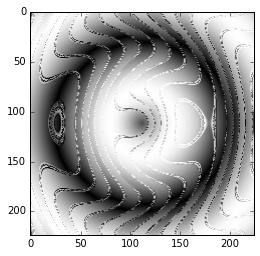

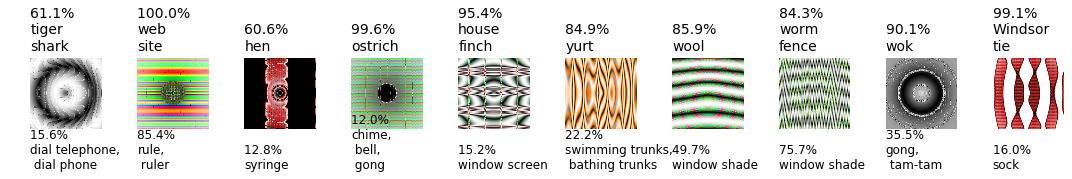

In [31]:
%matplotlib inline
num_examples = 10

indices = np.arange(2000, 2010)

plt.imshow(raw_im[2000])

f, plot = plt.subplots(1, 10, figsize=(15, 4))
plt.axis('off')

count = 0
for index in indices:
    
    x, y = count / 5, count % 5
    
    print index
    i = index - 2000
    
    label = classes[ int(metadata[index]['label'] )]
    if  ',' in label:
        shortened_label = label[:label.index(',')]
    else:
        shortened_label = label
    shortened_label = '\n'.join(shortened_label.split(' '))
    
    plot[count].text(0, -25, "{0:.1f}% \n{1}".format(100 * metadata[index]['confidence'], 
                     shortened_label),
                     fontsize=14)
    plot[count].imshow(raw_im[index])
    plot[count].axis('off')
    
    
    vgg_label = ',\n'.join(predictions[i]['label'].split(','))
    
    plot[count].text(0, 350, "{0:.1f}% \n{1}".format(100 * predictions[i]['confidence'], 
                     vgg_label),
                     fontsize=12)
    
    count += 1
#     plt.axis('off')
#     plt.text(250, 70, 'AlexNet Guess: {0} \nConfidence: {1} \n\n VGG Guess: {2}\n Confidence: {3}'
#              .format(classes[ int(metadata[i]['label']) ], 
#                      metadata[i]['confidence'], predictions[i]['label'], predictions[i]['confidence']), 
#                      fontsize=14)
   # plt.show()
plt.tight_layout()
plt.savefig('adversarial.png', dpi=300)
plt.show()